
## Constraints model

* gradient based input optimization from constrained outputs 

## Web application (NOT deployed yet)

Run interactively on the web at: 




## Inputs



(2, 'i_h2i_rate')

(3, 'i_h2_temp')

(4, 'i_ngi_rate')

(6, 'i_pci_rate')

(11, 'i_o2_volfract')

(12, 'i_hbtemp')

(13, 'i_wind_rt')


## Outputs


* desired output requirements 

Raceway flame temp > 1900K.....(19, 'o_fta')
 
Hot metal temp > 1700K........(21, 'o_hmt')

Top gas temp > 100C,,,,,,,,,,,(23, 'o_tgt')








## Installs


In [1]:

## !pip install xgboost
## !pip install onnxmltools
## !pip install onnxruntime
## !pip install pandas
## !pip install scikit-learn
## !pip install matplotlib
## !pip install seaborn
## !pip install mlxtend
## ! pip install skl2onnx



## Imports


In [2]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch


import torch.optim as optim


from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)




In [3]:

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import onnxmltools
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster


from zipfile import ZipFile
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)


# Import the ONNX runtime environment
import onnxruntime as rt



In [4]:

import PDFshapingUtils as PDF_tk



## Instantiate PDF shaping and regression class


In [5]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()



## Initialize parameters


In [6]:

PDFshapingOBJ.N_error_range = 5         ## 20
PDFshapingOBJ.mean_impulse  = 0.0       ## -7.0      ## 0.0
PDFshapingOBJ.std_impulse   = 0.001     ## 1.0
PDFshapingOBJ.kde_std       = 0.5       ## 0.1       ## 0.5      ## 3.0  ## smaller is better approximation?
PDFshapingOBJ.bandwidth     = 0.2       ## 0.2->more jagged, 2.0->more smooth


In [7]:

PDFshapingOBJ.initializeImpulseGaussian()



## Load Data


In [8]:

PDFshapingOBJ.read_csv_file_with_pandas('CFD.14.2025_REVISED.csv')


In [9]:

PDFshapingOBJ.CFD_raw_data


Index                                          Case_Name  i_h2i_rate  \
0        1  H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-1200_HB...          10   
1        2  H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-600_HBT...          10   
2        3  H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-300_HBT...          10   
3        4  H2-20_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-1200_HB...          20   
4        5  H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-600_HBT...          10   
..     ...                                                ...         ...   
946    947  H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...           0   
947    948  H2-0_PCI-0_WPI-0_NG-60_O2-21_NGT-300_H2T-0_HBT...           0   
948    949  H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HB...           0   
949    950  H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...           0   
950    951  H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HB...           0   

     i_h2_temp  i_ngi_rate  i_ng_temp  i_pci_rate  i_wpi_rate  i_sgi_rate  \
0         1200           0          0           0           0           0   
1          600           0          0           0           0           0   
2          300           0          0           0           0           0   
3         1200           0          0           0           0           0   
4          600           0          0           0           0           0   
..         ...         ...        ...         ...         ...         ...   
946          0         100        300           0           0           0   
947          0          60        300           0           0           0   
948          0         120        300           0           0           0   
949          0         100        300           0           0           0   
950          0         120        300           0           0           0   

     i_sgi_COH2ratio  ...  o_co2_sollos  o_h2o_sollos  o_feo_sollos  o_hm_rt  \
0                  0  ...          27.5          9.08      53.42225    188.0   
1                  0  ...          28.3          9.23      51.71010    188.0   
2                  0  ...          25.9          8.47      54.11249    188.0   
3                  0  ...          25.4         14.80      44.36503    206.0   
4                  0  ...          25.9          8.46      56.56291    186.0   
..               ...  ...           ...           ...           ...      ...   
946                0  ...          20.9         19.20      52.23245    124.0   
947                0  ...          31.6         14.90      46.71122    153.0   
948                0  ...          17.7         20.00      44.92799    122.0   
949                0  ...          26.4         18.90      46.49542    142.0   
950                0  ...          24.0         20.60      42.36397    139.0   

     o_mw_rt  o_wf_rt  o_hm_h2share  o_mw_h2share  o_wf_h2share  o_prod_rt  
0      407.0   1090.0          13.3          12.3          34.2     6230.0  
1      407.0   1100.0          13.2          12.2          34.1     6250.0  
2      407.0   1110.0          13.1          12.2          34.9     6250.0  
3      446.0   1210.0          21.0          18.3          44.7     6840.0  
4      403.0   1090.0          13.3          12.1          34.7     6190.0  
..       ...      ...           ...           ...           ...        ...  
946    268.0    690.0          27.7          23.2          60.6     4090.0  
947    330.0    878.0          17.2          15.6          46.9     5060.0  
948    264.0    687.0          31.6          26.7          63.5     4050.0  
949    306.0    802.0          24.0          23.3          57.8     4700.0  
950    300.0    789.0          27.4          26.6          61.8     4610.0  

[951 rows x 40 columns]

In [10]:

PDFshapingOBJ.print_headers_list()


['Index', 'Case_Name', 'i_h2i_rate', 'i_h2_temp', 'i_ngi_rate', 'i_ng_temp', 'i_pci_rate', 'i_wpi_rate', 'i_sgi_rate', 'i_sgi_COH2ratio', 'i_sgi_ReProRatio', 'i_o2_volfract', 'i_hbtemp', 'i_wind_rt', 'i_blastH2O', 'i_BdnH2O', 'o_tuy_velo', 'o_tuy_temp', 'o_burn', 'o_fta', 'o_coke_rt', 'o_hmt', 'o_delp', 'o_tgt', 'o_co_vf', 'o_co2_vf', 'o_h2_vf', 'o_n2_vf', 'o_co_util', 'o_h2_util', 'o_co2_sollos', 'o_h2o_sollos', 'o_feo_sollos', 'o_hm_rt', 'o_mw_rt', 'o_wf_rt', 'o_hm_h2share', 'o_mw_h2share', 'o_wf_h2share', 'o_prod_rt']
40
(0, 'Index')
(1, 'Case_Name')
(2, 'i_h2i_rate')
(3, 'i_h2_temp')
(4, 'i_ngi_rate')
(5, 'i_ng_temp')
(6, 'i_pci_rate')
(7, 'i_wpi_rate')
(8, 'i_sgi_rate')
(9, 'i_sgi_COH2ratio')
(10, 'i_sgi_ReProRatio')
(11, 'i_o2_volfract')
(12, 'i_hbtemp')
(13, 'i_wind_rt')
(14, 'i_blastH2O')
(15, 'i_BdnH2O')
(16, 'o_tuy_velo')
(17, 'o_tuy_temp')
(18, 'o_burn')
(19, 'o_fta')
(20, 'o_coke_rt')
(21, 'o_hmt')
(22, 'o_delp')
(23, 'o_tgt')
(24, 'o_co_vf')
(25, 'o_co2_vf')
(26, 'o_h2_vf'

/home/maquina1/anaconda3/envs/py37_Constraints/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/maquina1/anaconda3/envs/py37_Constraints/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


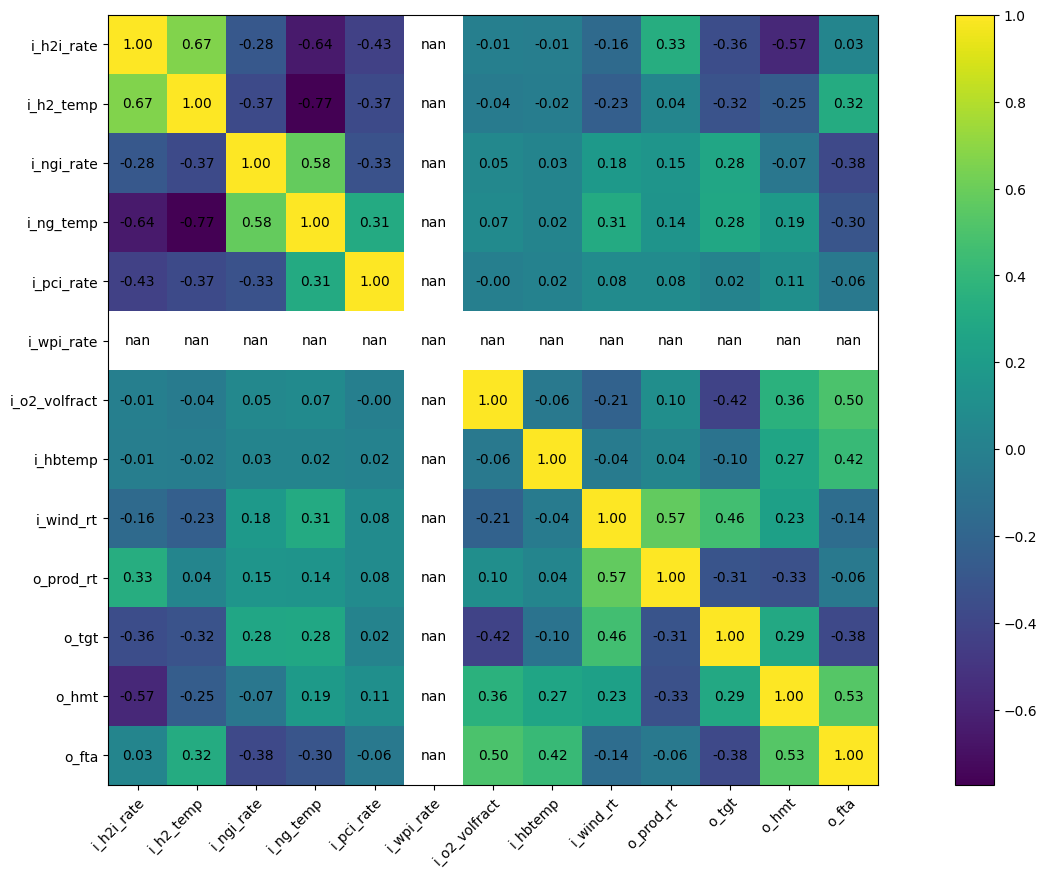

In [11]:

PDFshapingOBJ.list_of_selected_column_names = ['i_h2i_rate','i_h2_temp','i_ngi_rate','i_ng_temp','i_pci_rate',
                    'i_wpi_rate','i_o2_volfract',
                    'i_hbtemp','i_wind_rt','o_prod_rt', 'o_tgt', 'o_hmt','o_fta']



PDFshapingOBJ.print_correlation_coefficients()


In [12]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[1 'H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-1200_HBT-1200_WR-160' 10 ...
  12.3 34.2 6230.0]
 [2 'H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-600_HBT-1480_WR-160' 10 ...
  12.2 34.1 6250.0]
 [3 'H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-300_HBT-1600_WR-160' 10 ...
  12.2 34.9 6250.0]
 ...
 [949 'H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HBT-1200_WR-195' 0 ...
  26.7 63.5 4050.0]
 [950 'H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HBT-1200_WR-230' 0 ...
  23.3 57.8 4700.0]
 [951 'H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HBT-1200_WR-230' 0 ...
  26.6 61.8 4610.0]]
(951, 40)



## Select inputs and outputs


In [13]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs = [ 2, 3, 4, 6, 11, 12, 13 ] , 
                   outputs= [ 19, 21, 23 ]   
)


7
3


In [14]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(951, 7)
(951, 3)


In [15]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [16]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(760, 7)
(191, 7)
(760, 3)
(191, 3)


In [17]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [18]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [19]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


In [20]:

n_inputs  = 7
n_outputs = 3

class ResidualNet(nn.Module):
    def __init__(self, x_means, x_deviations, y_means, y_deviations, dropout_rate=0.1, device='cuda'):
        
        super().__init__()
        self.device = device
        
        self.x_means      = x_means.to(self.device)
        self.x_deviations = x_deviations.to(self.device)
        self.y_means      = y_means.to(self.device)
        self.y_deviations = y_deviations.to(self.device)

     
        self.fc1  = nn.Linear(n_inputs, 64)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(64, 64)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(64, n_outputs)

        # If input_dim ≠ 64, project for residual addition
        self.input_proj = nn.Linear(n_inputs, 64) if n_inputs != 64 else nn.Identity()
        
        # Move model to device
        self.to(self.device)
        

    def forward(self, x):
        x  = x.to(self.device)
        x  = (x - self.x_means) / self.x_deviations
        x0 = self.input_proj(x)
        x1 = self.dropout1(self.act1(self.fc1(x)))
        x2 = self.dropout2(self.act2(self.fc2(x1)))
        x_res = x2 + x0
        y_scaled = self.fc3(x_res)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    
    


In [21]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model     = ResidualNet(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations,
             device=device  # pass device into the model
    
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.MSELoss()




In [22]:

model.train()

for epoch in range(1000):
    for xb, yb in PDFshapingOBJ.train_dl:
        
        xb = xb.to(model.device)
        yb = yb.to(model.device)
        
        optimizer.zero_grad()
        pred_descaled, pred_scaled = model(xb)
        loss = loss_fn(pred_scaled, yb)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(epoch, ".....", loss.item() ) 
    


    

0 ..... 0.4834885001182556
100 ..... 0.021120039746165276
200 ..... 0.01670960895717144
300 ..... 0.01220306009054184
400 ..... 0.009592424146831036
500 ..... 0.015036923810839653
600 ..... 0.014187432825565338
700 ..... 0.011255385354161263
800 ..... 0.02748565934598446
900 ..... 0.01736944355070591


In [23]:

print("=== SANITY CHECK: SCALING ===")
print("y_means:", PDFshapingOBJ.y_means)
print("y_deviations:", PDFshapingOBJ.y_deviations)

print("===============================================")

print("x_means:", PDFshapingOBJ.x_means)
print("x_deviations:", PDFshapingOBJ.x_deviations)



=== SANITY CHECK: SCALING ===
y_means: tensor([[2259.3816, 1219.2112,   73.0232]])
y_deviations: tensor([[210.8732, 571.4916,  39.5153]])
x_means: tensor([[  12.2500,  250.2632,   42.0013,   27.2118,   25.3487, 1439.4210,
          189.9803]])
x_deviations: tensor([[ 15.0473, 354.3816,  42.8450,  52.9068,   3.3349, 157.8168,  26.3247]])



## Constraints Optimization



* desired output requirements
* Raceway flame temp 2600k - 2700K...........(17, 'o_fta')
* Hot metal temp      1800 - 1830K...........(21, 'o_hmt')
* Top gas temp         70 - 80C............(23, 'o_tgt')




In [24]:

print(  PDFshapingOBJ.constraint_weights.shape  )
print(  PDFshapingOBJ.constraint_weights  )


torch.Size([32, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')


In [25]:



PDFshapingOBJ.init_z_constraints()


optimizer_infer = torch.optim.Adam( [ PDFshapingOBJ.z ], lr=0.03)     ## 0.05


scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer_infer, step_size=40000, gamma=0.5
)

print( PDFshapingOBJ.z.shape )   # Should print: torch.Size([32, 7])
print( PDFshapingOBJ.z ) 




torch.Size([32, 7])
Parameter containing:
tensor([[ 0.6176, -0.6924,  0.0346,  0.2204, -0.6783,  0.5065, -0.1612],
        [ 0.1628, -0.4268, -0.7008, -0.2383,  0.4407, -0.8391,  0.4610],
        [ 0.0090, -0.5306,  0.5219, -0.4843, -0.1517, -0.4923,  0.5520],
        [ 0.4533, -0.1619,  0.2608,  0.6947,  0.6190, -0.1567,  0.0597],
        [ 0.1727, -0.1600, -0.4732,  0.7762, -0.5696,  0.6010,  0.5930],
        [ 0.4608,  0.5172, -0.2812,  0.1772, -0.1093,  0.2879,  0.7479],
        [-0.2281, -0.7256,  0.6760, -0.0199,  0.3784,  0.6199,  0.0227],
        [-0.7637,  0.5931, -0.6591, -0.3637, -0.7830, -0.5437,  0.5708],
        [ 0.8451, -0.6202,  0.1755, -0.0536,  0.4551, -0.2522,  0.2215],
        [ 0.0862,  0.3155, -0.1895, -0.5166,  0.7301, -0.5324, -0.2392],
        [-0.1253,  0.2904,  0.7477,  0.3951, -0.7822, -0.4261,  0.0393],
        [-0.4411,  0.3230,  0.3981, -0.2530,  0.3081,  0.0647,  0.3907],
        [-0.0184, -0.1129, -0.3703,  0.2837,  0.3630,  0.3690,  0.0450],
        [

In [26]:


(lower_bounds_glob,
 upper_bounds_glob,
 lower_bounds_glob_scaled,
 upper_bounds_glob_scaled)  = PDFshapingOBJ.get_upper_lower_bounds_constraints()

print( lower_bounds_glob.shape )
print( upper_bounds_glob.shape )
print( lower_bounds_glob_scaled.shape )
print( upper_bounds_glob_scaled.shape )

print( lower_bounds_glob )
print( upper_bounds_glob )
print( lower_bounds_glob_scaled )
print( upper_bounds_glob_scaled )


torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
tensor([[2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.,   70.],
        [2600., 1800.

In [27]:


clamp_min, clamp_max = PDFshapingOBJ.get_clamps_min_max_constraints(
    batch_size=PDFshapingOBJ.batch_size_syn, device=PDFshapingOBJ.device
)

print( clamp_min.shape )
print( clamp_max.shape )


for i in range(  clamp_min.shape[0] ):
    print(clamp_min[i] )
    print(clamp_max[i] )  
    print("************")


torch.Size([32, 7])
torch.Size([32, 7])
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.], device='cuda:0')
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.], device='cuda:0')
************
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.], device='cuda:0')
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.], device='cuda:0')
************
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.], device='cuda:0')
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.], device='cuda:0')
************
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.], device='cuda:0')
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.], device='cuda:0')
************
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.], device='cuda:0')
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.], device='cuda:0')
************
tensor([ -50.,  -50.,  -50.,  -50.,  -29., 1150.,  100.], device='cuda:0')
tensor([ 150., 1550.,  350.,  350.,   90., 1550.,  300.], device='cuda

In [28]:


def constraint_loss(
    y_pred,               # [B, D]
    weights,              # [B, D]
    lower_bounds_glob,    # [B, D]
    upper_bounds_glob,    # [B, D]
    reg_weight=1e-4
):

    lower_violation = torch.relu(lower_bounds_glob - y_pred)
    upper_violation = torch.relu(y_pred - upper_bounds_glob)
    
    loss = weights * (lower_violation ** 2 + upper_violation ** 2)  # shape [B, D]

    mean_loss_per_output = loss.mean(dim=0)  # shape [D]
    print("Mean loss per output:", mean_loss_per_output.detach().cpu().numpy())

    with torch.no_grad():
        adaptive_weights = mean_loss_per_output / (mean_loss_per_output.sum() + 1e-6)
        adaptive_weights = adaptive_weights.detach()  
        
    center = (lower_bounds_glob + upper_bounds_glob) / 2
    soft_center_loss = ((y_pred - center) ** 2)
    soft_center_loss = (soft_center_loss.mean(dim=0) * adaptive_weights).sum()


    ## total_loss = torch.dot(mean_loss_per_output, adaptive_weights)  
    total_loss = (mean_loss_per_output * adaptive_weights).sum()
    
    alpha      = 0.9 
    total_loss = total_loss + alpha * soft_center_loss


    total_loss = total_loss + reg_weight * torch.mean(y_pred ** 2)

    return total_loss




## Optimization - constraints


In [29]:


alpha  = 0.9 
epochs = 90000


for step in range( epochs ):
    
    x_guess       = PDFshapingOBJ.get_x_from_z( PDFshapingOBJ.z, clamp_min, clamp_max  )  # shape: [32, 7]
    
    y_pred_real, y_pred_scaled = model( x_guess )
    
    
    loss_main = constraint_loss(
        y_pred_scaled,           # [B, D]
        PDFshapingOBJ.constraint_weights,      # [B, D]
        lower_bounds_glob_scaled,       # [B, D]
        upper_bounds_glob_scaled        # [B, D]
    )
    
    loss_soft     = PDFshapingOBJ.soft_box_penalty(x_guess, clamp_min, clamp_max, strength=10.0)
    loss_z_reg    = PDFshapingOBJ.regularize_z(PDFshapingOBJ.z, strength=1e-3)
    
    loss = alpha * loss_main + (1 - alpha) * loss_soft + loss_z_reg
    
    
    optimizer_infer.zero_grad()
    loss.backward()
    optimizer_infer.step()
    scheduler.step()
    

    if step % 10000 == 0:
        lr_current = scheduler.get_last_lr()[0]
        print(f"Step {step} — LR: {lr_current:.5f} — Loss: {loss.item():.6f}")



    if step % 20000 == 0:
        print("====== Checkpoint ======")
        print("Step:", step)
        '''
        print("z:", PDFshapingOBJ.z.detach().cpu())
        print("x_guess:", x_guess.detach().cpu())
        print("target_output_not_scaled:", target_output_not_scaled.cpu())
        print("y_pred_real:", y_pred_real.detach().cpu())
        print("y_pred_scaled:", y_pred_scaled.detach().cpu())
        print("target_output_scaled:", target_output.cpu())
        print("clamp_min:", clamp_min.cpu())
        print("clamp_max:", clamp_max.cpu())
        '''
        print("Total Loss:", loss.item())
        print("=========================")

        
        

Mean loss per output: [14.357881   26.32712     0.45173728]
Step 0 — LR: 0.03000 — Loss: 37.978443
====== Checkpoint ======
Step: 0
Total Loss: 37.97844314575195
Mean loss per output: [13.394079   24.637033    0.45363608]
Mean loss per output: [12.03406    22.23569     0.33050507]
Mean loss per output: [10.096865   19.193966    0.47347298]
Mean loss per output: [ 9.235503  17.648354   0.5505618]
Mean loss per output: [ 8.340626  15.7226095  0.457946 ]
Mean loss per output: [ 7.8016443 14.580398   0.5496868]
Mean loss per output: [ 7.0608115  13.603182    0.36176538]
Mean loss per output: [ 6.171391   11.790743    0.34731203]
Mean loss per output: [5.022847   9.786863   0.47396857]
Mean loss per output: [4.8420944  9.047815   0.40827575]
Mean loss per output: [3.8260207  7.5297537  0.41180953]
Mean loss per output: [3.5266557  6.76456    0.42933288]
Mean loss per output: [3.3238175  6.3713884  0.34640595]
Mean loss per output: [2.7344766 4.978099  0.5074067]
Mean loss per output: [2.790

Mean loss per output: [0.01822652 0.03863811 0.07145992]
Mean loss per output: [0.02012692 0.030955   0.05694728]
Mean loss per output: [0.01803191 0.0338504  0.06576037]
Mean loss per output: [0.01428633 0.02291527 0.06386577]
Mean loss per output: [0.01073604 0.02680584 0.05962652]
Mean loss per output: [0.02663283 0.01927637 0.04731902]
Mean loss per output: [0.0131426  0.03335835 0.06625051]
Mean loss per output: [0.0071958  0.04265717 0.05593139]
Mean loss per output: [0.01382847 0.03151498 0.05849408]
Mean loss per output: [0.00985014 0.0341327  0.059183  ]
Mean loss per output: [0.01134033 0.03058048 0.06096109]
Mean loss per output: [0.01612846 0.03697096 0.05116697]
Mean loss per output: [0.01037238 0.0246015  0.04125626]
Mean loss per output: [0.0116025  0.02593436 0.04839592]
Mean loss per output: [0.00589583 0.04507189 0.06453118]
Mean loss per output: [0.0145891  0.03465958 0.04013454]
Mean loss per output: [0.00587061 0.02744662 0.05685091]
Mean loss per output: [0.013759

Mean loss per output: [0.00392107 0.01024378 0.01918256]
Mean loss per output: [0.00824984 0.0124309  0.01393767]
Mean loss per output: [0.00200234 0.0107904  0.01734266]
Mean loss per output: [0.00201455 0.00498311 0.01509443]
Mean loss per output: [0.00130696 0.00805532 0.01276764]
Mean loss per output: [0.00077689 0.00475366 0.01936091]
Mean loss per output: [0.001985   0.00515067 0.01415902]
Mean loss per output: [0.00692625 0.01502575 0.01299248]
Mean loss per output: [0.00153841 0.00915952 0.01483037]
Mean loss per output: [0.00338347 0.00548337 0.01901564]
Mean loss per output: [0.00193738 0.01252466 0.01299166]
Mean loss per output: [0.00209685 0.00877509 0.01218861]
Mean loss per output: [0.00467396 0.00978446 0.01283071]
Mean loss per output: [0.00147527 0.00937575 0.01448675]
Mean loss per output: [0.00188593 0.01027685 0.01127499]
Mean loss per output: [0.0019497  0.00691147 0.0126914 ]
Mean loss per output: [0.00271829 0.01276684 0.01762496]
Mean loss per output: [0.001906

Mean loss per output: [0.00258577 0.00628275 0.00539206]
Mean loss per output: [0.00122237 0.00977996 0.01002021]
Mean loss per output: [0.00148079 0.00521158 0.01244205]
Mean loss per output: [0.00025345 0.0051226  0.00961781]
Mean loss per output: [0.00023235 0.00724032 0.00939607]
Mean loss per output: [0.00527613 0.0075335  0.01034712]
Mean loss per output: [0.00074807 0.00569923 0.00654519]
Mean loss per output: [0.00281142 0.00685782 0.01080267]
Mean loss per output: [0.0007247  0.00296588 0.00827177]
Mean loss per output: [0.00159785 0.00476246 0.00807829]
Mean loss per output: [0.00382326 0.00872388 0.00795758]
Mean loss per output: [0.00393256 0.00499983 0.00918498]
Mean loss per output: [0.0009166  0.00215972 0.00921621]
Mean loss per output: [0.00106399 0.00407045 0.00846109]
Mean loss per output: [0.00289016 0.00572078 0.00847373]
Mean loss per output: [0.00673735 0.00904717 0.01017682]
Mean loss per output: [0.00025076 0.00348818 0.01179182]
Mean loss per output: [0.005223

Mean loss per output: [0.00193188 0.00420647 0.00633304]
Mean loss per output: [0.00239282 0.0059266  0.00905415]
Mean loss per output: [0.00268542 0.00639839 0.00926391]
Mean loss per output: [0.00224272 0.00437803 0.00728516]
Mean loss per output: [0.00104879 0.00338198 0.00621574]
Mean loss per output: [0.00037076 0.00346614 0.00640784]
Mean loss per output: [0.00140213 0.00254158 0.00779619]
Mean loss per output: [0.0030376  0.00707395 0.00732457]
Mean loss per output: [0.00122974 0.00500623 0.00566894]
Mean loss per output: [0.00293539 0.00317022 0.00709469]
Mean loss per output: [0.00339147 0.00263523 0.00649284]
Mean loss per output: [0.00201963 0.00346041 0.01254727]
Mean loss per output: [0.0002133  0.00589403 0.00688643]
Mean loss per output: [0.0012127  0.00411664 0.00884155]
Mean loss per output: [0.00074132 0.00495031 0.00693962]
Mean loss per output: [0.00337562 0.00311251 0.00744853]
Mean loss per output: [0.00149713 0.00435738 0.00786521]
Mean loss per output: [0.002148

Mean loss per output: [0.00333337 0.00392253 0.00935568]
Mean loss per output: [0.00243313 0.00194721 0.00836585]
Mean loss per output: [0.00052812 0.00576712 0.008601  ]
Mean loss per output: [0.00679545 0.00553786 0.00805327]
Mean loss per output: [0.00074362 0.00410865 0.0071026 ]
Mean loss per output: [0.00024882 0.00177435 0.00774903]
Mean loss per output: [0.00058353 0.00526347 0.0088856 ]
Mean loss per output: [0.00659768 0.00414436 0.00802812]
Mean loss per output: [0.00304208 0.00350805 0.00782131]
Mean loss per output: [0.00150062 0.00324291 0.00738345]
Mean loss per output: [0.00328077 0.00451612 0.00438026]
Mean loss per output: [0.00063651 0.00586333 0.00847669]
Mean loss per output: [0.00053899 0.00556511 0.00721676]
Mean loss per output: [0.00217101 0.00128956 0.009613  ]
Mean loss per output: [0.00049053 0.00430499 0.00627694]
Mean loss per output: [0.00176518 0.00210819 0.00714392]
Mean loss per output: [0.00520116 0.0021721  0.00786411]
Mean loss per output: [0.002703

Mean loss per output: [0.00210198 0.00544303 0.00950085]
Mean loss per output: [0.00384229 0.00826187 0.0097446 ]
Mean loss per output: [0.00556168 0.00614218 0.01032709]
Mean loss per output: [0.00233153 0.00716827 0.00828164]
Mean loss per output: [0.00210037 0.00360063 0.00649354]
Mean loss per output: [0.00075439 0.00367595 0.00633758]
Mean loss per output: [0.00186132 0.00442997 0.01106085]
Mean loss per output: [0.01126644 0.00861517 0.01228052]
Mean loss per output: [0.0014582  0.00420214 0.01033847]
Mean loss per output: [0.00469948 0.00721364 0.00612405]
Mean loss per output: [0.0021828  0.00457212 0.00891443]
Mean loss per output: [0.00283812 0.00724279 0.00952283]
Mean loss per output: [0.00530771 0.00463315 0.00718691]
Mean loss per output: [0.000978   0.00552374 0.01070607]
Mean loss per output: [0.00144253 0.00559534 0.00958681]
Mean loss per output: [0.00084443 0.00335759 0.00536988]
Mean loss per output: [0.0081644  0.00411227 0.00911242]
Mean loss per output: [0.002127

Mean loss per output: [0.0020484  0.00342108 0.00884849]
Mean loss per output: [0.00339277 0.0034421  0.00691264]
Mean loss per output: [0.0021228  0.00567707 0.00639233]
Mean loss per output: [0.00322017 0.00518964 0.00462313]
Mean loss per output: [0.00370787 0.0042669  0.00688133]
Mean loss per output: [0.00198782 0.00297371 0.01070753]
Mean loss per output: [0.00241274 0.00393629 0.00777016]
Mean loss per output: [0.00169494 0.00645848 0.00852874]
Mean loss per output: [0.0001749  0.00248548 0.00812464]
Mean loss per output: [0.00407415 0.00214845 0.00735861]
Mean loss per output: [0.00540284 0.00508069 0.00904977]
Mean loss per output: [0.00068351 0.00327757 0.00770217]
Mean loss per output: [0.00160677 0.00408186 0.00819116]
Mean loss per output: [0.00039699 0.00235926 0.01018849]
Mean loss per output: [0.00140936 0.00405301 0.00814642]
Mean loss per output: [0.00067202 0.00404654 0.00681007]
Mean loss per output: [0.00451893 0.00448688 0.0084484 ]
Mean loss per output: [0.002217

Mean loss per output: [0.0022414  0.00374659 0.00997972]
Mean loss per output: [0.00325012 0.00420023 0.01238035]
Mean loss per output: [0.00249275 0.00328399 0.00821416]
Mean loss per output: [0.00736691 0.00374702 0.00953747]
Mean loss per output: [0.00181415 0.00344845 0.00464867]
Mean loss per output: [0.00011728 0.00172941 0.00498334]
Mean loss per output: [0.00294625 0.00426984 0.00993559]
Mean loss per output: [0.00669486 0.00392148 0.01053132]
Mean loss per output: [0.00140317 0.00284862 0.00724137]
Mean loss per output: [0.00041276 0.00240189 0.0050323 ]
Mean loss per output: [0.00635168 0.00325565 0.00964907]
Mean loss per output: [0.00198565 0.00208482 0.00888102]
Mean loss per output: [0.00385143 0.00158809 0.0072423 ]
Mean loss per output: [0.00367648 0.00263035 0.00880645]
Mean loss per output: [0.0000192  0.00172626 0.00567503]
Mean loss per output: [0.00042156 0.00759793 0.00875334]
Mean loss per output: [0.0013017  0.00496026 0.00529889]
Mean loss per output: [0.002378

Mean loss per output: [0.00581937 0.00417989 0.00823754]
Mean loss per output: [0.00001697 0.00249025 0.00787752]
Mean loss per output: [0.00109998 0.00412037 0.00650602]
Mean loss per output: [0.0040908  0.0050948  0.00722449]
Mean loss per output: [0.00112371 0.00286222 0.00712606]
Mean loss per output: [0.00286636 0.00281759 0.01010844]
Mean loss per output: [0.00135024 0.00375505 0.01126229]
Mean loss per output: [0.00315035 0.00355743 0.0053931 ]
Mean loss per output: [0.00127997 0.00149562 0.00784454]
Mean loss per output: [0.0029646  0.00367342 0.00931717]
Mean loss per output: [0.0015645  0.00572287 0.00856544]
Mean loss per output: [0.00459381 0.00555893 0.00599545]
Mean loss per output: [0.00912769 0.00650064 0.01002157]
Mean loss per output: [0.00135512 0.0022962  0.0059074 ]
Mean loss per output: [0.00038748 0.00223653 0.00894829]
Mean loss per output: [0.00067833 0.00832819 0.00894129]
Mean loss per output: [0.00194083 0.00693331 0.00962569]
Mean loss per output: [0.005069

Mean loss per output: [0.00330588 0.00255178 0.00631174]
Mean loss per output: [0.00565181 0.00672822 0.00980114]
Mean loss per output: [0.00240487 0.00338744 0.00906993]
Mean loss per output: [0.01409292 0.01099813 0.00876441]
Mean loss per output: [0.00092784 0.00215509 0.00873806]
Mean loss per output: [0.00180237 0.0017689  0.00595549]
Mean loss per output: [0.00332052 0.00572082 0.00735869]
Mean loss per output: [0.00138231 0.00325557 0.00677496]
Mean loss per output: [0.00219863 0.00334058 0.00684012]
Mean loss per output: [0.00619674 0.00484204 0.01241374]
Mean loss per output: [0.00479168 0.00256547 0.01229657]
Mean loss per output: [0.00523697 0.00225372 0.00471548]
Mean loss per output: [0.00491584 0.00441188 0.00616827]
Mean loss per output: [0.00554784 0.00415528 0.00606662]
Mean loss per output: [0.00345331 0.00257433 0.00882051]
Mean loss per output: [0.00117078 0.00401557 0.00736737]
Mean loss per output: [0.00250349 0.00304137 0.01078783]
Mean loss per output: [0.000803

Mean loss per output: [0.00155615 0.00311588 0.01089676]
Mean loss per output: [0.00013716 0.00273651 0.00792558]
Mean loss per output: [0.00503912 0.0031948  0.00754832]
Mean loss per output: [0.0010066  0.00532491 0.00564097]
Mean loss per output: [0.00125311 0.00610321 0.00628694]
Mean loss per output: [0.01345028 0.00516654 0.00793349]
Mean loss per output: [0.00038941 0.00336663 0.01057773]
Mean loss per output: [0.00081854 0.00284039 0.00625996]
Mean loss per output: [0.00175503 0.00334661 0.00638736]
Mean loss per output: [0.00285053 0.0026786  0.00720725]
Mean loss per output: [0.0071689  0.00329097 0.00824431]
Mean loss per output: [0.00308634 0.00142651 0.00848772]
Mean loss per output: [0.00570438 0.0040985  0.0095144 ]
Mean loss per output: [0.00427202 0.00460341 0.00643039]
Mean loss per output: [0.00769166 0.00411355 0.01826388]
Mean loss per output: [0.00214838 0.00393123 0.00947917]
Mean loss per output: [0.00029587 0.00369777 0.00676698]
Mean loss per output: [0.001714

Mean loss per output: [0.0108964  0.00224336 0.00952505]
Mean loss per output: [0.00147035 0.00392101 0.00941704]
Mean loss per output: [0.00227498 0.00405798 0.01085387]
Mean loss per output: [0.00203185 0.00371504 0.01028836]
Mean loss per output: [0.00159011 0.0027216  0.01089891]
Mean loss per output: [0.00246374 0.00332658 0.01024918]
Mean loss per output: [0.00081252 0.00473235 0.00489662]
Mean loss per output: [0.00492683 0.00758776 0.01045346]
Mean loss per output: [0.00040793 0.00279179 0.00666993]
Mean loss per output: [0.00330764 0.00337287 0.00767106]
Mean loss per output: [0.00450349 0.00336693 0.00744319]
Mean loss per output: [0.01474992 0.00493192 0.0081465 ]
Mean loss per output: [0.00061416 0.00090597 0.00909466]
Mean loss per output: [0.00143852 0.00212621 0.00968769]
Mean loss per output: [0.0011749  0.00367028 0.00796369]
Mean loss per output: [0.00216733 0.00634508 0.01545836]
Mean loss per output: [0.00628982 0.00576121 0.01102027]
Mean loss per output: [0.002382

Mean loss per output: [0.00204427 0.00234439 0.00631023]
Mean loss per output: [0.00052592 0.00805068 0.00527893]
Mean loss per output: [0.00203341 0.00525052 0.01008518]
Mean loss per output: [0.00162217 0.00883282 0.01124034]
Mean loss per output: [0.00080463 0.00511562 0.01377859]
Mean loss per output: [0.00310564 0.00527275 0.01076671]
Mean loss per output: [0.00413705 0.0036367  0.00750347]
Mean loss per output: [0.00194208 0.00558263 0.00839948]
Mean loss per output: [0.00396871 0.00377928 0.00628251]
Mean loss per output: [0.00212584 0.00312398 0.00963953]
Mean loss per output: [0.00376581 0.00779989 0.01052641]
Mean loss per output: [0.0035515  0.00409515 0.00872458]
Mean loss per output: [0.00236101 0.00395861 0.00861321]
Mean loss per output: [0.00357048 0.00808507 0.01041962]
Mean loss per output: [0.0012971  0.00337815 0.00736045]
Mean loss per output: [0.00096601 0.00382049 0.00783471]
Mean loss per output: [0.00206209 0.00778247 0.00591265]
Mean loss per output: [0.003891

Mean loss per output: [0.00220319 0.00330069 0.00759776]
Mean loss per output: [0.00265339 0.00307811 0.00574743]
Mean loss per output: [0.00124972 0.01070776 0.0045959 ]
Mean loss per output: [0.00157595 0.00144781 0.00743673]
Mean loss per output: [0.00342263 0.00494149 0.01088522]
Mean loss per output: [0.00326623 0.0033611  0.0089039 ]
Mean loss per output: [0.00336642 0.00574165 0.00816937]
Mean loss per output: [0.00664965 0.00550914 0.0067932 ]
Mean loss per output: [0.00181492 0.00292032 0.00820887]
Mean loss per output: [0.00138406 0.00343013 0.0068498 ]
Mean loss per output: [0.00292847 0.0048199  0.00905033]
Mean loss per output: [0.00171501 0.00542644 0.00616388]
Mean loss per output: [0.01354149 0.00725739 0.00804231]
Mean loss per output: [0.0010833  0.00505504 0.01284073]
Mean loss per output: [0.00164535 0.00552175 0.00779898]
Mean loss per output: [0.00567853 0.00676536 0.00773966]
Mean loss per output: [0.00249185 0.00251052 0.00752994]
Mean loss per output: [0.003864

Mean loss per output: [0.00423302 0.00524571 0.00685072]
Mean loss per output: [0.00140256 0.00107126 0.00588907]
Mean loss per output: [0.00268259 0.00338428 0.00857192]
Mean loss per output: [0.00536455 0.00286295 0.00688808]
Mean loss per output: [0.00270079 0.00349645 0.00743004]
Mean loss per output: [0.0062223  0.00566338 0.00860954]
Mean loss per output: [0.00174349 0.00370601 0.01040382]
Mean loss per output: [0.00194863 0.00132573 0.01050342]
Mean loss per output: [0.00356355 0.00335265 0.00704982]
Mean loss per output: [0.00211617 0.00477044 0.00696854]
Mean loss per output: [0.00290226 0.00398691 0.00846355]
Mean loss per output: [0.00221675 0.00264522 0.00902182]
Mean loss per output: [0.00167125 0.00297619 0.00583402]
Mean loss per output: [0.00683483 0.0045404  0.00518246]
Mean loss per output: [0.00063675 0.00145937 0.01103141]
Mean loss per output: [0.00677278 0.00257336 0.00657468]
Mean loss per output: [0.00167812 0.00289415 0.00905309]
Mean loss per output: [0.001869

Mean loss per output: [0.00527167 0.0045492  0.00632224]
Mean loss per output: [0.00396419 0.0021385  0.00907284]
Mean loss per output: [0.00158951 0.00270034 0.00738528]
Mean loss per output: [0.00676016 0.00489185 0.00515335]
Mean loss per output: [0.00332497 0.00563276 0.00915545]
Mean loss per output: [0.00301667 0.00226927 0.0116666 ]
Mean loss per output: [0.0067347  0.00540934 0.00829386]
Mean loss per output: [0.00182426 0.00471141 0.00838256]
Mean loss per output: [0.00026721 0.00213685 0.01125006]
Mean loss per output: [0.00210132 0.00541921 0.00732851]
Mean loss per output: [0.00225998 0.00304984 0.00948007]
Mean loss per output: [0.00322342 0.00578508 0.00687426]
Mean loss per output: [0.00284991 0.00380957 0.00868956]
Mean loss per output: [0.00243047 0.0028431  0.00861673]
Mean loss per output: [0.00509035 0.00384034 0.00635552]
Mean loss per output: [0.00261786 0.00466461 0.00623601]
Mean loss per output: [0.00165695 0.00226048 0.00519952]
Mean loss per output: [0.000375

Mean loss per output: [0.00598674 0.00635324 0.01253989]
Mean loss per output: [0.00336657 0.00200586 0.00944045]
Mean loss per output: [0.00941128 0.00378863 0.0093615 ]
Mean loss per output: [0.00494439 0.00378364 0.00635027]
Mean loss per output: [0.00168219 0.00301432 0.00789205]
Mean loss per output: [0.00085411 0.00405862 0.00770171]
Mean loss per output: [0.00199058 0.00777243 0.00744402]
Mean loss per output: [0.00132508 0.0035589  0.00681287]
Mean loss per output: [0.00124751 0.00341753 0.0093004 ]
Mean loss per output: [0.00236654 0.00487919 0.01074377]
Mean loss per output: [0.009691   0.00549419 0.01105513]
Mean loss per output: [0.00330726 0.0054087  0.01040903]
Mean loss per output: [0.00486069 0.00561105 0.00843195]
Mean loss per output: [0.00301498 0.00611399 0.00642416]
Mean loss per output: [0.00042616 0.00360167 0.00863908]
Mean loss per output: [0.00501116 0.01002018 0.00870501]
Mean loss per output: [0.00115898 0.0024119  0.00457652]
Mean loss per output: [0.012791

Mean loss per output: [0.00543393 0.01174552 0.0082582 ]
Mean loss per output: [0.00671734 0.00441046 0.00893535]
Mean loss per output: [0.00042907 0.0027113  0.0089521 ]
Mean loss per output: [0.00436152 0.0045125  0.00683819]
Mean loss per output: [0.00373872 0.00799151 0.00776409]
Mean loss per output: [0.00055155 0.00800449 0.00926445]
Mean loss per output: [0.0010039  0.00601674 0.00973864]
Mean loss per output: [0.00204966 0.00444826 0.00601922]
Mean loss per output: [0.00283541 0.0047923  0.00713055]
Mean loss per output: [0.00628097 0.00318477 0.00561931]
Mean loss per output: [0.00061668 0.00306937 0.00864393]
Mean loss per output: [0.00349744 0.00235051 0.00868231]
Mean loss per output: [0.00644854 0.01666005 0.00767567]
Mean loss per output: [0.00236315 0.00775864 0.0099927 ]
Mean loss per output: [0.00691268 0.00511219 0.00986749]
Mean loss per output: [0.00230212 0.00552651 0.0059904 ]
Mean loss per output: [0.00232484 0.01281271 0.00990615]
Mean loss per output: [0.002524

Mean loss per output: [0.0029372  0.00501446 0.00605089]
Mean loss per output: [0.00015323 0.00374845 0.00789931]
Mean loss per output: [0.00152273 0.00489855 0.00840874]
Mean loss per output: [0.0039309  0.00456858 0.00761562]
Mean loss per output: [0.00253823 0.0053263  0.00794852]
Mean loss per output: [0.00302595 0.00910613 0.00644143]
Mean loss per output: [0.00391728 0.00272536 0.01029069]
Mean loss per output: [0.00110046 0.00267063 0.00917287]
Mean loss per output: [0.00550125 0.00428155 0.00637677]
Mean loss per output: [0.00388973 0.00446638 0.00788104]
Mean loss per output: [0.00285637 0.00311034 0.01085901]
Mean loss per output: [0.00240366 0.00280684 0.00702483]
Mean loss per output: [0.00651553 0.00506603 0.00946875]
Mean loss per output: [0.00292052 0.00207501 0.0073056 ]
Mean loss per output: [0.00158466 0.00282649 0.01022473]
Mean loss per output: [0.0085836  0.00370082 0.01031   ]
Mean loss per output: [0.00588194 0.0066381  0.01304713]
Mean loss per output: [0.002341

Mean loss per output: [0.00922875 0.00300517 0.0060607 ]
Mean loss per output: [0.00326393 0.00145257 0.01029945]
Mean loss per output: [0.00324492 0.00271681 0.00875222]
Mean loss per output: [0.00520178 0.0066067  0.01079578]
Mean loss per output: [0.00360721 0.0068498  0.01060549]
Mean loss per output: [0.00069245 0.00507022 0.00798976]
Mean loss per output: [0.00416062 0.0023311  0.01176184]
Mean loss per output: [0.0002081  0.00179207 0.00897375]
Mean loss per output: [0.0047428  0.00396845 0.00922677]
Mean loss per output: [0.00166424 0.00309961 0.00728721]
Mean loss per output: [0.00614253 0.00306468 0.00410909]
Mean loss per output: [0.00149649 0.0025649  0.00658849]
Mean loss per output: [0.00054096 0.00251351 0.00733053]
Mean loss per output: [0.00327954 0.01202567 0.00902154]
Mean loss per output: [0.0149058  0.00400747 0.01067368]
Mean loss per output: [0.00520315 0.00790898 0.00674864]
Mean loss per output: [0.00091024 0.00502405 0.00809989]
Mean loss per output: [0.011246

Mean loss per output: [0.0028342  0.00408125 0.00745997]
Mean loss per output: [0.00248915 0.00505626 0.01333949]
Mean loss per output: [0.00084873 0.00336261 0.00881848]
Mean loss per output: [0.00046984 0.00250265 0.00463157]
Mean loss per output: [0.00100934 0.00759664 0.00912808]
Mean loss per output: [0.00417901 0.00516219 0.00577382]
Mean loss per output: [0.00518503 0.00307712 0.00691391]
Mean loss per output: [0.00319255 0.00738726 0.0089031 ]
Mean loss per output: [0.0023244  0.00476679 0.01180212]
Mean loss per output: [0.00235469 0.00832023 0.00755347]
Mean loss per output: [0.00562206 0.00797766 0.01005385]
Mean loss per output: [0.00078951 0.01170208 0.00550112]
Mean loss per output: [0.00281064 0.00221463 0.01075086]
Mean loss per output: [0.00196846 0.0030414  0.00902346]
Mean loss per output: [0.01090458 0.01054044 0.00814145]
Mean loss per output: [0.00194653 0.00402436 0.00765734]
Mean loss per output: [0.00507463 0.00494325 0.00580793]
Mean loss per output: [0.001807

Mean loss per output: [0.00495666 0.02498103 0.01386512]
Mean loss per output: [0.0022321  0.00608997 0.01170161]
Mean loss per output: [0.00387238 0.00350113 0.00614814]
Mean loss per output: [0.00595871 0.01007155 0.01185806]
Mean loss per output: [0.00328852 0.00660673 0.00953482]
Mean loss per output: [0.0023682  0.00663841 0.00859199]
Mean loss per output: [0.00145321 0.00503857 0.00568522]
Mean loss per output: [0.00386137 0.00791472 0.00806682]
Mean loss per output: [0.00196062 0.00448317 0.00747525]
Mean loss per output: [0.00181333 0.00346526 0.00812884]
Mean loss per output: [0.00561147 0.00785093 0.01156312]
Mean loss per output: [0.00116866 0.01071345 0.01289838]
Mean loss per output: [0.00440253 0.00710359 0.0103131 ]
Mean loss per output: [0.00244564 0.0032401  0.00794679]
Mean loss per output: [0.01005605 0.00547739 0.00942069]
Mean loss per output: [0.00054419 0.00306337 0.01361734]
Mean loss per output: [0.00490946 0.0080085  0.00981442]
Mean loss per output: [0.005894

Mean loss per output: [0.00583975 0.00372669 0.00718705]
Mean loss per output: [0.01487225 0.0060247  0.00626792]
Mean loss per output: [0.00212595 0.00456325 0.00973819]
Mean loss per output: [0.00697678 0.0088976  0.00750829]
Mean loss per output: [0.00190831 0.0109192  0.0103885 ]
Mean loss per output: [0.00099111 0.00678843 0.01192668]
Mean loss per output: [0.00301398 0.00355339 0.01197352]
Mean loss per output: [0.00046779 0.00281109 0.01253317]
Mean loss per output: [0.00484193 0.00486344 0.01011462]
Mean loss per output: [0.00452524 0.00591044 0.009281  ]
Mean loss per output: [0.00310584 0.00981349 0.00762226]
Mean loss per output: [0.00083736 0.00648827 0.00821695]
Mean loss per output: [0.00247191 0.00474394 0.00852888]
Mean loss per output: [0.00273324 0.00500827 0.00983855]
Mean loss per output: [0.00411813 0.00736002 0.00821416]
Mean loss per output: [0.00640399 0.00750441 0.01106805]
Mean loss per output: [0.00392357 0.00486731 0.00813873]
Mean loss per output: [0.003702

Mean loss per output: [0.00362054 0.00402544 0.00840581]
Mean loss per output: [0.00116609 0.003591   0.0079058 ]
Mean loss per output: [0.00629784 0.00564396 0.00900591]
Mean loss per output: [0.01689002 0.0078438  0.01376901]
Mean loss per output: [0.00407796 0.00431763 0.00984802]
Mean loss per output: [0.00065531 0.00893445 0.0080799 ]
Mean loss per output: [0.00128771 0.004479   0.01119248]
Mean loss per output: [0.0003208  0.00722228 0.00767916]
Mean loss per output: [0.00486146 0.00912656 0.00998607]
Mean loss per output: [0.00290754 0.00539738 0.0093774 ]
Mean loss per output: [0.00143532 0.00219104 0.00470906]
Mean loss per output: [0.00274518 0.00632862 0.00733387]
Mean loss per output: [0.00978409 0.01025474 0.00861548]
Mean loss per output: [0.00476454 0.00876421 0.0076976 ]
Mean loss per output: [0.00197209 0.00467185 0.01153535]
Mean loss per output: [0.00481625 0.00406349 0.01381481]
Mean loss per output: [0.00140512 0.0073616  0.01025377]
Mean loss per output: [0.012961

Mean loss per output: [0.00317737 0.00855069 0.00764279]
Mean loss per output: [0.00675007 0.0050987  0.01024267]
Mean loss per output: [0.00129707 0.00465455 0.00866784]
Mean loss per output: [0.00195477 0.00566772 0.01005259]
Mean loss per output: [0.00137133 0.00420815 0.00448947]
Mean loss per output: [0.00779605 0.00845787 0.00887954]
Mean loss per output: [0.00241798 0.00436104 0.008914  ]
Mean loss per output: [0.00181076 0.00371491 0.00502366]
Mean loss per output: [0.00562937 0.00733967 0.00885963]
Mean loss per output: [0.00438576 0.00896043 0.01051583]
Mean loss per output: [0.00057249 0.00594408 0.00824332]
Mean loss per output: [0.00178907 0.00627477 0.00944638]
Mean loss per output: [0.00894879 0.00573198 0.01109027]
Mean loss per output: [0.00286593 0.00413677 0.00819805]
Mean loss per output: [0.00262757 0.00304733 0.01071737]
Mean loss per output: [0.00418591 0.00622887 0.00907196]
Mean loss per output: [0.0001037  0.00639162 0.00676811]
Mean loss per output: [0.001259

Mean loss per output: [0.00336577 0.00539589 0.00433148]
Mean loss per output: [0.00084433 0.0033483  0.0096616 ]
Mean loss per output: [0.00008244 0.0051136  0.00792389]
Mean loss per output: [0.00326682 0.00640865 0.0091936 ]
Mean loss per output: [0.00029084 0.00186338 0.00710325]
Mean loss per output: [0.00102969 0.00312712 0.00981568]
Mean loss per output: [0.00324156 0.00753437 0.00534021]
Mean loss per output: [0.01254596 0.00990891 0.00537417]
Mean loss per output: [0.00436017 0.00455334 0.00954073]
Mean loss per output: [0.00128602 0.00507101 0.00757993]
Mean loss per output: [0.00364683 0.00919437 0.00969996]
Mean loss per output: [0.00152083 0.00758534 0.00788222]
Mean loss per output: [0.00114984 0.00492618 0.01058425]
Mean loss per output: [0.00254568 0.00409431 0.01162221]
Mean loss per output: [0.00153992 0.00344962 0.01048709]
Mean loss per output: [0.00143677 0.00822109 0.00905891]
Mean loss per output: [0.00717734 0.00720962 0.01175942]
Mean loss per output: [0.003642

Mean loss per output: [0.0006723  0.00296356 0.00793171]
Mean loss per output: [0.00552003 0.00403259 0.00756449]
Mean loss per output: [0.00248067 0.00327113 0.00482183]
Mean loss per output: [0.00136819 0.00091562 0.01025482]
Mean loss per output: [0.00668872 0.00297981 0.00757716]
Mean loss per output: [0.00751517 0.00569753 0.00460049]
Mean loss per output: [0.00281928 0.00561523 0.00626852]
Mean loss per output: [0.00289305 0.00371417 0.00893195]
Mean loss per output: [0.00296424 0.00446344 0.01242922]
Mean loss per output: [0.00215705 0.00271812 0.01056921]
Mean loss per output: [0.00196596 0.00438745 0.0095665 ]
Mean loss per output: [0.00107256 0.00320149 0.00686077]
Mean loss per output: [0.00242171 0.00322735 0.00794881]
Mean loss per output: [0.0077345  0.00399432 0.00440867]
Mean loss per output: [0.00221946 0.00702362 0.0091445 ]
Mean loss per output: [0.00139413 0.00375817 0.0066489 ]
Mean loss per output: [0.00362488 0.0050167  0.00544378]
Mean loss per output: [0.001552

Mean loss per output: [0.010883   0.00796986 0.00888687]
Mean loss per output: [0.00204132 0.00466996 0.00901855]
Mean loss per output: [0.00063442 0.00821942 0.00731873]
Mean loss per output: [0.00087966 0.00604539 0.00857661]
Mean loss per output: [0.00002266 0.00443609 0.00968309]
Mean loss per output: [0.00066033 0.00306323 0.00849173]
Mean loss per output: [0.00364354 0.00489797 0.00711759]
Mean loss per output: [0.00860275 0.00469704 0.00737031]
Mean loss per output: [0.00637418 0.00384239 0.00792176]
Mean loss per output: [0.00334005 0.00399457 0.00658834]
Mean loss per output: [0.00396064 0.00365051 0.01069138]
Mean loss per output: [0.00205608 0.00515298 0.0130926 ]
Mean loss per output: [0.00459687 0.00894488 0.01579098]
Mean loss per output: [0.00059708 0.00806482 0.01129179]
Mean loss per output: [0.00128808 0.00472761 0.01212046]
Mean loss per output: [0.00229314 0.00678352 0.01014617]
Mean loss per output: [0.0063922  0.00451198 0.00839321]
Mean loss per output: [0.005104

Mean loss per output: [0.00384667 0.00498338 0.01095044]
Mean loss per output: [0.00158386 0.00404255 0.00758109]
Mean loss per output: [0.00270886 0.00353493 0.00714925]
Mean loss per output: [0.00248413 0.00351049 0.00963893]
Mean loss per output: [0.00500693 0.00834967 0.00795419]
Mean loss per output: [0.00226653 0.0030117  0.00714185]
Mean loss per output: [0.00546064 0.00490569 0.01163682]
Mean loss per output: [0.00119872 0.00443073 0.00949098]
Mean loss per output: [0.0021039  0.00481895 0.01043381]
Mean loss per output: [0.00643203 0.0076628  0.01548036]
Mean loss per output: [0.00537992 0.00536484 0.00894257]
Mean loss per output: [0.00334031 0.0029216  0.01016251]
Mean loss per output: [0.00096796 0.00440844 0.00893107]
Mean loss per output: [0.00398608 0.00539091 0.00909109]
Mean loss per output: [0.00579875 0.01365076 0.00924935]
Mean loss per output: [0.00169083 0.00234969 0.00480471]
Mean loss per output: [0.00215102 0.00338822 0.00686438]
Mean loss per output: [0.005123

Mean loss per output: [0.0011374  0.00500259 0.00768634]
Mean loss per output: [0.00480883 0.00466859 0.009667  ]
Mean loss per output: [0.00103156 0.00514672 0.010675  ]
Mean loss per output: [0.00190731 0.00599869 0.00920019]
Mean loss per output: [0.00374409 0.00621635 0.00978142]
Mean loss per output: [0.00215902 0.00482149 0.00860767]
Mean loss per output: [0.00151085 0.00689197 0.00621723]
Mean loss per output: [0.00427276 0.0064623  0.01085993]
Mean loss per output: [0.00239665 0.00526747 0.00540246]
Mean loss per output: [0.00297005 0.00570902 0.00847255]
Mean loss per output: [0.00356464 0.00561106 0.0101223 ]
Mean loss per output: [0.00174153 0.00529872 0.00532866]
Mean loss per output: [0.00143834 0.0058147  0.01020199]
Mean loss per output: [0.00541303 0.00868341 0.00772   ]
Mean loss per output: [0.00481277 0.00374014 0.01058676]
Mean loss per output: [0.00658735 0.01406177 0.00704635]
Mean loss per output: [0.00137657 0.00363318 0.01085758]
Mean loss per output: [0.011381

Mean loss per output: [0.00453629 0.00332539 0.00926736]
Mean loss per output: [0.00332618 0.01113606 0.01447703]
Mean loss per output: [0.0004488  0.01132886 0.00988497]
Mean loss per output: [0.00536416 0.01389072 0.00643714]
Mean loss per output: [0.00167894 0.00765986 0.0106334 ]
Mean loss per output: [0.00133678 0.00326724 0.00681721]
Mean loss per output: [0.00433207 0.0051537  0.01170401]
Mean loss per output: [0.00179586 0.00716613 0.0090326 ]
Mean loss per output: [0.00641059 0.01446493 0.00833939]
Mean loss per output: [0.01433184 0.00850773 0.01066207]
Mean loss per output: [0.00213791 0.01147409 0.01805   ]
Mean loss per output: [0.01949844 0.00655451 0.00890589]
Mean loss per output: [0.00386236 0.00938216 0.01352823]
Mean loss per output: [0.0023559  0.0088641  0.01101571]
Mean loss per output: [0.00727391 0.01007208 0.01207162]
Mean loss per output: [0.00201341 0.00624875 0.01326544]
Mean loss per output: [0.00166953 0.00380947 0.00971268]
Mean loss per output: [0.004211

Mean loss per output: [0.00835317 0.01099299 0.01076008]
Mean loss per output: [0.00321566 0.00383143 0.0097046 ]
Mean loss per output: [0.00158498 0.00541659 0.00845722]
Mean loss per output: [0.00638617 0.01180143 0.00951807]
Mean loss per output: [0.01230526 0.01216461 0.00672192]
Mean loss per output: [0.00469335 0.01041132 0.01046296]
Mean loss per output: [0.00249171 0.00932256 0.0096637 ]
Mean loss per output: [0.00196913 0.00791048 0.01426486]
Mean loss per output: [0.001143   0.00346195 0.00993704]
Mean loss per output: [0.00952849 0.00559906 0.01481597]
Mean loss per output: [0.00800528 0.00842919 0.00931704]
Mean loss per output: [0.00924405 0.00508825 0.00577943]
Mean loss per output: [0.00431538 0.00668106 0.01094699]
Mean loss per output: [0.0091107  0.01094486 0.01004269]
Mean loss per output: [0.0002019  0.00841824 0.01158888]
Mean loss per output: [0.0015303  0.00649124 0.01577083]
Mean loss per output: [0.00246718 0.00604916 0.01207351]
Mean loss per output: [0.003920

Mean loss per output: [0.0058005  0.00840127 0.00891465]
Mean loss per output: [0.00843023 0.00599157 0.01142221]
Mean loss per output: [0.00418024 0.00398549 0.01020779]
Mean loss per output: [0.00275373 0.00565021 0.01064442]
Mean loss per output: [0.00233021 0.00493477 0.01063194]
Mean loss per output: [0.00310635 0.00447259 0.01361621]
Mean loss per output: [0.00747533 0.01166744 0.0139182 ]
Mean loss per output: [0.00248544 0.00863049 0.00726206]
Mean loss per output: [0.0015508  0.00910123 0.00751768]
Mean loss per output: [0.00751729 0.00405212 0.00784242]
Mean loss per output: [0.00685042 0.00764685 0.00628749]
Mean loss per output: [0.00437569 0.00931739 0.00849073]
Mean loss per output: [0.00429004 0.00755552 0.01057326]
Mean loss per output: [0.00799981 0.00469596 0.00889874]
Mean loss per output: [0.00178962 0.01022676 0.00944391]
Mean loss per output: [0.00086188 0.00589006 0.00897946]
Mean loss per output: [0.00088874 0.00917996 0.01163927]
Mean loss per output: [0.002040

Mean loss per output: [0.00066754 0.00478603 0.0092417 ]
Mean loss per output: [0.00003075 0.00345128 0.01233014]
Mean loss per output: [0.00883679 0.01038373 0.00943506]
Mean loss per output: [0.00330736 0.0048341  0.00887804]
Mean loss per output: [0.00886486 0.00635831 0.01525412]
Mean loss per output: [0.00283867 0.00969191 0.0071131 ]
Mean loss per output: [0.00180629 0.00554645 0.01105711]
Mean loss per output: [0.00322531 0.00605651 0.00971111]
Mean loss per output: [0.00398797 0.00564591 0.00984809]
Mean loss per output: [0.00632867 0.00568222 0.00699114]
Mean loss per output: [0.00616769 0.01344952 0.0080804 ]
Mean loss per output: [0.00032214 0.00648382 0.0091589 ]
Mean loss per output: [0.00380482 0.00403153 0.0103235 ]
Mean loss per output: [0.00362495 0.00479041 0.00725044]
Mean loss per output: [0.00616692 0.00995347 0.01017859]
Mean loss per output: [0.00459284 0.00880162 0.01379289]
Mean loss per output: [0.01130962 0.0079339  0.01555347]
Mean loss per output: [0.000382

Mean loss per output: [0.00366095 0.00521527 0.01122796]
Mean loss per output: [0.00196588 0.00500829 0.01017717]
Mean loss per output: [0.00207378 0.0049313  0.00554893]
Mean loss per output: [0.00620457 0.0052508  0.01004023]
Mean loss per output: [0.00170592 0.00443021 0.00773475]
Mean loss per output: [0.00141499 0.00396661 0.00987432]
Mean loss per output: [0.00475775 0.00736632 0.0077582 ]
Mean loss per output: [0.00227309 0.00401226 0.01106263]
Mean loss per output: [0.00405204 0.00449717 0.00682521]
Mean loss per output: [0.0031185  0.00598819 0.00545172]
Mean loss per output: [0.00185226 0.00450897 0.00640179]
Mean loss per output: [0.0028317  0.00581556 0.00947778]
Mean loss per output: [0.00247139 0.00552717 0.00901287]
Mean loss per output: [0.00552305 0.00731034 0.00808246]
Mean loss per output: [0.00390268 0.00245642 0.00831709]
Mean loss per output: [0.00243447 0.00249781 0.01323853]
Mean loss per output: [0.0036609  0.00645588 0.01129789]
Mean loss per output: [0.008849

Mean loss per output: [0.00316304 0.0044216  0.01045606]
Mean loss per output: [0.0030903  0.0079647  0.00762346]
Mean loss per output: [0.00192949 0.00249776 0.01469034]
Mean loss per output: [0.00162344 0.00401145 0.0098099 ]
Mean loss per output: [0.00300116 0.01138561 0.0177361 ]
Mean loss per output: [0.00910753 0.01607312 0.00825226]
Mean loss per output: [0.00338476 0.00470064 0.01061725]
Mean loss per output: [0.00998143 0.00367194 0.00732257]
Mean loss per output: [0.00071002 0.00255674 0.01076111]
Mean loss per output: [0.00209889 0.00545828 0.01079487]
Mean loss per output: [0.01475839 0.00780331 0.00859777]
Mean loss per output: [0.00164052 0.01022432 0.0093863 ]
Mean loss per output: [0.00571252 0.01304523 0.00932556]
Mean loss per output: [0.00210782 0.00918153 0.00913371]
Mean loss per output: [0.00053565 0.00252582 0.01277651]
Mean loss per output: [0.00109488 0.00601673 0.01106388]
Mean loss per output: [0.00788513 0.01316076 0.00912798]
Mean loss per output: [0.002500

Mean loss per output: [0.00283806 0.0093003  0.01270814]
Mean loss per output: [0.00755088 0.01060694 0.01379783]
Mean loss per output: [0.00068147 0.00704649 0.01188914]
Mean loss per output: [0.00187568 0.00484157 0.0076944 ]
Mean loss per output: [0.00186725 0.00443596 0.00853893]
Mean loss per output: [0.00733976 0.00836114 0.00954335]
Mean loss per output: [0.00507488 0.00620552 0.0113566 ]
Mean loss per output: [0.00749678 0.00618803 0.01004717]
Mean loss per output: [0.0045335  0.00742601 0.00858856]
Mean loss per output: [0.00103468 0.00367973 0.00870427]
Mean loss per output: [0.00633567 0.00347242 0.00894667]
Mean loss per output: [0.00113123 0.00869877 0.01066783]
Mean loss per output: [0.00062001 0.00516238 0.01075773]
Mean loss per output: [0.02267154 0.00871051 0.00954961]
Mean loss per output: [0.00115071 0.00346343 0.00912764]
Mean loss per output: [0.00097367 0.00625377 0.00786917]
Mean loss per output: [0.00422762 0.01047863 0.01076835]
Mean loss per output: [0.006013

Mean loss per output: [0.00375707 0.00434065 0.00876759]
Mean loss per output: [0.00148142 0.00773154 0.00790197]
Mean loss per output: [0.00641761 0.0066036  0.0105636 ]
Mean loss per output: [0.00218323 0.01325382 0.00840936]
Mean loss per output: [0.01376087 0.00481741 0.0099201 ]
Mean loss per output: [0.00288046 0.00574187 0.01181309]
Mean loss per output: [0.00696315 0.00591105 0.00974255]
Mean loss per output: [0.00661346 0.01257897 0.00880053]
Mean loss per output: [0.00380272 0.00748929 0.00951459]
Mean loss per output: [0.00508277 0.00733628 0.00989988]
Mean loss per output: [0.00152024 0.00552309 0.00837325]
Mean loss per output: [0.00236108 0.00644571 0.0134286 ]
Mean loss per output: [0.0014813  0.00730262 0.01241437]
Mean loss per output: [0.0015377  0.00716342 0.01314856]
Mean loss per output: [0.00566019 0.00757701 0.01073741]
Mean loss per output: [0.00138062 0.00331632 0.00770996]
Mean loss per output: [0.00739079 0.00630018 0.01303599]
Mean loss per output: [0.002500

Mean loss per output: [0.00381911 0.00754112 0.00719715]
Mean loss per output: [0.0015698  0.00794103 0.01060704]
Mean loss per output: [0.0009729  0.0086756  0.01244302]
Mean loss per output: [0.00255389 0.01206483 0.00937373]
Mean loss per output: [0.00251932 0.00280119 0.00874223]
Mean loss per output: [0.00071138 0.00223912 0.0087653 ]
Mean loss per output: [0.00129878 0.0037481  0.0086879 ]
Mean loss per output: [0.00939874 0.00692812 0.01116008]
Mean loss per output: [0.00307193 0.00911795 0.00439928]
Mean loss per output: [0.00460768 0.004615   0.00676322]
Mean loss per output: [0.00215057 0.00433106 0.00703226]
Mean loss per output: [0.00619074 0.00605926 0.01239308]
Mean loss per output: [0.00300838 0.01087438 0.01035894]
Mean loss per output: [0.00319706 0.0056117  0.00774602]
Mean loss per output: [0.0051152  0.00419792 0.01257599]
Mean loss per output: [0.0029627  0.00537544 0.00737041]
Mean loss per output: [0.00229419 0.00439413 0.00975962]
Mean loss per output: [0.004164

Mean loss per output: [0.00466578 0.00583916 0.00959345]
Mean loss per output: [0.00173538 0.00556167 0.00787021]
Mean loss per output: [0.00595625 0.00569533 0.01171387]
Mean loss per output: [0.00444588 0.00662506 0.00929234]
Mean loss per output: [0.00426931 0.00535603 0.01556714]
Mean loss per output: [0.00497829 0.00104853 0.0111931 ]
Mean loss per output: [0.00181915 0.00666829 0.00819376]
Mean loss per output: [0.00591086 0.00932363 0.00997786]
Mean loss per output: [0.00604578 0.00594015 0.01116338]
Mean loss per output: [0.00222072 0.00328709 0.00887741]
Mean loss per output: [0.00347872 0.00363657 0.01197422]
Mean loss per output: [0.00196674 0.00389085 0.01360432]
Mean loss per output: [0.00292075 0.02003058 0.03234848]
Mean loss per output: [0.00437212 0.00712967 0.00741623]
Mean loss per output: [0.00822774 0.01015601 0.0123459 ]
Mean loss per output: [0.01864448 0.01991183 0.00584003]
Mean loss per output: [0.00847409 0.01094437 0.00803953]
Mean loss per output: [0.001583

Mean loss per output: [0.00225841 0.0042891  0.00729897]
Mean loss per output: [0.00739133 0.01441112 0.01224868]
Mean loss per output: [0.00626252 0.00988242 0.0077475 ]
Mean loss per output: [0.00073355 0.00411107 0.01274234]
Mean loss per output: [0.00162076 0.00467602 0.00936099]
Mean loss per output: [0.00212297 0.01082854 0.00934392]
Mean loss per output: [0.00690585 0.00654685 0.01135965]
Mean loss per output: [0.00437114 0.00813092 0.00896693]
Mean loss per output: [0.00221849 0.0044349  0.01149852]
Mean loss per output: [0.00407535 0.00299932 0.01053427]
Mean loss per output: [0.00002977 0.00327366 0.01016309]
Mean loss per output: [0.00096033 0.00572868 0.00901213]
Mean loss per output: [0.00158887 0.00880446 0.00868603]
Mean loss per output: [0.00268749 0.0026342  0.00540747]
Mean loss per output: [0.00269965 0.00322708 0.00995304]
Mean loss per output: [0.00680673 0.00539391 0.00615642]
Mean loss per output: [0.00412451 0.00586121 0.00594968]
Mean loss per output: [0.002570

Mean loss per output: [0.0126235  0.00594588 0.00732455]
Mean loss per output: [0.00359471 0.00672379 0.01184688]
Mean loss per output: [0.00272753 0.00863493 0.01047152]
Mean loss per output: [0.00181628 0.00705791 0.01140496]
Mean loss per output: [0.00084089 0.00553768 0.01140789]
Mean loss per output: [0.00456736 0.00717998 0.01106889]
Mean loss per output: [0.00158622 0.00626677 0.01158731]
Mean loss per output: [0.00199529 0.00355368 0.00826569]
Mean loss per output: [0.00522316 0.00961553 0.01329189]
Mean loss per output: [0.00784158 0.01214414 0.0110128 ]
Mean loss per output: [0.01004221 0.01381953 0.0109325 ]
Mean loss per output: [0.004476   0.00456123 0.00901549]
Mean loss per output: [0.00255694 0.00603607 0.01226218]
Mean loss per output: [0.00602267 0.0104877  0.01464528]
Mean loss per output: [0.001946   0.01246194 0.00972945]
Mean loss per output: [0.00111464 0.00611673 0.01310382]
Mean loss per output: [0.00270769 0.00379509 0.00929512]
Mean loss per output: [0.005743

Mean loss per output: [0.00181129 0.00712504 0.00937056]
Mean loss per output: [0.00273549 0.00502442 0.00827623]
Mean loss per output: [0.00428412 0.00448884 0.01149319]
Mean loss per output: [0.00180692 0.00269773 0.0101432 ]
Mean loss per output: [0.01154464 0.00894438 0.01193158]
Mean loss per output: [0.00114064 0.00786953 0.00687069]
Mean loss per output: [0.00052904 0.00165577 0.00766297]
Mean loss per output: [0.00531157 0.00959142 0.01224832]
Mean loss per output: [0.00806633 0.00906741 0.00771486]
Mean loss per output: [0.00416579 0.00446699 0.00721724]
Mean loss per output: [0.0016012  0.00163115 0.00958807]
Mean loss per output: [0.00489853 0.00922722 0.00799959]
Mean loss per output: [0.00309476 0.00609899 0.01009524]
Mean loss per output: [0.00321452 0.00718327 0.00990641]
Mean loss per output: [0.00133567 0.00651011 0.00922702]
Mean loss per output: [0.00081293 0.00570939 0.01018469]
Mean loss per output: [0.00552904 0.00297049 0.00914296]
Mean loss per output: [0.003762

Mean loss per output: [0.00263987 0.00760866 0.00981114]
Mean loss per output: [0.01006578 0.01439027 0.01420195]
Mean loss per output: [0.02080382 0.00542335 0.00891588]
Mean loss per output: [0.00192853 0.00326008 0.01161308]
Mean loss per output: [0.00076642 0.00412537 0.01018406]
Mean loss per output: [0.01028187 0.01455257 0.01110197]
Mean loss per output: [0.00736722 0.01304736 0.00708056]
Mean loss per output: [0.00105057 0.00373753 0.00981132]
Mean loss per output: [0.00269674 0.00924153 0.00910855]
Mean loss per output: [0.00180776 0.0038682  0.00902846]
Mean loss per output: [0.00511717 0.01111826 0.01155573]
Mean loss per output: [0.00833411 0.01361225 0.01391277]
Mean loss per output: [0.00252137 0.00886737 0.01482374]
Mean loss per output: [0.00528865 0.00465426 0.01540019]
Mean loss per output: [0.00557192 0.00572615 0.01049072]
Mean loss per output: [0.00142185 0.0079579  0.0089768 ]
Mean loss per output: [0.00262768 0.00566845 0.00945581]
Mean loss per output: [0.006033

Mean loss per output: [0.0038772  0.00740914 0.01078311]
Mean loss per output: [0.00505642 0.00674002 0.01127133]
Mean loss per output: [0.00083788 0.00698576 0.00713931]
Mean loss per output: [0.00368863 0.00720274 0.00653898]
Mean loss per output: [0.0022832  0.00451327 0.01180082]
Mean loss per output: [0.00470744 0.0056549  0.00636825]
Mean loss per output: [0.01112097 0.00871201 0.00994739]
Mean loss per output: [0.00257775 0.0067148  0.01277739]
Mean loss per output: [0.00357042 0.01088024 0.01288122]
Mean loss per output: [0.01565412 0.0101672  0.01219952]
Mean loss per output: [0.00018432 0.00457514 0.01264254]
Mean loss per output: [0.00004278 0.00555193 0.00844019]
Mean loss per output: [0.00384584 0.01417504 0.00964928]
Mean loss per output: [0.00279476 0.0078303  0.00858555]
Mean loss per output: [0.00198201 0.00782598 0.01022734]
Mean loss per output: [0.00226556 0.00729429 0.00971833]
Mean loss per output: [0.0108081  0.01178624 0.00993357]
Mean loss per output: [0.006780

Mean loss per output: [0.0017351  0.00688671 0.01104359]
Mean loss per output: [0.00117283 0.00561557 0.00817457]
Mean loss per output: [0.00179518 0.00585179 0.00662446]
Mean loss per output: [0.01245295 0.00572851 0.00740805]
Mean loss per output: [0.00299876 0.00440657 0.00509351]
Mean loss per output: [0.00449187 0.00490444 0.01219937]
Mean loss per output: [0.00426493 0.00793402 0.00753759]
Mean loss per output: [0.00270432 0.00565699 0.00953111]
Mean loss per output: [0.00216076 0.00844646 0.00925346]
Mean loss per output: [0.00207347 0.00519812 0.01061353]
Mean loss per output: [0.00984066 0.00670646 0.01058152]
Mean loss per output: [0.00414587 0.00537283 0.00828762]
Mean loss per output: [0.00727066 0.00294055 0.01244538]
Mean loss per output: [0.00189631 0.00373385 0.00958801]
Mean loss per output: [0.00526109 0.00756613 0.01206058]
Mean loss per output: [0.00321561 0.01005828 0.01071155]
Mean loss per output: [0.00357953 0.00649228 0.01002365]
Mean loss per output: [0.005998

Mean loss per output: [0.00275463 0.00581658 0.00850707]
Mean loss per output: [0.00249445 0.00463511 0.01357744]
Mean loss per output: [0.0064157  0.01145662 0.00980817]
Mean loss per output: [0.00382132 0.00667311 0.0135157 ]
Mean loss per output: [0.00596529 0.00530557 0.01053852]
Mean loss per output: [0.00156827 0.00267388 0.01155105]
Mean loss per output: [0.0043379  0.0040121  0.00691682]
Mean loss per output: [0.00091738 0.00774057 0.0058907 ]
Mean loss per output: [0.0058085  0.00914461 0.01107571]
Mean loss per output: [0.00183915 0.00633457 0.0100608 ]
Mean loss per output: [0.00077978 0.003876   0.01001973]
Mean loss per output: [0.00372224 0.00565971 0.0076579 ]
Mean loss per output: [0.00398539 0.00546606 0.00678747]
Mean loss per output: [0.00187847 0.00373565 0.00613118]
Mean loss per output: [0.00135945 0.00427092 0.01117621]
Mean loss per output: [0.00141066 0.00328718 0.00909249]
Mean loss per output: [0.00309334 0.00450289 0.01044766]
Mean loss per output: [0.002785

Mean loss per output: [0.00706005 0.00551106 0.01240448]
Mean loss per output: [0.00334897 0.00455258 0.01130622]
Mean loss per output: [0.00250816 0.00559207 0.01136829]
Mean loss per output: [0.00181203 0.00781676 0.01110088]
Mean loss per output: [0.00226299 0.00624089 0.01394782]
Mean loss per output: [0.00371078 0.00785453 0.01198944]
Mean loss per output: [0.01206366 0.01034819 0.01383593]
Mean loss per output: [0.01028894 0.00329369 0.00696084]
Mean loss per output: [0.00285072 0.00790206 0.00885709]
Mean loss per output: [0.0030775  0.0089695  0.01167544]
Mean loss per output: [0.00237305 0.00508054 0.01245169]
Mean loss per output: [0.0003657  0.00488529 0.01268684]
Mean loss per output: [0.00211158 0.00529124 0.00944075]
Mean loss per output: [0.02453249 0.00816392 0.00653918]
Mean loss per output: [0.00576762 0.00586115 0.01016134]
Mean loss per output: [0.00562735 0.00742583 0.0071843 ]
Mean loss per output: [0.00872424 0.01084959 0.01395213]
Mean loss per output: [0.011348

Mean loss per output: [0.00179288 0.0043544  0.0103703 ]
Mean loss per output: [0.00055926 0.00387393 0.00789652]
Mean loss per output: [0.00790121 0.00913343 0.0105912 ]
Mean loss per output: [0.00171845 0.00479536 0.00802056]
Mean loss per output: [0.00480137 0.00647293 0.01038779]
Mean loss per output: [0.00020125 0.00498728 0.00616964]
Mean loss per output: [0.00298211 0.01112975 0.00822094]
Mean loss per output: [0.00518334 0.0045726  0.00914768]
Mean loss per output: [0.00280211 0.00512939 0.00533957]
Mean loss per output: [0.00489919 0.00528033 0.01128278]
Mean loss per output: [0.00414286 0.00569135 0.01050466]
Mean loss per output: [0.00184273 0.00603959 0.00843741]
Mean loss per output: [0.00473971 0.00640715 0.01020485]
Mean loss per output: [0.00177097 0.00404622 0.0092107 ]
Mean loss per output: [0.00215782 0.00867768 0.00987   ]
Mean loss per output: [0.00368525 0.00882854 0.01277628]
Mean loss per output: [0.00216061 0.00459874 0.01036568]
Mean loss per output: [0.004872

Mean loss per output: [0.00391149 0.0042399  0.00549472]
Mean loss per output: [0.00644232 0.0059541  0.00527243]
Mean loss per output: [0.00091508 0.00282546 0.00625928]
Mean loss per output: [0.00195116 0.00321788 0.00956094]
Mean loss per output: [0.00269437 0.00666356 0.00742793]
Mean loss per output: [0.00376884 0.00820615 0.00921947]
Mean loss per output: [0.0047059  0.00550219 0.0087157 ]
Mean loss per output: [0.00455157 0.00408419 0.01090441]
Mean loss per output: [0.00519772 0.00202507 0.00911616]
Mean loss per output: [0.00360435 0.00638332 0.00833604]
Mean loss per output: [0.00388339 0.00665379 0.01156124]
Mean loss per output: [0.00523998 0.00898143 0.01309242]
Mean loss per output: [0.00141933 0.00410148 0.01357902]
Mean loss per output: [0.00526251 0.00516488 0.01091858]
Mean loss per output: [0.00243099 0.00499087 0.01059986]
Mean loss per output: [0.00346072 0.00391436 0.00839209]
Mean loss per output: [0.00824801 0.0084416  0.00814917]
Mean loss per output: [0.004571

Mean loss per output: [0.00354317 0.00742863 0.00821028]
Mean loss per output: [0.00056855 0.00668478 0.00763209]
Mean loss per output: [0.00260049 0.00516231 0.00877841]
Mean loss per output: [0.00177062 0.00752119 0.00676638]
Mean loss per output: [0.00308484 0.00487054 0.01050296]
Mean loss per output: [0.00418417 0.0063711  0.00902413]
Mean loss per output: [0.00780925 0.00998505 0.00877179]
Mean loss per output: [0.01482568 0.00592497 0.01034921]
Mean loss per output: [0.00155934 0.0045864  0.01300821]
Mean loss per output: [0.00284582 0.00865824 0.01177497]
Mean loss per output: [0.0007881  0.01047191 0.01338096]
Mean loss per output: [0.00337248 0.01077413 0.01019484]
Mean loss per output: [0.00239341 0.00648955 0.01184476]
Mean loss per output: [0.00961352 0.00958275 0.01044839]
Mean loss per output: [0.00100016 0.00497267 0.01631971]
Mean loss per output: [0.00403993 0.01307178 0.01068627]
Mean loss per output: [0.00723917 0.01657983 0.00680952]
Mean loss per output: [0.002573

Mean loss per output: [0.01064594 0.00676909 0.01067395]
Mean loss per output: [0.00283987 0.00903855 0.00828857]
Mean loss per output: [0.00403554 0.00542521 0.01306132]
Mean loss per output: [0.00106097 0.00485412 0.01062075]
Mean loss per output: [0.00088896 0.004933   0.01009593]
Mean loss per output: [0.00251659 0.00833255 0.00702941]
Mean loss per output: [0.00260577 0.00394875 0.0135301 ]
Mean loss per output: [0.01044832 0.00818041 0.01254912]
Mean loss per output: [0.00621029 0.00691238 0.01003701]
Mean loss per output: [0.00384417 0.00726067 0.01014509]
Mean loss per output: [0.0011941 0.0051362 0.0091363]
Mean loss per output: [0.00399459 0.00486409 0.00817046]
Mean loss per output: [0.00156799 0.00370108 0.00888999]
Mean loss per output: [0.00341773 0.00871938 0.00958308]
Mean loss per output: [0.00151625 0.00365315 0.01344177]
Mean loss per output: [0.00239093 0.00380661 0.00966773]
Mean loss per output: [0.0052422  0.00516018 0.01145671]
Mean loss per output: [0.0053948  

Mean loss per output: [0.00391915 0.0092529  0.0071816 ]
Mean loss per output: [0.00390859 0.00321852 0.01004714]
Mean loss per output: [0.00208789 0.00982576 0.0064825 ]
Mean loss per output: [0.00475317 0.01151616 0.0105507 ]
Mean loss per output: [0.00066051 0.00801348 0.01144314]
Mean loss per output: [0.00207379 0.01138696 0.01116241]
Mean loss per output: [0.00347182 0.00785276 0.00965841]
Mean loss per output: [0.00631241 0.0057266  0.01027278]
Mean loss per output: [0.00246142 0.00247025 0.01175199]
Mean loss per output: [0.00029504 0.00469724 0.01024989]
Mean loss per output: [0.00103788 0.00475246 0.00945051]
Mean loss per output: [0.00330547 0.00548621 0.00859195]
Mean loss per output: [0.00457342 0.0063632  0.00971137]
Mean loss per output: [0.00825482 0.00463348 0.00814724]
Mean loss per output: [0.0052746  0.00441185 0.01059338]
Mean loss per output: [0.0025961  0.00368852 0.00951076]
Mean loss per output: [0.0011839  0.00391996 0.00674118]
Mean loss per output: [0.004114

Mean loss per output: [0.0038873  0.00999627 0.00797444]
Mean loss per output: [0.00423527 0.00899974 0.00798753]
Mean loss per output: [0.00361838 0.00619322 0.01139274]
Mean loss per output: [0.00283502 0.00917222 0.01606225]
Mean loss per output: [0.00848923 0.00813903 0.01086116]
Mean loss per output: [0.00333549 0.00535207 0.01239959]
Mean loss per output: [0.0069133  0.01231714 0.01298096]
Mean loss per output: [0.00155965 0.00684388 0.00955597]
Mean loss per output: [0.00246374 0.00702862 0.00948247]
Mean loss per output: [0.00595653 0.00494855 0.01786892]
Mean loss per output: [0.00435045 0.00459297 0.0097837 ]
Mean loss per output: [0.01178053 0.00519659 0.00885627]
Mean loss per output: [0.00175229 0.00520975 0.01382387]
Mean loss per output: [0.00139971 0.00685565 0.0159316 ]
Mean loss per output: [0.00408125 0.00964297 0.0100274 ]
Mean loss per output: [0.0046187  0.00617892 0.01068177]
Mean loss per output: [0.00792604 0.008873   0.00501285]
Mean loss per output: [0.006585

Mean loss per output: [0.00429513 0.00613997 0.01173784]
Mean loss per output: [0.00168526 0.00183896 0.00820407]
Mean loss per output: [0.01568741 0.00969474 0.01636013]
Mean loss per output: [0.00673298 0.00559485 0.00756323]
Mean loss per output: [0.0039351  0.00776052 0.00849381]
Mean loss per output: [0.00351456 0.00889145 0.00913731]
Mean loss per output: [0.00317861 0.00476249 0.01148653]
Mean loss per output: [0.00676203 0.00643788 0.00867231]
Mean loss per output: [0.00345611 0.00573957 0.00925309]
Mean loss per output: [0.00444995 0.0075533  0.00696381]
Mean loss per output: [0.00187591 0.00532558 0.00833008]
Mean loss per output: [0.00186768 0.00442705 0.0088182 ]
Mean loss per output: [0.00212132 0.00327013 0.00682027]
Mean loss per output: [0.0085612  0.01094201 0.00867985]
Mean loss per output: [0.0080447  0.00694052 0.00660546]
Mean loss per output: [0.00134182 0.00431399 0.0076692 ]
Mean loss per output: [0.00210554 0.00365931 0.01223515]
Mean loss per output: [0.000556

Mean loss per output: [0.00475133 0.00714948 0.01357586]
Mean loss per output: [0.00694784 0.00914726 0.01267622]
Mean loss per output: [0.00190323 0.00860446 0.01205875]
Mean loss per output: [0.00031374 0.00865128 0.01225467]
Mean loss per output: [0.00199973 0.00694378 0.01692992]
Mean loss per output: [0.0031298  0.00572222 0.00905071]
Mean loss per output: [0.00292856 0.01224306 0.00984367]
Mean loss per output: [0.00048305 0.00521941 0.00930246]
Mean loss per output: [0.00672779 0.01228526 0.00573375]
Mean loss per output: [0.01382212 0.01150803 0.01065647]
Mean loss per output: [0.00373174 0.00531298 0.00878593]
Mean loss per output: [0.00234986 0.00562999 0.01009693]
Mean loss per output: [0.00436093 0.01623989 0.00687777]
Mean loss per output: [0.00132471 0.00658064 0.0114931 ]
Mean loss per output: [0.00327432 0.00414619 0.01294898]
Mean loss per output: [0.00435817 0.01183843 0.01276676]
Mean loss per output: [0.00877821 0.00747087 0.0094925 ]
Mean loss per output: [0.006655

Mean loss per output: [0.01497284 0.00806145 0.00982706]
Mean loss per output: [0.00425316 0.00611519 0.00861883]
Mean loss per output: [0.00289869 0.00464702 0.01146781]
Mean loss per output: [0.00494025 0.01323444 0.00840312]
Mean loss per output: [0.02300784 0.008964   0.00957321]
Mean loss per output: [0.00129937 0.00417176 0.01080051]
Mean loss per output: [0.0036513  0.00485944 0.01193518]
Mean loss per output: [0.00430551 0.01161834 0.0075029 ]
Mean loss per output: [0.01334944 0.00706666 0.01209878]
Mean loss per output: [0.00787001 0.00534124 0.01163193]
Mean loss per output: [0.00219078 0.00656302 0.00779988]
Mean loss per output: [0.00608528 0.00960061 0.00862678]
Mean loss per output: [0.00143676 0.00860558 0.00966143]
Mean loss per output: [0.00157917 0.01309332 0.01319833]
Mean loss per output: [0.00094493 0.00854683 0.00975536]
Mean loss per output: [0.00342866 0.01533959 0.01035305]
Mean loss per output: [0.00306824 0.00855034 0.0104004 ]
Mean loss per output: [0.006223

Mean loss per output: [0.00345375 0.00516322 0.01146604]
Mean loss per output: [0.00301189 0.00446349 0.01016688]
Mean loss per output: [0.00799605 0.00892732 0.00499875]
Mean loss per output: [0.00645981 0.00728905 0.00997756]
Mean loss per output: [0.00363269 0.00647001 0.01255646]
Mean loss per output: [0.00425363 0.00760748 0.01050965]
Mean loss per output: [0.00434052 0.00647368 0.01377549]
Mean loss per output: [0.00384375 0.00800814 0.01010453]
Mean loss per output: [0.00627463 0.00571496 0.00811639]
Mean loss per output: [0.00287379 0.00794502 0.00774361]
Mean loss per output: [0.00072997 0.00439042 0.01019467]
Mean loss per output: [0.00014703 0.00488204 0.00639637]
Mean loss per output: [0.0018843  0.00834017 0.00677233]
Mean loss per output: [0.00559715 0.00717438 0.00497345]
Mean loss per output: [0.00040828 0.00452265 0.00703494]
Mean loss per output: [0.0039423  0.00763664 0.00733299]
Mean loss per output: [0.01351662 0.01134336 0.0072041 ]
Mean loss per output: [0.003299

Mean loss per output: [0.00075231 0.00839614 0.01301722]
Mean loss per output: [0.00276559 0.00783583 0.01411032]
Mean loss per output: [0.00808095 0.01660203 0.01343347]
Mean loss per output: [0.00315167 0.00611654 0.01217937]
Mean loss per output: [0.0059105  0.01014402 0.00785564]
Mean loss per output: [0.00150579 0.00400732 0.01314576]
Mean loss per output: [0.00396087 0.00563527 0.01232066]
Mean loss per output: [0.00190065 0.00688535 0.01790973]
Mean loss per output: [0.0013567  0.00738602 0.01067915]
Mean loss per output: [0.00664325 0.00777962 0.0100009 ]
Mean loss per output: [0.00573761 0.00624256 0.01511818]
Mean loss per output: [0.00137031 0.00325706 0.00829576]
Mean loss per output: [0.00225297 0.00365274 0.01037127]
Mean loss per output: [0.00679502 0.0085983  0.00716166]
Mean loss per output: [0.00622199 0.00786965 0.00765679]
Mean loss per output: [0.00216249 0.00472714 0.00769448]
Mean loss per output: [0.00453187 0.00457395 0.00716062]
Mean loss per output: [0.003549

Mean loss per output: [0.00187995 0.00768969 0.00724687]
Mean loss per output: [0.0111454  0.00375545 0.00760663]
Mean loss per output: [0.00328649 0.00528343 0.0092599 ]
Mean loss per output: [0.00143535 0.00420934 0.00808764]
Mean loss per output: [0.0001725  0.01595965 0.013267  ]
Mean loss per output: [0.00064841 0.00861908 0.01163868]
Mean loss per output: [0.00120734 0.00273407 0.00928936]
Mean loss per output: [0.00442838 0.0040517  0.00869023]
Mean loss per output: [0.0017786  0.00452487 0.00679549]
Mean loss per output: [0.00423717 0.00999999 0.00848645]
Mean loss per output: [0.00315254 0.0075179  0.00546028]
Mean loss per output: [0.00359781 0.00546243 0.01004807]
Mean loss per output: [0.00181032 0.00386373 0.01237381]
Mean loss per output: [0.00246723 0.0031329  0.0045589 ]
Mean loss per output: [0.00491759 0.0028849  0.00809739]
Mean loss per output: [0.00184266 0.0077605  0.01157047]
Mean loss per output: [0.00041557 0.00307641 0.00981982]
Mean loss per output: [0.002888

Mean loss per output: [0.00323059 0.00934321 0.01760112]
Mean loss per output: [0.00306566 0.01271434 0.0144296 ]
Mean loss per output: [0.00077086 0.00934377 0.01013699]
Mean loss per output: [0.00222477 0.00457426 0.01346916]
Mean loss per output: [0.00129081 0.01035647 0.01003304]
Mean loss per output: [0.00135915 0.00621625 0.00778237]
Mean loss per output: [0.00557956 0.00881557 0.00668831]
Mean loss per output: [0.00550736 0.01087773 0.00695665]
Mean loss per output: [0.00355344 0.00726943 0.0098055 ]
Mean loss per output: [0.00672583 0.00849008 0.00776546]
Mean loss per output: [0.01068589 0.00906105 0.01103386]
Mean loss per output: [0.00133889 0.00926574 0.01294232]
Mean loss per output: [0.00026177 0.01071985 0.01210893]
Mean loss per output: [0.00157979 0.00869772 0.01173861]
Mean loss per output: [0.00033008 0.00732958 0.01081054]
Mean loss per output: [0.00425786 0.00582403 0.01409256]
Mean loss per output: [0.00904569 0.00815457 0.01031526]
Mean loss per output: [0.007583

Mean loss per output: [0.0111445  0.00753736 0.015695  ]
Mean loss per output: [0.00364599 0.00858401 0.0101231 ]
Mean loss per output: [0.00031887 0.00648111 0.0113948 ]
Mean loss per output: [0.00421774 0.00997651 0.01311173]
Mean loss per output: [0.0000656  0.00849187 0.01223624]
Mean loss per output: [0.00196307 0.00456059 0.01243635]
Mean loss per output: [0.00774528 0.00897238 0.01145814]
Mean loss per output: [0.00437356 0.00831921 0.00674292]
Mean loss per output: [0.00321749 0.0079762  0.0143885 ]
Mean loss per output: [0.00255792 0.00385524 0.00854659]
Mean loss per output: [0.00213563 0.00642039 0.01005154]
Mean loss per output: [0.00685923 0.00388893 0.00962496]
Mean loss per output: [0.00271918 0.00563824 0.0111194 ]
Mean loss per output: [0.00278061 0.00388079 0.01094763]
Mean loss per output: [0.00113499 0.0107972  0.01284048]
Mean loss per output: [0.00181925 0.00954611 0.01157345]
Mean loss per output: [0.00276004 0.003062   0.00641996]
Mean loss per output: [0.001802

Mean loss per output: [0.01023093 0.00946243 0.01072135]
Mean loss per output: [0.00196472 0.00151046 0.00801326]
Mean loss per output: [0.0306404  0.00723977 0.00978486]
Mean loss per output: [0.00299053 0.00708172 0.01307819]
Mean loss per output: [0.00130719 0.00785996 0.01008961]
Mean loss per output: [0.00367469 0.00863909 0.01268974]
Mean loss per output: [0.0099239  0.01269872 0.00831003]
Mean loss per output: [0.00866374 0.00536714 0.01146642]
Mean loss per output: [0.00316178 0.00473547 0.0114152 ]
Mean loss per output: [0.00313457 0.00817427 0.00996158]
Mean loss per output: [0.00324681 0.01369552 0.01261342]
Mean loss per output: [0.01631033 0.01397209 0.01379355]
Mean loss per output: [0.00069129 0.01201735 0.01146257]
Mean loss per output: [0.01194567 0.00501528 0.00990407]
Mean loss per output: [0.00250275 0.00604823 0.00957187]
Mean loss per output: [0.00050476 0.00499595 0.012928  ]
Mean loss per output: [0.00604454 0.00686359 0.01628264]
Mean loss per output: [0.003894

Mean loss per output: [0.00445953 0.00424156 0.00814294]
Mean loss per output: [0.0021726  0.00336632 0.00926595]
Mean loss per output: [0.00462403 0.00706709 0.00884523]
Mean loss per output: [0.00545113 0.00499175 0.0094172 ]
Mean loss per output: [0.00235539 0.00483213 0.00865378]
Mean loss per output: [0.00506634 0.00464772 0.00727457]
Mean loss per output: [0.00653684 0.0031045  0.00924142]
Mean loss per output: [0.00120025 0.00415    0.00904683]
Mean loss per output: [0.00163579 0.00558181 0.00931866]
Mean loss per output: [0.01361171 0.0081785  0.00762507]
Mean loss per output: [0.00580216 0.00670663 0.01027864]
Mean loss per output: [0.00364669 0.00877156 0.00871892]
Mean loss per output: [0.00269844 0.00762287 0.00863265]
Mean loss per output: [0.00172199 0.01009358 0.01271573]
Mean loss per output: [0.00866491 0.00659155 0.01202622]
Mean loss per output: [0.00309639 0.00822137 0.01194434]
Mean loss per output: [0.00061902 0.00693672 0.00807024]
Mean loss per output: [0.005679

Mean loss per output: [0.00330648 0.0073838  0.01237659]
Mean loss per output: [0.00133641 0.0048044  0.01523338]
Mean loss per output: [0.00240917 0.00936777 0.00941067]
Mean loss per output: [0.00457426 0.00805247 0.01184559]
Mean loss per output: [0.01117069 0.0052679  0.00889845]
Mean loss per output: [0.00518786 0.00387505 0.01426047]
Mean loss per output: [0.00189788 0.00540181 0.00773721]
Mean loss per output: [0.00852956 0.0081171  0.00862053]
Mean loss per output: [0.01313169 0.00652588 0.00578148]
Mean loss per output: [0.00233854 0.00494715 0.01143279]
Mean loss per output: [0.00250725 0.00724455 0.00992961]
Mean loss per output: [0.0030728  0.0109823  0.01168685]
Mean loss per output: [0.00004528 0.00819037 0.00971451]
Mean loss per output: [0.00088718 0.00471525 0.01278383]
Mean loss per output: [0.00217272 0.00678374 0.0105335 ]
Mean loss per output: [0.00322618 0.00910274 0.00934587]
Mean loss per output: [0.0037906  0.00632601 0.00803826]
Mean loss per output: [0.010845

Mean loss per output: [0.00827731 0.00670881 0.01288076]
Mean loss per output: [0.00554582 0.00697279 0.00779688]
Mean loss per output: [0.00419868 0.00588173 0.0107422 ]
Mean loss per output: [0.01202758 0.0073471  0.01165274]
Mean loss per output: [0.00073809 0.00546196 0.01274416]
Mean loss per output: [0.01223183 0.00815353 0.0093374 ]
Mean loss per output: [0.00537584 0.0045904  0.00738658]
Mean loss per output: [0.00363884 0.01368321 0.01401681]
Mean loss per output: [0.00113027 0.00883437 0.00993912]
Mean loss per output: [0.00545552 0.00868476 0.01336608]
Mean loss per output: [0.00201392 0.00785832 0.01385661]
Mean loss per output: [0.00028271 0.00778183 0.00778579]
Mean loss per output: [0.00225497 0.01016185 0.00734886]
Mean loss per output: [0.00994696 0.01228583 0.01434989]
Mean loss per output: [0.00389037 0.0067166  0.0107377 ]
Mean loss per output: [0.00355462 0.00999029 0.00885188]
Mean loss per output: [0.00185945 0.01284696 0.01005328]
Mean loss per output: [0.000036

Mean loss per output: [0.00453281 0.01300909 0.01061473]
Mean loss per output: [0.00291064 0.00755569 0.01314651]
Mean loss per output: [0.0011025  0.00427597 0.00979239]
Mean loss per output: [0.00208875 0.00590437 0.00934186]
Mean loss per output: [0.00980814 0.00587518 0.00899277]
Mean loss per output: [0.00096631 0.0054074  0.00869503]
Mean loss per output: [0.00169991 0.00834002 0.0089214 ]
Mean loss per output: [0.00691388 0.00828295 0.00726207]
Mean loss per output: [0.00587137 0.00833043 0.01162821]
Mean loss per output: [0.00875874 0.00522409 0.00805179]
Mean loss per output: [0.00094007 0.00480689 0.01239279]
Mean loss per output: [0.00090439 0.00617264 0.01262703]
Mean loss per output: [0.00070604 0.00762917 0.01203665]
Mean loss per output: [0.00196594 0.00915152 0.01122985]
Mean loss per output: [0.00281945 0.00732835 0.01061257]
Mean loss per output: [0.00993708 0.00688362 0.00947154]
Mean loss per output: [0.00396263 0.00668173 0.00952029]
Mean loss per output: [0.003414

Mean loss per output: [0.00126252 0.00563642 0.0100817 ]
Mean loss per output: [0.0044308  0.00407476 0.01006231]
Mean loss per output: [0.0013201  0.00441274 0.00897637]
Mean loss per output: [0.00257344 0.00360516 0.0080335 ]
Mean loss per output: [0.00239236 0.00426627 0.0080428 ]
Mean loss per output: [0.00392695 0.0050578  0.00904823]
Mean loss per output: [0.0042775  0.0051226  0.00924333]
Mean loss per output: [0.00089098 0.00410945 0.00986579]
Mean loss per output: [0.00108249 0.00927341 0.01232611]
Mean loss per output: [0.00503248 0.00698637 0.0102049 ]
Mean loss per output: [0.00386824 0.00337511 0.0096598 ]
Mean loss per output: [0.00281429 0.0074483  0.0095154 ]
Mean loss per output: [0.00115072 0.00399185 0.00907224]
Mean loss per output: [0.00400406 0.00345477 0.00660297]
Mean loss per output: [0.01180081 0.00702452 0.00781125]
Mean loss per output: [0.00421305 0.00413885 0.00686293]
Mean loss per output: [0.00310798 0.01218076 0.01233254]
Mean loss per output: [0.000500

Mean loss per output: [0.0046002  0.01131417 0.00846501]
Mean loss per output: [0.00907907 0.00901121 0.00611717]
Mean loss per output: [0.00437587 0.01429858 0.014871  ]
Mean loss per output: [0.00377258 0.0052249  0.00968807]
Mean loss per output: [0.00095691 0.00692659 0.01324806]
Mean loss per output: [0.001215   0.01019968 0.01329069]
Mean loss per output: [0.01008346 0.01406122 0.0083759 ]
Mean loss per output: [0.00796515 0.00795326 0.01018415]
Mean loss per output: [0.00482001 0.00358474 0.0090603 ]
Mean loss per output: [0.01271399 0.00454267 0.01158514]
Mean loss per output: [0.00196953 0.00749179 0.01001978]
Mean loss per output: [0.00091126 0.00968372 0.00793244]
Mean loss per output: [0.00398122 0.00855982 0.00809864]
Mean loss per output: [0.00397931 0.00518769 0.01028871]
Mean loss per output: [0.00388792 0.00387145 0.00699115]
Mean loss per output: [0.00410747 0.00657336 0.01419468]
Mean loss per output: [0.00454427 0.00933974 0.0110319 ]
Mean loss per output: [0.003616

Mean loss per output: [0.00160984 0.00465345 0.01221654]
Mean loss per output: [0.00210985 0.01031517 0.00711087]
Mean loss per output: [0.00276749 0.00940297 0.01109332]
Mean loss per output: [0.00296109 0.00949754 0.00913259]
Mean loss per output: [0.00634809 0.00881026 0.00920612]
Mean loss per output: [0.00419348 0.00389673 0.00818005]
Mean loss per output: [0.00376367 0.00606439 0.01145468]
Mean loss per output: [0.00507379 0.0113567  0.01213715]
Mean loss per output: [0.00487899 0.00930042 0.01266864]
Mean loss per output: [0.00471549 0.00656731 0.01113736]
Mean loss per output: [0.00051852 0.00812649 0.00901342]
Mean loss per output: [0.00083345 0.00555455 0.00839071]
Mean loss per output: [0.00763871 0.00756446 0.01142461]
Mean loss per output: [0.00350592 0.00532062 0.00573837]
Mean loss per output: [0.00425945 0.00640677 0.01157054]
Mean loss per output: [0.00165135 0.00547037 0.00927658]
Mean loss per output: [0.00445667 0.00619476 0.01185516]
Mean loss per output: [0.007018

Mean loss per output: [0.00205755 0.00551663 0.0074861 ]
Mean loss per output: [0.00280459 0.00580623 0.01148642]
Mean loss per output: [0.00496211 0.00966607 0.00811874]
Mean loss per output: [0.00141309 0.00614043 0.01010177]
Mean loss per output: [0.00278445 0.00439152 0.01177872]
Mean loss per output: [0.00528181 0.00734979 0.00750595]
Mean loss per output: [0.00084418 0.00422457 0.00568502]
Mean loss per output: [0.00580349 0.00645093 0.00565672]
Mean loss per output: [0.00217561 0.00430879 0.00769107]
Mean loss per output: [0.00147249 0.00304626 0.01124758]
Mean loss per output: [0.01017585 0.00582546 0.01066279]
Mean loss per output: [0.00899037 0.01240799 0.01005017]
Mean loss per output: [0.00224838 0.00722152 0.00879869]
Mean loss per output: [0.00628434 0.00693928 0.01161189]
Mean loss per output: [0.00177203 0.00439511 0.00979288]
Mean loss per output: [0.00333027 0.00481749 0.00716703]
Mean loss per output: [0.00426978 0.01474052 0.00835176]
Mean loss per output: [0.012280

Mean loss per output: [0.0044947  0.00777633 0.00852825]
Mean loss per output: [0.00661404 0.0069034  0.0048765 ]
Mean loss per output: [0.00504702 0.00807679 0.00708566]
Mean loss per output: [0.0041825  0.00577473 0.00976062]
Mean loss per output: [0.00438422 0.00702596 0.00708971]
Mean loss per output: [0.00042349 0.00771831 0.00950798]
Mean loss per output: [0.00072853 0.00519586 0.00892035]
Mean loss per output: [0.00145132 0.01288989 0.01426988]
Mean loss per output: [0.00613179 0.01066202 0.01046328]
Mean loss per output: [0.00885498 0.00848931 0.00957249]
Mean loss per output: [0.00830204 0.0055458  0.01001868]
Mean loss per output: [0.01814971 0.01175954 0.00861684]
Mean loss per output: [0.00970936 0.00909684 0.01046829]
Mean loss per output: [0.00139257 0.01171823 0.01334106]
Mean loss per output: [0.00344318 0.01061865 0.01236291]
Mean loss per output: [0.00020961 0.00670127 0.00957759]
Mean loss per output: [0.0055033  0.0066756  0.01592531]
Mean loss per output: [0.001685

Mean loss per output: [0.00050704 0.0125056  0.01055456]
Mean loss per output: [0.00572651 0.01060218 0.01044456]
Mean loss per output: [0.01500773 0.02029389 0.01214108]
Mean loss per output: [0.00727314 0.00868368 0.01091857]
Mean loss per output: [0.0003208  0.00810204 0.01055179]
Mean loss per output: [0.00259193 0.01373805 0.01000108]
Mean loss per output: [0.00422847 0.01443618 0.01402947]
Mean loss per output: [0.00192143 0.01070022 0.01067671]
Mean loss per output: [0.00103489 0.00379282 0.01613217]
Mean loss per output: [0.00124452 0.00656887 0.00965204]
Mean loss per output: [0.00984587 0.01846121 0.01034617]
Mean loss per output: [0.00286736 0.01329258 0.00971571]
Mean loss per output: [0.00393862 0.00861598 0.01363216]
Mean loss per output: [0.00089191 0.00541472 0.01201097]
Mean loss per output: [0.00208124 0.00620219 0.01053448]
Mean loss per output: [0.00160268 0.00553092 0.00848667]
Mean loss per output: [0.00620405 0.00766397 0.00984403]
Mean loss per output: [0.003723

Mean loss per output: [0.00366226 0.00600203 0.00864622]
Mean loss per output: [0.00244747 0.00641882 0.01130024]
Mean loss per output: [0.00311442 0.00511306 0.01280828]
Mean loss per output: [0.00306434 0.00886755 0.01361828]
Mean loss per output: [0.00354426 0.00555269 0.00976023]
Mean loss per output: [0.0019714  0.01155289 0.0099667 ]
Mean loss per output: [0.00478148 0.00288088 0.00620323]
Mean loss per output: [0.00726063 0.01031436 0.01060712]
Mean loss per output: [0.00369105 0.00487283 0.00972312]
Mean loss per output: [0.00439386 0.00905811 0.01104151]
Mean loss per output: [0.0009352  0.00534567 0.0085976 ]
Mean loss per output: [0.0015651  0.00564538 0.00873894]
Mean loss per output: [0.00176534 0.00484812 0.0096308 ]
Mean loss per output: [0.00130542 0.00347842 0.01482407]
Mean loss per output: [0.002449   0.002984   0.01156796]
Mean loss per output: [0.0100276  0.00547138 0.00996074]
Mean loss per output: [0.00124133 0.00462072 0.01031636]
Mean loss per output: [0.014295

Mean loss per output: [0.0109057  0.00473261 0.01309604]
Mean loss per output: [0.002288   0.00633974 0.01171836]
Mean loss per output: [0.00452845 0.01101361 0.0099012 ]
Mean loss per output: [0.00007536 0.00656082 0.01352077]
Mean loss per output: [0.00390889 0.00705461 0.01016012]
Mean loss per output: [0.00189048 0.00698648 0.01069185]
Mean loss per output: [0.00403053 0.00950978 0.00653157]
Mean loss per output: [0.00273025 0.00423887 0.00626615]
Mean loss per output: [0.00268554 0.00786674 0.01281067]
Mean loss per output: [0.00488377 0.00505836 0.0059293 ]
Mean loss per output: [0.00463274 0.00477198 0.00913198]
Mean loss per output: [0.001076   0.00336538 0.01160434]
Mean loss per output: [0.0057494  0.007122   0.00872388]
Mean loss per output: [0.00681934 0.00553056 0.00799895]
Mean loss per output: [0.00017054 0.00633227 0.00853803]
Mean loss per output: [0.00218205 0.00704162 0.00959415]
Mean loss per output: [0.00292481 0.00547824 0.00837175]
Mean loss per output: [0.002270

Mean loss per output: [0.00234537 0.00605832 0.01032397]
Mean loss per output: [0.01210097 0.00548322 0.01246932]
Mean loss per output: [0.0030324  0.0047522  0.01309503]
Mean loss per output: [0.00096995 0.00660949 0.01545806]
Mean loss per output: [0.00210951 0.00587662 0.01612497]
Mean loss per output: [0.00470318 0.00405881 0.00880144]
Mean loss per output: [0.00292902 0.00715524 0.00863407]
Mean loss per output: [0.00588516 0.0035639  0.00961472]
Mean loss per output: [0.00392303 0.00397514 0.00853544]
Mean loss per output: [0.00382597 0.00924538 0.00831148]
Mean loss per output: [0.0040678  0.00378452 0.00676364]
Mean loss per output: [0.00449533 0.00834587 0.00585278]
Mean loss per output: [0.00071923 0.00543395 0.00611365]
Mean loss per output: [0.00281724 0.005336   0.00863029]
Mean loss per output: [0.00185848 0.00547933 0.01053675]
Mean loss per output: [0.00118564 0.00343123 0.00755697]
Mean loss per output: [0.0040213  0.00450488 0.00814794]
Mean loss per output: [0.012055

Mean loss per output: [0.00317615 0.00627701 0.00931276]
Mean loss per output: [0.00565168 0.00894761 0.01176822]
Mean loss per output: [0.00179718 0.00640675 0.01103446]
Mean loss per output: [0.00379637 0.01615482 0.01017848]
Mean loss per output: [0.005655   0.01135892 0.01049545]
Mean loss per output: [0.00429242 0.00622135 0.00891952]
Mean loss per output: [0.00183844 0.00389943 0.01247157]
Mean loss per output: [0.00315581 0.01178608 0.00945633]
Mean loss per output: [0.0041724  0.01196052 0.01517087]
Mean loss per output: [0.00375782 0.01012559 0.01241513]
Mean loss per output: [0.00132241 0.0071691  0.01101275]
Mean loss per output: [0.00623759 0.0064108  0.01038515]
Mean loss per output: [0.00686675 0.00674433 0.01538649]
Mean loss per output: [0.00551786 0.00937295 0.0135631 ]
Mean loss per output: [0.00659912 0.01128881 0.00777987]
Mean loss per output: [0.00273826 0.00456638 0.01371187]
Mean loss per output: [0.00080616 0.00349623 0.01465249]
Mean loss per output: [0.002306

Mean loss per output: [0.00105971 0.00495437 0.01080094]
Mean loss per output: [0.0063417  0.00463232 0.01069662]
Mean loss per output: [0.00971666 0.00188402 0.00838555]
Mean loss per output: [0.00195781 0.00596758 0.00782317]
Mean loss per output: [0.00594536 0.00427413 0.0083632 ]
Mean loss per output: [0.00095358 0.00611781 0.01084496]
Mean loss per output: [0.00374648 0.01212088 0.00884057]
Mean loss per output: [0.00266639 0.00399302 0.01009805]
Mean loss per output: [0.00734846 0.00574192 0.01655095]
Mean loss per output: [0.00145539 0.00498433 0.00913906]
Mean loss per output: [0.00436253 0.00814081 0.00656336]
Mean loss per output: [0.00216604 0.00476423 0.00808655]
Mean loss per output: [0.00581905 0.01047289 0.00840969]
Mean loss per output: [0.00294335 0.01134531 0.01050565]
Mean loss per output: [0.00724846 0.0097896  0.01026005]
Mean loss per output: [0.0035666  0.00766979 0.00916354]
Mean loss per output: [0.00242526 0.01107005 0.01464901]
Mean loss per output: [0.002048

Mean loss per output: [0.00557971 0.00413115 0.00863053]
Mean loss per output: [0.00452319 0.00656384 0.01200176]
Mean loss per output: [0.00259501 0.01351273 0.00734116]
Mean loss per output: [0.00402622 0.00686899 0.00991627]
Mean loss per output: [0.00828193 0.00755053 0.01168723]
Mean loss per output: [0.00268222 0.00499146 0.00728429]
Mean loss per output: [0.00444794 0.01283975 0.00896303]
Mean loss per output: [0.00482876 0.00918234 0.01261411]
Mean loss per output: [0.00702681 0.01112922 0.00651024]
Mean loss per output: [0.00135314 0.00780931 0.00864919]
Mean loss per output: [0.00306055 0.01065383 0.01027673]
Mean loss per output: [0.00179445 0.00952904 0.01132554]
Mean loss per output: [0.0018737  0.00847029 0.0104544 ]
Mean loss per output: [0.0012908  0.00574876 0.00729663]
Mean loss per output: [0.00331015 0.00709256 0.01137479]
Mean loss per output: [0.00438534 0.00916401 0.01294306]
Mean loss per output: [0.00782652 0.0085827  0.01372334]
Mean loss per output: [0.004966

Mean loss per output: [0.00392828 0.00670042 0.01160763]
Mean loss per output: [0.00286736 0.00906779 0.01113192]
Mean loss per output: [0.0066295  0.01214277 0.00941175]
Mean loss per output: [0.00131874 0.01113804 0.01017122]
Mean loss per output: [0.00605915 0.00819679 0.01336554]
Mean loss per output: [0.00573105 0.00554899 0.00759962]
Mean loss per output: [0.00123637 0.00839122 0.01265824]
Mean loss per output: [0.01001786 0.01023942 0.01084887]
Mean loss per output: [0.00426413 0.00736023 0.00928249]
Mean loss per output: [0.01082088 0.00552576 0.01231299]
Mean loss per output: [0.000623   0.00597259 0.01617218]
Mean loss per output: [0.01183662 0.01503322 0.01254667]
Mean loss per output: [0.00048357 0.00520077 0.0097922 ]
Mean loss per output: [0.00470477 0.01012822 0.00987295]
Mean loss per output: [0.00798721 0.00719008 0.01880229]
Mean loss per output: [0.00568187 0.0076982  0.01397706]
Mean loss per output: [0.00221271 0.00979359 0.00797363]
Mean loss per output: [0.002681

Mean loss per output: [0.00356154 0.00678616 0.01618623]
Mean loss per output: [0.00544381 0.00247998 0.01403995]
Mean loss per output: [0.00566761 0.00981995 0.01430356]
Mean loss per output: [0.00135593 0.01154297 0.01231585]
Mean loss per output: [0.00573693 0.01194877 0.01153808]
Mean loss per output: [0.00158305 0.01092957 0.01320895]
Mean loss per output: [0.0011676  0.00385684 0.0091075 ]
Mean loss per output: [0.00480935 0.00744237 0.00768396]
Mean loss per output: [0.00354458 0.00478488 0.01083437]
Mean loss per output: [0.01235166 0.01116455 0.010952  ]
Mean loss per output: [0.00693053 0.00731761 0.01603383]
Mean loss per output: [0.00241982 0.00327574 0.01116053]
Mean loss per output: [0.00344116 0.01023419 0.01050155]
Mean loss per output: [0.0047783  0.00874415 0.01543019]
Mean loss per output: [0.00077812 0.00659269 0.00944805]
Mean loss per output: [0.00614182 0.00945263 0.01466705]
Mean loss per output: [0.00097877 0.00455963 0.00940605]
Mean loss per output: [0.004114

Mean loss per output: [0.00576957 0.0163761  0.01067305]
Mean loss per output: [0.0020607  0.00659819 0.00941389]
Mean loss per output: [0.01621032 0.0058384  0.00971228]
Mean loss per output: [0.00064363 0.0108964  0.00825582]
Mean loss per output: [0.0017873  0.00935391 0.01102577]
Mean loss per output: [0.00618387 0.00867478 0.00983066]
Mean loss per output: [0.00848349 0.00697304 0.01224637]
Mean loss per output: [0.00752076 0.00670575 0.01203855]
Mean loss per output: [0.00561809 0.00920914 0.01126339]
Mean loss per output: [0.00140713 0.0076089  0.0102838 ]
Mean loss per output: [0.00039356 0.00589566 0.00734583]
Mean loss per output: [0.00427044 0.00845792 0.011995  ]
Mean loss per output: [0.00174094 0.00695749 0.01601934]
Mean loss per output: [0.00391134 0.00728632 0.01960348]
Mean loss per output: [0.0030679  0.00508954 0.01871595]
Mean loss per output: [0.00426548 0.00684714 0.0111661 ]
Mean loss per output: [0.00219842 0.0024488  0.00868033]
Mean loss per output: [0.002894

Mean loss per output: [0.00176748 0.00695976 0.00832365]
Mean loss per output: [0.00297391 0.01247716 0.0108052 ]
Mean loss per output: [0.00146558 0.00490117 0.00722045]
Mean loss per output: [0.00645498 0.00906618 0.00823631]
Mean loss per output: [0.01530373 0.00948366 0.01069472]
Mean loss per output: [0.00232479 0.00563592 0.00330313]
Mean loss per output: [0.00243893 0.00767846 0.0091483 ]
Mean loss per output: [0.00462893 0.00528543 0.00804203]
Mean loss per output: [0.00775739 0.01521594 0.01332816]
Mean loss per output: [0.00047685 0.00877114 0.01209041]
Mean loss per output: [0.00075975 0.00471677 0.01163137]
Mean loss per output: [0.00140773 0.00524262 0.00937722]
Mean loss per output: [0.00779795 0.00624862 0.00867898]
Mean loss per output: [0.00664741 0.01239821 0.01230681]
Mean loss per output: [0.00263134 0.00825389 0.0075865 ]
Mean loss per output: [0.00279968 0.00756554 0.00921792]
Mean loss per output: [0.00537066 0.01972572 0.00470564]
Mean loss per output: [0.002620

Mean loss per output: [0.00200109 0.00594248 0.00963239]
Mean loss per output: [0.00179563 0.00567059 0.01149353]
Mean loss per output: [0.01028098 0.00790523 0.01225903]
Mean loss per output: [0.0028241  0.00615181 0.00903746]
Mean loss per output: [0.00361045 0.0049018  0.01255226]
Mean loss per output: [0.00253801 0.00530126 0.00913768]
Mean loss per output: [0.00186215 0.00504052 0.0091146 ]
Mean loss per output: [0.00146946 0.00838344 0.01179958]
Mean loss per output: [0.00352826 0.00548413 0.00970396]
Mean loss per output: [0.00218995 0.00519733 0.01317714]
Mean loss per output: [0.00332491 0.00444922 0.00650159]
Mean loss per output: [0.00559907 0.00743319 0.00852352]
Mean loss per output: [0.00624911 0.01146331 0.00849397]
Mean loss per output: [0.00186401 0.00548959 0.00784449]
Mean loss per output: [0.00110387 0.00312983 0.00909675]
Mean loss per output: [0.00229132 0.00617736 0.00984302]
Mean loss per output: [0.00090139 0.00564371 0.01116059]
Mean loss per output: [0.004934

Mean loss per output: [0.00470916 0.0048265  0.00705836]
Mean loss per output: [0.00267186 0.0059675  0.00744919]
Mean loss per output: [0.00112698 0.01173452 0.01512242]
Mean loss per output: [0.00045309 0.0064575  0.01120771]
Mean loss per output: [0.00496986 0.00756769 0.00995259]
Mean loss per output: [0.00120252 0.00393801 0.01172405]
Mean loss per output: [0.00384163 0.00436002 0.00827695]
Mean loss per output: [0.00249392 0.00646614 0.00700433]
Mean loss per output: [0.00384078 0.00333524 0.01053286]
Mean loss per output: [0.00492926 0.00477171 0.00963205]
Mean loss per output: [0.00348496 0.00397732 0.01074729]
Mean loss per output: [0.01251028 0.0091904  0.00971581]
Mean loss per output: [0.00101095 0.00350965 0.00721722]
Mean loss per output: [0.0012247  0.00459075 0.00772129]
Mean loss per output: [0.00510729 0.00758756 0.00855177]
Mean loss per output: [0.00242271 0.00265368 0.00943808]
Mean loss per output: [0.00868467 0.00729199 0.01064703]
Mean loss per output: [0.003949

Mean loss per output: [0.00159647 0.00615081 0.00860489]
Mean loss per output: [0.00118649 0.00299102 0.00632899]
Mean loss per output: [0.00333963 0.00446255 0.01061086]
Mean loss per output: [0.0037307  0.00527633 0.00792889]
Mean loss per output: [0.00920845 0.00537644 0.006396  ]
Mean loss per output: [0.0033455  0.00459315 0.00884371]
Mean loss per output: [0.0018858  0.00416545 0.00672251]
Mean loss per output: [0.00311411 0.00517059 0.01469066]
Mean loss per output: [0.00124051 0.0071461  0.0116282 ]
Mean loss per output: [0.0025993  0.00761989 0.00912435]
Mean loss per output: [0.00016073 0.00562115 0.00983071]
Mean loss per output: [0.00224898 0.00202963 0.00893724]
Mean loss per output: [0.01283508 0.00547916 0.00763655]
Mean loss per output: [0.00533486 0.00571366 0.00795393]
Mean loss per output: [0.00343497 0.00839417 0.00802607]
Mean loss per output: [0.00376433 0.00498852 0.00527869]
Mean loss per output: [0.00060529 0.00416371 0.01005388]
Mean loss per output: [0.002628

Mean loss per output: [0.00476066 0.01117965 0.01097181]
Mean loss per output: [0.0024132  0.00561276 0.00839658]
Mean loss per output: [0.00912304 0.00973533 0.01241914]
Mean loss per output: [0.00688465 0.00679546 0.00805183]
Mean loss per output: [0.00529942 0.01283904 0.0116218 ]
Mean loss per output: [0.00681857 0.00758143 0.00894391]
Mean loss per output: [0.00530103 0.01167692 0.00989674]
Mean loss per output: [0.00172059 0.00634506 0.01064412]
Mean loss per output: [0.00683215 0.00728919 0.01085966]
Mean loss per output: [0.00096621 0.00927189 0.01834002]
Mean loss per output: [0.00150981 0.01192423 0.01234932]
Mean loss per output: [0.00074615 0.00620205 0.01164989]
Mean loss per output: [0.00729056 0.00848699 0.01337211]
Mean loss per output: [0.00243357 0.00660132 0.01134857]
Mean loss per output: [0.00437121 0.00917671 0.01353563]
Mean loss per output: [0.00727361 0.0072702  0.00719964]
Mean loss per output: [0.00197641 0.00615594 0.01019485]
Mean loss per output: [0.003817

Mean loss per output: [0.00033695 0.00373896 0.01124504]
Mean loss per output: [0.00262325 0.00590192 0.01318303]
Mean loss per output: [0.01309773 0.00857907 0.01336809]
Mean loss per output: [0.00649186 0.01126846 0.01561795]
Mean loss per output: [0.00295877 0.00617955 0.01177915]
Mean loss per output: [0.00788597 0.01357356 0.00833673]
Mean loss per output: [0.00359274 0.00639998 0.01183586]
Mean loss per output: [0.00245799 0.00708928 0.00799737]
Mean loss per output: [0.00381895 0.00970877 0.01008409]
Mean loss per output: [0.00570302 0.01060964 0.01333152]
Mean loss per output: [0.00084063 0.00486851 0.01150685]
Mean loss per output: [0.00421406 0.01119858 0.00904079]
Mean loss per output: [0.00481895 0.00402412 0.00814413]
Mean loss per output: [0.00210884 0.00600192 0.01009913]
Mean loss per output: [0.005104   0.00856255 0.01218674]
Mean loss per output: [0.00506644 0.00872892 0.007792  ]
Mean loss per output: [0.00084973 0.00635114 0.01178431]
Mean loss per output: [0.003323

Mean loss per output: [0.00219391 0.00860038 0.01067962]
Mean loss per output: [0.00231491 0.01026898 0.00912204]
Mean loss per output: [0.00646635 0.0066491  0.00827954]
Mean loss per output: [0.00120045 0.00826987 0.01142129]
Mean loss per output: [0.00806465 0.00787159 0.01256368]
Mean loss per output: [0.00173843 0.00805773 0.01112275]
Mean loss per output: [0.00312947 0.00904223 0.00904095]
Mean loss per output: [0.00426685 0.00496678 0.01022852]
Mean loss per output: [0.00371479 0.00669734 0.01017582]
Mean loss per output: [0.00155947 0.00457075 0.00735812]
Mean loss per output: [0.00510418 0.0044433  0.01257157]
Mean loss per output: [0.00358529 0.01013698 0.0069085 ]
Mean loss per output: [0.00610401 0.01044497 0.00586609]
Mean loss per output: [0.00175645 0.00620707 0.00984671]
Mean loss per output: [0.00727262 0.00260089 0.01176871]
Mean loss per output: [0.00268109 0.00778496 0.00966267]
Mean loss per output: [0.00504353 0.01320081 0.01182431]
Mean loss per output: [0.000234

Mean loss per output: [0.00585969 0.00871293 0.00882721]
Mean loss per output: [0.0012828  0.00445993 0.0082113 ]
Mean loss per output: [0.00236666 0.00436908 0.00791342]
Mean loss per output: [0.00546937 0.01011973 0.00885222]
Mean loss per output: [0.00269804 0.00757961 0.00781203]
Mean loss per output: [0.00276752 0.00486374 0.0070433 ]
Mean loss per output: [0.00658662 0.00588963 0.0074446 ]
Mean loss per output: [0.00036897 0.0047181  0.01208583]
Mean loss per output: [0.00087754 0.00696698 0.01111748]
Mean loss per output: [0.00225498 0.00613138 0.00761044]
Mean loss per output: [0.01043447 0.00946483 0.00852325]
Mean loss per output: [0.00554837 0.00468795 0.01215483]
Mean loss per output: [0.00381448 0.00539829 0.00801931]
Mean loss per output: [0.00122509 0.00661527 0.01074025]
Mean loss per output: [0.00481808 0.01014981 0.00936912]
Mean loss per output: [0.00196977 0.00771305 0.01226483]
Mean loss per output: [0.00060929 0.00556427 0.01144312]
Mean loss per output: [0.003261

Mean loss per output: [0.00617748 0.00647919 0.00616414]
Mean loss per output: [0.00478909 0.00525135 0.00872059]
Mean loss per output: [0.00099641 0.00328733 0.00974889]
Mean loss per output: [0.00279653 0.00460807 0.00979871]
Mean loss per output: [0.00050325 0.00476737 0.0063766 ]
Mean loss per output: [0.00609293 0.0132521  0.01041572]
Mean loss per output: [0.00314286 0.00538675 0.0056654 ]
Mean loss per output: [0.00265403 0.00407969 0.01215794]
Mean loss per output: [0.00336592 0.00488187 0.00698758]
Mean loss per output: [0.00112858 0.00716722 0.00975481]
Mean loss per output: [0.00128264 0.00866212 0.01035921]
Mean loss per output: [0.0098421  0.00987826 0.00796517]
Mean loss per output: [0.00438206 0.00501436 0.01064922]
Mean loss per output: [0.00449282 0.01044958 0.00475687]
Mean loss per output: [0.00338516 0.00899426 0.00708548]
Mean loss per output: [0.00748183 0.00819865 0.00896452]
Mean loss per output: [0.0043954  0.00694293 0.00775524]
Mean loss per output: [0.001799

Mean loss per output: [0.00657632 0.00634702 0.0106698 ]
Mean loss per output: [0.00452245 0.00943917 0.01029373]
Mean loss per output: [0.0015455  0.00545457 0.00832933]
Mean loss per output: [0.00360055 0.00623434 0.01025899]
Mean loss per output: [0.00052596 0.00269605 0.00634931]
Mean loss per output: [0.00041762 0.00313221 0.00955277]
Mean loss per output: [0.00163346 0.00584891 0.00715442]
Mean loss per output: [0.0018974  0.00555868 0.00865294]
Mean loss per output: [0.00706895 0.00384947 0.01334334]
Mean loss per output: [0.00892088 0.00561469 0.01017249]
Mean loss per output: [0.00358591 0.01898678 0.01256146]
Mean loss per output: [0.00597348 0.0039062  0.00835486]
Mean loss per output: [0.00285633 0.00606863 0.01192452]
Mean loss per output: [0.00151336 0.00897206 0.01218546]
Mean loss per output: [0.00147668 0.00723469 0.01043772]
Mean loss per output: [0.00158858 0.00557693 0.01207686]
Mean loss per output: [0.00647535 0.00236498 0.00892164]
Mean loss per output: [0.002240

Mean loss per output: [0.0012748  0.00529088 0.01376065]
Mean loss per output: [0.00492869 0.00759811 0.00961256]
Mean loss per output: [0.00723999 0.00573409 0.00821422]
Mean loss per output: [0.00359111 0.00432953 0.01336956]
Mean loss per output: [0.00763869 0.00708144 0.01064754]
Mean loss per output: [0.00144368 0.00414558 0.01092739]
Mean loss per output: [0.00293374 0.00535608 0.00830651]
Mean loss per output: [0.00514761 0.00512028 0.00840417]
Mean loss per output: [0.00630534 0.00588499 0.01053282]
Mean loss per output: [0.00607593 0.00626402 0.01226368]
Mean loss per output: [0.00301384 0.00394256 0.00866934]
Mean loss per output: [0.00479973 0.00612339 0.00803507]
Mean loss per output: [0.00416232 0.00222261 0.00948633]
Mean loss per output: [0.00221416 0.00458817 0.00732667]
Mean loss per output: [0.00526325 0.00714637 0.00824093]
Mean loss per output: [0.00238498 0.00645869 0.01147168]
Mean loss per output: [0.00286515 0.00484889 0.00996974]
Mean loss per output: [0.006160

Mean loss per output: [0.00352468 0.0048382  0.01142019]
Mean loss per output: [0.00503616 0.00486493 0.01391569]
Mean loss per output: [0.00894386 0.01264572 0.00679815]
Mean loss per output: [0.00398088 0.00726512 0.00861893]
Mean loss per output: [0.00156766 0.00420895 0.00753839]
Mean loss per output: [0.00378196 0.00988757 0.01347428]
Mean loss per output: [0.00130723 0.00654405 0.01633489]
Mean loss per output: [0.00193789 0.00650249 0.01166176]
Mean loss per output: [0.00488726 0.00490095 0.01186368]
Mean loss per output: [0.00856757 0.0054713  0.00980024]
Mean loss per output: [0.00282557 0.00465962 0.01252156]
Mean loss per output: [0.01284666 0.0108157  0.01233149]
Mean loss per output: [0.00287898 0.00758546 0.00720505]
Mean loss per output: [0.00475952 0.00395461 0.00801621]
Mean loss per output: [0.00170008 0.00637942 0.00948018]
Mean loss per output: [0.00194163 0.00850351 0.00998449]
Mean loss per output: [0.00106671 0.007287   0.00611388]
Mean loss per output: [0.005378

Mean loss per output: [0.00394205 0.01211824 0.01374262]
Mean loss per output: [0.00381479 0.01006063 0.01054326]
Mean loss per output: [0.00493336 0.00796398 0.0137918 ]
Mean loss per output: [0.00352609 0.00819302 0.01186237]
Mean loss per output: [0.00143139 0.00549112 0.00764772]
Mean loss per output: [0.0018199  0.00860501 0.00544009]
Mean loss per output: [0.00514583 0.00885144 0.00725819]
Mean loss per output: [0.00568705 0.01084657 0.01107255]
Mean loss per output: [0.00679927 0.0082762  0.01108228]
Mean loss per output: [0.00579986 0.00982979 0.01108182]
Mean loss per output: [0.00471731 0.00881587 0.0140307 ]
Mean loss per output: [0.00290698 0.00536185 0.01471155]
Mean loss per output: [0.00181815 0.01219409 0.01077926]
Mean loss per output: [0.00430097 0.01273832 0.01331158]
Mean loss per output: [0.00237968 0.00511896 0.01499401]
Mean loss per output: [0.0015747  0.0031599  0.01031967]
Mean loss per output: [0.00398574 0.00699635 0.0086481 ]
Mean loss per output: [0.003515

Mean loss per output: [0.00267167 0.00446561 0.0090064 ]
Mean loss per output: [0.0040076  0.00673708 0.00933795]
Mean loss per output: [0.00598474 0.0045168  0.0077463 ]
Mean loss per output: [0.00393408 0.00649801 0.00531926]
Mean loss per output: [0.0022769  0.00607219 0.01067036]
Mean loss per output: [0.00270349 0.00931018 0.00526522]
Mean loss per output: [0.00219539 0.00619801 0.00820562]
Mean loss per output: [0.00905336 0.00854455 0.00865193]
Mean loss per output: [0.01261585 0.00356407 0.01124279]
Mean loss per output: [0.0071601  0.00641814 0.01332485]
Mean loss per output: [0.0040405  0.00889666 0.00938844]
Mean loss per output: [0.01952318 0.01529938 0.008705  ]
Mean loss per output: [0.00661443 0.00976614 0.01397921]
Mean loss per output: [0.00374442 0.0083639  0.01228577]
Mean loss per output: [0.00158962 0.00660055 0.01318188]
Mean loss per output: [0.00215999 0.01327453 0.00921354]
Mean loss per output: [0.00283315 0.0111479  0.01054979]
Mean loss per output: [0.001486

Mean loss per output: [0.00526686 0.00606594 0.00518103]
Mean loss per output: [0.00442622 0.00530887 0.00740652]
Mean loss per output: [0.0049896  0.00405024 0.00873514]
Mean loss per output: [0.00234162 0.00611869 0.00795275]
Mean loss per output: [0.00317545 0.00409282 0.00933352]
Mean loss per output: [0.00461635 0.00566233 0.00818437]
Mean loss per output: [0.00227941 0.0071281  0.00896793]
Mean loss per output: [0.00768346 0.00762394 0.0045554 ]
Mean loss per output: [0.00349921 0.00533089 0.01222007]
Mean loss per output: [0.00259749 0.00505712 0.00672394]
Mean loss per output: [0.00161082 0.00691333 0.00793654]
Mean loss per output: [0.00263183 0.01090012 0.01006317]
Mean loss per output: [0.00353071 0.00842584 0.00976657]
Mean loss per output: [0.00639366 0.00649597 0.01241858]
Mean loss per output: [0.00348885 0.00414094 0.007768  ]
Mean loss per output: [0.00204332 0.00525988 0.01028219]
Mean loss per output: [0.00162457 0.00643929 0.00685722]
Mean loss per output: [0.006744

Mean loss per output: [0.00040539 0.00480646 0.01560422]
Mean loss per output: [0.00129321 0.00869872 0.01390137]
Mean loss per output: [0.00174895 0.00431757 0.01337884]
Mean loss per output: [0.00640517 0.00662432 0.01231432]
Mean loss per output: [0.00550545 0.00762062 0.01133804]
Mean loss per output: [0.00828033 0.00794301 0.00638269]
Mean loss per output: [0.00335794 0.00553433 0.00913464]
Mean loss per output: [0.0011504  0.00879834 0.00762975]
Mean loss per output: [0.00496077 0.00430726 0.00898924]
Mean loss per output: [0.00244359 0.00701894 0.01016821]
Mean loss per output: [0.00225191 0.00802067 0.00728694]
Mean loss per output: [0.00906612 0.00704043 0.01969288]
Mean loss per output: [0.00083836 0.00513104 0.00657272]
Mean loss per output: [0.00673105 0.00421392 0.00828165]
Mean loss per output: [0.00405064 0.00608842 0.01053059]
Mean loss per output: [0.00284852 0.00817102 0.01018654]
Mean loss per output: [0.00126543 0.00871408 0.00752126]
Mean loss per output: [0.006949

Mean loss per output: [0.00707925 0.00409917 0.00599161]
Mean loss per output: [0.00429318 0.00663137 0.01337409]
Mean loss per output: [0.00332695 0.00942657 0.00662772]
Mean loss per output: [0.00169918 0.0049461  0.00813971]
Mean loss per output: [0.00206812 0.00404115 0.00865787]
Mean loss per output: [0.00068259 0.00474084 0.01743147]
Mean loss per output: [0.00509978 0.0210936  0.00746634]
Mean loss per output: [0.00163249 0.00406986 0.01144186]
Mean loss per output: [0.01314785 0.01242183 0.0077298 ]
Mean loss per output: [0.01012137 0.01469114 0.00600849]
Mean loss per output: [0.0030912  0.00541158 0.00849379]
Mean loss per output: [0.00197111 0.00867629 0.01305598]
Mean loss per output: [0.00232692 0.00880536 0.00721116]
Mean loss per output: [0.00182037 0.01649932 0.01214823]
Mean loss per output: [0.00337107 0.01697432 0.01134783]
Mean loss per output: [0.00173738 0.00769093 0.00982103]
Mean loss per output: [0.00407183 0.00611996 0.01159263]
Mean loss per output: [0.003620

Mean loss per output: [0.00432595 0.01430355 0.01294887]
Mean loss per output: [0.00196661 0.00735025 0.00977997]
Mean loss per output: [0.00124769 0.00408989 0.00977931]
Mean loss per output: [0.00296796 0.00231703 0.00909714]
Mean loss per output: [0.00082127 0.00521051 0.00890849]
Mean loss per output: [0.0176149  0.01187118 0.01225532]
Mean loss per output: [0.0036993  0.01694328 0.00913505]
Mean loss per output: [0.0032712  0.00822455 0.01037398]
Mean loss per output: [0.00107964 0.00377121 0.00786863]
Mean loss per output: [0.00241445 0.00677533 0.01095385]
Mean loss per output: [0.01071335 0.01080264 0.01022734]
Mean loss per output: [0.00016777 0.00557749 0.01442573]
Mean loss per output: [0.00086994 0.00442645 0.01497681]
Mean loss per output: [0.00055466 0.00282318 0.01210713]
Mean loss per output: [0.00365507 0.00718325 0.00983932]
Mean loss per output: [0.00214209 0.00714333 0.01004208]
Mean loss per output: [0.0077263  0.00655249 0.00731797]
Mean loss per output: [0.004209

Mean loss per output: [0.00025791 0.00687355 0.00615451]
Mean loss per output: [0.00491903 0.00267666 0.00997099]
Mean loss per output: [0.00618052 0.00756563 0.01014296]
Mean loss per output: [0.00224399 0.00611529 0.00850737]
Mean loss per output: [0.00159838 0.00449189 0.00855215]
Mean loss per output: [0.00662064 0.00371499 0.0098679 ]
Mean loss per output: [0.00279438 0.00402669 0.00898134]
Mean loss per output: [0.0107314  0.00412608 0.00967508]
Mean loss per output: [0.00857855 0.00309679 0.0123663 ]
Mean loss per output: [0.00265452 0.00483389 0.0096956 ]
Mean loss per output: [0.00042268 0.00539742 0.01101923]
Mean loss per output: [0.0006775  0.00553481 0.00911035]
Mean loss per output: [0.00316532 0.00566831 0.01021182]
Mean loss per output: [0.00185696 0.00605435 0.00957897]
Mean loss per output: [0.00376581 0.00364499 0.01298177]
Mean loss per output: [0.00121163 0.00281194 0.00775784]
Mean loss per output: [0.00205789 0.00627231 0.0089641 ]
Mean loss per output: [0.010615

Mean loss per output: [0.00101366 0.00626455 0.00758376]
Mean loss per output: [0.00231465 0.00387149 0.00988882]
Mean loss per output: [0.00495046 0.00826147 0.00912376]
Mean loss per output: [0.00226402 0.01024956 0.00871374]
Mean loss per output: [0.01235889 0.00553198 0.00773066]
Mean loss per output: [0.00280013 0.00714775 0.00892771]
Mean loss per output: [0.00054958 0.00512868 0.0095642 ]
Mean loss per output: [0.00160965 0.00860957 0.01034493]
Mean loss per output: [0.00096556 0.00582342 0.00963891]
Mean loss per output: [0.0033036  0.00399801 0.00907654]
Mean loss per output: [0.00306561 0.00555023 0.01555292]
Mean loss per output: [0.00137229 0.00363325 0.00791755]
Mean loss per output: [0.00294141 0.0050946  0.00787546]
Mean loss per output: [0.00139703 0.00626556 0.01078973]
Mean loss per output: [0.0041921  0.01110323 0.00721086]
Mean loss per output: [0.0030265  0.00357364 0.00665645]
Mean loss per output: [0.0045196  0.00428188 0.00802064]
Mean loss per output: [0.003187

Mean loss per output: [0.00292459 0.00875068 0.00921311]
Mean loss per output: [0.0006088  0.0071159  0.00901854]
Mean loss per output: [0.00107488 0.00305361 0.00696   ]
Mean loss per output: [0.00011838 0.00120855 0.00702518]
Mean loss per output: [0.00160308 0.00372636 0.00647482]
Mean loss per output: [0.00270225 0.00457127 0.00672966]
Mean loss per output: [0.0007659  0.00559436 0.005984  ]
Mean loss per output: [0.00367881 0.01099282 0.00882651]
Mean loss per output: [0.0040936  0.00503892 0.00708226]
Mean loss per output: [0.00427408 0.00338609 0.00689839]
Mean loss per output: [0.00132145 0.00225838 0.00620546]
Mean loss per output: [0.00282206 0.01131371 0.00773668]
Mean loss per output: [0.00397175 0.00733928 0.01013743]
Mean loss per output: [0.00286683 0.00624111 0.00948817]
Mean loss per output: [0.00147168 0.00770619 0.00873967]
Mean loss per output: [0.00206276 0.00453753 0.00947617]
Mean loss per output: [0.00219886 0.00605591 0.01043748]
Mean loss per output: [0.001968

Mean loss per output: [0.00176188 0.0046164  0.00581155]
Mean loss per output: [0.00413063 0.00539546 0.00751579]
Mean loss per output: [0.00392762 0.01119386 0.00972334]
Mean loss per output: [0.00142961 0.00744996 0.01752203]
Mean loss per output: [0.00249943 0.00757566 0.00953681]
Mean loss per output: [0.00297494 0.00753777 0.00720107]
Mean loss per output: [0.00459118 0.00512273 0.01120695]
Mean loss per output: [0.00540841 0.00362627 0.00768921]
Mean loss per output: [0.00538303 0.00365217 0.00895256]
Mean loss per output: [0.01061136 0.00435995 0.00923646]
Mean loss per output: [0.00308739 0.00730448 0.01070555]
Mean loss per output: [0.01217404 0.0080465  0.00716425]
Mean loss per output: [0.00051586 0.01405694 0.01512707]
Mean loss per output: [0.         0.00492373 0.01203991]
Mean loss per output: [0.00115105 0.00887813 0.01131768]
Mean loss per output: [0.00137413 0.0078719  0.00942121]
Mean loss per output: [0.01534544 0.01269657 0.01172922]
Mean loss per output: [0.003833

Mean loss per output: [0.00544406 0.00507745 0.00602655]
Mean loss per output: [0.00321872 0.00418997 0.00754914]
Mean loss per output: [0.00204484 0.00435145 0.00698384]
Mean loss per output: [0.00320999 0.00679068 0.00922592]
Mean loss per output: [0.00496259 0.0056846  0.00916917]
Mean loss per output: [0.00460688 0.00496892 0.00989014]
Mean loss per output: [0.00397616 0.0088069  0.01121398]
Mean loss per output: [0.00468448 0.00519885 0.00950089]
Mean loss per output: [0.0000188  0.00334141 0.00932369]
Mean loss per output: [0.00287683 0.00454376 0.00989682]
Mean loss per output: [0.00074818 0.00431363 0.00860361]
Mean loss per output: [0.00504712 0.0059257  0.00909079]
Mean loss per output: [0.00134851 0.00351673 0.01300816]
Mean loss per output: [0.00399705 0.00555065 0.00795265]
Mean loss per output: [0.00428924 0.00516788 0.00764111]
Mean loss per output: [0.00638229 0.00475385 0.00891666]
Mean loss per output: [0.00505769 0.00549422 0.00860649]
Mean loss per output: [0.002048

Mean loss per output: [0.00535151 0.00622636 0.00862798]
Mean loss per output: [0.00412441 0.00573658 0.01328314]
Mean loss per output: [0.00866534 0.01246141 0.00955529]
Mean loss per output: [0.00484108 0.00948839 0.00734297]
Mean loss per output: [0.00745562 0.00806217 0.01047504]
Mean loss per output: [0.00102257 0.00800462 0.01266464]
Mean loss per output: [0.00469198 0.00919932 0.01236519]
Mean loss per output: [0.00025725 0.01539475 0.00903691]
Mean loss per output: [0.00414874 0.00543463 0.01357664]
Mean loss per output: [0.00137261 0.00816005 0.01208618]
Mean loss per output: [0.00197686 0.003522   0.00936773]
Mean loss per output: [0.0059266  0.00990252 0.01013251]
Mean loss per output: [0.00409635 0.01167654 0.00924698]
Mean loss per output: [0.00474196 0.01180382 0.00855983]
Mean loss per output: [0.00110889 0.00928434 0.00842337]
Mean loss per output: [0.00098836 0.00541838 0.01264081]
Mean loss per output: [0.00101319 0.00700139 0.011993  ]
Mean loss per output: [0.002610

Mean loss per output: [0.00237565 0.00483251 0.00959452]
Mean loss per output: [0.00903118 0.00528253 0.00802763]
Mean loss per output: [0.00119969 0.00267882 0.01330071]
Mean loss per output: [0.00059745 0.0042596  0.01009147]
Mean loss per output: [0.00268768 0.008237   0.00815353]
Mean loss per output: [0.0061439  0.00929663 0.01073815]
Mean loss per output: [0.00683989 0.00643994 0.00798968]
Mean loss per output: [0.00434933 0.00332463 0.00842286]
Mean loss per output: [0.00046126 0.00277477 0.01167487]
Mean loss per output: [0.00523174 0.0054597  0.00771443]
Mean loss per output: [0.00934462 0.01348375 0.00872341]
Mean loss per output: [0.00102187 0.00329672 0.00700059]
Mean loss per output: [0.00414439 0.00742352 0.00810125]
Mean loss per output: [0.0114637  0.01191915 0.00900559]
Mean loss per output: [0.00161363 0.00636811 0.00900775]
Mean loss per output: [0.00165075 0.00755787 0.00792532]
Mean loss per output: [0.00740409 0.00445159 0.00816103]
Mean loss per output: [0.001633

Mean loss per output: [0.00970529 0.00873843 0.00837542]
Mean loss per output: [0.00283783 0.0035344  0.00814165]
Mean loss per output: [0.00236697 0.0035252  0.00848216]
Mean loss per output: [0.00213981 0.00572538 0.00747579]
Mean loss per output: [0.0102396  0.00873633 0.00559041]
Mean loss per output: [0.0008702  0.00670854 0.00787462]
Mean loss per output: [0.00224689 0.01022972 0.01010492]
Mean loss per output: [0.00233522 0.00362934 0.00843454]
Mean loss per output: [0.00389316 0.00330704 0.00783334]
Mean loss per output: [0.00839797 0.00973483 0.00753132]
Mean loss per output: [0.00444672 0.00726643 0.01063488]
Mean loss per output: [0.00086655 0.00870631 0.00581265]
Mean loss per output: [0.00486772 0.0056577  0.01227463]
Mean loss per output: [0.00442679 0.00750584 0.01244848]
Mean loss per output: [0.00446382 0.01196532 0.00770588]
Mean loss per output: [0.00344613 0.01167633 0.00626996]
Mean loss per output: [0.00141269 0.00792172 0.00849565]
Mean loss per output: [0.001888

Mean loss per output: [0.00857194 0.00933239 0.00735713]
Mean loss per output: [0.01011627 0.00785494 0.01024993]
Mean loss per output: [0.0035388  0.01249072 0.00849913]
Mean loss per output: [0.0017695  0.00527976 0.00848015]
Mean loss per output: [0.00145701 0.00417933 0.01150531]
Mean loss per output: [0.00162192 0.00759759 0.01000095]
Mean loss per output: [0.00241531 0.00519244 0.00928227]
Mean loss per output: [0.00572827 0.00655278 0.01151955]
Mean loss per output: [0.00171913 0.00489328 0.00910308]
Mean loss per output: [0.0082261  0.00807904 0.01293239]
Mean loss per output: [0.0039948  0.0051392  0.00880497]
Mean loss per output: [0.00567245 0.00526979 0.00747499]
Mean loss per output: [0.00167123 0.00409926 0.01065311]
Mean loss per output: [0.00320818 0.01050466 0.01394557]
Mean loss per output: [0.01232047 0.01182789 0.00844021]
Mean loss per output: [0.00267441 0.00731377 0.01017597]
Mean loss per output: [0.00027889 0.00461454 0.0091469 ]
Mean loss per output: [0.002375

Mean loss per output: [0.00429985 0.01192292 0.01135797]
Mean loss per output: [0.00424948 0.00869881 0.01648236]
Mean loss per output: [0.0010047  0.00729864 0.01145955]
Mean loss per output: [0.00153019 0.00642049 0.00780916]
Mean loss per output: [0.0003141  0.00339166 0.01143044]
Mean loss per output: [0.00372178 0.00536452 0.01013146]
Mean loss per output: [0.00622075 0.01324354 0.0125961 ]
Mean loss per output: [0.00872445 0.00931189 0.00817558]
Mean loss per output: [0.00342154 0.0055653  0.01247335]
Mean loss per output: [0.00108244 0.004589   0.00965964]
Mean loss per output: [0.0033316  0.01188691 0.00718491]
Mean loss per output: [0.00147359 0.00438569 0.0108672 ]
Mean loss per output: [0.00603611 0.00575164 0.00891035]
Mean loss per output: [0.00035522 0.00573942 0.01164361]
Mean loss per output: [0.00301293 0.00484076 0.00780391]
Mean loss per output: [0.00476255 0.00611792 0.00643556]
Mean loss per output: [0.00501909 0.00513338 0.01203039]
Mean loss per output: [0.003105

Mean loss per output: [0.00161916 0.00802084 0.00549462]
Mean loss per output: [0.01328486 0.00894121 0.01024587]
Mean loss per output: [0.00061808 0.00524083 0.00703117]
Mean loss per output: [0.00665225 0.00494022 0.00803144]
Mean loss per output: [0.0017537  0.00475433 0.00811484]
Mean loss per output: [0.00578821 0.00378604 0.0116874 ]
Mean loss per output: [0.00348867 0.00410611 0.0110049 ]
Mean loss per output: [0.00222476 0.00810002 0.00839231]
Mean loss per output: [0.00037213 0.00494378 0.0063964 ]
Mean loss per output: [0.00178804 0.00612148 0.01249232]
Mean loss per output: [0.00032535 0.00389868 0.00742054]
Mean loss per output: [0.00482044 0.0066844  0.00676438]
Mean loss per output: [0.00282317 0.00664156 0.00757031]
Mean loss per output: [0.00637464 0.00609992 0.00708846]
Mean loss per output: [0.00163959 0.00439602 0.00777512]
Mean loss per output: [0.00130392 0.00753653 0.00883323]
Mean loss per output: [0.00706668 0.00578792 0.00987572]
Mean loss per output: [0.004881

Mean loss per output: [0.00704129 0.00464264 0.00782332]
Mean loss per output: [0.00394578 0.00578962 0.00757558]
Mean loss per output: [0.00283204 0.00371962 0.00854368]
Mean loss per output: [0.00812213 0.00914834 0.00792633]
Mean loss per output: [0.00049673 0.00327204 0.01300997]
Mean loss per output: [0.00214327 0.0046912  0.01236834]
Mean loss per output: [0.0013368  0.00250843 0.00965296]
Mean loss per output: [0.00557001 0.00321981 0.00655789]
Mean loss per output: [0.00208868 0.00938297 0.01138186]
Mean loss per output: [0.00114531 0.00400692 0.00698303]
Mean loss per output: [0.00580672 0.00815029 0.00456197]
Mean loss per output: [0.00345609 0.00558742 0.00562562]
Mean loss per output: [0.00142255 0.00878613 0.00643376]
Mean loss per output: [0.01194504 0.00573811 0.00772957]
Mean loss per output: [0.00427486 0.00816998 0.01017974]
Mean loss per output: [0.0044546  0.01317733 0.00954413]
Mean loss per output: [0.000333   0.00766291 0.01502252]
Mean loss per output: [0.000507

Mean loss per output: [0.00533659 0.00859225 0.00913627]
Mean loss per output: [0.00863845 0.00797431 0.00949926]
Mean loss per output: [0.00326061 0.00757659 0.00856209]
Mean loss per output: [0.00128193 0.00637501 0.00882645]
Mean loss per output: [0.00078388 0.00254323 0.00969888]
Mean loss per output: [0.00170428 0.00444689 0.01298369]
Mean loss per output: [0.00528323 0.00987871 0.01205339]
Mean loss per output: [0.01936507 0.01100454 0.00889686]
Mean loss per output: [0.00069665 0.0067702  0.00924414]
Mean loss per output: [0.0037292  0.00427986 0.01173984]
Mean loss per output: [0.00077976 0.00582732 0.00770965]
Mean loss per output: [0.00168006 0.00623402 0.00883844]
Mean loss per output: [0.00291888 0.00753863 0.00651442]
Mean loss per output: [0.00766886 0.01444563 0.01052623]
Mean loss per output: [0.00315991 0.00460058 0.00773971]
Mean loss per output: [0.00055955 0.00175485 0.00773146]
Mean loss per output: [0.00179497 0.00743995 0.01123652]
Mean loss per output: [0.004109

Mean loss per output: [0.0070994  0.0095749  0.01521045]
Mean loss per output: [0.0022557  0.0096814  0.00768424]
Mean loss per output: [0.00606882 0.00732435 0.01052456]
Mean loss per output: [0.00548667 0.01058799 0.01094243]
Mean loss per output: [0.00374009 0.00852876 0.01005145]
Mean loss per output: [0.00351408 0.00455148 0.01855506]
Mean loss per output: [0.00221647 0.00859852 0.00975398]
Mean loss per output: [0.00951777 0.00916967 0.00912243]
Mean loss per output: [0.00148793 0.00845474 0.01299141]
Mean loss per output: [0.00098313 0.006095   0.01470265]
Mean loss per output: [0.001188   0.00481151 0.01236126]
Mean loss per output: [0.00298141 0.00463245 0.0076136 ]
Mean loss per output: [0.00539561 0.00568312 0.00698717]
Mean loss per output: [0.00423519 0.00688838 0.01086297]
Mean loss per output: [0.00453402 0.00516346 0.00795727]
Mean loss per output: [0.0027838  0.00343996 0.00659488]
Mean loss per output: [0.00777051 0.00495145 0.00889669]
Mean loss per output: [0.006684

Mean loss per output: [0.00008634 0.00724552 0.01229956]
Mean loss per output: [0.00846311 0.0124307  0.01281054]
Mean loss per output: [0.00107356 0.00510647 0.01007695]
Mean loss per output: [0.00418139 0.00756698 0.00815489]
Mean loss per output: [0.0033927  0.00385217 0.00933798]
Mean loss per output: [0.00839529 0.00968714 0.00846088]
Mean loss per output: [0.00980499 0.01408406 0.00715803]
Mean loss per output: [0.00781255 0.00671044 0.00853188]
Mean loss per output: [0.0038932  0.00912583 0.00847107]
Mean loss per output: [0.00339568 0.01257399 0.01124394]
Mean loss per output: [0.00450949 0.010992   0.00838775]
Mean loss per output: [0.00209924 0.00741306 0.01133086]
Mean loss per output: [0.00002678 0.00529212 0.01147003]
Mean loss per output: [0.0086775  0.00737336 0.01358924]
Mean loss per output: [0.0063855  0.00895847 0.01718229]
Mean loss per output: [0.00316504 0.01233188 0.01098959]
Mean loss per output: [0.00145273 0.01009265 0.00859714]
Mean loss per output: [0.002960

Mean loss per output: [0.00315925 0.00769408 0.00941837]
Mean loss per output: [0.00270037 0.00353521 0.01155489]
Mean loss per output: [0.00228056 0.00383097 0.01021033]
Mean loss per output: [0.00146017 0.00719317 0.01134934]
Mean loss per output: [0.00133097 0.006203   0.01549866]
Mean loss per output: [0.00195373 0.0043435  0.00959346]
Mean loss per output: [0.00349082 0.00661546 0.0094946 ]
Mean loss per output: [0.00482548 0.00490738 0.00865514]
Mean loss per output: [0.00330795 0.00528846 0.00995265]
Mean loss per output: [0.0078995  0.00709744 0.01244291]
Mean loss per output: [0.0029533  0.00388523 0.00473818]
Mean loss per output: [0.00314504 0.00616494 0.00701698]
Mean loss per output: [0.00188963 0.0045524  0.00881977]
Mean loss per output: [0.00391271 0.0060894  0.01057999]
Mean loss per output: [0.01036406 0.00513174 0.00975622]
Mean loss per output: [0.00456212 0.00780812 0.00802421]
Mean loss per output: [0.00042615 0.00509435 0.01301801]
Mean loss per output: [0.004085

Mean loss per output: [0.00208884 0.00719195 0.01237346]
Mean loss per output: [0.01104763 0.01036708 0.0114023 ]
Mean loss per output: [0.00508834 0.01139807 0.01057878]
Mean loss per output: [0.0029495  0.00743021 0.00861326]
Mean loss per output: [0.0027252  0.0072106  0.01509604]
Mean loss per output: [0.01064369 0.00637794 0.01182699]
Mean loss per output: [0.00235731 0.01016183 0.01246295]
Mean loss per output: [0.00695775 0.01011455 0.00980985]
Mean loss per output: [0.00057079 0.00737609 0.01226978]
Mean loss per output: [0.00320883 0.007855   0.01040121]
Mean loss per output: [0.00389893 0.01124431 0.01388251]
Mean loss per output: [0.00225674 0.00558113 0.01494569]
Mean loss per output: [0.00420669 0.00737145 0.0137857 ]
Mean loss per output: [0.00602465 0.00639289 0.00863338]
Mean loss per output: [0.00310647 0.00469197 0.00933921]
Mean loss per output: [0.00061674 0.00565181 0.00956904]
Mean loss per output: [0.00125232 0.00386625 0.00952048]
Mean loss per output: [0.002361

Mean loss per output: [0.00265577 0.00573206 0.01107289]
Mean loss per output: [0.00059153 0.00336116 0.01073598]
Mean loss per output: [0.00448948 0.0049748  0.01151673]
Mean loss per output: [0.0047133  0.00617798 0.00982438]
Mean loss per output: [0.01164737 0.00707389 0.00792972]
Mean loss per output: [0.00416406 0.00309487 0.0068763 ]
Mean loss per output: [0.00496528 0.00383762 0.01456316]
Mean loss per output: [0.00097963 0.00850359 0.00920622]
Mean loss per output: [0.00087408 0.0125779  0.00846534]
Mean loss per output: [0.00433563 0.0096271  0.00702541]
Mean loss per output: [0.00214837 0.00305918 0.0084811 ]
Mean loss per output: [0.00466378 0.00423066 0.0066932 ]
Mean loss per output: [0.00223648 0.00825912 0.01445715]
Mean loss per output: [0.00731886 0.01003264 0.00433128]
Mean loss per output: [0.01045197 0.00784263 0.00686711]
Mean loss per output: [0.0015622  0.00569628 0.01290798]
Mean loss per output: [0.00110673 0.00752474 0.01199003]
Mean loss per output: [0.005830

Mean loss per output: [0.00533067 0.00750245 0.01292773]
Mean loss per output: [0.00435067 0.00463449 0.00733442]
Mean loss per output: [0.00183001 0.00341563 0.00739005]
Mean loss per output: [0.00478703 0.00649747 0.01040636]
Mean loss per output: [0.00421222 0.00833476 0.00802752]
Mean loss per output: [0.00326052 0.00492883 0.01073132]
Mean loss per output: [0.00268146 0.00546616 0.0138594 ]
Mean loss per output: [0.00228731 0.00698769 0.01262819]
Mean loss per output: [0.00218209 0.00811118 0.01077202]
Mean loss per output: [0.00382902 0.0058299  0.00849908]
Mean loss per output: [0.00387668 0.00665227 0.00566853]
Mean loss per output: [0.00696108 0.00317659 0.0084752 ]
Mean loss per output: [0.00362688 0.00575266 0.01140423]
Mean loss per output: [0.00182555 0.00801083 0.01220744]
Mean loss per output: [0.00395653 0.00810103 0.00897809]
Mean loss per output: [0.00894476 0.00925644 0.01007582]
Mean loss per output: [0.00149239 0.00339976 0.01216333]
Mean loss per output: [0.001116

Mean loss per output: [0.0121902  0.01108141 0.01240763]
Mean loss per output: [0.00646693 0.00529346 0.01005488]
Mean loss per output: [0.00710637 0.01318465 0.00916117]
Mean loss per output: [0.00912085 0.00767197 0.01091055]
Mean loss per output: [0.01839496 0.00820989 0.01077162]
Mean loss per output: [0.00028642 0.01097212 0.01105275]
Mean loss per output: [0.00149618 0.0134872  0.00839909]
Mean loss per output: [0.00296836 0.00809024 0.0096543 ]
Mean loss per output: [0.00613183 0.00836924 0.01436276]
Mean loss per output: [0.00437144 0.00845384 0.01558388]
Mean loss per output: [0.00757307 0.01065236 0.01321778]
Mean loss per output: [0.00505673 0.01278381 0.01237049]
Mean loss per output: [0.00323109 0.01018227 0.01001561]
Mean loss per output: [0.00506917 0.01256162 0.01272633]
Mean loss per output: [0.00779589 0.00769339 0.01682278]
Mean loss per output: [0.00135692 0.00985391 0.01357494]
Mean loss per output: [0.00072631 0.00500897 0.01485487]
Mean loss per output: [0.001319

Mean loss per output: [0.00011326 0.00570008 0.01222752]
Mean loss per output: [0.00066405 0.00930285 0.01428038]
Mean loss per output: [0.00031621 0.00873395 0.01182893]
Mean loss per output: [0.00244784 0.00965198 0.00719343]
Mean loss per output: [0.00190911 0.0077026  0.00898621]
Mean loss per output: [0.00423922 0.0059659  0.00660044]
Mean loss per output: [0.00834567 0.00745691 0.00620681]
Mean loss per output: [0.00350221 0.01021911 0.00652768]
Mean loss per output: [0.00431134 0.00868062 0.01285944]
Mean loss per output: [0.00177359 0.00714964 0.00570135]
Mean loss per output: [0.00300488 0.00619055 0.0052831 ]
Mean loss per output: [0.00048591 0.00553041 0.00893485]
Mean loss per output: [0.00050642 0.00468059 0.01317101]
Mean loss per output: [0.00080388 0.00776322 0.01357109]
Mean loss per output: [0.00414355 0.00957338 0.01084387]
Mean loss per output: [0.0022359  0.00521605 0.00844087]
Mean loss per output: [0.00447955 0.00528182 0.0105898 ]
Mean loss per output: [0.001339

Mean loss per output: [0.00888185 0.01413802 0.0119325 ]
Mean loss per output: [0.00178094 0.01013023 0.0104551 ]
Mean loss per output: [0.00830178 0.01414933 0.01283146]
Mean loss per output: [0.00126114 0.00556507 0.01989347]
Mean loss per output: [0.00123458 0.00627827 0.01262021]
Mean loss per output: [0.00176607 0.00799154 0.01179375]
Mean loss per output: [0.00304611 0.01367818 0.01113646]
Mean loss per output: [0.00573605 0.00621833 0.01135764]
Mean loss per output: [0.00313824 0.00561491 0.00902462]
Mean loss per output: [0.00638483 0.00724341 0.00636309]
Mean loss per output: [0.00433984 0.00516387 0.00658326]
Mean loss per output: [0.00362192 0.00847683 0.01283902]
Mean loss per output: [0.00556142 0.00594278 0.00970159]
Mean loss per output: [0.00387942 0.01025821 0.01062253]
Mean loss per output: [0.00336018 0.00530009 0.00991581]
Mean loss per output: [0.00054087 0.00989903 0.00951986]
Mean loss per output: [0.00020874 0.01097848 0.01248222]
Mean loss per output: [0.000911

Mean loss per output: [0.0013413  0.00405914 0.00696935]
Mean loss per output: [0.0004274  0.00259416 0.00816419]
Mean loss per output: [0.00482647 0.00933305 0.010173  ]
Mean loss per output: [0.0036897  0.01384834 0.00934544]
Mean loss per output: [0.00220599 0.01028933 0.01122787]
Mean loss per output: [0.00327627 0.00920695 0.01178675]
Mean loss per output: [0.00184173 0.00467518 0.00875028]
Mean loss per output: [0.00211509 0.00577748 0.01017492]
Mean loss per output: [0.00542183 0.00784358 0.0080373 ]
Mean loss per output: [0.00228439 0.0142851  0.01023662]
Mean loss per output: [0.00467211 0.01303961 0.01136845]
Mean loss per output: [0.00088104 0.00465601 0.00482   ]
Mean loss per output: [0.00197501 0.00344096 0.0083315 ]
Mean loss per output: [0.00319489 0.0082531  0.00663001]
Mean loss per output: [0.00808275 0.00765537 0.01038264]
Mean loss per output: [0.00229809 0.00510299 0.01126316]
Mean loss per output: [0.00140945 0.00698192 0.01020689]
Mean loss per output: [0.000700

Mean loss per output: [0.00387503 0.00697485 0.01166175]
Mean loss per output: [0.00262033 0.00524557 0.0087194 ]
Mean loss per output: [0.00370273 0.00963739 0.00881756]
Mean loss per output: [0.00739834 0.00940579 0.00922114]
Mean loss per output: [0.00790995 0.00884078 0.00934361]
Mean loss per output: [0.00934496 0.00526478 0.01165983]
Mean loss per output: [0.00205354 0.00562448 0.01082011]
Mean loss per output: [0.00035769 0.00668211 0.01309667]
Mean loss per output: [0.00156252 0.00714156 0.00944685]
Mean loss per output: [0.00191828 0.00561538 0.01283214]
Mean loss per output: [0.0041619  0.00419767 0.01246745]
Mean loss per output: [0.0123588  0.00455933 0.01207326]
Mean loss per output: [0.00678107 0.0068237  0.00835697]
Mean loss per output: [0.00517201 0.00780167 0.0077662 ]
Mean loss per output: [0.00548977 0.00562656 0.00757875]
Mean loss per output: [0.00141166 0.00826712 0.01362061]
Mean loss per output: [0.00155542 0.00640589 0.00587789]
Mean loss per output: [0.001188

Mean loss per output: [0.00277697 0.00576388 0.01083244]
Mean loss per output: [0.00104381 0.00545324 0.00962536]
Mean loss per output: [0.00741106 0.01076058 0.01464574]
Mean loss per output: [0.00167548 0.00458057 0.00868472]
Mean loss per output: [0.01113457 0.00637964 0.01151053]
Mean loss per output: [0.01283626 0.00350732 0.00990962]
Mean loss per output: [0.00763105 0.00568254 0.0096057 ]
Mean loss per output: [0.00448651 0.01656779 0.00993846]
Mean loss per output: [0.00066824 0.00971777 0.00743014]
Mean loss per output: [0.00178567 0.01126747 0.01262116]
Mean loss per output: [0.00182842 0.00752816 0.01389842]
Mean loss per output: [0.01009381 0.00798061 0.01076171]
Mean loss per output: [0.00190639 0.00547049 0.00708471]
Mean loss per output: [0.0052873  0.00694235 0.00860369]
Mean loss per output: [0.00363054 0.00969878 0.0099163 ]
Mean loss per output: [0.00175067 0.00686524 0.00737897]
Mean loss per output: [0.00147718 0.00580654 0.00695373]
Mean loss per output: [0.003519

Mean loss per output: [0.00522562 0.00457775 0.00938524]
Mean loss per output: [0.00952767 0.00658299 0.01167323]
Mean loss per output: [0.00210448 0.00421203 0.010266  ]
Mean loss per output: [0.00932096 0.00618355 0.01115875]
Mean loss per output: [0.00099185 0.00951173 0.01247849]
Mean loss per output: [0.00429583 0.005479   0.00770254]
Mean loss per output: [0.00204647 0.00700534 0.00905966]
Mean loss per output: [0.00283662 0.00650321 0.00870146]
Mean loss per output: [0.00526978 0.00779926 0.01471677]
Mean loss per output: [0.00447474 0.00848743 0.01508208]
Mean loss per output: [0.00629221 0.01143885 0.00854789]
Mean loss per output: [0.00437039 0.00911319 0.00739915]
Mean loss per output: [0.00475337 0.00665058 0.00736734]
Mean loss per output: [0.00102975 0.00414741 0.01124638]
Mean loss per output: [0.00181775 0.01132171 0.00845066]
Mean loss per output: [0.00325293 0.01077272 0.0125267 ]
Mean loss per output: [0.00284947 0.00438728 0.00991378]
Mean loss per output: [0.004776

Mean loss per output: [0.00181229 0.00395229 0.01059747]
Mean loss per output: [0.00331943 0.00954548 0.00957734]
Mean loss per output: [0.00553265 0.00905596 0.01225698]
Mean loss per output: [0.00330998 0.008763   0.01456287]
Mean loss per output: [0.00072869 0.00614466 0.01304228]
Mean loss per output: [0.00636792 0.00879991 0.01253986]
Mean loss per output: [0.00470547 0.00439676 0.01213514]
Mean loss per output: [0.00201357 0.00377679 0.01035749]
Mean loss per output: [0.01562192 0.0100363  0.00820084]
Mean loss per output: [0.00608465 0.01017216 0.01442213]
Mean loss per output: [0.00029267 0.00519534 0.01175469]
Mean loss per output: [0.00227292 0.01732612 0.00866544]
Mean loss per output: [0.00368808 0.00767348 0.01168805]
Mean loss per output: [0.0011952  0.00357823 0.00827041]
Mean loss per output: [0.00228271 0.00713753 0.0063088 ]
Mean loss per output: [0.00465301 0.00526753 0.01273004]
Mean loss per output: [0.00647108 0.00600742 0.01249485]
Mean loss per output: [0.005314

Mean loss per output: [0.00122006 0.00692483 0.01232419]
Mean loss per output: [0.00150191 0.01211762 0.01652936]
Mean loss per output: [0.00206826 0.01137621 0.01520623]
Mean loss per output: [0.00408849 0.00674486 0.01825314]
Mean loss per output: [0.01144848 0.00860586 0.01632732]
Mean loss per output: [0.0070972  0.00795419 0.01274947]
Mean loss per output: [0.00339869 0.00637645 0.01614417]
Mean loss per output: [0.00383281 0.01208608 0.0079924 ]
Mean loss per output: [0.00532951 0.01044082 0.00975115]
Mean loss per output: [0.00248574 0.00498163 0.01078493]
Mean loss per output: [0.00411197 0.00640959 0.01274131]
Mean loss per output: [0.00115526 0.00397203 0.01210484]
Mean loss per output: [0.00199587 0.00303154 0.00798502]
Mean loss per output: [0.01015914 0.00803301 0.01233797]
Mean loss per output: [0.00491795 0.00794689 0.01297783]
Mean loss per output: [0.00584545 0.00816612 0.01026564]
Mean loss per output: [0.00165064 0.0055113  0.01141565]
Mean loss per output: [0.003744

Mean loss per output: [0.00336971 0.00349017 0.00775234]
Mean loss per output: [0.00322649 0.00744264 0.01150125]
Mean loss per output: [0.00329591 0.01032441 0.00788306]
Mean loss per output: [0.00155412 0.00957035 0.0072319 ]
Mean loss per output: [0.00039979 0.00389213 0.01065379]
Mean loss per output: [0.00091891 0.00835168 0.00988426]
Mean loss per output: [0.00165968 0.00523461 0.01401016]
Mean loss per output: [0.00349043 0.00787131 0.00752528]
Mean loss per output: [0.00432315 0.00919795 0.00885031]
Mean loss per output: [0.00500387 0.01010309 0.00885969]
Mean loss per output: [0.00392871 0.00851123 0.00651205]
Mean loss per output: [0.0014398  0.0062366  0.00941163]
Mean loss per output: [0.000674   0.00637959 0.01100026]
Mean loss per output: [0.00432255 0.00738671 0.01141031]
Mean loss per output: [0.00637458 0.01136258 0.01054085]
Mean loss per output: [0.0077251  0.00715173 0.00971028]
Mean loss per output: [0.0002915  0.00491262 0.01154361]
Mean loss per output: [0.001908

Mean loss per output: [0.00114094 0.00189225 0.00834211]
Mean loss per output: [0.00437991 0.00387883 0.00688062]
Mean loss per output: [0.00189587 0.00542482 0.00636625]
Mean loss per output: [0.00197025 0.00588313 0.0081988 ]
Mean loss per output: [0.02201458 0.00924854 0.01309657]
Mean loss per output: [0.00166915 0.00676279 0.01050931]
Mean loss per output: [0.00663567 0.01018619 0.00900305]
Mean loss per output: [0.00541026 0.00912603 0.00801046]
Mean loss per output: [0.00415197 0.00910423 0.00807572]
Mean loss per output: [0.0027705  0.00696047 0.01119865]
Mean loss per output: [0.00416774 0.00851021 0.00815092]
Mean loss per output: [0.0026803  0.00792067 0.01010483]
Mean loss per output: [0.00290618 0.00786456 0.01629295]
Mean loss per output: [0.00476416 0.00623889 0.00807518]
Mean loss per output: [0.00257849 0.00526203 0.00886751]
Mean loss per output: [0.0035177  0.0063382  0.01099107]
Mean loss per output: [0.00099694 0.00451564 0.0113093 ]
Mean loss per output: [0.000385

Mean loss per output: [0.00230874 0.01206005 0.01014348]
Mean loss per output: [0.00120865 0.01918869 0.00615877]
Mean loss per output: [0.00087697 0.00405204 0.00717727]
Mean loss per output: [0.00384787 0.01064956 0.00496987]
Mean loss per output: [0.00391476 0.01111906 0.00908192]
Mean loss per output: [0.00833126 0.00960307 0.00750707]
Mean loss per output: [0.00534933 0.00599942 0.00704966]
Mean loss per output: [0.00406623 0.00579269 0.01169604]
Mean loss per output: [0.0033153  0.01109563 0.00874475]
Mean loss per output: [0.0036061  0.00834106 0.01036903]
Mean loss per output: [0.0108094  0.00862109 0.0115122 ]
Mean loss per output: [0.00139976 0.00590581 0.0140859 ]
Mean loss per output: [0.00120721 0.00528451 0.01098797]
Mean loss per output: [0.00438733 0.01735778 0.01389254]
Mean loss per output: [0.00249972 0.0046613  0.01075424]
Mean loss per output: [0.00437651 0.00881069 0.01098568]
Mean loss per output: [0.00096419 0.00728642 0.01633687]
Mean loss per output: [0.004057

Mean loss per output: [0.00455366 0.01242227 0.00743226]
Mean loss per output: [0.00419009 0.00735457 0.01110907]
Mean loss per output: [0.00386304 0.00534902 0.01098447]
Mean loss per output: [0.00277795 0.00464379 0.01013948]
Mean loss per output: [0.00014374 0.00524053 0.00748189]
Mean loss per output: [0.00102774 0.00580288 0.02292403]
Mean loss per output: [0.00106575 0.00695779 0.00871147]
Mean loss per output: [0.00569818 0.00529941 0.01000994]
Mean loss per output: [0.00316427 0.00154128 0.01039191]
Mean loss per output: [0.00410485 0.00326666 0.00770689]
Mean loss per output: [0.00160618 0.002537   0.00583175]
Mean loss per output: [0.00802995 0.00817637 0.00831683]
Mean loss per output: [0.00652565 0.00878984 0.00953032]
Mean loss per output: [0.00136696 0.0029742  0.01017856]
Mean loss per output: [0.00979795 0.00596065 0.01054274]
Mean loss per output: [0.00564172 0.00680936 0.01357357]
Mean loss per output: [0.01019454 0.01032418 0.01384731]
Mean loss per output: [0.000561

Mean loss per output: [0.00605213 0.00389539 0.00558288]
Mean loss per output: [0.00264478 0.00480398 0.01029268]
Mean loss per output: [0.00115484 0.00567133 0.00859074]
Mean loss per output: [0.00020624 0.00348108 0.01157416]
Mean loss per output: [0.00318111 0.00776173 0.00900414]
Mean loss per output: [0.0019863  0.00374676 0.01077649]
Mean loss per output: [0.00138821 0.00334852 0.00868629]
Mean loss per output: [0.01107054 0.00833769 0.0090492 ]
Mean loss per output: [0.00652077 0.00363925 0.0099849 ]
Mean loss per output: [0.00226167 0.00444314 0.00532018]
Mean loss per output: [0.00519876 0.00906372 0.00908031]
Mean loss per output: [0.00271916 0.01166709 0.01106981]
Mean loss per output: [0.00250768 0.00640361 0.00984561]
Mean loss per output: [0.01781049 0.00410756 0.00889215]
Mean loss per output: [0.00711726 0.01049854 0.00857857]
Mean loss per output: [0.01315199 0.01522922 0.01300118]
Mean loss per output: [0.00029111 0.017316   0.01171155]
Mean loss per output: [0.000022

Mean loss per output: [0.00630892 0.00590096 0.01025639]
Mean loss per output: [0.00139643 0.00669017 0.01201482]
Mean loss per output: [0.01412201 0.00864327 0.01047276]
Mean loss per output: [0.00178545 0.00517688 0.00844438]
Mean loss per output: [0.00455472 0.00985096 0.00674534]
Mean loss per output: [0.00171723 0.00475893 0.00681008]
Mean loss per output: [0.00455967 0.00515535 0.00960711]
Mean loss per output: [0.00447877 0.00709855 0.00967827]
Mean loss per output: [0.00208464 0.00594167 0.01274777]
Mean loss per output: [0.00127464 0.00763925 0.01513115]
Mean loss per output: [0.00245    0.00748366 0.01067189]
Mean loss per output: [0.00339051 0.00568122 0.0079432 ]
Mean loss per output: [0.00303991 0.00628475 0.00978636]
Mean loss per output: [0.00597076 0.00438598 0.01148553]
Mean loss per output: [0.00510354 0.00308428 0.01281628]
Mean loss per output: [0.00116636 0.00328021 0.00921713]
Mean loss per output: [0.00595102 0.00387987 0.00869079]
Mean loss per output: [0.003725

Mean loss per output: [0.00610328 0.01012607 0.0044949 ]
Mean loss per output: [0.00218136 0.00598853 0.00749222]
Mean loss per output: [0.00635431 0.0054908  0.00969489]
Mean loss per output: [0.00881089 0.00501269 0.00982644]
Mean loss per output: [0.00106137 0.00689429 0.00952744]
Mean loss per output: [0.00797163 0.00846044 0.0103648 ]
Mean loss per output: [0.00255791 0.0058718  0.01121099]
Mean loss per output: [0.00265504 0.00634092 0.00804589]
Mean loss per output: [0.00102811 0.00850849 0.01081917]
Mean loss per output: [0.0007277  0.00379254 0.01352289]
Mean loss per output: [0.00733334 0.00953    0.00984559]
Mean loss per output: [0.00478345 0.01173201 0.01152937]
Mean loss per output: [0.00163237 0.00846486 0.00889537]
Mean loss per output: [0.00434297 0.00784757 0.01406025]
Mean loss per output: [0.00378257 0.00688593 0.01153032]
Mean loss per output: [0.00146335 0.00986703 0.0073436 ]
Mean loss per output: [0.00646935 0.00402869 0.01004571]
Mean loss per output: [0.003304

Mean loss per output: [0.00112395 0.00498871 0.0051168 ]
Mean loss per output: [0.00239547 0.00456963 0.00948496]
Mean loss per output: [0.01565957 0.00779941 0.00684902]
Mean loss per output: [0.00327885 0.00717855 0.0095161 ]
Mean loss per output: [0.00915383 0.00506622 0.01150381]
Mean loss per output: [0.01110972 0.0076458  0.01372494]
Mean loss per output: [0.00048934 0.01364439 0.01143065]
Mean loss per output: [0.00214893 0.01426945 0.01213325]
Mean loss per output: [0.00095435 0.0101706  0.01252313]
Mean loss per output: [0.01663031 0.00749362 0.01851543]
Mean loss per output: [0.00097754 0.00574096 0.01257875]
Mean loss per output: [0.00083774 0.01062946 0.00924246]
Mean loss per output: [0.0062667  0.02075053 0.00986299]
Mean loss per output: [0.00262968 0.01471057 0.00886243]
Mean loss per output: [0.00305636 0.00803    0.01082162]
Mean loss per output: [0.00144064 0.01094498 0.01014021]
Mean loss per output: [0.00261386 0.01031658 0.01466697]
Mean loss per output: [0.003666

Mean loss per output: [0.00151113 0.00610338 0.01043848]
Mean loss per output: [0.00417447 0.00964894 0.00585247]
Mean loss per output: [0.00288092 0.00805668 0.00650909]
Mean loss per output: [0.00560831 0.00521289 0.00371439]
Mean loss per output: [0.00220439 0.00721368 0.00880737]
Mean loss per output: [0.00091152 0.00904918 0.00797385]
Mean loss per output: [0.0042426  0.00685302 0.0087876 ]
Mean loss per output: [0.00592043 0.00578818 0.00882557]
Mean loss per output: [0.00078059 0.00510124 0.00994989]
Mean loss per output: [0.00052554 0.00337476 0.01166036]
Mean loss per output: [0.0011289  0.00902108 0.00774535]
Mean loss per output: [0.02187677 0.01441378 0.00773313]
Mean loss per output: [0.00393501 0.00837281 0.00824114]
Mean loss per output: [0.0013062  0.0047369  0.00990222]
Mean loss per output: [0.00299609 0.00796221 0.01091892]
Mean loss per output: [0.00344544 0.01268467 0.01212823]
Mean loss per output: [0.003775   0.00871106 0.01136577]
Mean loss per output: [0.005187

Mean loss per output: [0.0052592  0.01005296 0.01014953]
Mean loss per output: [0.00270911 0.00808821 0.00810648]
Mean loss per output: [0.00374884 0.00991833 0.00804801]
Mean loss per output: [0.00153445 0.00421726 0.00829284]
Mean loss per output: [0.00869794 0.00564312 0.01174022]
Mean loss per output: [0.00281115 0.00695798 0.00613785]
Mean loss per output: [0.00897498 0.0103087  0.0101854 ]
Mean loss per output: [0.00178493 0.00444683 0.00739761]
Mean loss per output: [0.00091739 0.00765304 0.01136042]
Mean loss per output: [0.00491172 0.0083551  0.01041633]
Mean loss per output: [0.00293208 0.01331028 0.00873397]
Mean loss per output: [0.00137213 0.00881184 0.01041476]
Mean loss per output: [0.00517557 0.00527786 0.01414928]
Mean loss per output: [0.00991283 0.01034185 0.01365265]
Mean loss per output: [0.00431095 0.01348551 0.0093579 ]
Mean loss per output: [0.01053862 0.00622058 0.00886261]
Mean loss per output: [0.00407751 0.00811545 0.00928619]
Mean loss per output: [0.004403

Mean loss per output: [0.00128629 0.00395371 0.00862219]
Mean loss per output: [0.00627674 0.00733567 0.01039814]
Mean loss per output: [0.00238567 0.00770238 0.01148333]
Mean loss per output: [0.00057316 0.00719734 0.00777792]
Mean loss per output: [0.00026227 0.00370997 0.00914815]
Mean loss per output: [0.00263604 0.01136227 0.01276166]
Mean loss per output: [0.00250258 0.00474198 0.00656949]
Mean loss per output: [0.00462451 0.00810634 0.00844446]
Mean loss per output: [0.00859094 0.00667176 0.00785984]
Mean loss per output: [0.00293613 0.00205716 0.00582915]
Mean loss per output: [0.00269543 0.00707724 0.00875855]
Mean loss per output: [0.00160173 0.00666983 0.00712025]
Mean loss per output: [0.00172588 0.00800993 0.00849978]
Mean loss per output: [0.00167717 0.00978605 0.01415198]
Mean loss per output: [0.00151213 0.00842997 0.00946656]
Mean loss per output: [0.00050237 0.00153806 0.00984491]
Mean loss per output: [0.00302177 0.00487676 0.00778345]
Mean loss per output: [0.011693

Mean loss per output: [0.00441462 0.0071733  0.01034063]
Mean loss per output: [0.00984695 0.00651291 0.00738717]
Mean loss per output: [0.00039084 0.00872024 0.01341856]
Mean loss per output: [0.00074645 0.01381607 0.01245137]
Mean loss per output: [0.0018111  0.00531373 0.01026596]
Mean loss per output: [0.00230474 0.00280925 0.01233565]
Mean loss per output: [0.00312369 0.00503319 0.01483434]
Mean loss per output: [0.00616679 0.01483165 0.0098111 ]
Mean loss per output: [0.0052384  0.00921003 0.0091943 ]
Mean loss per output: [0.00731961 0.00962512 0.00772965]
Mean loss per output: [0.00320847 0.00965313 0.01143654]
Mean loss per output: [0.0023464  0.00583452 0.00912745]
Mean loss per output: [0.00041301 0.01241919 0.01209244]
Mean loss per output: [0.00453836 0.00616884 0.01207167]
Mean loss per output: [0.00111789 0.00609772 0.01420023]
Mean loss per output: [0.00061821 0.00606876 0.01298757]
Mean loss per output: [0.00160418 0.00461701 0.00764669]
Mean loss per output: [0.006927

Mean loss per output: [0.00336674 0.00787348 0.00916718]
Mean loss per output: [0.00099052 0.00392394 0.0125056 ]
Mean loss per output: [0.00183595 0.00342965 0.01023887]
Mean loss per output: [0.00312555 0.00271435 0.01013026]
Mean loss per output: [0.00515686 0.00246479 0.00685926]
Mean loss per output: [0.00643422 0.00500729 0.00806135]
Mean loss per output: [0.00596286 0.0049795  0.00687902]
Mean loss per output: [0.00189049 0.00393651 0.00802312]
Mean loss per output: [0.00002818 0.00768091 0.01220827]
Mean loss per output: [0.00117262 0.00403085 0.00502912]
Mean loss per output: [0.00406883 0.00892616 0.01461264]
Mean loss per output: [0.00166459 0.00260945 0.0086227 ]
Mean loss per output: [0.00687617 0.00376793 0.00690103]
Mean loss per output: [0.00425163 0.00419707 0.00475128]
Mean loss per output: [0.00240085 0.00888694 0.0111087 ]
Mean loss per output: [0.00269825 0.0049102  0.01391684]
Mean loss per output: [0.00211322 0.00868905 0.00842556]
Mean loss per output: [0.001370

Mean loss per output: [0.00595227 0.00674917 0.00992552]
Mean loss per output: [0.00088379 0.00489412 0.01321353]
Mean loss per output: [0.00214502 0.00771183 0.01135929]
Mean loss per output: [0.00386268 0.00763241 0.01217556]
Mean loss per output: [0.00132992 0.00783028 0.00932372]
Mean loss per output: [0.00126543 0.00699458 0.00913364]
Mean loss per output: [0.00381787 0.00816236 0.0092536 ]
Mean loss per output: [0.00493288 0.00426673 0.00981351]
Mean loss per output: [0.0073252  0.00503508 0.01013734]
Mean loss per output: [0.00352389 0.00728525 0.0093667 ]
Mean loss per output: [0.00038615 0.00579569 0.0072506 ]
Mean loss per output: [0.0066005  0.00540457 0.00760088]
Mean loss per output: [0.0008637  0.00647467 0.00841513]
Mean loss per output: [0.00311382 0.00315872 0.0085156 ]
Mean loss per output: [0.00340791 0.00384707 0.00928888]
Mean loss per output: [0.00423923 0.00705194 0.00806461]
Mean loss per output: [0.00323309 0.0035387  0.00972238]
Mean loss per output: [0.001446

Mean loss per output: [0.00314013 0.00385169 0.00917082]
Mean loss per output: [0.00156478 0.00280472 0.01091177]
Mean loss per output: [0.00200877 0.00504023 0.00790568]
Mean loss per output: [0.00113853 0.00600558 0.00912861]
Mean loss per output: [0.00559865 0.00992866 0.00754616]
Mean loss per output: [0.00254156 0.00413719 0.0080183 ]
Mean loss per output: [0.00772287 0.00523898 0.00825427]
Mean loss per output: [0.00715241 0.00415675 0.00948397]
Mean loss per output: [0.00437571 0.0070521  0.00840864]
Mean loss per output: [0.00125114 0.00660835 0.01121131]
Mean loss per output: [0.0005311  0.00758245 0.00831383]
Mean loss per output: [0.00018915 0.00320694 0.01261966]
Mean loss per output: [0.00213227 0.00507041 0.00866654]
Mean loss per output: [0.00363446 0.0024905  0.00507028]
Mean loss per output: [0.00063307 0.00422013 0.00518285]
Mean loss per output: [0.00784036 0.00941811 0.00690878]
Mean loss per output: [0.00433383 0.0058786  0.00865363]
Mean loss per output: [0.002352

Mean loss per output: [0.00343596 0.00670308 0.00997254]
Mean loss per output: [0.00689693 0.00557581 0.01577101]
Mean loss per output: [0.00111011 0.00322789 0.00830786]
Mean loss per output: [0.00281429 0.00599794 0.01578363]
Mean loss per output: [0.00404438 0.00528993 0.01161363]
Mean loss per output: [0.00158616 0.00528252 0.00808634]
Mean loss per output: [0.00428343 0.00650718 0.01205997]
Mean loss per output: [0.00188674 0.0056669  0.00878252]
Mean loss per output: [0.0067451  0.00674496 0.00718794]
Mean loss per output: [0.00171454 0.00377505 0.00973673]
Mean loss per output: [0.00528129 0.00558146 0.01067529]
Mean loss per output: [0.00134477 0.00443394 0.00669168]
Mean loss per output: [0.00109616 0.00766493 0.00944006]
Mean loss per output: [0.00335495 0.00761972 0.00805815]
Mean loss per output: [0.00616134 0.00507778 0.00537994]
Mean loss per output: [0.0044687  0.00342617 0.00738952]
Mean loss per output: [0.00190712 0.00548148 0.00749534]
Mean loss per output: [0.003317

Mean loss per output: [0.01357319 0.00389912 0.01160088]
Mean loss per output: [0.00428294 0.00334105 0.00944387]
Mean loss per output: [0.00051855 0.00749061 0.01005701]
Mean loss per output: [0.00400051 0.00872103 0.01185461]
Mean loss per output: [0.00153303 0.00604673 0.00992917]
Mean loss per output: [0.00676908 0.00423538 0.01116518]
Mean loss per output: [0.00109543 0.0031749  0.00657316]
Mean loss per output: [0.00129647 0.0038507  0.0074151 ]
Mean loss per output: [0.00369083 0.00568898 0.00607574]
Mean loss per output: [0.00882108 0.01145888 0.00838186]
Mean loss per output: [0.00373813 0.00422353 0.00701712]
Mean loss per output: [0.00461363 0.00538917 0.00886473]
Mean loss per output: [0.00221374 0.00577995 0.01157009]
Mean loss per output: [0.00006602 0.00421163 0.01062898]
Mean loss per output: [0.0015358  0.0054857  0.01212364]
Mean loss per output: [0.0029809  0.00705062 0.00867026]
Mean loss per output: [0.0111385  0.00476102 0.01037124]
Mean loss per output: [0.001862

Mean loss per output: [0.00251635 0.00705142 0.01503316]
Mean loss per output: [0.00417426 0.0086676  0.01068364]
Mean loss per output: [0.00462807 0.00761959 0.00902976]
Mean loss per output: [0.00387376 0.01159499 0.01149966]
Mean loss per output: [0.00195014 0.01297087 0.00693627]
Mean loss per output: [0.0086068  0.00566869 0.00730812]
Mean loss per output: [0.00055818 0.00492856 0.00912791]
Mean loss per output: [0.00577002 0.00889041 0.00830791]
Mean loss per output: [0.00085068 0.00917885 0.01402403]
Mean loss per output: [0.00491491 0.00820428 0.01359984]
Mean loss per output: [0.00369128 0.00768973 0.01136073]
Mean loss per output: [0.00321677 0.00350609 0.01590702]
Mean loss per output: [0.00800127 0.00620749 0.01145744]
Mean loss per output: [0.00645651 0.00651462 0.00756213]
Mean loss per output: [0.0038577  0.00876704 0.00627196]
Mean loss per output: [0.00784826 0.00619459 0.0117596 ]
Mean loss per output: [0.00089005 0.00664132 0.00955938]
Mean loss per output: [0.000995

Mean loss per output: [0.00521091 0.0074996  0.0104129 ]
Mean loss per output: [0.01125189 0.01208567 0.00616327]
Mean loss per output: [0.00568181 0.00447999 0.00891996]
Mean loss per output: [0.00090926 0.00679864 0.00883618]
Mean loss per output: [0.00364292 0.00482041 0.0102266 ]
Mean loss per output: [0.00222699 0.00635643 0.00925889]
Mean loss per output: [0.0072889  0.00943235 0.01016466]
Mean loss per output: [0.00165297 0.00619224 0.01103473]
Mean loss per output: [0.00548589 0.00461851 0.01019007]
Mean loss per output: [0.00649988 0.00739093 0.00544939]
Mean loss per output: [0.00067889 0.00418375 0.01280642]
Mean loss per output: [0.01635711 0.01197109 0.01161405]
Mean loss per output: [0.00847257 0.01334626 0.01040918]
Mean loss per output: [0.0009583  0.00383011 0.01093765]
Mean loss per output: [0.00093026 0.01884332 0.00957696]
Mean loss per output: [0.00096632 0.00541527 0.00918186]
Mean loss per output: [0.00410475 0.00585802 0.01033119]
Mean loss per output: [0.001314

Mean loss per output: [0.00976621 0.00485298 0.00743016]
Mean loss per output: [0.00241813 0.00302952 0.00817543]
Mean loss per output: [0.0008795  0.00779203 0.006945  ]
Mean loss per output: [0.00179466 0.00564242 0.00975258]
Mean loss per output: [0.00095276 0.00632791 0.00922325]
Mean loss per output: [0.00186279 0.00680662 0.0051321 ]
Mean loss per output: [0.00416562 0.00683113 0.00869752]
Mean loss per output: [0.00553755 0.00357478 0.00792821]
Mean loss per output: [0.00938772 0.0076764  0.00686443]
Mean loss per output: [0.00480601 0.00512497 0.00824324]
Mean loss per output: [0.00316421 0.0063449  0.012938  ]
Mean loss per output: [0.00177562 0.00457274 0.01377599]
Mean loss per output: [0.00074981 0.00488149 0.01373882]
Mean loss per output: [0.00180062 0.00627323 0.01003644]
Mean loss per output: [0.00102471 0.00470567 0.01059103]
Mean loss per output: [0.00254658 0.005254   0.0116948 ]
Mean loss per output: [0.00121839 0.00387302 0.00899684]
Mean loss per output: [0.007846

Mean loss per output: [0.00091974 0.00595045 0.01145725]
Mean loss per output: [0.00076116 0.00428092 0.00738318]
Mean loss per output: [0.00435633 0.00471558 0.00841712]
Mean loss per output: [0.00612895 0.00402026 0.00859889]
Mean loss per output: [0.00523404 0.00720046 0.00651867]
Mean loss per output: [0.00142911 0.00284874 0.00761236]
Mean loss per output: [0.00813261 0.00659935 0.01000885]
Mean loss per output: [0.00994635 0.01322927 0.01086484]
Mean loss per output: [0.00027575 0.00742538 0.00823733]
Mean loss per output: [0.00128523 0.00540079 0.01407383]
Mean loss per output: [0.003846   0.00568304 0.00798891]
Mean loss per output: [0.00076228 0.00642225 0.00791236]
Mean loss per output: [0.00342135 0.00672831 0.01081016]
Mean loss per output: [0.00504012 0.01135354 0.00769333]
Mean loss per output: [0.01301626 0.00533529 0.00769379]
Mean loss per output: [0.0003088  0.00433972 0.00761307]
Mean loss per output: [0.00116417 0.00825548 0.00950389]
Mean loss per output: [0.002097

Mean loss per output: [0.00790686 0.00401549 0.01068275]
Mean loss per output: [0.00322733 0.00207351 0.00875918]
Mean loss per output: [0.00139557 0.00368065 0.00810797]
Mean loss per output: [0.00284494 0.00817064 0.0126127 ]
Mean loss per output: [0.00778193 0.00868009 0.01204228]
Mean loss per output: [0.00280772 0.00490354 0.0102859 ]
Mean loss per output: [0.00109961 0.00446971 0.00977765]
Mean loss per output: [0.00184495 0.00260609 0.01077778]
Mean loss per output: [0.00308424 0.00961541 0.00683302]
Mean loss per output: [0.00449099 0.00549495 0.00895814]
Mean loss per output: [0.00802035 0.01170356 0.00902142]
Mean loss per output: [0.00387669 0.00467522 0.01154613]
Mean loss per output: [0.00234535 0.00767151 0.00774657]
Mean loss per output: [0.00558311 0.00817648 0.01026925]
Mean loss per output: [0.00044991 0.00622825 0.01018767]
Mean loss per output: [0.00350487 0.00719618 0.0074264 ]
Mean loss per output: [0.00402065 0.00601845 0.00789281]
Mean loss per output: [0.004193

Mean loss per output: [0.0044536  0.00837948 0.01528751]
Mean loss per output: [0.00242504 0.00489932 0.009889  ]
Mean loss per output: [0.00130169 0.00346906 0.01038205]
Mean loss per output: [0.00179373 0.00271503 0.01046417]
Mean loss per output: [0.00854983 0.00858751 0.01088106]
Mean loss per output: [0.00425701 0.00690197 0.01143249]
Mean loss per output: [0.00552515 0.007383   0.00836952]
Mean loss per output: [0.00051735 0.00367535 0.00691889]
Mean loss per output: [0.00519506 0.00633634 0.00701942]
Mean loss per output: [0.00223251 0.00232973 0.00971803]
Mean loss per output: [0.00348541 0.00277643 0.00804994]
Mean loss per output: [0.00520154 0.00361957 0.01206237]
Mean loss per output: [0.00039597 0.00746723 0.00685263]
Mean loss per output: [0.00142923 0.00540843 0.00773187]
Mean loss per output: [0.01241022 0.00611487 0.00905843]
Mean loss per output: [0.00893382 0.00286229 0.00812766]
Mean loss per output: [0.00356758 0.00462441 0.01188883]
Mean loss per output: [0.000424

Mean loss per output: [0.0051312  0.00626307 0.01349625]
Mean loss per output: [0.00247372 0.00396196 0.00549629]
Mean loss per output: [0.00904923 0.00520917 0.00657455]
Mean loss per output: [0.00133507 0.00502898 0.00806363]
Mean loss per output: [0.00222214 0.00594159 0.00808483]
Mean loss per output: [0.00428415 0.00542607 0.01190781]
Mean loss per output: [0.00082167 0.00456012 0.00889656]
Mean loss per output: [0.00285446 0.00366828 0.00676238]
Mean loss per output: [0.00846795 0.00393294 0.00869645]
Mean loss per output: [0.00631714 0.00314249 0.00643421]
Mean loss per output: [0.00046271 0.00838237 0.01280262]
Mean loss per output: [0.00079142 0.00545015 0.00936843]
Mean loss per output: [0.00253075 0.00406745 0.00898662]
Mean loss per output: [0.00584456 0.00405099 0.00795073]
Mean loss per output: [0.00120763 0.01377834 0.01254403]
Mean loss per output: [0.00617098 0.0064209  0.01227055]
Mean loss per output: [0.00133244 0.00397475 0.00675979]
Mean loss per output: [0.005010

Mean loss per output: [0.00503136 0.00674701 0.00700894]
Mean loss per output: [0.00310328 0.00462599 0.00967772]
Mean loss per output: [0.00191577 0.00353856 0.0135747 ]
Mean loss per output: [0.00071842 0.00811716 0.00799864]
Mean loss per output: [0.00284758 0.00692305 0.00841303]
Mean loss per output: [0.00294543 0.00448061 0.00761524]
Mean loss per output: [0.00170937 0.00747746 0.0084671 ]
Mean loss per output: [0.00531871 0.00385388 0.01602029]
Mean loss per output: [0.00059598 0.00249898 0.00890754]
Mean loss per output: [0.0042169  0.00964332 0.00854674]
Mean loss per output: [0.00124863 0.00400944 0.00848917]
Mean loss per output: [0.00313119 0.0073004  0.00888323]
Mean loss per output: [0.00721731 0.00662561 0.00764331]
Mean loss per output: [0.00174444 0.00350264 0.00694937]
Mean loss per output: [0.00575657 0.00667564 0.00931082]
Mean loss per output: [0.00085447 0.00358294 0.014608  ]
Mean loss per output: [0.0012974  0.00903451 0.00798362]
Mean loss per output: [0.000892

Mean loss per output: [0.00082074 0.00331495 0.00908717]
Mean loss per output: [0.00249096 0.00541565 0.0062565 ]
Mean loss per output: [0.00621503 0.00635338 0.0066297 ]
Mean loss per output: [0.00415488 0.00621974 0.00898235]
Mean loss per output: [0.00361818 0.00600783 0.00642197]
Mean loss per output: [0.00247317 0.00590615 0.00981507]
Mean loss per output: [0.0072267  0.00325702 0.0081503 ]
Mean loss per output: [0.0000176  0.00500541 0.00828601]
Mean loss per output: [0.00053969 0.00546719 0.00677698]
Mean loss per output: [0.00631686 0.00431689 0.01057583]
Mean loss per output: [0.00625111 0.0043576  0.01255753]
Mean loss per output: [0.00320018 0.00583797 0.00888038]
Mean loss per output: [0.00743923 0.00935666 0.01011236]
Mean loss per output: [0.00191613 0.00392324 0.01016585]
Mean loss per output: [0.00626929 0.00629811 0.01031818]
Mean loss per output: [0.00730294 0.00991722 0.00958511]
Mean loss per output: [0.00097979 0.00738706 0.01085713]
Mean loss per output: [0.009954

Mean loss per output: [0.00217524 0.00873041 0.00691493]
Mean loss per output: [0.00286595 0.01031808 0.01343834]
Mean loss per output: [0.00343367 0.01235638 0.00777644]
Mean loss per output: [0.00556143 0.00631256 0.0100283 ]
Mean loss per output: [0.00712666 0.00372039 0.014709  ]
Mean loss per output: [0.00440089 0.00527007 0.01365371]
Mean loss per output: [0.00127147 0.00793004 0.00886979]
Mean loss per output: [0.0128758  0.01094318 0.01225741]
Mean loss per output: [0.00304833 0.00942625 0.00827383]
Mean loss per output: [0.00300909 0.01496831 0.00965726]
Mean loss per output: [0.00053213 0.00610835 0.0127344 ]
Mean loss per output: [0.00969592 0.00577158 0.01043638]
Mean loss per output: [0.00753179 0.00988056 0.01143929]
Mean loss per output: [0.00847166 0.01135986 0.01300214]
Mean loss per output: [0.00976351 0.00876459 0.01279446]
Mean loss per output: [0.00107929 0.003948   0.00911298]
Mean loss per output: [0.00125192 0.00703611 0.01397992]
Mean loss per output: [0.003733

Mean loss per output: [0.009415   0.00450952 0.01241409]
Mean loss per output: [0.00142842 0.0034923  0.00856831]
Mean loss per output: [0.00374207 0.00878927 0.01138951]
Mean loss per output: [0.00112827 0.00970949 0.00917812]
Mean loss per output: [0.00569702 0.00866389 0.01465444]
Mean loss per output: [0.00260105 0.00495488 0.01028311]
Mean loss per output: [0.00404064 0.02026827 0.01741059]
Mean loss per output: [0.00327836 0.00585588 0.00876905]
Mean loss per output: [0.00180272 0.00492861 0.00599789]
Mean loss per output: [0.00092692 0.00434993 0.0071293 ]
Mean loss per output: [0.00527847 0.00507822 0.01301714]
Mean loss per output: [0.00584378 0.00410134 0.00852989]
Mean loss per output: [0.00388787 0.00543428 0.0060004 ]
Mean loss per output: [0.00533004 0.00988035 0.01670322]
Mean loss per output: [0.00062117 0.00613431 0.00753915]
Mean loss per output: [0.00583    0.00687006 0.00888593]
Mean loss per output: [0.00153483 0.00412883 0.01030832]
Mean loss per output: [0.000704

Mean loss per output: [0.00827106 0.01220429 0.0120897 ]
Mean loss per output: [0.01354149 0.00895524 0.00664781]
Mean loss per output: [0.00280338 0.00540563 0.01312011]
Mean loss per output: [0.00728034 0.00934086 0.0139941 ]
Mean loss per output: [0.00465543 0.01150858 0.01186319]
Mean loss per output: [0.00076741 0.00824224 0.01213583]
Mean loss per output: [0.00182453 0.00756571 0.01374387]
Mean loss per output: [0.00773288 0.006054   0.01150641]
Mean loss per output: [0.00149707 0.00640608 0.00862905]
Mean loss per output: [0.0082097  0.00870178 0.01043663]
Mean loss per output: [0.00846577 0.00993746 0.01086543]
Mean loss per output: [0.00491248 0.00775227 0.0106673 ]
Mean loss per output: [0.00052421 0.00773305 0.01041391]
Mean loss per output: [0.00667055 0.00968316 0.0082281 ]
Mean loss per output: [0.00170373 0.00817875 0.01102363]
Mean loss per output: [0.00591729 0.00505569 0.00892649]
Mean loss per output: [0.00078271 0.00730142 0.01081643]
Mean loss per output: [0.001021

Mean loss per output: [0.00536054 0.00777655 0.01074524]
Mean loss per output: [0.00887696 0.00762844 0.01083122]
Mean loss per output: [0.00350771 0.00444102 0.01190172]
Mean loss per output: [0.00310206 0.00789548 0.00966575]
Mean loss per output: [0.00247778 0.00524647 0.01115455]
Mean loss per output: [0.00365815 0.00841926 0.0137422 ]
Mean loss per output: [0.00220599 0.00739146 0.01330306]
Mean loss per output: [0.00429894 0.00784941 0.01043707]
Mean loss per output: [0.00977345 0.0078123  0.01034599]
Mean loss per output: [0.00738434 0.00732255 0.01000214]
Mean loss per output: [0.00059818 0.00404351 0.00901785]
Mean loss per output: [0.00450765 0.00882875 0.00675036]
Mean loss per output: [0.00229725 0.0090171  0.01175749]
Mean loss per output: [0.00382441 0.00974176 0.01106076]
Mean loss per output: [0.00019435 0.00431796 0.00923868]
Mean loss per output: [0.0015682  0.01455457 0.01219369]
Mean loss per output: [0.00568799 0.00625749 0.00842073]
Mean loss per output: [0.012143

Mean loss per output: [0.00080999 0.01262158 0.00920238]
Mean loss per output: [0.01223392 0.00980768 0.01291966]
Mean loss per output: [0.00930059 0.00357107 0.01137031]
Mean loss per output: [0.00166444 0.00724357 0.0095294 ]
Mean loss per output: [0.00129149 0.00942391 0.01186239]
Mean loss per output: [0.00499793 0.00855028 0.01130739]
Mean loss per output: [0.00190355 0.00579187 0.01000886]
Mean loss per output: [0.00121084 0.01001301 0.01353291]
Mean loss per output: [0.01395016 0.0087181  0.01069878]
Mean loss per output: [0.00484456 0.00935613 0.00866507]
Mean loss per output: [0.00871202 0.00927717 0.01050122]
Mean loss per output: [0.00404383 0.00915527 0.01330741]
Mean loss per output: [0.00476682 0.00585796 0.01485541]
Mean loss per output: [0.00071874 0.00546765 0.00853051]
Mean loss per output: [0.00229338 0.00558797 0.01495135]
Mean loss per output: [0.01999238 0.00977425 0.01205286]
Mean loss per output: [0.00095086 0.00402429 0.01301008]
Mean loss per output: [0.003990

Mean loss per output: [0.00210814 0.00628644 0.01087524]
Mean loss per output: [0.00007492 0.00497437 0.00818848]
Mean loss per output: [0.0024412  0.00694963 0.00637428]
Mean loss per output: [0.0031782  0.0039505  0.01074569]
Mean loss per output: [0.00761535 0.00523749 0.0112803 ]
Mean loss per output: [0.00499762 0.00445612 0.00812174]
Mean loss per output: [0.00730969 0.00765007 0.01310864]
Mean loss per output: [0.00400409 0.00639    0.00880674]
Mean loss per output: [0.00129412 0.00542384 0.01052758]
Mean loss per output: [0.00309455 0.00597751 0.0111508 ]
Mean loss per output: [0.00080176 0.00616991 0.00503   ]
Mean loss per output: [0.00192464 0.00267863 0.00952064]
Mean loss per output: [0.00250401 0.00188478 0.00885272]
Mean loss per output: [0.00347087 0.00369759 0.00768267]
Mean loss per output: [0.00405187 0.00838825 0.00858225]
Mean loss per output: [0.00486165 0.00576021 0.00744954]
Mean loss per output: [0.00346685 0.0069271  0.00878751]
Mean loss per output: [0.002832

Mean loss per output: [0.00325993 0.00915435 0.00978112]
Mean loss per output: [0.00171293 0.0059401  0.01692846]
Mean loss per output: [0.0057095  0.01199269 0.01344247]
Mean loss per output: [0.00564086 0.01188651 0.0124508 ]
Mean loss per output: [0.00158084 0.00491477 0.01041651]
Mean loss per output: [0.00102598 0.00610189 0.01271995]
Mean loss per output: [0.0065794  0.01354048 0.01036958]
Mean loss per output: [0.00258137 0.01071332 0.01352218]
Mean loss per output: [0.00368798 0.01389817 0.01353209]
Mean loss per output: [0.00368804 0.00473761 0.00657196]
Mean loss per output: [0.00215213 0.00455754 0.00896664]
Mean loss per output: [0.00255385 0.00353316 0.01183885]
Mean loss per output: [0.01355868 0.00770944 0.01092967]
Mean loss per output: [0.0023111  0.00477631 0.01211442]
Mean loss per output: [0.00077505 0.00458742 0.01138128]
Mean loss per output: [0.00427003 0.00701787 0.00934716]
Mean loss per output: [0.00120826 0.00557789 0.00899912]
Mean loss per output: [0.000929

Mean loss per output: [0.00549993 0.00480289 0.01092738]
Mean loss per output: [0.00637702 0.00699471 0.01100162]
Mean loss per output: [0.00244238 0.01242997 0.01239788]
Mean loss per output: [0.00367306 0.00727373 0.00771252]
Mean loss per output: [0.00542682 0.00677398 0.00793892]
Mean loss per output: [0.00298367 0.00486292 0.01049337]
Mean loss per output: [0.00057086 0.00305286 0.00648513]
Mean loss per output: [0.00470887 0.00990557 0.00704851]
Mean loss per output: [0.0021769  0.0040334  0.00539078]
Mean loss per output: [0.00159678 0.00513888 0.01101043]
Mean loss per output: [0.0013683  0.00463234 0.00878617]
Mean loss per output: [0.00471963 0.00557846 0.01203839]
Mean loss per output: [0.00218461 0.01136765 0.00680373]
Mean loss per output: [0.00973945 0.00927551 0.00774605]
Mean loss per output: [0.00227178 0.00518793 0.01315308]
Mean loss per output: [0.00487217 0.00692273 0.0090222 ]
Mean loss per output: [0.00348364 0.00700761 0.01177647]
Mean loss per output: [0.001503

Mean loss per output: [0.00919842 0.00194188 0.00551736]
Mean loss per output: [0.00278895 0.00470875 0.00852997]
Mean loss per output: [0.00065629 0.00627584 0.00718574]
Mean loss per output: [0.00218583 0.0067234  0.00840143]
Mean loss per output: [0.00091578 0.00398994 0.00653475]
Mean loss per output: [0.00266895 0.00378429 0.0053797 ]
Mean loss per output: [0.00231992 0.0030197  0.0052619 ]
Mean loss per output: [0.00591474 0.00591224 0.01146303]
Mean loss per output: [0.00343765 0.00376958 0.00791898]
Mean loss per output: [0.00335622 0.00744364 0.01194739]
Mean loss per output: [0.00070052 0.00517712 0.00942625]
Mean loss per output: [0.00766072 0.00404933 0.00816405]
Mean loss per output: [0.00313054 0.006448   0.01014225]
Mean loss per output: [0.00324556 0.00334162 0.00761077]
Mean loss per output: [0.00173015 0.00310363 0.01021107]
Mean loss per output: [0.00305296 0.00913126 0.00813693]
Mean loss per output: [0.00284049 0.00505056 0.0101586 ]
Mean loss per output: [0.003096

Mean loss per output: [0.00060995 0.00811513 0.01319248]
Mean loss per output: [0.         0.00716265 0.01200432]
Mean loss per output: [0.00015629 0.00450646 0.01544628]
Mean loss per output: [0.01032908 0.00914218 0.00847889]
Mean loss per output: [0.00374335 0.00355362 0.01124642]
Mean loss per output: [0.0023583  0.00549699 0.00967361]
Mean loss per output: [0.00228899 0.00382334 0.01028741]
Mean loss per output: [0.01341212 0.01018886 0.00724921]
Mean loss per output: [0.00393622 0.00565611 0.00821185]
Mean loss per output: [0.00885868 0.00812337 0.00752934]
Mean loss per output: [0.00782772 0.00942271 0.00806341]
Mean loss per output: [0.00616566 0.01219568 0.01405618]
Mean loss per output: [0.00004294 0.00970273 0.01085887]
Mean loss per output: [0.00027913 0.00916022 0.0146018 ]
Mean loss per output: [0.00159722 0.00643038 0.01158732]
Mean loss per output: [0.0051854  0.00916372 0.01010966]
Mean loss per output: [0.00710563 0.01352445 0.00984621]
Mean loss per output: [0.010699

Mean loss per output: [0.00341994 0.00422413 0.01188813]
Mean loss per output: [0.00832453 0.00751815 0.00913659]
Mean loss per output: [0.00253541 0.00736624 0.01117867]
Mean loss per output: [0.01287493 0.01188834 0.01150277]
Mean loss per output: [0.00065175 0.00271941 0.01766799]
Mean loss per output: [0.00030257 0.00585778 0.00803977]
Mean loss per output: [0.00301171 0.00543656 0.01059157]
Mean loss per output: [0.00935492 0.00843432 0.00876022]
Mean loss per output: [0.00237093 0.00661612 0.00969706]
Mean loss per output: [0.00422799 0.00649801 0.01030665]
Mean loss per output: [0.00309098 0.00711138 0.00726184]
Mean loss per output: [0.0056073  0.00461418 0.00758798]
Mean loss per output: [0.00132669 0.0078143  0.00953434]
Mean loss per output: [0.00258387 0.00990399 0.0092204 ]
Mean loss per output: [0.00375245 0.00897205 0.01040797]
Mean loss per output: [0.0020173  0.00354801 0.00804945]
Mean loss per output: [0.00550519 0.00534721 0.00899345]
Mean loss per output: [0.002515

Mean loss per output: [0.00171111 0.01060744 0.0088383 ]
Mean loss per output: [0.00061836 0.00802161 0.00872272]
Mean loss per output: [0.00198156 0.0054608  0.01027943]
Mean loss per output: [0.00342493 0.00452896 0.01115418]
Mean loss per output: [0.00349925 0.00351258 0.00948196]
Mean loss per output: [0.00301414 0.00644752 0.00974185]
Mean loss per output: [0.00291925 0.0072802  0.00883393]
Mean loss per output: [0.00865251 0.01002636 0.00755679]
Mean loss per output: [0.01471571 0.01077803 0.01078473]
Mean loss per output: [0.00232598 0.00899505 0.00915102]
Mean loss per output: [0.00180798 0.00370927 0.01049014]
Mean loss per output: [0.00358127 0.01132042 0.0139478 ]
Mean loss per output: [0.00058302 0.00974618 0.01004445]
Mean loss per output: [0.00159372 0.00526176 0.01303534]
Mean loss per output: [0.00461914 0.00424895 0.01009156]
Mean loss per output: [0.00356955 0.004286   0.01156122]
Mean loss per output: [0.00705157 0.00944067 0.01034825]
Mean loss per output: [0.003824

Mean loss per output: [0.000657   0.00460229 0.00974937]
Mean loss per output: [0.00266328 0.00798238 0.00811638]
Mean loss per output: [0.00169603 0.00482632 0.00811479]
Mean loss per output: [0.00371984 0.0054458  0.013468  ]
Mean loss per output: [0.00381788 0.0047106  0.00946108]
Mean loss per output: [0.00412905 0.00573626 0.00816832]
Mean loss per output: [0.0036963  0.0082009  0.00881262]
Mean loss per output: [0.00385953 0.00505089 0.00886717]
Mean loss per output: [0.00035551 0.00427582 0.00745548]
Mean loss per output: [0.00265679 0.00537857 0.01014694]
Mean loss per output: [0.00272345 0.00695358 0.01037034]
Mean loss per output: [0.00136749 0.00535259 0.0118925 ]
Mean loss per output: [0.00217182 0.00281631 0.00921775]
Mean loss per output: [0.00255044 0.00377259 0.00886077]
Mean loss per output: [0.00548537 0.00592359 0.00754152]
Mean loss per output: [0.00298071 0.00602618 0.00851478]
Mean loss per output: [0.00267182 0.00406148 0.01227815]
Mean loss per output: [0.006629

Mean loss per output: [0.00135367 0.00758744 0.00824267]
Mean loss per output: [0.00571395 0.01223183 0.01144201]
Mean loss per output: [0.00084264 0.0064483  0.00809947]
Mean loss per output: [0.00839377 0.00705094 0.0088671 ]
Mean loss per output: [0.01274764 0.00934608 0.01201715]
Mean loss per output: [0.00294037 0.00803147 0.00712873]
Mean loss per output: [0.00122987 0.00757012 0.01010703]
Mean loss per output: [0.00070862 0.01009093 0.01105029]
Mean loss per output: [0.00291071 0.00916891 0.01615446]
Mean loss per output: [0.00221381 0.00500041 0.00724845]
Mean loss per output: [0.00346409 0.00447634 0.00976554]
Mean loss per output: [0.0031529  0.00423529 0.0080183 ]
Mean loss per output: [0.00478585 0.00628808 0.00718091]
Mean loss per output: [0.0035211  0.0046598  0.01731211]
Mean loss per output: [0.00440122 0.00729117 0.00881647]
Mean loss per output: [0.00279067 0.00806752 0.01244536]
Mean loss per output: [0.00165016 0.00459018 0.01083284]
Mean loss per output: [0.002160

Mean loss per output: [0.00405976 0.00496955 0.00742334]
Mean loss per output: [0.00154527 0.00610473 0.01465167]
Mean loss per output: [0.00451533 0.0126769  0.00994973]
Mean loss per output: [0.0053798  0.00870588 0.01090429]
Mean loss per output: [0.00273279 0.00408579 0.00899036]
Mean loss per output: [0.0055438  0.00366285 0.01026497]
Mean loss per output: [0.00487829 0.00406146 0.01259006]
Mean loss per output: [0.00405455 0.00764305 0.00966283]
Mean loss per output: [0.00294073 0.00991649 0.00582956]
Mean loss per output: [0.00868778 0.00643039 0.00807543]
Mean loss per output: [0.00801978 0.00479846 0.01056226]
Mean loss per output: [0.00106917 0.00557313 0.00854083]
Mean loss per output: [0.00138117 0.00667791 0.0095904 ]
Mean loss per output: [0.00280491 0.01134489 0.01211265]
Mean loss per output: [0.00027318 0.00722314 0.01003105]
Mean loss per output: [0.0021557  0.00861002 0.01499446]
Mean loss per output: [0.00275012 0.00802726 0.01130024]
Mean loss per output: [0.005640

Mean loss per output: [0.00384158 0.00658109 0.00710612]
Mean loss per output: [0.00908376 0.00837034 0.00913168]
Mean loss per output: [0.00892938 0.0054029  0.00636003]
Mean loss per output: [0.00430042 0.00292655 0.01103262]
Mean loss per output: [0.00267684 0.00264218 0.01036107]
Mean loss per output: [0.00334574 0.00567783 0.0083616 ]
Mean loss per output: [0.00152558 0.00851691 0.01037968]
Mean loss per output: [0.00489328 0.00681104 0.01195891]
Mean loss per output: [0.00009461 0.00506982 0.00813123]
Mean loss per output: [0.00521881 0.00994679 0.0122429 ]
Mean loss per output: [0.00244229 0.00245176 0.00686284]
Mean loss per output: [0.01263419 0.01010692 0.00665562]
Mean loss per output: [0.00214582 0.00714898 0.00790524]
Mean loss per output: [0.0026825  0.00673279 0.01286884]
Mean loss per output: [0.00157483 0.00570433 0.00973255]
Mean loss per output: [0.00075117 0.00575015 0.01168013]
Mean loss per output: [0.00157101 0.00703191 0.01075911]
Mean loss per output: [0.003509

Mean loss per output: [0.00381535 0.0056801  0.00778406]
Mean loss per output: [0.00434805 0.01049538 0.00772614]
Mean loss per output: [0.00272908 0.00660863 0.00997975]
Mean loss per output: [0.00842617 0.00607679 0.00936637]
Mean loss per output: [0.00347838 0.00434238 0.00686376]
Mean loss per output: [0.0006006 0.0039164 0.0079765]
Mean loss per output: [0.00086931 0.00307156 0.00869348]
Mean loss per output: [0.00457554 0.00786132 0.00551063]
Mean loss per output: [0.00743119 0.00386008 0.01170166]
Mean loss per output: [0.00203614 0.00619391 0.00471199]
Mean loss per output: [0.01081133 0.00757951 0.01464189]
Mean loss per output: [0.0006509  0.00337728 0.00810113]
Mean loss per output: [0.00875723 0.00540007 0.00726576]
Mean loss per output: [0.00091752 0.00945789 0.01237021]
Mean loss per output: [0.00732759 0.00586492 0.01046192]
Mean loss per output: [0.00188851 0.00999959 0.00974898]
Mean loss per output: [0.00249669 0.00542002 0.01151438]
Mean loss per output: [0.00224084 

Mean loss per output: [0.00104991 0.00578625 0.00876497]
Mean loss per output: [0.00502917 0.01179709 0.01086669]
Mean loss per output: [0.00116312 0.01073234 0.00939588]
Mean loss per output: [0.01057922 0.00783381 0.01423354]
Mean loss per output: [0.00261247 0.00628679 0.01016624]
Mean loss per output: [0.00216435 0.00827773 0.01246754]
Mean loss per output: [0.00471514 0.00866039 0.01141108]
Mean loss per output: [0.00099087 0.00615424 0.0113755 ]
Mean loss per output: [0.00362968 0.00847615 0.01149287]
Mean loss per output: [0.00349151 0.0057467  0.01562151]
Mean loss per output: [0.00236054 0.00465829 0.00856314]
Mean loss per output: [0.00900686 0.00569968 0.00695198]
Mean loss per output: [0.0040313  0.00825752 0.00680186]
Mean loss per output: [0.00141861 0.00447288 0.01140804]
Mean loss per output: [0.00410917 0.00935398 0.00882691]
Mean loss per output: [0.00225224 0.00794814 0.00699245]
Mean loss per output: [0.00244983 0.00459618 0.0092852 ]
Mean loss per output: [0.000311

Mean loss per output: [0.00044855 0.0106323  0.00987524]
Mean loss per output: [0.00080984 0.00550279 0.01182836]
Mean loss per output: [0.00376439 0.00378413 0.01219535]
Mean loss per output: [0.0027342  0.0038179  0.01120365]
Mean loss per output: [0.00616678 0.00647162 0.01146458]
Mean loss per output: [0.00389029 0.00498019 0.00693311]
Mean loss per output: [0.00477313 0.00756096 0.00973535]
Mean loss per output: [0.00715151 0.01276308 0.00645568]
Mean loss per output: [0.00330866 0.00516329 0.00821775]
Mean loss per output: [0.00020739 0.00395439 0.00689342]
Mean loss per output: [0.0064233  0.00760562 0.01147016]
Mean loss per output: [0.00447224 0.00677234 0.01159718]
Mean loss per output: [0.00488672 0.00686927 0.00768181]
Mean loss per output: [0.00582187 0.01144742 0.00597081]
Mean loss per output: [0.00373489 0.00530994 0.01090151]
Mean loss per output: [0.00484205 0.00718164 0.01290179]
Mean loss per output: [0.00079331 0.00398475 0.01465567]
Mean loss per output: [0.005129

Mean loss per output: [0.00453536 0.00681686 0.00639702]
Mean loss per output: [0.0057311  0.00540481 0.01173473]
Mean loss per output: [0.00492968 0.00553954 0.00929705]
Mean loss per output: [0.00543059 0.00631161 0.00785381]
Mean loss per output: [0.00367084 0.00635867 0.0108115 ]
Mean loss per output: [0.00171918 0.00864358 0.01141931]
Mean loss per output: [0.00264433 0.00480113 0.01155627]
Mean loss per output: [0.00115041 0.00609852 0.00793615]
Mean loss per output: [0.00640809 0.00516163 0.01102341]
Mean loss per output: [0.0114726  0.00478576 0.01199635]
Mean loss per output: [0.00127304 0.00637804 0.00908099]
Mean loss per output: [0.0026965  0.0100321  0.01074835]
Mean loss per output: [0.00273514 0.00786295 0.00831348]
Mean loss per output: [0.00474473 0.00504954 0.01022633]
Mean loss per output: [0.00369724 0.00255183 0.0101722 ]
Mean loss per output: [0.0019669  0.00296853 0.01239504]
Mean loss per output: [0.00494823 0.00772251 0.01131443]
Mean loss per output: [0.001796

Mean loss per output: [0.0026494  0.00473381 0.01136483]
Mean loss per output: [0.00139753 0.00946378 0.00939032]
Mean loss per output: [0.00272722 0.00672153 0.0068876 ]
Mean loss per output: [0.00204772 0.0049196  0.00862127]
Mean loss per output: [0.00523902 0.005837   0.00577001]
Mean loss per output: [0.00837484 0.00500406 0.0094163 ]
Mean loss per output: [0.00686494 0.00686456 0.01198223]
Mean loss per output: [0.0021782  0.00684985 0.00787275]
Mean loss per output: [0.00938237 0.01249593 0.01059791]
Mean loss per output: [0.00277125 0.01438568 0.00829415]
Mean loss per output: [0.00118863 0.00432569 0.0094185 ]
Mean loss per output: [0.00019787 0.00494003 0.00820449]
Mean loss per output: [0.00120789 0.01212577 0.01201388]
Mean loss per output: [0.01008261 0.01729318 0.00899412]
Mean loss per output: [0.00063721 0.00704337 0.00659305]
Mean loss per output: [0.00337952 0.00505152 0.01060951]
Mean loss per output: [0.00268346 0.00545867 0.00959517]
Mean loss per output: [0.003904

Mean loss per output: [0.00214132 0.00739602 0.00819899]
Mean loss per output: [0.00169618 0.00453447 0.01241308]
Mean loss per output: [0.00770123 0.00440753 0.0105809 ]
Mean loss per output: [0.00587052 0.00609891 0.00779184]
Mean loss per output: [0.00548676 0.0045373  0.01088034]
Mean loss per output: [0.00357292 0.00834246 0.01031218]
Mean loss per output: [0.0037803  0.00798617 0.01088811]
Mean loss per output: [0.00276971 0.00634234 0.00852203]
Mean loss per output: [0.00540791 0.00488785 0.01241978]
Mean loss per output: [0.00014277 0.00396232 0.00722575]
Mean loss per output: [0.00331937 0.00685595 0.01271449]
Mean loss per output: [0.00526532 0.01117093 0.00782808]
Mean loss per output: [0.00360238 0.00876626 0.00920823]
Mean loss per output: [0.0033865  0.00460698 0.00899934]
Mean loss per output: [0.00622668 0.00469573 0.01099908]
Mean loss per output: [0.00153045 0.00650364 0.01066684]
Mean loss per output: [0.00438858 0.00613342 0.00842888]
Mean loss per output: [0.003399

Mean loss per output: [0.00251186 0.00514064 0.0093985 ]
Mean loss per output: [0.00459864 0.00660372 0.00921816]
Mean loss per output: [0.00581187 0.00602698 0.01000045]
Mean loss per output: [0.00255906 0.00698588 0.00804343]
Mean loss per output: [0.00131725 0.00292608 0.00875328]
Mean loss per output: [0.00148211 0.00748985 0.01165703]
Mean loss per output: [0.00408072 0.00597628 0.00982313]
Mean loss per output: [0.00135144 0.00412445 0.01256374]
Mean loss per output: [0.00595045 0.00477002 0.01028731]
Mean loss per output: [0.00166569 0.00661421 0.00897577]
Mean loss per output: [0.00072972 0.00457919 0.00674089]
Mean loss per output: [0.00413249 0.00438804 0.00876978]
Mean loss per output: [0.006908   0.00506465 0.00684925]
Mean loss per output: [0.0023623  0.00460774 0.00893418]
Mean loss per output: [0.00532635 0.00696036 0.01281414]
Mean loss per output: [0.0038879  0.00345925 0.0080227 ]
Mean loss per output: [0.00375675 0.00767386 0.00697427]
Mean loss per output: [0.001219

Mean loss per output: [0.00310877 0.0050331  0.01221057]
Mean loss per output: [0.00082609 0.00597275 0.00849053]
Mean loss per output: [0.00600813 0.00483366 0.00810858]
Mean loss per output: [0.0077412  0.00818606 0.00804623]
Mean loss per output: [0.00608649 0.00727305 0.01198142]
Mean loss per output: [0.00343415 0.00931948 0.0092064 ]
Mean loss per output: [0.00236133 0.01002343 0.00884738]
Mean loss per output: [0.00303936 0.01063787 0.01093404]
Mean loss per output: [0.00416564 0.00575721 0.01051082]
Mean loss per output: [0.00483942 0.00770146 0.00754315]
Mean loss per output: [0.00372797 0.00531093 0.00889401]
Mean loss per output: [0.00958846 0.00506793 0.00810996]
Mean loss per output: [0.00492116 0.0067759  0.00974246]
Mean loss per output: [0.00114845 0.00702595 0.01375851]
Mean loss per output: [0.00418729 0.00676182 0.01322462]
Mean loss per output: [0.00335936 0.0103227  0.01330962]
Mean loss per output: [0.00038141 0.00561379 0.00985792]
Mean loss per output: [0.007811

Mean loss per output: [0.00157754 0.00436956 0.00752888]
Mean loss per output: [0.00403775 0.00570806 0.01006009]
Mean loss per output: [0.00175792 0.0034721  0.00620924]
Mean loss per output: [0.0009482  0.00343791 0.00708109]
Mean loss per output: [0.00717217 0.00470767 0.00690473]
Mean loss per output: [0.00963627 0.01243216 0.01014304]
Mean loss per output: [0.00087367 0.00440211 0.00658559]
Mean loss per output: [0.01320323 0.01153813 0.01206887]
Mean loss per output: [0.00298098 0.00701182 0.00549842]
Mean loss per output: [0.00188887 0.00764188 0.00951654]
Mean loss per output: [0.00095453 0.00557886 0.01473869]
Mean loss per output: [0.00185254 0.00630794 0.01118942]
Mean loss per output: [0.00144502 0.00509543 0.0091718 ]
Mean loss per output: [0.00931759 0.00456755 0.00721575]
Mean loss per output: [0.00589436 0.00664531 0.00838396]
Mean loss per output: [0.0066279  0.0078212  0.00886291]
Mean loss per output: [0.00381954 0.00951782 0.00856334]
Mean loss per output: [0.005904

Mean loss per output: [0.003706   0.00867549 0.01121563]
Mean loss per output: [0.00525122 0.00564712 0.01339089]
Mean loss per output: [0.00148383 0.00647781 0.01260253]
Mean loss per output: [0.00435017 0.00493629 0.01192036]
Mean loss per output: [0.00073292 0.01059425 0.01247451]
Mean loss per output: [0.00236065 0.00605331 0.01551047]
Mean loss per output: [0.00798738 0.00511231 0.01162426]
Mean loss per output: [0.00897464 0.00262203 0.01052536]
Mean loss per output: [0.00239331 0.00232716 0.0090804 ]
Mean loss per output: [0.00459319 0.01168202 0.01322529]
Mean loss per output: [0.00393396 0.00794776 0.01029786]
Mean loss per output: [0.00427005 0.00543944 0.01208176]
Mean loss per output: [0.00133134 0.00471044 0.01178551]
Mean loss per output: [0.00230779 0.00532184 0.00628802]
Mean loss per output: [0.00212645 0.00298133 0.01150345]
Mean loss per output: [0.00098341 0.00388222 0.00709253]
Mean loss per output: [0.00493021 0.00413825 0.00709014]
Mean loss per output: [0.001156

Mean loss per output: [0.00107858 0.00348236 0.00898518]
Mean loss per output: [0.00628946 0.00719937 0.00638261]
Mean loss per output: [0.00375236 0.00523038 0.01190452]
Mean loss per output: [0.00716802 0.00795986 0.01243764]
Mean loss per output: [0.0021721  0.01139408 0.01320783]
Mean loss per output: [0.0010552  0.00422206 0.00936265]
Mean loss per output: [0.00293644 0.00780621 0.0073218 ]
Mean loss per output: [0.00546485 0.00476153 0.01296923]
Mean loss per output: [0.00297281 0.0070076  0.01364121]
Mean loss per output: [0.0074696  0.0081744  0.01124313]
Mean loss per output: [0.00707687 0.00877909 0.00740328]
Mean loss per output: [0.0029948  0.00509157 0.01025798]
Mean loss per output: [0.00861745 0.00707153 0.01297259]
Mean loss per output: [0.00092993 0.00968603 0.01188245]
Mean loss per output: [0.01064625 0.00580885 0.00944662]
Mean loss per output: [0.00091336 0.00574548 0.00823678]
Mean loss per output: [0.00071327 0.00516525 0.01090383]
Mean loss per output: [0.002052

Mean loss per output: [0.00539618 0.00736785 0.00974526]
Mean loss per output: [0.00460322 0.00599574 0.01552424]
Mean loss per output: [0.00166065 0.00480276 0.01279611]
Mean loss per output: [0.00261012 0.00460629 0.00995757]
Mean loss per output: [0.01271967 0.00458064 0.00790774]
Mean loss per output: [0.00081299 0.00593882 0.00974102]
Mean loss per output: [0.01629645 0.00702601 0.00742346]
Mean loss per output: [0.0026429  0.0088225  0.01287854]
Mean loss per output: [0.00405352 0.01172457 0.00811503]
Mean loss per output: [0.00005163 0.01243682 0.00852251]
Mean loss per output: [0.00074033 0.00552755 0.01188016]
Mean loss per output: [0.00269121 0.00479287 0.01106358]
Mean loss per output: [0.00236689 0.01029531 0.0097641 ]
Mean loss per output: [0.00414342 0.00770981 0.00790776]
Mean loss per output: [0.00441945 0.01024496 0.0056071 ]
Mean loss per output: [0.00328017 0.00925552 0.02207721]
Mean loss per output: [0.00824764 0.00641978 0.01406949]
Mean loss per output: [0.001134

Mean loss per output: [0.00052887 0.00359953 0.00740025]
Mean loss per output: [0.00282322 0.01052907 0.00788491]
Mean loss per output: [0.0038828  0.00901202 0.01012186]
Mean loss per output: [0.00719326 0.005936   0.00865267]
Mean loss per output: [0.00275129 0.00626724 0.00524669]
Mean loss per output: [0.00043536 0.00538352 0.006708  ]
Mean loss per output: [0.00293219 0.00415111 0.00638247]
Mean loss per output: [0.00104844 0.00334218 0.01067699]
Mean loss per output: [0.00280455 0.00487222 0.01232278]
Mean loss per output: [0.00359894 0.0060404  0.0077261 ]
Mean loss per output: [0.01009122 0.00629163 0.00635363]
Mean loss per output: [0.00371182 0.00366155 0.00896626]
Mean loss per output: [0.00028323 0.00440849 0.0126708 ]
Mean loss per output: [0.00626042 0.00596653 0.01019536]
Mean loss per output: [0.00432995 0.00675777 0.01345691]
Mean loss per output: [0.00070658 0.00430021 0.01181571]
Mean loss per output: [0.00535743 0.00546253 0.01092365]
Mean loss per output: [0.006196

Mean loss per output: [0.01299977 0.0162693  0.01164089]
Mean loss per output: [0.00723507 0.0165376  0.00699341]
Mean loss per output: [0.00607459 0.0098438  0.01059965]
Mean loss per output: [0.00218044 0.00571276 0.01298527]
Mean loss per output: [0.00116956 0.00674288 0.00972483]
Mean loss per output: [0.00189812 0.01253152 0.01267185]
Mean loss per output: [0.00560232 0.01031152 0.01165596]
Mean loss per output: [0.00206526 0.01057069 0.01049358]
Mean loss per output: [0.00030572 0.0049622  0.0086479 ]
Mean loss per output: [0.00133708 0.00497693 0.01132384]
Mean loss per output: [0.00441014 0.00774334 0.00970267]
Mean loss per output: [0.0068853  0.01018433 0.01009841]
Mean loss per output: [0.00430588 0.01093534 0.01031654]
Mean loss per output: [0.00252254 0.00960536 0.01224781]
Mean loss per output: [0.00293411 0.00753026 0.01092445]
Mean loss per output: [0.0020576  0.00741111 0.01120006]
Mean loss per output: [0.00249321 0.00686979 0.01096448]
Mean loss per output: [0.002682

Mean loss per output: [0.00637166 0.00528972 0.00977189]
Mean loss per output: [0.00620231 0.00951678 0.00719313]
Mean loss per output: [0.0042781  0.0043093  0.00591758]
Mean loss per output: [0.00097283 0.00363949 0.01012529]
Mean loss per output: [0.00153948 0.00479076 0.0091625 ]
Mean loss per output: [0.00172664 0.00406642 0.0081088 ]
Mean loss per output: [0.00624594 0.00948721 0.01289667]
Mean loss per output: [0.00173456 0.00508409 0.00721878]
Mean loss per output: [0.0044962  0.00668266 0.00580576]
Mean loss per output: [0.00344662 0.00564434 0.00786905]
Mean loss per output: [0.00428323 0.00492961 0.00883514]
Mean loss per output: [0.00468004 0.00844887 0.01229673]
Mean loss per output: [0.00432518 0.00808551 0.01231883]
Mean loss per output: [0.00029998 0.00681455 0.00480241]
Mean loss per output: [0.00298791 0.00392004 0.0093783 ]
Mean loss per output: [0.01025061 0.0030827  0.01325765]
Mean loss per output: [0.00555087 0.00521846 0.00818402]
Mean loss per output: [0.005692

Mean loss per output: [0.0020112  0.00993929 0.00685453]
Mean loss per output: [0.00175983 0.00669169 0.00884785]
Mean loss per output: [0.00151635 0.00412088 0.00766928]
Mean loss per output: [0.00342228 0.00828471 0.00844954]
Mean loss per output: [0.00401166 0.00688922 0.00541072]
Mean loss per output: [0.00458315 0.00764183 0.0114076 ]
Mean loss per output: [0.00205453 0.00907833 0.00712304]
Mean loss per output: [0.0054728  0.00714211 0.00886675]
Mean loss per output: [0.00171997 0.00499316 0.01070169]
Mean loss per output: [0.00067995 0.00548553 0.01241144]
Mean loss per output: [0.00329663 0.0086553  0.01547811]
Mean loss per output: [0.00430782 0.01369753 0.0103522 ]
Mean loss per output: [0.00357208 0.00460092 0.01016177]
Mean loss per output: [0.00172887 0.00602735 0.00580445]
Mean loss per output: [0.0089829  0.00775655 0.01324622]
Mean loss per output: [0.00618259 0.00636441 0.0103138 ]
Mean loss per output: [0.00727674 0.01110746 0.00726265]
Mean loss per output: [0.003742

Mean loss per output: [0.00676689 0.01117499 0.00921032]
Mean loss per output: [0.00077617 0.00633174 0.00866494]
Mean loss per output: [0.00148303 0.01269571 0.00903147]
Mean loss per output: [0.00450589 0.00861395 0.00914949]
Mean loss per output: [0.0056663  0.0129901  0.00715653]
Mean loss per output: [0.00350713 0.00712783 0.01196945]
Mean loss per output: [0.00334709 0.0096437  0.01345735]
Mean loss per output: [0.01358641 0.01308518 0.0089792 ]
Mean loss per output: [0.004531   0.00505512 0.01099188]
Mean loss per output: [0.00087132 0.00364374 0.01266592]
Mean loss per output: [0.00417483 0.00600494 0.0092295 ]
Mean loss per output: [0.00652819 0.00885221 0.00921005]
Mean loss per output: [0.00549077 0.00828661 0.00852581]
Mean loss per output: [0.00521873 0.00829639 0.00833455]
Mean loss per output: [0.00250285 0.00307501 0.01283493]
Mean loss per output: [0.00036973 0.00395757 0.00816921]
Mean loss per output: [0.00423687 0.00777005 0.00968854]
Mean loss per output: [0.006666

Mean loss per output: [0.00158513 0.00490977 0.01191498]
Mean loss per output: [0.0022568  0.01017522 0.01323481]
Mean loss per output: [0.01029084 0.00417036 0.01326098]
Mean loss per output: [0.01212654 0.00619313 0.0082215 ]
Mean loss per output: [0.00323013 0.00486376 0.01481309]
Mean loss per output: [0.00303831 0.00508463 0.01054412]
Mean loss per output: [0.00455847 0.00785883 0.00622842]
Mean loss per output: [0.00265835 0.00596619 0.01189174]
Mean loss per output: [0.00151207 0.00285843 0.0097078 ]
Mean loss per output: [0.00593848 0.00472042 0.00555009]
Mean loss per output: [0.00112322 0.00227384 0.00899774]
Mean loss per output: [0.00068109 0.00405065 0.0097252 ]
Mean loss per output: [0.00483709 0.00544096 0.01566023]
Mean loss per output: [0.00860358 0.02198151 0.00862185]
Mean loss per output: [0.00275521 0.00804223 0.00871013]
Mean loss per output: [0.00996664 0.0071821  0.0058158 ]
Mean loss per output: [0.00269727 0.00660986 0.00549715]
Mean loss per output: [0.001202

Mean loss per output: [0.0022751  0.00517883 0.01339125]
Mean loss per output: [0.00332049 0.00567382 0.01076831]
Mean loss per output: [0.01419819 0.00888001 0.01000877]
Mean loss per output: [0.00250737 0.0044781  0.01187595]
Mean loss per output: [0.00675513 0.00734523 0.00810514]
Mean loss per output: [0.00174132 0.01058372 0.01020425]
Mean loss per output: [0.00268607 0.00573902 0.0155117 ]
Mean loss per output: [0.00257271 0.00982866 0.01502373]
Mean loss per output: [0.00324902 0.00204979 0.011109  ]
Mean loss per output: [0.00111724 0.00454429 0.00756031]
Mean loss per output: [0.00176556 0.00433464 0.00879505]
Mean loss per output: [0.0040716  0.00671686 0.00564381]
Mean loss per output: [0.00319509 0.00503484 0.00792451]
Mean loss per output: [0.00297804 0.00392737 0.00594847]
Mean loss per output: [0.00072684 0.00499324 0.00749248]
Mean loss per output: [0.0066599  0.0038026  0.00747095]
Mean loss per output: [0.00386409 0.00563252 0.00785768]
Mean loss per output: [0.002091

Mean loss per output: [0.00145167 0.00386516 0.00972024]
Mean loss per output: [0.00460744 0.00376412 0.00811545]
Mean loss per output: [0.00132492 0.00485993 0.01502956]
Mean loss per output: [0.00171203 0.00518508 0.01014059]
Mean loss per output: [0.00214293 0.00581195 0.00853906]
Mean loss per output: [0.00350174 0.00452352 0.01208268]
Mean loss per output: [0.00509868 0.00533507 0.01169564]
Mean loss per output: [0.00348435 0.00479693 0.00844054]
Mean loss per output: [0.00378186 0.00509108 0.00531026]
Mean loss per output: [0.0022468  0.00321668 0.00685657]
Mean loss per output: [0.00302988 0.0083395  0.00610794]
Mean loss per output: [0.00751985 0.00428405 0.00680912]
Mean loss per output: [0.00150216 0.01068096 0.00794925]
Mean loss per output: [0.0014907  0.00603964 0.00723329]
Mean loss per output: [0.00475501 0.009851   0.00957025]
Mean loss per output: [0.0121372  0.00665188 0.01124975]
Mean loss per output: [0.00334134 0.00756261 0.00938951]
Mean loss per output: [0.001913

Mean loss per output: [0.00379402 0.01423658 0.00613774]
Mean loss per output: [0.00324262 0.0061069  0.00760623]
Mean loss per output: [0.0048194  0.00835171 0.01084581]
Mean loss per output: [0.00775755 0.00473851 0.00627694]
Mean loss per output: [0.00249399 0.00538467 0.00715283]
Mean loss per output: [0.00061522 0.00406695 0.01204746]
Mean loss per output: [0.00224478 0.00497067 0.00562585]
Mean loss per output: [0.00129019 0.0088813  0.00885881]
Mean loss per output: [0.00663019 0.00599111 0.01272051]
Mean loss per output: [0.00073324 0.00397299 0.00878503]
Mean loss per output: [0.00462802 0.00487191 0.00571557]
Mean loss per output: [0.00267739 0.00574251 0.00984136]
Mean loss per output: [0.00440313 0.00577081 0.01002199]
Mean loss per output: [0.00051958 0.00233553 0.00731717]
Mean loss per output: [0.00128016 0.0026368  0.00966035]
Mean loss per output: [0.00258257 0.00297074 0.00748567]
Mean loss per output: [0.00058942 0.00414741 0.00905221]
Mean loss per output: [0.005003

Mean loss per output: [0.00419733 0.00661624 0.01084059]
Mean loss per output: [0.01125688 0.0052307  0.00792069]
Mean loss per output: [0.00044228 0.00820839 0.00942052]
Mean loss per output: [0.00686004 0.00587037 0.00964496]
Mean loss per output: [0.00149432 0.00770183 0.01175374]
Mean loss per output: [0.00128193 0.00547185 0.01263352]
Mean loss per output: [0.00093608 0.00593896 0.00998941]
Mean loss per output: [0.0013208  0.00373395 0.01338554]
Mean loss per output: [0.00696807 0.00761917 0.0119622 ]
Mean loss per output: [0.00092467 0.00455656 0.0087276 ]
Mean loss per output: [0.00258103 0.00585142 0.00701294]
Mean loss per output: [0.00348211 0.00452238 0.01184325]
Mean loss per output: [0.00183556 0.00668241 0.00724848]
Mean loss per output: [0.00460851 0.01115686 0.00604197]
Mean loss per output: [0.00474915 0.00530579 0.00493026]
Mean loss per output: [0.0180525  0.00600692 0.00874517]
Mean loss per output: [0.00412947 0.00457493 0.00869879]
Mean loss per output: [0.003376

Mean loss per output: [0.00467916 0.00766231 0.00925507]
Mean loss per output: [0.00419224 0.00602262 0.01113654]
Mean loss per output: [0.0023798  0.00689136 0.0085216 ]
Mean loss per output: [0.00035745 0.0058967  0.01116684]
Mean loss per output: [0.00258514 0.00718557 0.01068034]
Mean loss per output: [0.0050569  0.00733943 0.0124129 ]
Mean loss per output: [0.0017814  0.00491317 0.01112133]
Mean loss per output: [0.00208058 0.00520017 0.00832607]
Mean loss per output: [0.01325041 0.00631019 0.01148089]
Mean loss per output: [0.00026153 0.00367355 0.00945504]
Mean loss per output: [0.00685114 0.00608919 0.00865862]
Mean loss per output: [0.0029679  0.00654747 0.01349468]
Mean loss per output: [0.0046527  0.00435125 0.01263429]
Mean loss per output: [0.00195247 0.00468656 0.01153706]
Mean loss per output: [0.0031955  0.00439257 0.01012828]
Mean loss per output: [0.00084929 0.00506886 0.00589682]
Mean loss per output: [0.00215259 0.0033628  0.00636229]
Mean loss per output: [0.003123

Mean loss per output: [0.0245463  0.0141074  0.01239303]
Mean loss per output: [0.00141162 0.00620749 0.00918673]
Mean loss per output: [0.00335378 0.0043996  0.01055412]
Mean loss per output: [0.00208614 0.00840772 0.01165565]
Mean loss per output: [0.00044886 0.00541143 0.00706359]
Mean loss per output: [0.00272137 0.01330448 0.00801791]
Mean loss per output: [0.00596644 0.01015221 0.01029034]
Mean loss per output: [0.00537068 0.00715023 0.00963999]
Mean loss per output: [0.00337648 0.0059337  0.01383817]
Mean loss per output: [0.00244986 0.00703613 0.01271981]
Mean loss per output: [0.00584781 0.00499227 0.01174488]
Mean loss per output: [0.00287012 0.00934435 0.01005517]
Mean loss per output: [0.00422891 0.0057752  0.01015593]
Mean loss per output: [0.00045856 0.00872806 0.01480561]
Mean loss per output: [0.00514049 0.004927   0.00761381]
Mean loss per output: [0.00743622 0.00516544 0.01014561]
Mean loss per output: [0.00467709 0.00661704 0.00766776]
Mean loss per output: [0.003023

Mean loss per output: [0.00302578 0.00480958 0.00754399]
Mean loss per output: [0.00754819 0.008154   0.00996559]
Mean loss per output: [0.01071859 0.00764269 0.01230895]
Mean loss per output: [0.00183506 0.00574171 0.00950422]
Mean loss per output: [0.00077954 0.00446636 0.01100769]
Mean loss per output: [0.00199897 0.00741347 0.00729339]
Mean loss per output: [0.00414183 0.00468404 0.00743203]
Mean loss per output: [0.00409654 0.00476236 0.00745038]
Mean loss per output: [0.00024404 0.00389635 0.00887397]
Mean loss per output: [0.00189729 0.00400529 0.00986199]
Mean loss per output: [0.00798371 0.00723645 0.00886997]
Mean loss per output: [0.00495735 0.00827951 0.00841671]
Mean loss per output: [0.00470764 0.00750257 0.00852957]
Mean loss per output: [0.00224859 0.00518437 0.00758968]
Mean loss per output: [0.00247056 0.00933758 0.0095772 ]
Mean loss per output: [0.00397985 0.0077921  0.01171815]
Mean loss per output: [0.00200042 0.00637341 0.00473899]
Mean loss per output: [0.001568

Mean loss per output: [0.00256727 0.00883203 0.01995382]
Mean loss per output: [0.00201752 0.00702014 0.00750768]
Mean loss per output: [0.00858824 0.0107868  0.0084475 ]
Mean loss per output: [0.00377015 0.00683858 0.00829479]
Mean loss per output: [0.00118071 0.01039829 0.01168302]
Mean loss per output: [0.00299392 0.00678394 0.00845721]
Mean loss per output: [0.00348223 0.00623352 0.00945438]
Mean loss per output: [0.00405893 0.01051666 0.01123844]
Mean loss per output: [0.00045076 0.00362302 0.00939669]
Mean loss per output: [0.00070975 0.00404107 0.00833633]
Mean loss per output: [0.00599617 0.00490201 0.01033309]
Mean loss per output: [0.00495431 0.00294782 0.0089249 ]
Mean loss per output: [0.00271408 0.00304706 0.01035139]
Mean loss per output: [0.00184828 0.00316773 0.0075795 ]
Mean loss per output: [0.00104246 0.00385494 0.00917429]
Mean loss per output: [0.01102595 0.00571194 0.01221562]
Mean loss per output: [0.0063893  0.00549122 0.00782422]
Mean loss per output: [0.003753

Mean loss per output: [0.00299773 0.00550549 0.01124139]
Mean loss per output: [0.00173821 0.00370168 0.00824683]
Mean loss per output: [0.00487884 0.00517588 0.00719303]
Mean loss per output: [0.00332294 0.00408696 0.00816175]
Mean loss per output: [0.00620786 0.00430254 0.00903381]
Mean loss per output: [0.00245704 0.00620359 0.00865329]
Mean loss per output: [0.0015286  0.0031636  0.00918684]
Mean loss per output: [0.0000917  0.00370703 0.00501385]
Mean loss per output: [0.00545317 0.00894744 0.01032764]
Mean loss per output: [0.00492417 0.00428885 0.00926401]
Mean loss per output: [0.00210644 0.01402309 0.00773544]
Mean loss per output: [0.01879302 0.00331327 0.00582213]
Mean loss per output: [0.00494861 0.00824397 0.00830429]
Mean loss per output: [0.01072948 0.01059181 0.01578702]
Mean loss per output: [0.00522061 0.01189071 0.00916904]
Mean loss per output: [0.00667763 0.00988201 0.01102177]
Mean loss per output: [0.00853709 0.00861449 0.01121899]
Mean loss per output: [0.001964

Mean loss per output: [0.00097384 0.00460494 0.01182205]
Mean loss per output: [0.00360789 0.00503667 0.00854806]
Mean loss per output: [0.00249478 0.00389579 0.00701988]
Mean loss per output: [0.00294225 0.00746248 0.00815626]
Mean loss per output: [0.0015755  0.00265929 0.01305764]
Mean loss per output: [0.0027433  0.00762855 0.01151216]
Mean loss per output: [0.00268649 0.00970529 0.00945604]
Mean loss per output: [0.00138944 0.00348246 0.01262285]
Mean loss per output: [0.01013079 0.00329497 0.00924364]
Mean loss per output: [0.00514167 0.00899515 0.00757215]
Mean loss per output: [0.00222962 0.00748942 0.0110392 ]
Mean loss per output: [0.00346158 0.01193883 0.00960081]
Mean loss per output: [0.00414434 0.01053154 0.00856058]
Mean loss per output: [0.00023392 0.00324063 0.00715627]
Mean loss per output: [0.00340063 0.00641967 0.01192067]
Mean loss per output: [0.00134446 0.01048183 0.00728555]
Mean loss per output: [0.00275054 0.00669068 0.00582137]
Mean loss per output: [0.003469

Mean loss per output: [0.00312329 0.00592528 0.00745482]
Mean loss per output: [0.00379288 0.00629035 0.00705319]
Mean loss per output: [0.00594511 0.00580173 0.00928629]
Mean loss per output: [0.00215056 0.00441856 0.00883435]
Mean loss per output: [0.001439   0.00533823 0.00957327]
Mean loss per output: [0.00315825 0.00807902 0.0095624 ]
Mean loss per output: [0.01033346 0.00738362 0.01190537]
Mean loss per output: [0.00610812 0.00618169 0.00970048]
Mean loss per output: [0.00237921 0.01201012 0.01726552]
Mean loss per output: [0.00507024 0.00750088 0.01533024]
Mean loss per output: [0.00643009 0.00742921 0.01111869]
Mean loss per output: [0.00684121 0.00403988 0.00725844]
Mean loss per output: [0.00023757 0.0049674  0.00737189]
Mean loss per output: [0.00311429 0.00850908 0.00624167]
Mean loss per output: [0.01213871 0.00780191 0.00681768]
Mean loss per output: [0.00086823 0.00300191 0.01691599]
Mean loss per output: [0.00200491 0.00440653 0.00813372]
Mean loss per output: [0.001050

Mean loss per output: [0.00309111 0.00692309 0.0123176 ]
Mean loss per output: [0.00157628 0.01047188 0.0078095 ]
Mean loss per output: [0.00258501 0.00455958 0.01258215]
Mean loss per output: [0.00215491 0.00348127 0.01070989]
Mean loss per output: [0.00376562 0.00601419 0.01434934]
Mean loss per output: [0.00582041 0.00874325 0.01161489]
Mean loss per output: [0.01518892 0.00676968 0.01116175]
Mean loss per output: [0.00796445 0.00776456 0.00905109]
Mean loss per output: [0.00067928 0.00573288 0.01395331]
Mean loss per output: [0.00729022 0.00793005 0.01429269]
Mean loss per output: [0.00002271 0.00610385 0.00789008]
Mean loss per output: [0.00830983 0.01242038 0.01013675]
Mean loss per output: [0.00475443 0.00861235 0.00871767]
Mean loss per output: [0.00025782 0.00190773 0.00873043]
Mean loss per output: [0.00845152 0.00698612 0.01246607]
Mean loss per output: [0.00201789 0.01021108 0.01052948]
Mean loss per output: [0.00323022 0.00980731 0.00970008]
Mean loss per output: [0.001370

Mean loss per output: [0.00225365 0.00863415 0.00916904]
Mean loss per output: [0.00884112 0.00723693 0.00876022]
Mean loss per output: [0.00298606 0.00672558 0.00706711]
Mean loss per output: [0.00530396 0.00696533 0.00937834]
Mean loss per output: [0.00468407 0.01036247 0.00808531]
Mean loss per output: [0.00520752 0.00572978 0.00882312]
Mean loss per output: [0.00186348 0.00388624 0.01221232]
Mean loss per output: [0.00096721 0.00577839 0.01024832]
Mean loss per output: [0.00583451 0.00845657 0.00834503]
Mean loss per output: [0.00397119 0.0107538  0.01181334]
Mean loss per output: [0.02323137 0.0100591  0.01012343]
Mean loss per output: [0.00224395 0.00636789 0.01277175]
Mean loss per output: [0.00669775 0.01156249 0.01121907]
Mean loss per output: [0.00198593 0.00589862 0.01192001]
Mean loss per output: [0.00528004 0.00862096 0.00884915]
Mean loss per output: [0.00652339 0.0062978  0.00979793]
Mean loss per output: [0.00367236 0.0056296  0.0103653 ]
Mean loss per output: [0.004879

Mean loss per output: [0.00236181 0.01356878 0.01143677]
Mean loss per output: [0.00874473 0.00465213 0.01032289]
Mean loss per output: [0.00321049 0.00851086 0.01084403]
Mean loss per output: [0.01221176 0.0134977  0.01291104]
Mean loss per output: [0.00292247 0.01030551 0.01228014]
Mean loss per output: [0.00807708 0.01283721 0.01220733]
Mean loss per output: [0.00648966 0.00837308 0.01003971]
Mean loss per output: [0.00186571 0.00858079 0.01268001]
Mean loss per output: [0.00331285 0.00806834 0.01039032]
Mean loss per output: [0.00210198 0.00671672 0.013981  ]
Mean loss per output: [0.00527208 0.00747918 0.01483744]
Mean loss per output: [0.00949356 0.00783537 0.00857057]
Mean loss per output: [0.00371578 0.00387813 0.01267278]
Mean loss per output: [0.00432378 0.0058378  0.01115176]
Mean loss per output: [0.00201901 0.00756645 0.01229274]
Mean loss per output: [0.00359903 0.00993248 0.00914694]
Mean loss per output: [0.00281985 0.00666187 0.01123085]
Mean loss per output: [0.001339

Mean loss per output: [0.00163067 0.00367894 0.01016084]
Mean loss per output: [0.00107625 0.006842   0.00821787]
Mean loss per output: [0.0038564  0.01048273 0.01074253]
Mean loss per output: [0.00339359 0.00701269 0.00836426]
Mean loss per output: [0.01266835 0.00721132 0.00775779]
Mean loss per output: [0.00379101 0.00457885 0.00851721]
Mean loss per output: [0.00348769 0.00608292 0.00770221]
Mean loss per output: [0.00630548 0.01147294 0.01051379]
Mean loss per output: [0.00146508 0.00986447 0.01066443]
Mean loss per output: [0.00048274 0.00751856 0.01471939]
Mean loss per output: [0.00753807 0.00404942 0.0079441 ]
Mean loss per output: [0.00215277 0.00353397 0.01102639]
Mean loss per output: [0.00763961 0.01032413 0.00977476]
Mean loss per output: [0.00195103 0.00903055 0.00909681]
Mean loss per output: [0.0060843  0.00780103 0.00756452]
Mean loss per output: [0.00094226 0.00543433 0.00923255]
Mean loss per output: [0.00490278 0.00681447 0.01050262]
Mean loss per output: [0.012678

Mean loss per output: [0.00090626 0.00645948 0.01453272]
Mean loss per output: [0.00791428 0.01063826 0.00989918]
Mean loss per output: [0.00127385 0.00670935 0.00678726]
Mean loss per output: [0.00130395 0.00321193 0.01070159]
Mean loss per output: [0.00297686 0.00627943 0.00578989]
Mean loss per output: [0.00972973 0.00529889 0.01163748]
Mean loss per output: [0.00144303 0.00598301 0.0122504 ]
Mean loss per output: [0.00278192 0.00930448 0.00906633]
Mean loss per output: [0.00121022 0.00547596 0.00994524]
Mean loss per output: [0.00215284 0.00387629 0.01064277]
Mean loss per output: [0.00567753 0.00201354 0.01062841]
Mean loss per output: [0.00159335 0.00541446 0.0098741 ]
Mean loss per output: [0.00602537 0.0054441  0.00616056]
Mean loss per output: [0.00264413 0.00302033 0.0090854 ]
Mean loss per output: [0.00529696 0.00651939 0.01003116]
Mean loss per output: [0.00087538 0.00464318 0.00950171]
Mean loss per output: [0.00315718 0.00502424 0.01629382]
Mean loss per output: [0.010142

Mean loss per output: [0.00353706 0.00347796 0.00730432]
Mean loss per output: [0.0040426  0.00606742 0.0094278 ]
Mean loss per output: [0.00495628 0.01007749 0.01008623]
Mean loss per output: [0.00551253 0.00720747 0.00592719]
Mean loss per output: [0.00249232 0.00728068 0.01311063]
Mean loss per output: [0.00220237 0.00769201 0.0091926 ]
Mean loss per output: [0.0013591  0.00450041 0.00971054]
Mean loss per output: [0.00188988 0.00673264 0.01042545]
Mean loss per output: [0.00115229 0.00396715 0.00911543]
Mean loss per output: [0.00408295 0.01004529 0.01353089]
Mean loss per output: [0.0037129  0.00807828 0.00561902]
Mean loss per output: [0.00195119 0.00296881 0.0079169 ]
Mean loss per output: [0.00253362 0.00319237 0.01035572]
Mean loss per output: [0.00321317 0.00255467 0.01118278]
Mean loss per output: [0.00124638 0.00583101 0.00930689]
Mean loss per output: [0.0037994  0.00927305 0.01105289]
Mean loss per output: [0.00175054 0.00439755 0.00860798]
Mean loss per output: [0.003921

Mean loss per output: [0.00146469 0.00562852 0.00571982]
Mean loss per output: [0.00268634 0.00583587 0.00955451]
Mean loss per output: [0.00305302 0.00551876 0.01068832]
Mean loss per output: [0.00321095 0.00950329 0.00970132]
Mean loss per output: [0.0071281  0.00830145 0.01366958]
Mean loss per output: [0.00295267 0.00478981 0.01384295]
Mean loss per output: [0.0012929  0.00790901 0.00962936]
Mean loss per output: [0.00168316 0.00613291 0.01031198]
Mean loss per output: [0.00080188 0.00508562 0.01090165]
Mean loss per output: [0.00717733 0.00935191 0.01213202]
Mean loss per output: [0.00939002 0.00864916 0.00893922]
Mean loss per output: [0.01095595 0.01276422 0.01034621]
Mean loss per output: [0.00204116 0.00640887 0.01234897]
Mean loss per output: [0.0016231  0.0057278  0.00688041]
Mean loss per output: [0.00373115 0.00846609 0.00907193]
Mean loss per output: [0.00435962 0.00503653 0.00994017]
Mean loss per output: [0.00188932 0.00756958 0.00900529]
Mean loss per output: [0.001883

Mean loss per output: [0.00139403 0.0025526  0.01229647]
Mean loss per output: [0.00082383 0.00654934 0.00955051]
Mean loss per output: [0.00115271 0.00637265 0.00597598]
Mean loss per output: [0.00187314 0.00402679 0.0087365 ]
Mean loss per output: [0.00664936 0.0031248  0.00800979]
Mean loss per output: [0.00262293 0.00324195 0.00851683]
Mean loss per output: [0.00462253 0.00306048 0.01056481]
Mean loss per output: [0.00657642 0.00620862 0.00736145]
Mean loss per output: [0.00212311 0.00526782 0.00829231]
Mean loss per output: [0.00260985 0.0056569  0.00955513]
Mean loss per output: [0.0007736  0.00652894 0.01164142]
Mean loss per output: [0.00028369 0.00563692 0.00792334]
Mean loss per output: [0.00160225 0.00383034 0.0061346 ]
Mean loss per output: [0.00536902 0.00417534 0.00666268]
Mean loss per output: [0.00262321 0.00274186 0.00852149]
Mean loss per output: [0.00894957 0.00442851 0.00508631]
Mean loss per output: [0.00206343 0.01901993 0.01243364]
Mean loss per output: [0.001322

Mean loss per output: [0.00519368 0.00454197 0.01280115]
Mean loss per output: [0.00006519 0.00441279 0.01411741]
Mean loss per output: [0.00260164 0.00441544 0.0117724 ]
Mean loss per output: [0.00298751 0.00729301 0.01070923]
Mean loss per output: [0.0058654  0.00690635 0.0106911 ]
Mean loss per output: [0.00388138 0.00239077 0.00684529]
Mean loss per output: [0.00178409 0.00332916 0.00949462]
Mean loss per output: [0.00269463 0.00771774 0.00610697]
Mean loss per output: [0.00403209 0.00652389 0.0110932 ]
Mean loss per output: [0.00043432 0.00492194 0.010353  ]
Mean loss per output: [0.00445616 0.00729038 0.00587485]
Mean loss per output: [0.00079737 0.00485598 0.00975695]
Mean loss per output: [0.0075983  0.00970381 0.0078902 ]
Mean loss per output: [0.00354641 0.00474838 0.0102926 ]
Mean loss per output: [0.00951071 0.00610638 0.01221961]
Mean loss per output: [0.00220848 0.00719634 0.00748595]
Mean loss per output: [0.00234583 0.00596848 0.00885969]
Mean loss per output: [0.002244

Mean loss per output: [0.00497053 0.00455617 0.01218582]
Mean loss per output: [0.00326067 0.00392331 0.0150245 ]
Mean loss per output: [0.00358085 0.00682233 0.01338271]
Mean loss per output: [0.00391939 0.00552716 0.01174159]
Mean loss per output: [0.00216796 0.0081641  0.0079285 ]
Mean loss per output: [0.00278366 0.00296143 0.01929575]
Mean loss per output: [0.00351534 0.00296276 0.00759298]
Mean loss per output: [0.0010094  0.00319954 0.0070362 ]
Mean loss per output: [0.00253598 0.00667123 0.00647336]
Mean loss per output: [0.0028336  0.01082912 0.00703358]
Mean loss per output: [0.00257328 0.00605874 0.0101145 ]
Mean loss per output: [0.00753367 0.00580983 0.00823962]
Mean loss per output: [0.00138231 0.00322962 0.00655356]
Mean loss per output: [0.00757688 0.00617197 0.00624185]
Mean loss per output: [0.00976857 0.00668892 0.00895191]
Mean loss per output: [0.00101726 0.00305071 0.00755267]
Mean loss per output: [0.00210317 0.00873735 0.01126239]
Mean loss per output: [0.009442

Mean loss per output: [0.00434806 0.00506103 0.00839751]
Mean loss per output: [0.00292475 0.00935188 0.00856625]
Mean loss per output: [0.00616783 0.00787699 0.01060559]
Mean loss per output: [0.0009736  0.00366326 0.01190436]
Mean loss per output: [0.00489284 0.00491113 0.01357673]
Mean loss per output: [0.00204843 0.00693581 0.00951149]
Mean loss per output: [0.00490176 0.00941298 0.00958847]
Mean loss per output: [0.00395587 0.00569218 0.00744658]
Mean loss per output: [0.00442357 0.00776795 0.01101958]
Mean loss per output: [0.00011685 0.00367764 0.01071898]
Mean loss per output: [0.00263901 0.00491715 0.0070129 ]
Mean loss per output: [0.00325431 0.00552257 0.01011324]
Mean loss per output: [0.00088484 0.01078158 0.0084292 ]
Mean loss per output: [0.00703278 0.01251568 0.01423778]
Mean loss per output: [0.00246739 0.00501286 0.00723699]
Mean loss per output: [0.00347894 0.00598151 0.01011671]
Mean loss per output: [0.00531561 0.01102579 0.01042867]
Mean loss per output: [0.008100

Mean loss per output: [0.0078483  0.00636262 0.00972581]
Mean loss per output: [0.0041982  0.00784761 0.00858051]
Mean loss per output: [0.00279455 0.01194118 0.0095408 ]
Mean loss per output: [0.00506729 0.00961136 0.01008168]
Mean loss per output: [0.00054375 0.00591904 0.00755815]
Mean loss per output: [0.0015909  0.00735846 0.0080599 ]
Mean loss per output: [0.00399743 0.01024973 0.01130036]
Mean loss per output: [0.00711319 0.00965019 0.00913918]
Mean loss per output: [0.00145572 0.00205038 0.01171144]
Mean loss per output: [0.00093463 0.00358988 0.01118571]
Mean loss per output: [0.00194706 0.0049687  0.0111571 ]
Mean loss per output: [0.00898409 0.01279702 0.00790464]
Mean loss per output: [0.00598676 0.00527897 0.00736659]
Mean loss per output: [0.00078396 0.00522334 0.00796844]
Mean loss per output: [0.00318315 0.00416871 0.01167766]
Mean loss per output: [0.00684243 0.00716022 0.01069907]
Mean loss per output: [0.00404496 0.00556013 0.01196174]
Mean loss per output: [0.002708

Mean loss per output: [0.00116302 0.00522282 0.01125868]
Mean loss per output: [0.00647518 0.00833797 0.01068148]
Mean loss per output: [0.         0.00383364 0.00770405]
Mean loss per output: [0.00153306 0.00452658 0.00989685]
Mean loss per output: [0.0108322  0.0120689  0.00845211]
Mean loss per output: [0.00646041 0.00871602 0.00658256]
Mean loss per output: [0.01650325 0.00905025 0.0110992 ]
Mean loss per output: [0.00404074 0.01096767 0.01087899]
Mean loss per output: [0.0026574  0.00765414 0.01199796]
Mean loss per output: [0.00694862 0.00714423 0.01571606]
Mean loss per output: [0.00097919 0.00615726 0.01266793]
Mean loss per output: [0.0037175  0.01086396 0.01253026]
Mean loss per output: [0.00132436 0.0072659  0.00822357]
Mean loss per output: [0.00053981 0.00671733 0.00786718]
Mean loss per output: [0.00161265 0.00771664 0.00829555]
Mean loss per output: [0.00758276 0.00919874 0.0112068 ]
Mean loss per output: [0.00321308 0.0079734  0.01053205]
Mean loss per output: [0.005547

Mean loss per output: [0.00434648 0.0045825  0.01137025]
Mean loss per output: [0.00325512 0.00886701 0.00793492]
Mean loss per output: [0.00525749 0.00940842 0.01432231]
Mean loss per output: [0.00181532 0.01637317 0.01330503]
Mean loss per output: [0.0036505  0.00806132 0.0109824 ]
Mean loss per output: [0.00432245 0.00730987 0.00891668]
Mean loss per output: [0.01447851 0.01753504 0.005627  ]
Mean loss per output: [0.00736562 0.00769323 0.00932405]
Mean loss per output: [0.00308899 0.00866872 0.00841286]
Mean loss per output: [0.00166066 0.00875686 0.01053318]
Mean loss per output: [0.00206708 0.01292559 0.0130265 ]
Mean loss per output: [0.00037295 0.00897485 0.01345555]
Mean loss per output: [0.00320198 0.00754156 0.0128226 ]
Mean loss per output: [0.00115419 0.00416352 0.00983031]
Mean loss per output: [0.00461349 0.00691153 0.01294024]
Mean loss per output: [0.00493459 0.01043244 0.01223619]
Mean loss per output: [0.00218196 0.00667271 0.00969595]
Mean loss per output: [0.002409

Mean loss per output: [0.0016938  0.00359842 0.00715554]
Mean loss per output: [0.00198867 0.00572725 0.00593667]
Mean loss per output: [0.00977953 0.00582736 0.01054026]
Mean loss per output: [0.00080888 0.00865437 0.01145411]
Mean loss per output: [0.00336314 0.01035588 0.00794285]
Mean loss per output: [0.00609058 0.00559599 0.0103585 ]
Mean loss per output: [0.00034121 0.00841218 0.00816448]
Mean loss per output: [0.00171052 0.00590425 0.00878636]
Mean loss per output: [0.00116617 0.00503172 0.00888314]
Mean loss per output: [0.00148289 0.00749195 0.01055744]
Mean loss per output: [0.00236315 0.01011976 0.01138824]
Mean loss per output: [0.00377262 0.00966917 0.00763884]
Mean loss per output: [0.00635104 0.00399051 0.01160766]
Mean loss per output: [0.00325121 0.00672101 0.01036212]
Mean loss per output: [0.00203958 0.00566074 0.00732842]
Mean loss per output: [0.00252934 0.00571159 0.00743421]
Mean loss per output: [0.0023834  0.00578333 0.00860327]
Mean loss per output: [0.003286

Mean loss per output: [0.0016618  0.00567273 0.01120775]
Mean loss per output: [0.00694677 0.01179135 0.01415847]
Mean loss per output: [0.00112433 0.00494754 0.0130314 ]
Mean loss per output: [0.00175594 0.00450466 0.01376812]
Mean loss per output: [0.01202679 0.01930192 0.00682339]
Mean loss per output: [0.0023962  0.00690296 0.01052675]
Mean loss per output: [0.00797546 0.0111432  0.00896383]
Mean loss per output: [0.00419026 0.00942784 0.00880915]
Mean loss per output: [0.00109011 0.00926587 0.00982188]
Mean loss per output: [0.00308435 0.01472231 0.00783284]
Mean loss per output: [0.00327765 0.00891586 0.0114177 ]
Mean loss per output: [0.00151137 0.00638443 0.00931653]
Mean loss per output: [0.00240367 0.01719279 0.01158415]
Mean loss per output: [0.00379882 0.01278645 0.01385079]
Mean loss per output: [0.00720552 0.00874713 0.01012468]
Mean loss per output: [0.00243002 0.00428784 0.01122409]
Mean loss per output: [0.00532079 0.00799341 0.00988197]
Mean loss per output: [0.005166

Mean loss per output: [0.00129344 0.0076154  0.0108599 ]
Mean loss per output: [0.00325726 0.01878279 0.01107302]
Mean loss per output: [0.00515225 0.00517571 0.00946647]
Mean loss per output: [0.00090035 0.00861758 0.00930044]
Mean loss per output: [0.0039886  0.00940501 0.01180419]
Mean loss per output: [0.00275709 0.00700589 0.00860366]
Mean loss per output: [0.00403535 0.00685714 0.01335209]
Mean loss per output: [0.00352363 0.00580489 0.01260543]
Mean loss per output: [0.001934   0.01045505 0.01011279]
Mean loss per output: [0.00293718 0.00881715 0.00896782]
Mean loss per output: [0.00287797 0.00468067 0.01239266]
Mean loss per output: [0.00659715 0.0070579  0.01027787]
Mean loss per output: [0.00336437 0.00619123 0.01173364]
Mean loss per output: [0.00336768 0.00592225 0.00969584]
Mean loss per output: [0.00961846 0.00831073 0.00855135]
Mean loss per output: [0.00409963 0.00515946 0.00545605]
Mean loss per output: [0.00376485 0.00395535 0.00742726]
Mean loss per output: [0.003842

Mean loss per output: [0.00412596 0.0053551  0.00768412]
Mean loss per output: [0.00551391 0.00434683 0.00869673]
Mean loss per output: [0.00148193 0.00538317 0.00926456]
Mean loss per output: [0.00478845 0.00794737 0.00929593]
Mean loss per output: [0.00151244 0.00608596 0.00799147]
Mean loss per output: [0.00151846 0.00624919 0.01315057]
Mean loss per output: [0.00627785 0.00740143 0.00871364]
Mean loss per output: [0.00405713 0.00419636 0.00766463]
Mean loss per output: [0.00275752 0.00730103 0.01229325]
Mean loss per output: [0.0023539  0.00397166 0.00906675]
Mean loss per output: [0.00286086 0.0047018  0.01071771]
Mean loss per output: [0.00169165 0.0051856  0.00501636]
Mean loss per output: [0.00369933 0.00702392 0.00807391]
Mean loss per output: [0.00473591 0.00492751 0.00828156]
Mean loss per output: [0.00579186 0.00428262 0.00690726]
Mean loss per output: [0.00152541 0.00546842 0.00518804]
Mean loss per output: [0.00261446 0.00690186 0.0093783 ]
Mean loss per output: [0.004724

Mean loss per output: [0.00402561 0.00510746 0.00540817]
Mean loss per output: [0.00500534 0.00594464 0.00651232]
Mean loss per output: [0.00442354 0.00561074 0.00788411]
Mean loss per output: [0.00197675 0.00772551 0.00886153]
Mean loss per output: [0.00369118 0.00624791 0.0098851 ]
Mean loss per output: [0.00022551 0.0049461  0.009023  ]
Mean loss per output: [0.00552678 0.00525251 0.01064468]
Mean loss per output: [0.00799154 0.00583312 0.00829016]
Mean loss per output: [0.00254579 0.00289377 0.00734183]
Mean loss per output: [0.00634903 0.008553   0.00804088]
Mean loss per output: [0.0015739  0.00581171 0.00812891]
Mean loss per output: [0.00234144 0.00849384 0.01336986]
Mean loss per output: [0.00292981 0.00350484 0.00857218]
Mean loss per output: [0.00357489 0.00577735 0.01275203]
Mean loss per output: [0.0033002  0.00403326 0.01055329]
Mean loss per output: [0.00327143 0.00529796 0.00990817]
Mean loss per output: [0.00212927 0.00260988 0.01292572]
Mean loss per output: [0.001674

Mean loss per output: [0.00220727 0.00721694 0.01051293]
Mean loss per output: [0.00045771 0.00885334 0.00869667]
Mean loss per output: [0.00046765 0.00787188 0.00688178]
Mean loss per output: [0.00402305 0.0086629  0.00980505]
Mean loss per output: [0.00402174 0.00730973 0.00669837]
Mean loss per output: [0.00580377 0.01050843 0.00973913]
Mean loss per output: [0.0023203  0.00486195 0.01161619]
Mean loss per output: [0.00198554 0.00978413 0.0095968 ]
Mean loss per output: [0.00342355 0.01145689 0.01025952]
Mean loss per output: [0.02122632 0.01027121 0.01045934]
Mean loss per output: [0.00227212 0.00892788 0.00949887]
Mean loss per output: [0.00107492 0.00777992 0.01432101]
Mean loss per output: [0.00136846 0.01311161 0.01454227]
Mean loss per output: [0.00161222 0.008967   0.01211899]
Mean loss per output: [0.00276334 0.0085386  0.01180223]
Mean loss per output: [0.00368257 0.0128506  0.01139116]
Mean loss per output: [0.00687851 0.00693012 0.01034136]
Mean loss per output: [0.005722

Mean loss per output: [0.0032763  0.00592077 0.01181083]
Mean loss per output: [0.00080486 0.00673885 0.00860121]
Mean loss per output: [0.00705716 0.01167395 0.00921771]
Mean loss per output: [0.00148176 0.00698534 0.01265021]
Mean loss per output: [0.00343024 0.00544353 0.00812747]
Mean loss per output: [0.00300531 0.00509531 0.00892513]
Mean loss per output: [0.00234295 0.00543174 0.01235136]
Mean loss per output: [0.0008798  0.00480771 0.01129242]
Mean loss per output: [0.00106657 0.00365628 0.00756917]
Mean loss per output: [0.00376961 0.0055816  0.00824614]
Mean loss per output: [0.00173687 0.00592338 0.00728084]
Mean loss per output: [0.00250573 0.00562604 0.0083025 ]
Mean loss per output: [0.0038986  0.00394156 0.00442662]
Mean loss per output: [0.0061387  0.00547382 0.00790842]
Mean loss per output: [0.00133795 0.00391816 0.00726722]
Mean loss per output: [0.00269322 0.00405845 0.01339731]
Mean loss per output: [0.00494886 0.01073517 0.01047162]
Mean loss per output: [0.001766

Mean loss per output: [0.00294657 0.00864887 0.00821106]
Mean loss per output: [0.00829347 0.01333115 0.00979943]
Mean loss per output: [0.00490283 0.00601205 0.00825267]
Mean loss per output: [0.00965617 0.00537594 0.01099006]
Mean loss per output: [0.00170929 0.00748617 0.00972713]
Mean loss per output: [0.00390846 0.00901037 0.01238617]
Mean loss per output: [0.01020704 0.00955007 0.00918369]
Mean loss per output: [0.00002521 0.00481689 0.01381099]
Mean loss per output: [0.00175907 0.00323902 0.01118828]
Mean loss per output: [0.00888901 0.00507872 0.00999836]
Mean loss per output: [0.00774652 0.0069399  0.00825473]
Mean loss per output: [0.01229936 0.00534937 0.00988548]
Mean loss per output: [0.00149175 0.0042774  0.01099796]
Mean loss per output: [0.00886924 0.00819596 0.00959983]
Mean loss per output: [0.00822687 0.00661157 0.01196631]
Mean loss per output: [0.0046016  0.00654222 0.0103041 ]
Mean loss per output: [0.00477341 0.00976299 0.00953612]
Mean loss per output: [0.001561

Mean loss per output: [0.00451224 0.00972532 0.00799766]
Mean loss per output: [0.00058848 0.00603432 0.00960663]
Mean loss per output: [0.00476437 0.00461214 0.0133979 ]
Mean loss per output: [0.00600464 0.0077685  0.00806225]
Mean loss per output: [0.00527635 0.00678998 0.01281246]
Mean loss per output: [0.00753214 0.00891334 0.0098335 ]
Mean loss per output: [0.00726114 0.00808342 0.00885096]
Mean loss per output: [0.00373416 0.00606108 0.01053997]
Mean loss per output: [0.0021726  0.0047905  0.00931137]
Mean loss per output: [0.00415732 0.01089574 0.01001696]
Mean loss per output: [0.00142188 0.00664708 0.01094386]
Mean loss per output: [0.00170781 0.00515554 0.01649107]
Mean loss per output: [0.0038132  0.00514613 0.01001652]
Mean loss per output: [0.00384404 0.01227732 0.0096904 ]
Mean loss per output: [0.00399512 0.00667748 0.00594505]
Mean loss per output: [0.00131456 0.00473448 0.00844234]
Mean loss per output: [0.0015286  0.00557672 0.01116326]
Mean loss per output: [0.002777

Mean loss per output: [0.00158596 0.00447857 0.01117145]
Mean loss per output: [0.00868009 0.00794633 0.00944725]
Mean loss per output: [0.00348591 0.00457786 0.00797375]
Mean loss per output: [0.00068283 0.00451629 0.00856237]
Mean loss per output: [0.00685284 0.00586804 0.00815284]
Mean loss per output: [0.00369129 0.00522059 0.00893465]
Mean loss per output: [0.0039666  0.00587678 0.00819764]
Mean loss per output: [0.00071306 0.00621733 0.01134228]
Mean loss per output: [0.00259158 0.00950925 0.01272368]
Mean loss per output: [0.0052445  0.00527301 0.00871917]
Mean loss per output: [0.00081948 0.0026572  0.0155205 ]
Mean loss per output: [0.00642551 0.00687256 0.00827671]
Mean loss per output: [0.00599861 0.00567013 0.01011845]
Mean loss per output: [0.00175838 0.00441403 0.01079968]
Mean loss per output: [0.01090828 0.01120879 0.00951001]
Mean loss per output: [0.00426507 0.00892089 0.00925245]
Mean loss per output: [0.0074482  0.00523474 0.01171316]
Mean loss per output: [0.000097

Mean loss per output: [0.00175566 0.00566693 0.01183796]
Mean loss per output: [0.00143496 0.00319038 0.01336179]
Mean loss per output: [0.00312001 0.00665303 0.00693543]
Mean loss per output: [0.00055883 0.00808311 0.00886451]
Mean loss per output: [0.0024049  0.00546961 0.00916344]
Mean loss per output: [0.0025865  0.0047695  0.00685212]
Mean loss per output: [0.0090035  0.00880967 0.00875073]
Mean loss per output: [0.00485221 0.00833995 0.00709779]
Mean loss per output: [0.00731657 0.00492747 0.00986373]
Mean loss per output: [0.00296288 0.00555506 0.01153231]
Mean loss per output: [0.00065966 0.00620389 0.01037124]
Mean loss per output: [0.00131577 0.00916389 0.00856022]
Mean loss per output: [0.00265409 0.0038343  0.01319222]
Mean loss per output: [0.00210138 0.00482774 0.01022831]
Mean loss per output: [0.00432147 0.00427715 0.00921042]
Mean loss per output: [0.00497264 0.01034478 0.01237019]
Mean loss per output: [0.00389426 0.00696334 0.01144601]
Mean loss per output: [0.002018

Mean loss per output: [0.00732478 0.00834752 0.00677797]
Mean loss per output: [0.00809118 0.00566538 0.00981594]
Mean loss per output: [0.00832619 0.00598042 0.00997027]
Mean loss per output: [0.00140708 0.00726307 0.01014248]
Mean loss per output: [0.00365841 0.01012277 0.01541177]
Mean loss per output: [0.00043146 0.01267975 0.01296925]
Mean loss per output: [0.003125   0.00625659 0.01137888]
Mean loss per output: [0.01275874 0.00480336 0.01333427]
Mean loss per output: [0.00191232 0.00687088 0.00779879]
Mean loss per output: [0.00523506 0.00939349 0.00987454]
Mean loss per output: [0.00284464 0.00946228 0.01496011]
Mean loss per output: [0.00161867 0.00899638 0.00997591]
Mean loss per output: [0.00384229 0.0070855  0.00973791]
Mean loss per output: [0.00913819 0.01241431 0.01046741]
Mean loss per output: [0.00413691 0.00498289 0.01183783]
Mean loss per output: [0.00125506 0.00919424 0.01287802]
Mean loss per output: [0.00273993 0.00574371 0.00685167]
Mean loss per output: [0.002029

Mean loss per output: [0.00287759 0.00565856 0.00949938]
Mean loss per output: [0.00251858 0.00556381 0.0134168 ]
Mean loss per output: [0.00494315 0.00522355 0.01376179]
Mean loss per output: [0.00346903 0.00521829 0.01066344]
Mean loss per output: [0.00472631 0.0044929  0.00562191]
Mean loss per output: [0.00972074 0.00554171 0.00849868]
Mean loss per output: [0.00356476 0.0030223  0.00795268]
Mean loss per output: [0.0161457  0.0143019  0.01322989]
Mean loss per output: [0.00118307 0.00771814 0.01370783]
Mean loss per output: [0.0013412  0.00663884 0.01018838]
Mean loss per output: [0.00321539 0.0059634  0.01185328]
Mean loss per output: [0.00338877 0.00624768 0.00625624]
Mean loss per output: [0.00584628 0.00678478 0.01197146]
Mean loss per output: [0.00447497 0.00711442 0.00655432]
Mean loss per output: [0.00311242 0.01028227 0.00918236]
Mean loss per output: [0.00387743 0.00466413 0.00603155]
Mean loss per output: [0.00112394 0.00354868 0.00916221]
Mean loss per output: [0.000641

Mean loss per output: [0.00377097 0.00624291 0.00808234]
Mean loss per output: [0.00577858 0.00930399 0.01388607]
Mean loss per output: [0.00045096 0.00739213 0.00961625]
Mean loss per output: [0.0020235  0.00281193 0.01240622]
Mean loss per output: [0.00979099 0.0071777  0.0086178 ]
Mean loss per output: [0.00128367 0.00496938 0.00620453]
Mean loss per output: [0.00446358 0.00562158 0.00764847]
Mean loss per output: [0.00387243 0.00794732 0.01336054]
Mean loss per output: [0.00411538 0.00642734 0.00701994]
Mean loss per output: [0.00468192 0.00468489 0.00692735]
Mean loss per output: [0.00099759 0.00753783 0.00801976]
Mean loss per output: [0.00318866 0.00212379 0.00877299]
Mean loss per output: [0.00565518 0.00658179 0.00687851]
Mean loss per output: [0.00273997 0.00365429 0.01004386]
Mean loss per output: [0.00083764 0.00470819 0.01210587]
Mean loss per output: [0.00077214 0.00421672 0.00664394]
Mean loss per output: [0.00710905 0.0049083  0.01108571]
Mean loss per output: [0.002895

Mean loss per output: [0.00227489 0.01319023 0.01020475]
Mean loss per output: [0.00059671 0.00698965 0.00838373]
Mean loss per output: [0.00355963 0.00364383 0.00861901]
Mean loss per output: [0.00306137 0.0059466  0.01023372]
Mean loss per output: [0.00490795 0.00714352 0.0067591 ]
Mean loss per output: [0.00266872 0.00648499 0.00658463]
Mean loss per output: [0.00673057 0.00880286 0.00844102]
Mean loss per output: [0.0022545  0.00771027 0.00952949]
Mean loss per output: [0.00075159 0.00217738 0.00982625]
Mean loss per output: [0.00265865 0.00737031 0.01467048]
Mean loss per output: [0.00110068 0.00612685 0.00856116]
Mean loss per output: [0.00318561 0.00852725 0.00762947]
Mean loss per output: [0.00404971 0.00491609 0.00774827]
Mean loss per output: [0.00193424 0.00456923 0.01019455]
Mean loss per output: [0.0027688  0.00450717 0.00701392]
Mean loss per output: [0.00672242 0.00622861 0.00658626]
Mean loss per output: [0.00409851 0.00742473 0.0102676 ]
Mean loss per output: [0.000900

Mean loss per output: [0.00137557 0.00510911 0.01577084]
Mean loss per output: [0.00683298 0.00939145 0.010409  ]
Mean loss per output: [0.0014268  0.0046747  0.00731117]
Mean loss per output: [0.01029643 0.00726085 0.00519549]
Mean loss per output: [0.01018937 0.00857545 0.00824853]
Mean loss per output: [0.00093988 0.00575603 0.01148668]
Mean loss per output: [0.01219557 0.00843655 0.01411752]
Mean loss per output: [0.00367227 0.0132371  0.00958189]
Mean loss per output: [0.00063098 0.00825755 0.00902467]
Mean loss per output: [0.00362891 0.01262774 0.0092231 ]
Mean loss per output: [0.000061   0.00665992 0.00907158]
Mean loss per output: [0.00250408 0.0076364  0.00834139]
Mean loss per output: [0.004681   0.01509536 0.01153636]
Mean loss per output: [0.00462104 0.01186704 0.00978276]
Mean loss per output: [0.00482795 0.01107273 0.00701449]
Mean loss per output: [0.00952462 0.00647149 0.00820411]
Mean loss per output: [0.00561296 0.00621623 0.01059956]
Mean loss per output: [0.002947

Mean loss per output: [0.00353379 0.00891937 0.01583824]
Mean loss per output: [0.00345557 0.00848659 0.01152564]
Mean loss per output: [0.00485097 0.01129842 0.01688144]
Mean loss per output: [0.00648585 0.00611017 0.01076859]
Mean loss per output: [0.00132192 0.00554492 0.01100818]
Mean loss per output: [0.00659566 0.00833377 0.01224123]
Mean loss per output: [0.00154825 0.00603221 0.01012385]
Mean loss per output: [0.01008188 0.01052151 0.00933472]
Mean loss per output: [0.00256344 0.00649394 0.01279704]
Mean loss per output: [0.00494139 0.00903785 0.00917232]
Mean loss per output: [0.00050748 0.00706985 0.0110583 ]
Mean loss per output: [0.0017184  0.00666177 0.00779807]
Mean loss per output: [0.00524765 0.00600979 0.01196347]
Mean loss per output: [0.00607145 0.00342659 0.00868694]
Mean loss per output: [0.00178574 0.00390304 0.00821448]
Mean loss per output: [0.00129095 0.00442895 0.00901467]
Mean loss per output: [0.00230849 0.00450343 0.00906402]
Mean loss per output: [0.004015

Mean loss per output: [0.00208415 0.00464205 0.00883408]
Mean loss per output: [0.00363095 0.00842714 0.01312468]
Mean loss per output: [0.00343751 0.01120076 0.01511583]
Mean loss per output: [0.00262765 0.01411179 0.01478791]
Mean loss per output: [0.00127974 0.00774428 0.00873201]
Mean loss per output: [0.0015325  0.01298254 0.01092933]
Mean loss per output: [0.00683235 0.00395609 0.00696896]
Mean loss per output: [0.0050547  0.01042057 0.01090456]
Mean loss per output: [0.00879155 0.01234957 0.00980596]
Mean loss per output: [0.00886337 0.01463157 0.00837363]
Mean loss per output: [0.00501628 0.0088297  0.01383334]
Mean loss per output: [0.00271759 0.00623404 0.0112223 ]
Mean loss per output: [0.00243832 0.00738738 0.01105841]
Mean loss per output: [0.00434827 0.01042249 0.01042498]
Mean loss per output: [0.00343388 0.00319711 0.01335356]
Mean loss per output: [0.00185172 0.00388211 0.01603854]
Mean loss per output: [0.00274435 0.0055787  0.00693053]
Mean loss per output: [0.004770

Mean loss per output: [0.00236618 0.00810977 0.00974432]
Mean loss per output: [0.00094677 0.01650752 0.00998401]
Mean loss per output: [0.003283   0.00319408 0.00936405]
Mean loss per output: [0.00815873 0.00477104 0.00805807]
Mean loss per output: [0.01684137 0.00880946 0.00876072]
Mean loss per output: [0.00131428 0.00714991 0.0133759 ]
Mean loss per output: [0.0051408  0.00934362 0.01204704]
Mean loss per output: [0.00081185 0.00561567 0.00999191]
Mean loss per output: [0.00384976 0.00805142 0.009859  ]
Mean loss per output: [0.00253751 0.00471504 0.01152714]
Mean loss per output: [0.00341656 0.00601564 0.0122225 ]
Mean loss per output: [0.00550675 0.00756293 0.0088213 ]
Mean loss per output: [0.00368377 0.00635152 0.01184085]
Mean loss per output: [0.00593927 0.00753418 0.00875648]
Mean loss per output: [0.00374419 0.00653269 0.00960741]
Mean loss per output: [0.00408896 0.00477489 0.01100073]
Mean loss per output: [0.00941733 0.0062626  0.01108661]
Mean loss per output: [0.000254

Mean loss per output: [0.00334246 0.00394413 0.00935671]
Mean loss per output: [0.00045744 0.00302619 0.00980811]
Mean loss per output: [0.00359397 0.00790514 0.00842965]
Mean loss per output: [0.00279865 0.00340391 0.00681845]
Mean loss per output: [0.00024563 0.00260244 0.00397324]
Mean loss per output: [0.00454124 0.00492701 0.00969973]
Mean loss per output: [0.00654542 0.00565711 0.00804451]
Mean loss per output: [0.00745243 0.0049889  0.01168918]
Mean loss per output: [0.00218946 0.00358061 0.01155229]
Mean loss per output: [0.0043462  0.00539369 0.00893578]
Mean loss per output: [0.00057383 0.00722188 0.01168199]
Mean loss per output: [0.00184629 0.00562023 0.00931831]
Mean loss per output: [0.00239834 0.00427159 0.00982422]
Mean loss per output: [0.00343402 0.0039502  0.00689133]
Mean loss per output: [0.00052187 0.00396413 0.00878825]
Mean loss per output: [0.00526522 0.00580871 0.00892861]
Mean loss per output: [0.01304476 0.0092459  0.00588674]
Mean loss per output: [0.001370

Mean loss per output: [0.00354138 0.01051319 0.01388251]
Mean loss per output: [0.00185657 0.00641459 0.00985691]
Mean loss per output: [0.00366348 0.00727218 0.00873212]
Mean loss per output: [0.00244891 0.00634878 0.01461915]
Mean loss per output: [0.00848984 0.01190339 0.00659692]
Mean loss per output: [0.00493247 0.00922154 0.00879889]
Mean loss per output: [0.00029489 0.00826585 0.01068138]
Mean loss per output: [0.00450062 0.0139726  0.00845888]
Mean loss per output: [0.00283704 0.0062314  0.01288294]
Mean loss per output: [0.00508604 0.00467807 0.00851791]
Mean loss per output: [0.00047521 0.00337209 0.00989397]
Mean loss per output: [0.0045387 0.0055759 0.0087369]
Mean loss per output: [0.00355133 0.0059589  0.00859443]
Mean loss per output: [0.00450764 0.00670989 0.00764298]
Mean loss per output: [0.00217874 0.00469214 0.00798811]
Mean loss per output: [0.00053225 0.00473146 0.00821105]
Mean loss per output: [0.00431294 0.00555205 0.01169202]
Mean loss per output: [0.00303663 

Mean loss per output: [0.00109478 0.00490594 0.00817164]
Mean loss per output: [0.00889131 0.00325406 0.0094015 ]
Mean loss per output: [0.00109485 0.00525202 0.00893121]
Mean loss per output: [0.00941866 0.00489431 0.01474939]
Mean loss per output: [0.00104135 0.01042478 0.01125594]
Mean loss per output: [0.00731699 0.00947084 0.00545372]
Mean loss per output: [0.00170044 0.00432801 0.00697639]
Mean loss per output: [0.00015635 0.00462042 0.00892079]
Mean loss per output: [0.00653311 0.00666384 0.0079711 ]
Mean loss per output: [0.00102947 0.00527314 0.0102368 ]
Mean loss per output: [0.00206613 0.00613897 0.01074328]
Mean loss per output: [0.00703216 0.01141167 0.00861944]
Mean loss per output: [0.00224201 0.00581029 0.00647311]
Mean loss per output: [0.00037647 0.00333848 0.00863867]
Mean loss per output: [0.00133305 0.00656386 0.00786539]
Mean loss per output: [0.00188726 0.00863171 0.01028735]
Mean loss per output: [0.01075407 0.01065953 0.00817799]
Mean loss per output: [0.003797

Mean loss per output: [0.00930657 0.00980319 0.00926977]
Mean loss per output: [0.00174536 0.01037181 0.00688552]
Mean loss per output: [0.00405189 0.00346762 0.00920985]
Mean loss per output: [0.00477238 0.0081734  0.00723156]
Mean loss per output: [0.00296085 0.00712554 0.00950988]
Mean loss per output: [0.00807014 0.00916863 0.01576578]
Mean loss per output: [0.00582931 0.00804475 0.01339735]
Mean loss per output: [0.0054949  0.00749841 0.01021984]
Mean loss per output: [0.00373299 0.00477906 0.01058359]
Mean loss per output: [0.00924309 0.00509995 0.00914027]
Mean loss per output: [0.00244485 0.00647672 0.01302029]
Mean loss per output: [0.00580335 0.01051718 0.01352316]
Mean loss per output: [0.00101916 0.01331749 0.01366238]
Mean loss per output: [0.00358485 0.00493004 0.01140685]
Mean loss per output: [0.01052114 0.01423567 0.00993442]
Mean loss per output: [0.00323598 0.00534354 0.01124054]
Mean loss per output: [0.00582737 0.00728318 0.01107224]
Mean loss per output: [0.006328

Mean loss per output: [0.00218661 0.00446008 0.0123308 ]
Mean loss per output: [0.00080888 0.0087734  0.01310894]
Mean loss per output: [0.0051317  0.01606758 0.00581104]
Mean loss per output: [0.0194295  0.00679273 0.00981015]
Mean loss per output: [0.00203906 0.00576143 0.01062588]
Mean loss per output: [0.01282704 0.0143237  0.0177049 ]
Mean loss per output: [0.00276782 0.01489499 0.00675838]
Mean loss per output: [0.00823081 0.00681897 0.01772584]
Mean loss per output: [0.00424853 0.01242095 0.00749291]
Mean loss per output: [0.00267877 0.00931822 0.01140819]
Mean loss per output: [0.00118913 0.00563392 0.01398932]
Mean loss per output: [0.00647017 0.01058232 0.00832437]
Mean loss per output: [0.00299504 0.01141173 0.01124592]
Mean loss per output: [0.00264851 0.00890153 0.01154068]
Mean loss per output: [0.00208492 0.00417325 0.011551  ]
Mean loss per output: [0.00709555 0.00459909 0.00911867]
Mean loss per output: [0.00390643 0.00776216 0.0087256 ]
Mean loss per output: [0.002845

Mean loss per output: [0.00193136 0.00627684 0.00853663]
Mean loss per output: [0.00289665 0.00549448 0.00769015]
Mean loss per output: [0.00296673 0.0052092  0.00806985]
Mean loss per output: [0.0023886  0.00255435 0.01252418]
Mean loss per output: [0.00204969 0.00393213 0.00990379]
Mean loss per output: [0.00003385 0.0023777  0.00950724]
Mean loss per output: [0.02187029 0.0063129  0.01178079]
Mean loss per output: [0.00267802 0.00235379 0.01087758]
Mean loss per output: [0.00124279 0.00785041 0.01126003]
Mean loss per output: [0.00164544 0.00511047 0.00733182]
Mean loss per output: [0.00879933 0.01243608 0.00636723]
Mean loss per output: [0.00279449 0.0042717  0.00761625]
Mean loss per output: [0.00348878 0.005086   0.01113367]
Mean loss per output: [0.00281203 0.00769616 0.0102517 ]
Mean loss per output: [0.00022119 0.00741459 0.01046114]
Mean loss per output: [0.00135946 0.00643185 0.01428104]
Mean loss per output: [0.00200265 0.00794088 0.00783644]
Mean loss per output: [0.007130

Mean loss per output: [0.00428699 0.01023467 0.01187936]
Mean loss per output: [0.00286067 0.00839294 0.00644475]
Mean loss per output: [0.00209184 0.0041265  0.0067711 ]
Mean loss per output: [0.0042265  0.00264822 0.01094034]
Mean loss per output: [0.00241988 0.00377443 0.00786426]
Mean loss per output: [0.00800687 0.01714474 0.00891307]
Mean loss per output: [0.00584698 0.00662779 0.0085498 ]
Mean loss per output: [0.00418066 0.00664682 0.00792138]
Mean loss per output: [0.00342385 0.0092801  0.00779986]
Mean loss per output: [0.00436356 0.00956474 0.01063699]
Mean loss per output: [0.00516241 0.00997214 0.00999675]
Mean loss per output: [0.00078926 0.00465051 0.00900219]
Mean loss per output: [0.00349923 0.00964094 0.00813194]
Mean loss per output: [0.00107893 0.00653914 0.00862628]
Mean loss per output: [0.00509532 0.00771982 0.017691  ]
Mean loss per output: [0.00908081 0.00965611 0.00968609]
Mean loss per output: [0.00477677 0.0060501  0.00900144]
Mean loss per output: [0.004562

Mean loss per output: [0.01149825 0.01145833 0.00783775]
Mean loss per output: [0.00144285 0.00598962 0.01338775]
Mean loss per output: [0.00358897 0.00661504 0.01062006]
Mean loss per output: [0.00281941 0.00958867 0.00756496]
Mean loss per output: [0.00584115 0.01025756 0.00951881]
Mean loss per output: [0.00240405 0.00515824 0.01307069]
Mean loss per output: [0.00224039 0.00747996 0.01016278]
Mean loss per output: [0.00170846 0.00681125 0.00835431]
Mean loss per output: [0.00135952 0.00872111 0.00750702]
Mean loss per output: [0.00778918 0.00907863 0.00986368]
Mean loss per output: [0.01161201 0.00621278 0.01313668]
Mean loss per output: [0.00097637 0.00509297 0.01398657]
Mean loss per output: [0.00231996 0.00435438 0.0088763 ]
Mean loss per output: [0.00336495 0.00976737 0.00776435]
Mean loss per output: [0.00521073 0.00854061 0.01163145]
Mean loss per output: [0.00212193 0.0049294  0.00705242]
Mean loss per output: [0.01258013 0.00758934 0.01424154]
Mean loss per output: [0.001770

Mean loss per output: [0.00160047 0.00284349 0.01202741]
Mean loss per output: [0.00130965 0.00458687 0.00515999]
Mean loss per output: [0.0049824  0.00566545 0.00538792]
Mean loss per output: [0.00344545 0.00487178 0.01122554]
Mean loss per output: [0.00217474 0.00441881 0.00608885]
Mean loss per output: [0.00383969 0.00449767 0.00923801]
Mean loss per output: [0.00292869 0.0039415  0.00638347]
Mean loss per output: [0.00506108 0.00224079 0.00856445]
Mean loss per output: [0.00124877 0.0058602  0.00730232]
Mean loss per output: [0.00397958 0.00457469 0.0084921 ]
Mean loss per output: [0.00127726 0.00354198 0.00755986]
Mean loss per output: [0.00592584 0.00953675 0.01102828]
Mean loss per output: [0.00275371 0.0040803  0.0084969 ]
Mean loss per output: [0.00093015 0.00341928 0.00897707]
Mean loss per output: [0.00211926 0.00974166 0.01140777]
Mean loss per output: [0.00159061 0.0029208  0.01088627]
Mean loss per output: [0.00377325 0.00341096 0.00839412]
Mean loss per output: [0.004025

Mean loss per output: [0.00087958 0.00391136 0.00684414]
Mean loss per output: [0.00242009 0.00653277 0.00752938]
Mean loss per output: [0.00396216 0.00990154 0.00902664]
Mean loss per output: [0.00468763 0.00570634 0.00793492]
Mean loss per output: [0.00165868 0.00419859 0.00861017]
Mean loss per output: [0.0023491  0.00364257 0.00766119]
Mean loss per output: [0.00189818 0.00192216 0.01089091]
Mean loss per output: [0.00461046 0.00579468 0.009488  ]
Mean loss per output: [0.00157434 0.00295851 0.01341186]
Mean loss per output: [0.00143079 0.00388916 0.00913743]
Mean loss per output: [0.00216668 0.00241314 0.00816007]
Mean loss per output: [0.00224944 0.00287055 0.00769481]
Mean loss per output: [0.00528524 0.00645248 0.00985872]
Mean loss per output: [0.00441745 0.00523586 0.01002115]
Mean loss per output: [0.00034882 0.00403581 0.009632  ]
Mean loss per output: [0.00118762 0.00408859 0.009205  ]
Mean loss per output: [0.00419994 0.00305333 0.00614477]
Mean loss per output: [0.003723

Mean loss per output: [0.00177361 0.00467859 0.00517345]
Mean loss per output: [0.00375012 0.00674983 0.00903231]
Mean loss per output: [0.00694692 0.00600637 0.00441062]
Mean loss per output: [0.00367361 0.00436761 0.01295772]
Mean loss per output: [0.00542887 0.00351748 0.01192493]
Mean loss per output: [0.00019094 0.0019121  0.00844485]
Mean loss per output: [0.00360597 0.00534987 0.01065311]
Mean loss per output: [0.00146013 0.00334216 0.00621421]
Mean loss per output: [0.00172746 0.00837343 0.00625811]
Mean loss per output: [0.00194608 0.00454639 0.00858636]
Mean loss per output: [0.00010602 0.00141365 0.00567039]
Mean loss per output: [0.0083112  0.00239236 0.01135686]
Mean loss per output: [0.00175813 0.0022588  0.00971284]
Mean loss per output: [0.0053954  0.00336349 0.00413497]
Mean loss per output: [0.00227869 0.00195246 0.00798563]
Mean loss per output: [0.00099052 0.00272917 0.01111826]
Mean loss per output: [0.00488363 0.00428496 0.00784251]
Mean loss per output: [0.000005

Mean loss per output: [0.00407353 0.0026981  0.00792609]
Mean loss per output: [0.00762484 0.00574077 0.01010874]
Mean loss per output: [0.00258447 0.00476998 0.01162071]
Mean loss per output: [0.000527   0.00418505 0.00742852]
Mean loss per output: [0.00125917 0.00444639 0.00783418]
Mean loss per output: [0.00238782 0.00425879 0.00684476]
Mean loss per output: [0.00679447 0.0052917  0.01163672]
Mean loss per output: [0.00166796 0.00417387 0.00810971]
Mean loss per output: [0.00390434 0.01179373 0.00895734]
Mean loss per output: [0.0020212  0.005169   0.00920985]
Mean loss per output: [0.00502075 0.00522701 0.00512737]
Mean loss per output: [0.00874547 0.00614888 0.00762395]
Mean loss per output: [0.00911318 0.00901638 0.01198557]
Mean loss per output: [0.00299372 0.00437685 0.00946844]
Mean loss per output: [0.01046034 0.00689662 0.01016306]
Mean loss per output: [0.00768219 0.01350619 0.0074187 ]
Mean loss per output: [0.0049215  0.00597239 0.00925331]
Mean loss per output: [0.003882

Mean loss per output: [0.0027208  0.00564242 0.01086423]
Mean loss per output: [0.00315485 0.00412702 0.00866653]
Mean loss per output: [0.00284825 0.00434253 0.00592985]
Mean loss per output: [0.00146515 0.0032602  0.00864342]
Mean loss per output: [0.00411875 0.00270025 0.00903202]
Mean loss per output: [0.00046382 0.00101672 0.0094961 ]
Mean loss per output: [0.00302073 0.00266751 0.01279418]
Mean loss per output: [0.00719273 0.0034654  0.00754649]
Mean loss per output: [0.00446606 0.00472204 0.00612029]
Mean loss per output: [0.00080943 0.00258046 0.0106637 ]
Mean loss per output: [0.0012192  0.00317479 0.00911682]
Mean loss per output: [0.00575023 0.00310321 0.0069917 ]
Mean loss per output: [0.00240786 0.00224867 0.00663362]
Mean loss per output: [0.00772661 0.00841538 0.01218362]
Mean loss per output: [0.00217045 0.00351587 0.00569309]
Mean loss per output: [0.00220076 0.00290152 0.00734466]
Mean loss per output: [0.00124598 0.00267444 0.00809328]
Mean loss per output: [0.003603

Mean loss per output: [0.00340213 0.00511886 0.00720297]
Mean loss per output: [0.00262873 0.00622942 0.00801273]
Mean loss per output: [0.002894   0.00326463 0.00521239]
Mean loss per output: [0.00224468 0.00415557 0.00914471]
Mean loss per output: [0.00157048 0.00423901 0.00812475]
Mean loss per output: [0.00408563 0.00455236 0.00906565]
Mean loss per output: [0.0055544  0.00479511 0.00940385]
Mean loss per output: [0.00088964 0.00229244 0.00896911]
Mean loss per output: [0.00408315 0.00216534 0.0074642 ]
Mean loss per output: [0.00156386 0.00430913 0.0071882 ]
Mean loss per output: [0.00202087 0.00202874 0.00837494]
Mean loss per output: [0.00145564 0.00202051 0.01102148]
Mean loss per output: [0.00379536 0.00410442 0.00893477]
Mean loss per output: [0.00076244 0.00267085 0.00600241]
Mean loss per output: [0.0013314  0.00357536 0.00556836]
Mean loss per output: [0.00202192 0.0019621  0.00462066]
Mean loss per output: [0.00678957 0.00372682 0.00546716]
Mean loss per output: [0.001624

Mean loss per output: [0.00143143 0.00433237 0.0077166 ]
Mean loss per output: [0.00050719 0.00284101 0.00594998]
Mean loss per output: [0.002786   0.00491301 0.00590259]
Mean loss per output: [0.00117566 0.00256526 0.00671988]
Mean loss per output: [0.00363543 0.00380709 0.00528296]
Mean loss per output: [0.0045866  0.00375492 0.011385  ]
Mean loss per output: [0.00101998 0.00252837 0.00623761]
Mean loss per output: [0.00305697 0.00439925 0.00690412]
Mean loss per output: [0.00401425 0.00197309 0.00661611]
Mean loss per output: [0.00286184 0.00328469 0.01122139]
Mean loss per output: [0.00585371 0.00385818 0.00675116]
Mean loss per output: [0.00389015 0.00352571 0.00951444]
Mean loss per output: [0.00176878 0.00235083 0.01175902]
Mean loss per output: [0.00174767 0.00259866 0.00691091]
Mean loss per output: [0.00055992 0.00373014 0.0076303 ]
Mean loss per output: [0.00020497 0.0039831  0.00818535]
Mean loss per output: [0.00444036 0.0025878  0.00872187]
Mean loss per output: [0.001700

Mean loss per output: [0.00376252 0.00348048 0.0068918 ]
Mean loss per output: [0.00145663 0.00781509 0.01185628]
Mean loss per output: [0.00308933 0.00692643 0.00538001]
Mean loss per output: [0.0027222  0.00684081 0.0118878 ]
Mean loss per output: [0.00243179 0.00311539 0.01036715]
Mean loss per output: [0.00135877 0.00454015 0.00727764]
Mean loss per output: [0.00325805 0.00585481 0.00692467]
Mean loss per output: [0.00434609 0.00226256 0.00596563]
Mean loss per output: [0.00104475 0.00520455 0.00723948]
Mean loss per output: [0.00230235 0.00261716 0.01290029]
Mean loss per output: [0.00734542 0.00962803 0.00983131]
Mean loss per output: [0.00435425 0.00470655 0.00981255]
Mean loss per output: [0.00304189 0.00473715 0.00708743]
Mean loss per output: [0.00202785 0.00581476 0.00735736]
Mean loss per output: [0.00232987 0.00356817 0.00781417]
Mean loss per output: [0.00110568 0.00596812 0.00855063]
Mean loss per output: [0.00883593 0.00373015 0.0101425 ]
Mean loss per output: [0.004950

Mean loss per output: [0.00180766 0.0038966  0.00546395]
Mean loss per output: [0.00302395 0.00566485 0.00634367]
Mean loss per output: [0.00183736 0.00591532 0.00777463]
Mean loss per output: [0.000957   0.00424823 0.00817723]
Mean loss per output: [0.00199356 0.00302955 0.00498692]
Mean loss per output: [0.00162176 0.00413257 0.00768988]
Mean loss per output: [0.00384232 0.00451069 0.007892  ]
Mean loss per output: [0.0018417 0.0034427 0.0067478]
Mean loss per output: [0.002355   0.00735906 0.00480695]
Mean loss per output: [0.0006315  0.00284152 0.00467143]
Mean loss per output: [0.0018052 0.0028871 0.0075425]
Mean loss per output: [0.00200835 0.00322068 0.00955701]
Mean loss per output: [0.0010036  0.0037752  0.00717313]
Mean loss per output: [0.00379903 0.00547554 0.01089264]
Mean loss per output: [0.00288189 0.00682722 0.00528825]
Mean loss per output: [0.00350313 0.00380761 0.00702832]
Mean loss per output: [0.00515003 0.0035237  0.00515678]
Mean loss per output: [0.00569421 0.0

Mean loss per output: [0.00700974 0.00162113 0.00510795]
Mean loss per output: [0.00484522 0.00643043 0.0074771 ]
Mean loss per output: [0.00179555 0.00550343 0.00749128]
Mean loss per output: [0.00321762 0.00336912 0.00724586]
Mean loss per output: [0.00329581 0.00543314 0.00808262]
Mean loss per output: [0.00248437 0.00589497 0.00717161]
Mean loss per output: [0.00254466 0.00258531 0.00681059]
Mean loss per output: [0.01233686 0.00324138 0.00913726]
Mean loss per output: [0.00246904 0.00362078 0.01016276]
Mean loss per output: [0.00237348 0.00458129 0.00660247]
Mean loss per output: [0.00146438 0.00280343 0.00594252]
Mean loss per output: [0.00283443 0.00331571 0.00888867]
Mean loss per output: [0.00097656 0.00322397 0.00862767]
Mean loss per output: [0.00058754 0.0032813  0.00745731]
Mean loss per output: [0.00717167 0.00265191 0.00736412]
Mean loss per output: [0.00224406 0.00275336 0.00897704]
Mean loss per output: [0.00264047 0.00492573 0.00487484]
Mean loss per output: [0.007014

Mean loss per output: [0.00232678 0.00387544 0.01131815]
Mean loss per output: [0.0012732  0.00349865 0.00814639]
Mean loss per output: [0.00947083 0.00408766 0.00853624]
Mean loss per output: [0.00253023 0.00442538 0.00791891]
Mean loss per output: [0.00125769 0.00317044 0.01048644]
Mean loss per output: [0.00774545 0.00373944 0.00845598]
Mean loss per output: [0.0084687  0.00807064 0.01565122]
Mean loss per output: [0.00169576 0.00496044 0.00641623]
Mean loss per output: [0.00383661 0.00481416 0.01004415]
Mean loss per output: [0.00495946 0.00559367 0.00942319]
Mean loss per output: [0.00097643 0.00299263 0.008125  ]
Mean loss per output: [0.002458   0.00317603 0.00705211]
Mean loss per output: [0.0009972  0.00379048 0.00495217]
Mean loss per output: [0.0035827  0.00570179 0.00655095]
Mean loss per output: [0.00408026 0.0041905  0.00934511]
Mean loss per output: [0.00121135 0.00350688 0.00772666]
Mean loss per output: [0.00711652 0.00587339 0.00997281]
Mean loss per output: [0.000809

Mean loss per output: [0.00503944 0.00777854 0.00816633]
Mean loss per output: [0.01675413 0.00836778 0.01135415]
Mean loss per output: [0.0084533  0.00613362 0.00749091]
Mean loss per output: [0.00487522 0.00896119 0.01023458]
Mean loss per output: [0.0048063  0.00615495 0.00986968]
Mean loss per output: [0.00212341 0.00461051 0.01350985]
Mean loss per output: [0.00301112 0.00595465 0.01582148]
Mean loss per output: [0.00277073 0.00893236 0.00726981]
Mean loss per output: [0.01137017 0.0059959  0.01174022]
Mean loss per output: [0.00488049 0.00319898 0.00924897]
Mean loss per output: [0.00310174 0.0037445  0.00819231]
Mean loss per output: [0.00207914 0.00303381 0.00585826]
Mean loss per output: [0.00265572 0.00705413 0.00785497]
Mean loss per output: [0.00354926 0.0058894  0.01086043]
Mean loss per output: [0.00271559 0.01278655 0.0089364 ]
Mean loss per output: [0.01145465 0.00642177 0.00837479]
Mean loss per output: [0.00372474 0.00665526 0.00685915]
Mean loss per output: [0.002900

Mean loss per output: [0.00220198 0.00586189 0.00669728]
Mean loss per output: [0.0016883  0.00325687 0.0080369 ]
Mean loss per output: [0.00305949 0.00307493 0.00695037]
Mean loss per output: [0.00132132 0.00435466 0.00907178]
Mean loss per output: [0.00537822 0.00372773 0.01172301]
Mean loss per output: [0.00158149 0.00237083 0.00576613]
Mean loss per output: [0.00208866 0.0037039  0.00853447]
Mean loss per output: [0.00195364 0.00265137 0.00718853]
Mean loss per output: [0.00220172 0.00362986 0.00753726]
Mean loss per output: [0.00172519 0.00375604 0.00937069]
Mean loss per output: [0.00549095 0.00505139 0.01362693]
Mean loss per output: [0.02082551 0.00312995 0.00670849]
Mean loss per output: [0.00188775 0.0078844  0.00906832]
Mean loss per output: [0.00718107 0.00296006 0.00795982]
Mean loss per output: [0.00098349 0.00429533 0.0086502 ]
Mean loss per output: [0.00258222 0.0058095  0.01016844]
Mean loss per output: [0.00550098 0.01020994 0.01148516]
Mean loss per output: [0.003956

Mean loss per output: [0.00532805 0.00697235 0.0181318 ]
Mean loss per output: [0.01109528 0.00811878 0.00909447]
Mean loss per output: [0.00152423 0.00513637 0.00966974]
Mean loss per output: [0.00228012 0.00585515 0.00692939]
Mean loss per output: [0.00228811 0.00343282 0.00833572]
Mean loss per output: [0.001746   0.00379089 0.00917795]
Mean loss per output: [0.00141473 0.00241909 0.01082588]
Mean loss per output: [0.00143262 0.00478564 0.01177365]
Mean loss per output: [0.00441686 0.00492009 0.00881648]
Mean loss per output: [0.00422213 0.00412326 0.00487267]
Mean loss per output: [0.00222855 0.00357657 0.0063925 ]
Mean loss per output: [0.00504761 0.00354152 0.00632904]
Mean loss per output: [0.01825719 0.00450832 0.00664329]
Mean loss per output: [0.00370553 0.00450776 0.00681566]
Mean loss per output: [0.01301815 0.00576887 0.01240252]
Mean loss per output: [0.00691232 0.00782478 0.00666592]
Mean loss per output: [0.0034791  0.00974181 0.00807828]
Mean loss per output: [0.006963

Mean loss per output: [0.00066384 0.00229031 0.0078097 ]
Mean loss per output: [0.00588502 0.00512625 0.00699987]
Mean loss per output: [0.0035211  0.00458588 0.00694749]
Mean loss per output: [0.00112116 0.00564734 0.00754769]
Mean loss per output: [0.00198471 0.00471031 0.00641843]
Mean loss per output: [0.00188528 0.00298045 0.00592521]
Mean loss per output: [0.00391003 0.0031767  0.00848027]
Mean loss per output: [0.00096324 0.00206013 0.00846551]
Mean loss per output: [0.0080465  0.00361574 0.01197246]
Mean loss per output: [0.00041003 0.00409433 0.00396587]
Mean loss per output: [0.00129912 0.00403718 0.0091685 ]
Mean loss per output: [0.00009981 0.00429808 0.00754184]
Mean loss per output: [0.00756693 0.00610282 0.00996339]
Mean loss per output: [0.00189993 0.00241681 0.00812912]
Mean loss per output: [0.00087704 0.00554844 0.00676003]
Mean loss per output: [0.00299012 0.00424742 0.0110876 ]
Mean loss per output: [0.00389535 0.00410779 0.00572529]
Mean loss per output: [0.007966

Mean loss per output: [0.00587223 0.00349319 0.0077137 ]
Mean loss per output: [0.01432286 0.00456718 0.01228676]
Mean loss per output: [0.00048858 0.00300208 0.00788857]
Mean loss per output: [0.00127878 0.00819344 0.00847448]
Mean loss per output: [0.00292984 0.00460821 0.0069873 ]
Mean loss per output: [0.00093204 0.00233923 0.00737219]
Mean loss per output: [0.00125034 0.0042475  0.00808198]
Mean loss per output: [0.00530239 0.00372495 0.0071026 ]
Mean loss per output: [0.00337223 0.00425783 0.01078548]
Mean loss per output: [0.00403938 0.00449558 0.00817265]
Mean loss per output: [0.00231672 0.00380497 0.01005902]
Mean loss per output: [0.00233825 0.00443734 0.00674385]
Mean loss per output: [0.00839813 0.00582848 0.00690778]
Mean loss per output: [0.00164333 0.00160575 0.00810906]
Mean loss per output: [0.00622845 0.00336886 0.00588412]
Mean loss per output: [0.00138433 0.00353366 0.00633536]
Mean loss per output: [0.00666097 0.00797467 0.00702324]
Mean loss per output: [0.013227

Mean loss per output: [0.00156712 0.00219761 0.00622657]
Mean loss per output: [0.00316854 0.00281329 0.0051302 ]
Mean loss per output: [0.00823101 0.00420307 0.0132961 ]
Mean loss per output: [0.00210002 0.00205612 0.00724384]
Mean loss per output: [0.00345356 0.00351954 0.00781254]
Mean loss per output: [0.00088312 0.00248091 0.00794738]
Mean loss per output: [0.00194364 0.00235506 0.00728438]
Mean loss per output: [0.00305176 0.00296976 0.00884446]
Mean loss per output: [0.00154147 0.00192292 0.00837842]
Mean loss per output: [0.00459102 0.00392982 0.00843649]
Mean loss per output: [0.00192203 0.00405767 0.00760362]
Mean loss per output: [0.00248012 0.00238101 0.00495407]
Mean loss per output: [0.00203259 0.0023299  0.00522126]
Mean loss per output: [0.0056618  0.00206893 0.00577607]
Mean loss per output: [0.00190113 0.00284629 0.00627747]
Mean loss per output: [0.00188673 0.00334573 0.00831227]
Mean loss per output: [0.00325657 0.00349227 0.00493171]
Mean loss per output: [0.002640

Mean loss per output: [0.00050335 0.00278387 0.01038911]
Mean loss per output: [0.00273798 0.00622073 0.00926529]
Mean loss per output: [0.00201482 0.00284591 0.00916424]
Mean loss per output: [0.00262375 0.00441342 0.01329471]
Mean loss per output: [0.0009896  0.00207774 0.00771273]
Mean loss per output: [0.00234791 0.00426465 0.00705101]
Mean loss per output: [0.00712439 0.00598449 0.0062378 ]
Mean loss per output: [0.00232527 0.00532617 0.00592056]
Mean loss per output: [0.00512625 0.00669601 0.00909051]
Mean loss per output: [0.00720794 0.00237484 0.00481631]
Mean loss per output: [0.00394957 0.00575841 0.00642008]
Mean loss per output: [0.00229042 0.00597766 0.0095123 ]
Mean loss per output: [0.0081758  0.01364206 0.00860567]
Mean loss per output: [0.00017623 0.00626876 0.01185158]
Mean loss per output: [0.00102447 0.00538397 0.01065636]
Mean loss per output: [0.00291422 0.00487632 0.00896741]
Mean loss per output: [0.00378818 0.00375733 0.00829676]
Mean loss per output: [0.012317

Mean loss per output: [0.00222774 0.00406302 0.0105247 ]
Mean loss per output: [0.00235437 0.01193969 0.01381762]
Mean loss per output: [0.002227   0.00430546 0.00660216]
Mean loss per output: [0.00400994 0.00544247 0.00679695]
Mean loss per output: [0.00355378 0.00586212 0.0077801 ]
Mean loss per output: [0.00383794 0.00578474 0.00628714]
Mean loss per output: [0.00061609 0.00357519 0.00926274]
Mean loss per output: [0.00074595 0.00278168 0.00715204]
Mean loss per output: [0.00502719 0.00541709 0.00923027]
Mean loss per output: [0.00188552 0.00519964 0.00749967]
Mean loss per output: [0.0026175  0.00435971 0.00636836]
Mean loss per output: [0.0023864  0.00356821 0.00878533]
Mean loss per output: [0.00170226 0.00451889 0.00582311]
Mean loss per output: [0.00302401 0.00350071 0.00949816]
Mean loss per output: [0.00215447 0.00268255 0.00629578]
Mean loss per output: [0.00389381 0.00480161 0.00476241]
Mean loss per output: [0.00245918 0.00325025 0.00921054]
Mean loss per output: [0.005098

Mean loss per output: [0.01217204 0.01051916 0.00850555]
Mean loss per output: [0.00468879 0.00250072 0.01102789]
Mean loss per output: [0.00518811 0.00477225 0.0078844 ]
Mean loss per output: [0.00403339 0.00480758 0.0080169 ]
Mean loss per output: [0.00766542 0.00449712 0.0091701 ]
Mean loss per output: [0.00245921 0.00420387 0.00811467]
Mean loss per output: [0.00211636 0.00349708 0.00620776]
Mean loss per output: [0.00063141 0.00343544 0.00631943]
Mean loss per output: [0.00217862 0.0041246  0.00817829]
Mean loss per output: [0.00643898 0.00583126 0.00934719]
Mean loss per output: [0.00222321 0.002854   0.00771469]
Mean loss per output: [0.00768695 0.00627963 0.01073745]
Mean loss per output: [0.00235357 0.00595662 0.00649221]
Mean loss per output: [0.00210125 0.00352373 0.00542166]
Mean loss per output: [0.00413146 0.00455249 0.00627763]
Mean loss per output: [0.00066833 0.00449416 0.00668675]
Mean loss per output: [0.00022785 0.00494079 0.00532308]
Mean loss per output: [0.007507

Mean loss per output: [0.00444708 0.00695313 0.00741591]
Mean loss per output: [0.00040111 0.00472031 0.01164394]
Mean loss per output: [0.00114733 0.00315235 0.00686188]
Mean loss per output: [0.00165401 0.00260184 0.00874094]
Mean loss per output: [0.00743414 0.00255711 0.0106331 ]
Mean loss per output: [0.00575434 0.00588016 0.00676314]
Mean loss per output: [0.00335446 0.01510094 0.00905151]
Mean loss per output: [0.00137197 0.00250933 0.00895195]
Mean loss per output: [0.00503663 0.00469147 0.0095116 ]
Mean loss per output: [0.00151662 0.00375312 0.00533594]
Mean loss per output: [0.00474308 0.00790615 0.00658562]
Mean loss per output: [0.00424244 0.00818398 0.00822983]
Mean loss per output: [0.00089119 0.00617553 0.0068933 ]
Mean loss per output: [0.00144494 0.00479127 0.00891018]
Mean loss per output: [0.00191883 0.00401927 0.00746285]
Mean loss per output: [0.00263861 0.00346448 0.01055331]
Mean loss per output: [0.00226519 0.00531472 0.0093197 ]
Mean loss per output: [0.003422

Mean loss per output: [0.00092735 0.00459538 0.01157564]
Mean loss per output: [0.00470112 0.0051919  0.00843851]
Mean loss per output: [0.00368408 0.00475601 0.00925507]
Mean loss per output: [0.00201957 0.0036205  0.00883122]
Mean loss per output: [0.0022691  0.00502787 0.00761067]
Mean loss per output: [0.00243385 0.00741984 0.00858803]
Mean loss per output: [0.00068866 0.0036922  0.01199007]
Mean loss per output: [0.00293003 0.00258206 0.00611947]
Mean loss per output: [0.00591982 0.00300019 0.00741776]
Mean loss per output: [0.00292807 0.00178433 0.00528286]
Mean loss per output: [0.00291945 0.00432552 0.00855807]
Mean loss per output: [0.00875089 0.00797717 0.00625176]
Mean loss per output: [0.00331716 0.00219171 0.00796194]
Mean loss per output: [0.00128078 0.002187   0.00657601]
Mean loss per output: [0.00227391 0.0061426  0.0084431 ]
Mean loss per output: [0.00331781 0.00488038 0.00601815]
Mean loss per output: [0.00455997 0.00884534 0.01341159]
Mean loss per output: [0.000721

Mean loss per output: [0.00266379 0.00293951 0.00881053]
Mean loss per output: [0.00678908 0.00660691 0.01247115]
Mean loss per output: [0.00328388 0.00834226 0.00692412]
Mean loss per output: [0.00247563 0.00488377 0.00604664]
Mean loss per output: [0.00451323 0.00358538 0.00690013]
Mean loss per output: [0.00925314 0.0040154  0.0115349 ]
Mean loss per output: [0.00362679 0.0017156  0.00646343]
Mean loss per output: [0.00083227 0.0010898  0.00835532]
Mean loss per output: [0.00146253 0.00342619 0.00788987]
Mean loss per output: [0.00006573 0.00511982 0.00911729]
Mean loss per output: [0.00025767 0.00563348 0.00671407]
Mean loss per output: [0.00360247 0.00322624 0.00734386]
Mean loss per output: [0.00381225 0.00807246 0.02040059]
Mean loss per output: [0.00134047 0.00199655 0.00587838]
Mean loss per output: [0.00366423 0.00233403 0.00802569]
Mean loss per output: [0.00616948 0.00438316 0.00871123]
Mean loss per output: [0.00329894 0.00787012 0.00941969]
Mean loss per output: [0.001399

Mean loss per output: [0.00355359 0.00305539 0.01458218]
Mean loss per output: [0.01712555 0.00414288 0.01231297]
Mean loss per output: [0.00537715 0.00756107 0.00865079]
Mean loss per output: [0.00102164 0.00214608 0.00597045]
Mean loss per output: [0.00677442 0.00971992 0.00619911]
Mean loss per output: [0.00500102 0.00477772 0.00709836]
Mean loss per output: [0.00046446 0.00395683 0.00943544]
Mean loss per output: [0.00115743 0.00371318 0.01126585]
Mean loss per output: [0.00341192 0.00401607 0.00718706]
Mean loss per output: [0.00568895 0.00626439 0.0061619 ]
Mean loss per output: [0.00246114 0.00357504 0.00956087]
Mean loss per output: [0.00193764 0.00179671 0.00664704]
Mean loss per output: [0.01062637 0.00247621 0.0077634 ]
Mean loss per output: [0.00101429 0.00330929 0.00877327]
Mean loss per output: [0.00112859 0.0064908  0.00900988]
Mean loss per output: [0.00630189 0.0039052  0.01101157]
Mean loss per output: [0.00033977 0.00325899 0.01123651]
Mean loss per output: [0.002744

Mean loss per output: [0.00248469 0.00629175 0.00564614]
Mean loss per output: [0.00446107 0.00500036 0.00728272]
Mean loss per output: [0.00115611 0.00382273 0.00914758]
Mean loss per output: [0.00277701 0.00419706 0.00797773]
Mean loss per output: [0.00218888 0.00319786 0.00508907]
Mean loss per output: [0.00271189 0.00291727 0.00906424]
Mean loss per output: [0.00421222 0.00256862 0.00990998]
Mean loss per output: [0.00422792 0.00342895 0.01149945]
Mean loss per output: [0.0010577  0.00228716 0.00802952]
Mean loss per output: [0.00220904 0.00191245 0.00749048]
Mean loss per output: [0.00462167 0.00481745 0.00820899]
Mean loss per output: [0.00431416 0.00310408 0.0066377 ]
Mean loss per output: [0.00215123 0.00811934 0.00740335]
Mean loss per output: [0.00046492 0.00283426 0.00784723]
Mean loss per output: [0.0019659  0.00320715 0.00568596]
Mean loss per output: [0.00398215 0.00367008 0.0067253 ]
Mean loss per output: [0.00545543 0.00570912 0.00994675]
Mean loss per output: [0.004982

Mean loss per output: [0.00546343 0.00270823 0.00982978]
Mean loss per output: [0.00401438 0.0033133  0.00979549]
Mean loss per output: [0.00179726 0.00289082 0.00700878]
Mean loss per output: [0.00970211 0.00489306 0.00904613]
Mean loss per output: [0.00072421 0.00331341 0.01091251]
Mean loss per output: [0.00068641 0.00438559 0.00706991]
Mean loss per output: [0.00292202 0.00336037 0.00823238]
Mean loss per output: [0.00314623 0.00577276 0.01089859]
Mean loss per output: [0.00297994 0.00829657 0.00758989]
Mean loss per output: [0.00330065 0.00431403 0.00670614]
Mean loss per output: [0.00516609 0.00451319 0.01140575]
Mean loss per output: [0.0121237  0.00919908 0.01579305]
Mean loss per output: [0.00345563 0.00480236 0.01171639]
Mean loss per output: [0.00126306 0.00410502 0.01033954]
Mean loss per output: [0.00411697 0.00728412 0.01186647]
Mean loss per output: [0.00219673 0.0062561  0.00775914]
Mean loss per output: [0.00412306 0.00490162 0.00848403]
Mean loss per output: [0.002579

Mean loss per output: [0.00625877 0.00595552 0.00576764]
Mean loss per output: [0.00002468 0.0016761  0.00475238]
Mean loss per output: [0.00059623 0.0040803  0.00625716]
Mean loss per output: [0.00222816 0.00215726 0.00586186]
Mean loss per output: [0.00394228 0.00370873 0.00589672]
Mean loss per output: [0.00271477 0.00459769 0.00743907]
Mean loss per output: [0.00113227 0.00464584 0.0075821 ]
Mean loss per output: [0.00278531 0.00398003 0.00781294]
Mean loss per output: [0.00520612 0.00404754 0.00573704]
Mean loss per output: [0.00202328 0.00214936 0.00637648]
Mean loss per output: [0.00121824 0.00219135 0.00561106]
Mean loss per output: [0.00068066 0.00329201 0.00501863]
Mean loss per output: [0.00063847 0.00167914 0.00724883]
Mean loss per output: [0.00153766 0.00147662 0.00648937]
Mean loss per output: [0.00317132 0.00356997 0.00758626]
Mean loss per output: [0.00479014 0.00839498 0.00894607]
Mean loss per output: [0.00169699 0.00631017 0.00647072]
Mean loss per output: [0.000692

Mean loss per output: [0.00203603 0.00513795 0.00677887]
Mean loss per output: [0.00222798 0.00378344 0.01015144]
Mean loss per output: [0.00358567 0.00332997 0.01204695]
Mean loss per output: [0.00316383 0.00393878 0.01024716]
Mean loss per output: [0.00424327 0.00635262 0.00786389]
Mean loss per output: [0.00657312 0.00623057 0.00600882]
Mean loss per output: [0.00220229 0.00441959 0.01306314]
Mean loss per output: [0.00163371 0.00659551 0.00496406]
Mean loss per output: [0.00969976 0.00483973 0.0059946 ]
Mean loss per output: [0.00302086 0.00584526 0.0142312 ]
Mean loss per output: [0.0030065  0.00841677 0.01086142]
Mean loss per output: [0.00216989 0.0043733  0.00801275]
Mean loss per output: [0.0015706  0.0076644  0.00691955]
Mean loss per output: [0.00317748 0.00593033 0.00745964]
Mean loss per output: [0.00199096 0.00301726 0.00893825]
Mean loss per output: [0.00245502 0.00541866 0.01002348]
Mean loss per output: [0.00690565 0.00614223 0.00991122]
Mean loss per output: [0.000939

Mean loss per output: [0.00210039 0.00357138 0.00921704]
Mean loss per output: [0.00077996 0.00347367 0.00637   ]
Mean loss per output: [0.00528348 0.00897904 0.00640186]
Mean loss per output: [0.00326114 0.00342859 0.00927684]
Mean loss per output: [0.00185684 0.0058485  0.00697182]
Mean loss per output: [0.00845519 0.00642832 0.0089374 ]
Mean loss per output: [0.00527891 0.0060667  0.00677029]
Mean loss per output: [0.00185225 0.00441503 0.00836801]
Mean loss per output: [0.00412166 0.00209517 0.00782044]
Mean loss per output: [0.00196149 0.00336439 0.00989286]
Mean loss per output: [0.0024963  0.00331701 0.00598433]
Mean loss per output: [0.00120796 0.00298156 0.00850211]
Mean loss per output: [0.00483562 0.0085645  0.00809857]
Mean loss per output: [0.00170901 0.00892831 0.011421  ]
Mean loss per output: [0.00521332 0.00342059 0.01318688]
Mean loss per output: [0.0022766  0.00377054 0.00806531]
Mean loss per output: [0.00233739 0.00240346 0.01034344]
Mean loss per output: [0.002818

Mean loss per output: [0.00418489 0.00675178 0.00967445]
Mean loss per output: [0.0014702  0.00458529 0.00870781]
Mean loss per output: [0.00524714 0.00733244 0.00730987]
Mean loss per output: [0.00058439 0.00369392 0.00747056]
Mean loss per output: [0.00188174 0.00408222 0.00825682]
Mean loss per output: [0.00009561 0.00281063 0.00786897]
Mean loss per output: [0.00340227 0.00388712 0.00654933]
Mean loss per output: [0.00431432 0.00496357 0.00981093]
Mean loss per output: [0.00646701 0.01047977 0.00595375]
Mean loss per output: [0.00004911 0.00318614 0.00877607]
Mean loss per output: [0.00097287 0.00748139 0.00708609]
Mean loss per output: [0.00279671 0.00448603 0.00976481]
Mean loss per output: [0.00543857 0.00562849 0.00845754]
Mean loss per output: [0.00290129 0.00609209 0.00826969]
Mean loss per output: [0.00473138 0.00493397 0.0093616 ]
Mean loss per output: [0.00306244 0.00524167 0.00756337]
Mean loss per output: [0.00121768 0.00298023 0.00940366]
Mean loss per output: [0.005423

Mean loss per output: [0.00114798 0.00449088 0.00969828]
Mean loss per output: [0.00092477 0.00418241 0.00877165]
Mean loss per output: [0.00233001 0.00469902 0.00955446]
Mean loss per output: [0.00167846 0.00283099 0.00887132]
Mean loss per output: [0.00295252 0.00367623 0.01056594]
Mean loss per output: [0.00671205 0.00316645 0.0101924 ]
Mean loss per output: [0.00496308 0.00256089 0.01181687]
Mean loss per output: [0.00223781 0.00400771 0.01130542]
Mean loss per output: [0.00119327 0.00342434 0.01016822]
Mean loss per output: [0.00232678 0.00434095 0.00806642]
Mean loss per output: [0.00171619 0.00427664 0.00767864]
Mean loss per output: [0.00627024 0.00620205 0.00902579]
Mean loss per output: [0.00255903 0.00800411 0.00865993]
Mean loss per output: [0.00018802 0.00203949 0.00727954]
Mean loss per output: [0.00246715 0.00387883 0.00781134]
Mean loss per output: [0.0055366  0.00431581 0.00826089]
Mean loss per output: [0.00192128 0.00431899 0.00763921]
Mean loss per output: [0.004321

Mean loss per output: [0.00599673 0.0092826  0.0073766 ]
Mean loss per output: [0.00269276 0.00386984 0.00785563]
Mean loss per output: [0.00144434 0.00252662 0.00616141]
Mean loss per output: [0.00630024 0.00482994 0.01486118]
Mean loss per output: [0.01811831 0.00557863 0.00822931]
Mean loss per output: [0.00592709 0.00296426 0.00567383]
Mean loss per output: [0.00149911 0.00623594 0.00983154]
Mean loss per output: [0.00431776 0.00563069 0.00947866]
Mean loss per output: [0.00189746 0.00841456 0.01382022]
Mean loss per output: [0.0048601  0.01057191 0.0088357 ]
Mean loss per output: [0.00180791 0.00940476 0.0110692 ]
Mean loss per output: [0.00152187 0.00754228 0.01065839]
Mean loss per output: [0.00280589 0.00465173 0.01222822]
Mean loss per output: [0.00206764 0.00273214 0.01191298]
Mean loss per output: [0.00130753 0.00293796 0.00848195]
Mean loss per output: [0.00690549 0.00876359 0.00898341]
Mean loss per output: [0.00358092 0.00984372 0.01212629]
Mean loss per output: [0.005725

Mean loss per output: [0.00062084 0.00149218 0.01367144]
Mean loss per output: [0.00121974 0.00518135 0.0106739 ]
Mean loss per output: [0.00772002 0.00870804 0.00812535]
Mean loss per output: [0.00144276 0.00393514 0.01091952]
Mean loss per output: [0.00269102 0.0065842  0.00899024]
Mean loss per output: [0.00361162 0.004515   0.00901966]
Mean loss per output: [0.00107924 0.00226329 0.01143595]
Mean loss per output: [0.00355103 0.00379861 0.01022058]
Mean loss per output: [0.01022532 0.01155659 0.01001299]
Mean loss per output: [0.00432027 0.00376781 0.00879391]
Mean loss per output: [0.0037258  0.00249918 0.01058879]
Mean loss per output: [0.00227482 0.00155756 0.00788424]
Mean loss per output: [0.00219518 0.0036586  0.0089009 ]
Mean loss per output: [0.00153511 0.00592202 0.00688926]
Mean loss per output: [0.00260955 0.00455648 0.00688891]
Mean loss per output: [0.00198122 0.003116   0.00767383]
Mean loss per output: [0.00425473 0.00334446 0.00755244]
Mean loss per output: [0.006525

Mean loss per output: [0.00112186 0.00568724 0.01007346]
Mean loss per output: [0.00267849 0.00853876 0.01116508]
Mean loss per output: [0.00196204 0.00168831 0.00543023]
Mean loss per output: [0.01238078 0.00652194 0.00716618]
Mean loss per output: [0.00111321 0.00411303 0.00755043]
Mean loss per output: [0.00433076 0.00336792 0.00705876]
Mean loss per output: [0.00191331 0.00263594 0.00737527]
Mean loss per output: [0.0027755  0.00406583 0.0085909 ]
Mean loss per output: [0.00086921 0.00333335 0.01150524]
Mean loss per output: [0.00459549 0.00500287 0.00764026]
Mean loss per output: [0.00203086 0.00362959 0.00839116]
Mean loss per output: [0.00078005 0.00542248 0.00719264]
Mean loss per output: [0.00391244 0.00265688 0.0110108 ]
Mean loss per output: [0.00394951 0.00391874 0.00757575]
Mean loss per output: [0.00174204 0.00304431 0.00956843]
Mean loss per output: [0.00400797 0.00715088 0.01023111]
Mean loss per output: [0.00738773 0.00904324 0.01065769]
Mean loss per output: [0.001975

Mean loss per output: [0.00639819 0.00486171 0.00735978]
Mean loss per output: [0.00128841 0.00240764 0.00742547]
Mean loss per output: [0.00370033 0.00377234 0.01381024]
Mean loss per output: [0.00121123 0.00435443 0.00998982]
Mean loss per output: [0.00108142 0.0016542  0.00635314]
Mean loss per output: [0.00888733 0.00479341 0.01090656]
Mean loss per output: [0.00644208 0.00378109 0.01012243]
Mean loss per output: [0.0038658  0.00169731 0.01003643]
Mean loss per output: [0.0030432  0.0031751  0.00917888]
Mean loss per output: [0.00543726 0.00387543 0.00899557]
Mean loss per output: [0.00260057 0.00198032 0.01151787]
Mean loss per output: [0.00071062 0.00217005 0.01049006]
Mean loss per output: [0.00631413 0.00979308 0.02124142]
Mean loss per output: [0.00301838 0.00221898 0.00884112]
Mean loss per output: [0.00700986 0.00556494 0.0070662 ]
Mean loss per output: [0.00550094 0.00512576 0.00817832]
Mean loss per output: [0.00284361 0.00606792 0.00612147]
Mean loss per output: [0.004661

Mean loss per output: [0.00066114 0.00421855 0.0096301 ]
Mean loss per output: [0.00037963 0.00399898 0.00688352]
Mean loss per output: [0.00378851 0.00938569 0.00762912]
Mean loss per output: [0.01130475 0.00535554 0.00904641]
Mean loss per output: [0.0058436  0.00222362 0.0102065 ]
Mean loss per output: [0.01000887 0.00289691 0.00498796]
Mean loss per output: [0.00125914 0.00294507 0.00549779]
Mean loss per output: [0.00128621 0.0042922  0.00812599]
Mean loss per output: [0.0019094  0.00705415 0.0127055 ]
Mean loss per output: [0.00046785 0.0039487  0.01113234]
Mean loss per output: [0.00132572 0.00618551 0.00524137]
Mean loss per output: [0.00175859 0.0066963  0.01053446]
Mean loss per output: [0.0021053  0.018054   0.00912146]
Mean loss per output: [0.00197938 0.00247261 0.00726106]
Mean loss per output: [0.0048317  0.00482906 0.00621078]
Mean loss per output: [0.00240966 0.00728003 0.00651282]
Mean loss per output: [0.00978285 0.01621586 0.00688266]
Mean loss per output: [0.004760

Mean loss per output: [0.00219938 0.0047171  0.0081557 ]
Mean loss per output: [0.00260719 0.00300782 0.00743208]
Mean loss per output: [0.00297359 0.00613654 0.00904839]
Mean loss per output: [0.00350653 0.00331553 0.00552382]
Mean loss per output: [0.00036427 0.00341293 0.00564714]
Mean loss per output: [0.00255204 0.0058785  0.0071651 ]
Mean loss per output: [0.0025811  0.00407286 0.00836755]
Mean loss per output: [0.00461126 0.00561752 0.00530552]
Mean loss per output: [0.00127927 0.00376141 0.00709499]
Mean loss per output: [0.00305089 0.00429165 0.00698093]
Mean loss per output: [0.00808596 0.00521524 0.01067624]
Mean loss per output: [0.00376094 0.00553818 0.00856926]
Mean loss per output: [0.00269539 0.00460267 0.01385933]
Mean loss per output: [0.00193361 0.00440858 0.00813409]
Mean loss per output: [0.00098642 0.00143611 0.00921461]
Mean loss per output: [0.0033243  0.00275972 0.00997846]
Mean loss per output: [0.00207334 0.00150393 0.00806373]
Mean loss per output: [0.001284

Mean loss per output: [0.00373272 0.00204707 0.00968516]
Mean loss per output: [0.00181274 0.00360079 0.00879334]
Mean loss per output: [0.00187256 0.00350671 0.00934623]
Mean loss per output: [0.00101457 0.00398925 0.00697248]
Mean loss per output: [0.00306383 0.00502132 0.01028436]
Mean loss per output: [0.02191945 0.00235843 0.00809571]
Mean loss per output: [0.00283737 0.00436592 0.00806086]
Mean loss per output: [0.00344052 0.0048753  0.00675316]
Mean loss per output: [0.00352056 0.00787474 0.00617806]
Mean loss per output: [0.00146868 0.00847751 0.00467606]
Mean loss per output: [0.00042316 0.00609245 0.00962094]
Mean loss per output: [0.00435613 0.00373745 0.01081182]
Mean loss per output: [0.00151242 0.00267319 0.00745614]
Mean loss per output: [0.00211932 0.00550064 0.01246039]
Mean loss per output: [0.0037147  0.00578443 0.00674736]
Mean loss per output: [0.00303716 0.00345708 0.00630617]
Mean loss per output: [0.00599052 0.00489928 0.00707713]
Mean loss per output: [0.001290

Mean loss per output: [0.00189125 0.00446809 0.00902291]
Mean loss per output: [0.00348882 0.00540813 0.0064912 ]
Mean loss per output: [0.00139849 0.00364281 0.00570034]
Mean loss per output: [0.00452129 0.00488224 0.00533212]
Mean loss per output: [0.00124103 0.00248752 0.01057888]
Mean loss per output: [0.00049036 0.00120706 0.0074497 ]
Mean loss per output: [0.0015253  0.00264132 0.0061084 ]
Mean loss per output: [0.00560034 0.00371524 0.00855753]
Mean loss per output: [0.00188439 0.00340139 0.00506517]
Mean loss per output: [0.00448963 0.00557302 0.00648719]
Mean loss per output: [0.00304282 0.00454118 0.00567079]
Mean loss per output: [0.00330124 0.00436757 0.00982854]
Mean loss per output: [0.00329875 0.00254833 0.00643701]
Mean loss per output: [0.00424432 0.00182899 0.00675827]
Mean loss per output: [0.00093614 0.00176084 0.00818316]
Mean loss per output: [0.00399987 0.00986854 0.00679872]
Mean loss per output: [0.00004495 0.00234979 0.00608542]
Mean loss per output: [0.003859

Mean loss per output: [0.00248906 0.00395164 0.01030259]
Mean loss per output: [0.00064452 0.00147217 0.00943619]
Mean loss per output: [0.00414001 0.00306644 0.00711912]
Mean loss per output: [0.00074851 0.00281298 0.00680385]
Mean loss per output: [0.00509458 0.00283577 0.00893133]
Mean loss per output: [0.00351787 0.00651579 0.00794023]
Mean loss per output: [0.0067154  0.00489686 0.00999841]
Mean loss per output: [0.00099054 0.00502781 0.00808411]
Mean loss per output: [0.00366539 0.00418445 0.00471707]
Mean loss per output: [0.0110891  0.00568205 0.00622572]
Mean loss per output: [0.00339545 0.00469434 0.01275988]
Mean loss per output: [0.00101125 0.00298629 0.01116363]
Mean loss per output: [0.00091812 0.00501454 0.01248769]
Mean loss per output: [0.00051328 0.00624449 0.00844358]
Mean loss per output: [0.00099023 0.00639769 0.00951932]
Mean loss per output: [0.00560901 0.00623057 0.01141238]
Mean loss per output: [0.00225056 0.00327748 0.00946594]
Mean loss per output: [0.002816

Mean loss per output: [0.00532941 0.00511943 0.00614531]
Mean loss per output: [0.00584196 0.00515364 0.00599276]
Mean loss per output: [0.0035371  0.00319575 0.00865314]
Mean loss per output: [0.00550907 0.0026223  0.00573814]
Mean loss per output: [0.00668657 0.00618201 0.00690251]
Mean loss per output: [0.00124857 0.00368333 0.00864821]
Mean loss per output: [0.00587387 0.00612336 0.00995774]
Mean loss per output: [0.00299355 0.00371687 0.00940816]
Mean loss per output: [0.00044659 0.01288264 0.00794294]
Mean loss per output: [0.00992513 0.00537719 0.00976096]
Mean loss per output: [0.0004784  0.00643106 0.01239679]
Mean loss per output: [0.0045791  0.00434336 0.00705712]
Mean loss per output: [0.00349269 0.00453797 0.00890619]
Mean loss per output: [0.00824404 0.00798008 0.00824014]
Mean loss per output: [0.003553   0.00462235 0.00472654]
Mean loss per output: [0.00240622 0.00626953 0.01205124]
Mean loss per output: [0.0015897  0.00451654 0.00563082]
Mean loss per output: [0.002373

Mean loss per output: [0.00211843 0.00299219 0.00886842]
Mean loss per output: [0.00240411 0.0046691  0.00857303]
Mean loss per output: [0.00244772 0.00811645 0.00646268]
Mean loss per output: [0.00302362 0.00249698 0.00838848]
Mean loss per output: [0.00291598 0.00224476 0.00866436]
Mean loss per output: [0.00226848 0.00430424 0.01014976]
Mean loss per output: [0.0059007  0.0043996  0.00728973]
Mean loss per output: [0.00152241 0.00221022 0.00649345]
Mean loss per output: [0.00241304 0.00307298 0.00938264]
Mean loss per output: [0.00269032 0.0065502  0.00958177]
Mean loss per output: [0.0017191  0.0029868  0.00735546]
Mean loss per output: [0.00291737 0.0017901  0.00574568]
Mean loss per output: [0.00944683 0.0047793  0.0097807 ]
Mean loss per output: [0.00174973 0.00276877 0.00665597]
Mean loss per output: [0.00090547 0.00239943 0.00590862]
Mean loss per output: [0.00013295 0.00393345 0.00549885]
Mean loss per output: [0.00391042 0.004721   0.00886393]
Mean loss per output: [0.010245

Mean loss per output: [0.00520899 0.00654831 0.00772751]
Mean loss per output: [0.00108611 0.00641914 0.01222024]
Mean loss per output: [0.0009599  0.01011101 0.00576543]
Mean loss per output: [0.0047295  0.00894912 0.00823147]
Mean loss per output: [0.00101506 0.00839847 0.00790251]
Mean loss per output: [0.00198592 0.00429652 0.00915324]
Mean loss per output: [0.00220978 0.00205057 0.00966295]
Mean loss per output: [0.00450478 0.00632486 0.00985095]
Mean loss per output: [0.00266682 0.00488495 0.00849284]
Mean loss per output: [0.00450911 0.00475502 0.00792046]
Mean loss per output: [0.00744072 0.00741648 0.00986668]
Mean loss per output: [0.00146165 0.00522636 0.00858872]
Mean loss per output: [0.00745562 0.00382343 0.01042112]
Mean loss per output: [0.00383041 0.00453637 0.01310621]
Mean loss per output: [0.00095907 0.00278403 0.00953198]
Mean loss per output: [0.00090354 0.00531996 0.01171684]
Mean loss per output: [0.00463374 0.00441361 0.01188265]
Mean loss per output: [0.004477

Mean loss per output: [0.00410377 0.00373979 0.00577848]
Mean loss per output: [0.00081861 0.00148004 0.00745049]
Mean loss per output: [0.00406585 0.00467049 0.01007627]
Mean loss per output: [0.00189874 0.00411021 0.00670168]
Mean loss per output: [0.00193183 0.00396251 0.0067875 ]
Mean loss per output: [0.005039   0.00742188 0.00694202]
Mean loss per output: [0.00510517 0.0028739  0.00503327]
Mean loss per output: [0.00285206 0.00370297 0.00851625]
Mean loss per output: [0.0009851  0.00260052 0.00748626]
Mean loss per output: [0.00025289 0.00240935 0.00610503]
Mean loss per output: [0.00250961 0.00263605 0.00578562]
Mean loss per output: [0.00440714 0.00745572 0.00850021]
Mean loss per output: [0.00186927 0.00316008 0.00850676]
Mean loss per output: [0.02184195 0.00493096 0.00989638]
Mean loss per output: [0.00580784 0.00306315 0.01009768]
Mean loss per output: [0.00263659 0.00293088 0.00638716]
Mean loss per output: [0.00360086 0.00995461 0.00807073]
Mean loss per output: [0.012103

Mean loss per output: [0.00602508 0.00711022 0.0060226 ]
Mean loss per output: [0.00109793 0.00405073 0.00822534]
Mean loss per output: [0.00868134 0.00334977 0.00607153]
Mean loss per output: [0.00225843 0.00300156 0.01165986]
Mean loss per output: [0.0057663  0.00275898 0.00963817]
Mean loss per output: [0.00049861 0.00293563 0.00767985]
Mean loss per output: [0.00496447 0.01137881 0.01034308]
Mean loss per output: [0.00167559 0.00536655 0.00823266]
Mean loss per output: [0.00440765 0.00721313 0.01274035]
Mean loss per output: [0.00327147 0.00277001 0.00804302]
Mean loss per output: [0.00022367 0.00611316 0.00843546]
Mean loss per output: [0.0022739  0.00275219 0.0062621 ]
Mean loss per output: [0.00260639 0.00303981 0.00740284]
Mean loss per output: [0.00395217 0.00327836 0.00656506]
Mean loss per output: [0.00510157 0.00189033 0.00695838]
Mean loss per output: [0.00528169 0.00697432 0.00799579]
Mean loss per output: [0.00419167 0.00270845 0.00687497]
Mean loss per output: [0.001000

Mean loss per output: [0.00357913 0.00405179 0.00630313]
Mean loss per output: [0.00088192 0.00457464 0.00942369]
Mean loss per output: [0.00328379 0.0029225  0.00842023]
Mean loss per output: [0.00598098 0.00897419 0.00570173]
Mean loss per output: [0.00019665 0.0024036  0.00464265]
Mean loss per output: [0.00048591 0.00256464 0.00698197]
Mean loss per output: [0.00158128 0.00262793 0.00825028]
Mean loss per output: [0.00306929 0.00237042 0.00721429]
Mean loss per output: [0.0045404  0.00672869 0.00707718]
Mean loss per output: [0.00283363 0.0044507  0.00850608]
Mean loss per output: [0.00481347 0.00371308 0.0082961 ]
Mean loss per output: [0.00320074 0.00454383 0.00683882]
Mean loss per output: [0.00090758 0.00236094 0.00861258]
Mean loss per output: [0.0025506  0.00294783 0.005265  ]
Mean loss per output: [0.00320913 0.00792316 0.00429718]
Mean loss per output: [0.00361526 0.00312618 0.01007795]
Mean loss per output: [0.00248555 0.01191595 0.01504925]
Mean loss per output: [0.002033

Mean loss per output: [0.00190297 0.00364035 0.00951242]
Mean loss per output: [0.00427967 0.00524932 0.00837336]
Mean loss per output: [0.00280436 0.00715233 0.00947105]
Mean loss per output: [0.00358836 0.00618131 0.00731238]
Mean loss per output: [0.00682886 0.00711828 0.00922795]
Mean loss per output: [0.0029787  0.00532534 0.00917672]
Mean loss per output: [0.0012588  0.00301234 0.0066866 ]
Mean loss per output: [0.00489011 0.00368923 0.00579805]
Mean loss per output: [0.00126092 0.00401685 0.00864792]
Mean loss per output: [0.00130267 0.00366959 0.00898452]
Mean loss per output: [0.00137923 0.00448486 0.01228895]
Mean loss per output: [0.00295366 0.00349248 0.00868204]
Mean loss per output: [0.00011572 0.00191085 0.00418236]
Mean loss per output: [0.00309254 0.0068303  0.00816061]
Mean loss per output: [0.01030671 0.00693068 0.00825974]
Mean loss per output: [0.00420995 0.00197814 0.0094615 ]
Mean loss per output: [0.00307075 0.00619933 0.00838225]
Mean loss per output: [0.005967

Mean loss per output: [0.00157403 0.00483243 0.0087419 ]
Mean loss per output: [0.00180994 0.00430444 0.00852124]
Mean loss per output: [0.00010221 0.0009951  0.00685566]
Mean loss per output: [0.00324783 0.00320117 0.00707209]
Mean loss per output: [0.00650581 0.00603972 0.00714981]
Mean loss per output: [0.00320706 0.00582185 0.00817119]
Mean loss per output: [0.00448525 0.00772693 0.01019458]
Mean loss per output: [0.00448678 0.00576884 0.00838281]
Mean loss per output: [0.00322691 0.0051843  0.01115913]
Mean loss per output: [0.00072616 0.00351099 0.00400676]
Mean loss per output: [0.00532955 0.00517785 0.00936304]
Mean loss per output: [0.00102952 0.00809208 0.00911688]
Mean loss per output: [0.00066851 0.00226729 0.00821383]
Mean loss per output: [0.00514303 0.00253445 0.00875264]
Mean loss per output: [0.00223342 0.00112973 0.00997541]
Mean loss per output: [0.00121338 0.00310569 0.00673647]
Mean loss per output: [0.00371083 0.00444197 0.00849215]
Mean loss per output: [0.002754

Mean loss per output: [0.00280127 0.00453178 0.01232869]
Mean loss per output: [0.01028414 0.01280255 0.00760801]
Mean loss per output: [0.00135509 0.0044106  0.0079066 ]
Mean loss per output: [0.0075036  0.002803   0.00935796]
Mean loss per output: [0.00158562 0.00459621 0.00738594]
Mean loss per output: [0.00035949 0.00322032 0.00852006]
Mean loss per output: [0.00163205 0.00483714 0.00722817]
Mean loss per output: [0.00305977 0.0034647  0.01153192]
Mean loss per output: [0.003156   0.00767137 0.00797777]
Mean loss per output: [0.00084578 0.00703913 0.00701337]
Mean loss per output: [0.00189915 0.00252155 0.00804114]
Mean loss per output: [0.01934232 0.00286929 0.00825963]
Mean loss per output: [0.00380354 0.00332598 0.00875584]
Mean loss per output: [0.00126752 0.00406452 0.00759255]
Mean loss per output: [0.0062191  0.00537418 0.00972305]
Mean loss per output: [0.00666009 0.00337931 0.00574444]
Mean loss per output: [0.0019458  0.00387919 0.00838195]
Mean loss per output: [0.006465

Mean loss per output: [0.00027518 0.00305523 0.00683746]
Mean loss per output: [0.00121868 0.00217627 0.0073688 ]
Mean loss per output: [0.00696676 0.0042551  0.01669445]
Mean loss per output: [0.00157844 0.00286713 0.00860207]
Mean loss per output: [0.00678338 0.00785674 0.0064233 ]
Mean loss per output: [0.00713472 0.00816479 0.00896775]
Mean loss per output: [0.00429427 0.00344711 0.01113916]
Mean loss per output: [0.00302899 0.00307587 0.00828558]
Mean loss per output: [0.00136176 0.00404388 0.00820551]
Mean loss per output: [0.00173833 0.00380451 0.00813206]
Mean loss per output: [0.00296364 0.00462263 0.0090131 ]
Mean loss per output: [0.00131385 0.00392336 0.00910114]
Mean loss per output: [0.00090105 0.00459804 0.01036657]
Mean loss per output: [0.01129886 0.00786821 0.0086181 ]
Mean loss per output: [0.00180542 0.00225796 0.00755137]
Mean loss per output: [0.00317663 0.002775   0.00448534]
Mean loss per output: [0.00360976 0.00168584 0.0107789 ]
Mean loss per output: [0.005350

Mean loss per output: [0.00074518 0.00304794 0.00936732]
Mean loss per output: [0.00058432 0.00839547 0.01011061]
Mean loss per output: [0.00374163 0.00658454 0.00728971]
Mean loss per output: [0.00583559 0.007226   0.00685471]
Mean loss per output: [0.00173656 0.00472249 0.00704094]
Mean loss per output: [0.00317338 0.00543035 0.00867137]
Mean loss per output: [0.00155527 0.00500649 0.00734297]
Mean loss per output: [0.00655931 0.0062049  0.00744255]
Mean loss per output: [0.00307348 0.00315751 0.01018072]
Mean loss per output: [0.00374549 0.00341153 0.01223132]
Mean loss per output: [0.00139706 0.00347854 0.013013  ]
Mean loss per output: [0.00245023 0.00505643 0.01140686]
Mean loss per output: [0.00163019 0.00643327 0.00746342]
Mean loss per output: [0.00506461 0.00556843 0.01051966]
Mean loss per output: [0.00146922 0.00789075 0.00806091]
Mean loss per output: [0.00978227 0.00600415 0.00847944]
Mean loss per output: [0.00849344 0.00210152 0.00827191]
Mean loss per output: [0.002540

Mean loss per output: [0.00875326 0.0077184  0.00881708]
Mean loss per output: [0.00172073 0.00313553 0.00777434]
Mean loss per output: [0.00428519 0.00636019 0.00812965]
Mean loss per output: [0.00128932 0.00394503 0.00717738]
Mean loss per output: [0.00346001 0.00674899 0.01643116]
Mean loss per output: [0.0030414  0.00963587 0.01003858]
Mean loss per output: [0.00145213 0.00595518 0.00760582]
Mean loss per output: [0.00170731 0.00267023 0.00806535]
Mean loss per output: [0.0014666  0.00284117 0.00780963]
Mean loss per output: [0.00255048 0.00169806 0.0070016 ]
Mean loss per output: [0.00224785 0.00323097 0.00857365]
Mean loss per output: [0.00369198 0.00277496 0.00725787]
Mean loss per output: [0.00799157 0.00651669 0.00959382]
Mean loss per output: [0.00052966 0.00340263 0.00810096]
Mean loss per output: [0.00250842 0.00372797 0.00559061]
Mean loss per output: [0.00130911 0.00354222 0.0078054 ]
Mean loss per output: [0.00170003 0.00327031 0.00883611]
Mean loss per output: [0.006788

Mean loss per output: [0.00126089 0.00373372 0.0131056 ]
Mean loss per output: [0.00405408 0.00310409 0.0091887 ]
Mean loss per output: [0.00062103 0.00414091 0.00832298]
Mean loss per output: [0.0012574  0.00302779 0.00535108]
Mean loss per output: [0.00264284 0.00337785 0.00854938]
Mean loss per output: [0.00253367 0.00342911 0.00900352]
Mean loss per output: [0.00448209 0.0033339  0.00604034]
Mean loss per output: [0.00485312 0.00243592 0.00744178]
Mean loss per output: [0.00392168 0.005258   0.01331576]
Mean loss per output: [0.01181313 0.00538258 0.00741261]
Mean loss per output: [0.00144466 0.00541708 0.00723956]
Mean loss per output: [0.00397619 0.00732223 0.00956476]
Mean loss per output: [0.00325036 0.000966   0.01172045]
Mean loss per output: [0.00231345 0.00633975 0.00923111]
Mean loss per output: [0.00099889 0.00308244 0.01044137]
Mean loss per output: [0.00091003 0.00272564 0.00874782]
Mean loss per output: [0.00485262 0.00353641 0.00960982]
Mean loss per output: [0.003859

Mean loss per output: [0.00447574 0.00550591 0.00798082]
Mean loss per output: [0.00397533 0.00516137 0.0078511 ]
Mean loss per output: [0.00373107 0.00291809 0.00923851]
Mean loss per output: [0.01078473 0.00439027 0.00554317]
Mean loss per output: [0.00976534 0.00639204 0.00701491]
Mean loss per output: [0.00022502 0.00316645 0.00766054]
Mean loss per output: [0.00418187 0.00366122 0.00632827]
Mean loss per output: [0.0072576  0.0050943  0.00990067]
Mean loss per output: [0.0049019  0.00724275 0.00856995]
Mean loss per output: [0.00235036 0.0125799  0.0096095 ]
Mean loss per output: [0.00150024 0.00537636 0.00946814]
Mean loss per output: [0.0019912  0.00392939 0.01145734]
Mean loss per output: [0.00388895 0.00540935 0.00872554]
Mean loss per output: [0.00367451 0.0027762  0.01061324]
Mean loss per output: [0.00188459 0.00390661 0.00888445]
Mean loss per output: [0.01090856 0.0054125  0.0091162 ]
Mean loss per output: [0.00961238 0.00758562 0.00707496]
Mean loss per output: [0.001645

Mean loss per output: [0.007211   0.00307183 0.00585546]
Mean loss per output: [0.00064991 0.00188185 0.00752511]
Mean loss per output: [0.00140446 0.00314905 0.00637996]
Mean loss per output: [0.00487994 0.00678826 0.00533705]
Mean loss per output: [0.01157903 0.01424341 0.00565059]
Mean loss per output: [0.00108532 0.00277876 0.00521822]
Mean loss per output: [0.00321226 0.00779043 0.0101079 ]
Mean loss per output: [0.00338099 0.00874238 0.00908252]
Mean loss per output: [0.00416906 0.01555039 0.00768729]
Mean loss per output: [0.00029102 0.00615401 0.00807162]
Mean loss per output: [0.00315624 0.00647278 0.01108047]
Mean loss per output: [0.001307   0.00364982 0.01006979]
Mean loss per output: [0.00164111 0.00541742 0.00772709]
Mean loss per output: [0.00377326 0.00530755 0.00911278]
Mean loss per output: [0.00421525 0.00719308 0.00672017]
Mean loss per output: [0.00688569 0.00531288 0.00679813]
Mean loss per output: [0.00376635 0.00354672 0.00747831]
Mean loss per output: [0.006306

Mean loss per output: [0.00025438 0.00233011 0.00765385]
Mean loss per output: [0.00589571 0.00685273 0.00931836]
Mean loss per output: [0.00632083 0.00492971 0.01859795]
Mean loss per output: [0.00494936 0.00298643 0.00966795]
Mean loss per output: [0.00417684 0.00370766 0.00854028]
Mean loss per output: [0.00419615 0.00262428 0.00503595]
Mean loss per output: [0.00378398 0.00346535 0.00946742]
Mean loss per output: [0.00491613 0.00432425 0.00606571]
Mean loss per output: [0.00156024 0.0033397  0.0070699 ]
Mean loss per output: [0.00313521 0.00376026 0.00974664]
Mean loss per output: [0.00361125 0.00521936 0.00777204]
Mean loss per output: [0.00127356 0.00506093 0.00944933]
Mean loss per output: [0.00043114 0.00363042 0.00920204]
Mean loss per output: [0.010213   0.00401689 0.00821952]
Mean loss per output: [0.00381583 0.00424005 0.00734757]
Mean loss per output: [0.00042849 0.00245023 0.00495225]
Mean loss per output: [0.00027307 0.00250446 0.00720528]
Mean loss per output: [0.001850

Mean loss per output: [0.00268323 0.00604372 0.00725916]
Mean loss per output: [0.01856264 0.00707054 0.01018427]
Mean loss per output: [0.00170351 0.00257467 0.0136429 ]
Mean loss per output: [0.01030173 0.00491952 0.00918743]
Mean loss per output: [0.00537656 0.00721641 0.01402346]
Mean loss per output: [0.00144673 0.00871429 0.00931026]
Mean loss per output: [0.00223978 0.00960714 0.00801453]
Mean loss per output: [0.00010685 0.00480607 0.00758116]
Mean loss per output: [0.00245043 0.00489836 0.01078976]
Mean loss per output: [0.00290598 0.0035498  0.01197555]
Mean loss per output: [0.00385895 0.00563397 0.00734896]
Mean loss per output: [0.00220738 0.00391265 0.00835371]
Mean loss per output: [0.00685346 0.00577488 0.00834244]
Mean loss per output: [0.00977325 0.00936879 0.00846794]
Mean loss per output: [0.00195335 0.00544662 0.00673535]
Mean loss per output: [0.00633353 0.00501918 0.01067418]
Mean loss per output: [0.00451968 0.00474191 0.00829634]
Mean loss per output: [0.002784

Mean loss per output: [0.00110842 0.00204702 0.00716545]
Mean loss per output: [0.00098344 0.00305242 0.00855859]
Mean loss per output: [0.00779464 0.00380767 0.00727121]
Mean loss per output: [0.00255269 0.00619455 0.00607438]
Mean loss per output: [0.00234327 0.00278466 0.00657255]
Mean loss per output: [0.00608189 0.00591099 0.01245425]
Mean loss per output: [0.00184642 0.00294325 0.01083794]
Mean loss per output: [0.00258904 0.00564719 0.01148563]
Mean loss per output: [0.00240881 0.0040685  0.006386  ]
Mean loss per output: [0.00411354 0.00602899 0.00468123]
Mean loss per output: [0.00206552 0.00215535 0.00765254]
Mean loss per output: [0.01186865 0.00512171 0.00657101]
Mean loss per output: [0.00150484 0.00401022 0.00993462]
Mean loss per output: [0.00247018 0.00216184 0.00669317]
Mean loss per output: [0.00558505 0.01064525 0.00680989]
Mean loss per output: [0.00216315 0.00344144 0.0101086 ]
Mean loss per output: [0.00216405 0.00689978 0.01188908]
Mean loss per output: [0.001238

Mean loss per output: [0.00204685 0.00272978 0.00792241]
Mean loss per output: [0.00074376 0.00202108 0.00677183]
Mean loss per output: [0.00291274 0.00728094 0.00560195]
Mean loss per output: [0.0016323  0.00286981 0.00889118]
Mean loss per output: [0.00349501 0.00422778 0.0062895 ]
Mean loss per output: [0.0040906  0.00666237 0.0050758 ]
Mean loss per output: [0.00306566 0.00534596 0.00675947]
Mean loss per output: [0.00122252 0.00473061 0.00729165]
Mean loss per output: [0.00274506 0.00322326 0.00872201]
Mean loss per output: [0.00625864 0.01346768 0.00589955]
Mean loss per output: [0.00093197 0.00353055 0.01092488]
Mean loss per output: [0.00234086 0.00570739 0.01042169]
Mean loss per output: [0.00378951 0.00989404 0.01025709]
Mean loss per output: [0.00223025 0.00312938 0.01388434]
Mean loss per output: [0.00265909 0.0062486  0.01014023]
Mean loss per output: [0.00482969 0.00311046 0.00708613]
Mean loss per output: [0.00264215 0.00167407 0.00658239]
Mean loss per output: [0.004663

Mean loss per output: [0.00304891 0.00406956 0.00752589]
Mean loss per output: [0.00176387 0.00309233 0.00818748]
Mean loss per output: [0.00115901 0.00419891 0.0059235 ]
Mean loss per output: [0.01280616 0.00870275 0.01727534]
Mean loss per output: [0.00118181 0.00369305 0.00693732]
Mean loss per output: [0.00448585 0.00378022 0.00948829]
Mean loss per output: [0.00234965 0.0032355  0.00857639]
Mean loss per output: [0.00363326 0.00311328 0.00608131]
Mean loss per output: [0.00031942 0.00363865 0.00680382]
Mean loss per output: [0.00030305 0.00208636 0.00771412]
Mean loss per output: [0.00195553 0.00484582 0.00775243]
Mean loss per output: [0.00219129 0.00338664 0.00860594]
Mean loss per output: [0.00466023 0.00947938 0.00536776]
Mean loss per output: [0.00610113 0.00402134 0.00790096]
Mean loss per output: [0.00306102 0.00397508 0.00791501]
Mean loss per output: [0.00116777 0.00304472 0.00742201]
Mean loss per output: [0.00499095 0.00427871 0.01090228]
Mean loss per output: [0.004161

Mean loss per output: [0.01436385 0.01197438 0.00881015]
Mean loss per output: [0.00726043 0.00776305 0.00943523]
Mean loss per output: [0.00331458 0.0079554  0.00975   ]
Mean loss per output: [0.00261505 0.00275396 0.01192345]
Mean loss per output: [0.00442428 0.00697125 0.01180998]
Mean loss per output: [0.00000005 0.00728433 0.01005701]
Mean loss per output: [0.00144041 0.01177729 0.00974611]
Mean loss per output: [0.00260636 0.01000181 0.00862252]
Mean loss per output: [0.0017741  0.00889411 0.0087248 ]
Mean loss per output: [0.01117658 0.00893162 0.01427787]
Mean loss per output: [0.00662719 0.00724337 0.00903756]
Mean loss per output: [0.00321588 0.0095477  0.01121845]
Mean loss per output: [0.00553156 0.00632665 0.01082065]
Mean loss per output: [0.00273908 0.00668997 0.0122483 ]
Mean loss per output: [0.00271337 0.00613444 0.01227718]
Mean loss per output: [0.00410195 0.00709972 0.00903222]
Mean loss per output: [0.00588341 0.00545024 0.00913872]
Mean loss per output: [0.004059

Mean loss per output: [0.00772049 0.00539264 0.0079713 ]
Mean loss per output: [0.00011504 0.00326664 0.00779269]
Mean loss per output: [0.01083165 0.00423101 0.00782525]
Mean loss per output: [0.00082424 0.00284405 0.00889215]
Mean loss per output: [0.00875174 0.0058228  0.00888995]
Mean loss per output: [0.00044318 0.00529884 0.00834335]
Mean loss per output: [0.00409451 0.00854286 0.01074906]
Mean loss per output: [0.00177708 0.00583047 0.01206061]
Mean loss per output: [0.00347305 0.00545681 0.00800269]
Mean loss per output: [0.00215291 0.00707806 0.01122956]
Mean loss per output: [0.00212104 0.0065689  0.00812223]
Mean loss per output: [0.00130812 0.00495083 0.00992844]
Mean loss per output: [0.0036806  0.00486652 0.01231376]
Mean loss per output: [0.0035222  0.00469863 0.00965788]
Mean loss per output: [0.00675502 0.00362911 0.00858723]
Mean loss per output: [0.00345109 0.00366244 0.00651341]
Mean loss per output: [0.00142966 0.00643558 0.00808713]
Mean loss per output: [0.003878

Mean loss per output: [0.00332045 0.00417614 0.00783076]
Mean loss per output: [0.00923182 0.00401677 0.00749819]
Mean loss per output: [0.00451347 0.00527001 0.0084964 ]
Mean loss per output: [0.00445523 0.00392158 0.00805506]
Mean loss per output: [0.00216087 0.00230127 0.00999005]
Mean loss per output: [0.00207845 0.00305135 0.00971421]
Mean loss per output: [0.00105117 0.00409576 0.01049388]
Mean loss per output: [0.00102614 0.00226025 0.00782682]
Mean loss per output: [0.00185696 0.00605639 0.00903519]
Mean loss per output: [0.00509817 0.00391347 0.00670534]
Mean loss per output: [0.0005262  0.00149891 0.01079219]
Mean loss per output: [0.00223788 0.00196692 0.00754586]
Mean loss per output: [0.00259347 0.00295195 0.00497757]
Mean loss per output: [0.00640981 0.00465911 0.00714529]
Mean loss per output: [0.00571913 0.0027897  0.00823134]
Mean loss per output: [0.00204955 0.00249411 0.00937244]
Mean loss per output: [0.00465566 0.00317606 0.00514161]
Mean loss per output: [0.002075

Mean loss per output: [0.00681628 0.00574989 0.00762629]
Mean loss per output: [0.00085735 0.00653931 0.00675182]
Mean loss per output: [0.00125385 0.00348289 0.00941265]
Mean loss per output: [0.00263096 0.00398931 0.00653108]
Mean loss per output: [0.00193834 0.00289322 0.00622294]
Mean loss per output: [0.00321506 0.00285336 0.00604676]
Mean loss per output: [0.00220476 0.00530047 0.00823252]
Mean loss per output: [0.00264917 0.00429489 0.01202821]
Mean loss per output: [0.00345796 0.00396045 0.01002145]
Mean loss per output: [0.00623763 0.00517526 0.00643776]
Mean loss per output: [0.00448907 0.00443046 0.00652543]
Mean loss per output: [0.0003902  0.00218751 0.00613251]
Mean loss per output: [0.00285773 0.00241913 0.00918958]
Mean loss per output: [0.00301341 0.00616352 0.00820775]
Mean loss per output: [0.00004651 0.00184181 0.00845475]
Mean loss per output: [0.00292114 0.00299259 0.01063384]
Mean loss per output: [0.00373294 0.00465818 0.00707996]
Mean loss per output: [0.001949

Mean loss per output: [0.00334917 0.00862847 0.00851951]
Mean loss per output: [0.00284182 0.01279361 0.01181469]
Mean loss per output: [0.00262786 0.00515819 0.0100014 ]
Mean loss per output: [0.00195944 0.00332314 0.00794006]
Mean loss per output: [0.006366   0.00518252 0.00942243]
Mean loss per output: [0.00341448 0.00843355 0.00950645]
Mean loss per output: [0.00396052 0.00630266 0.00894303]
Mean loss per output: [0.0009268  0.00540227 0.00861376]
Mean loss per output: [0.00213919 0.00562486 0.01270459]
Mean loss per output: [0.00234031 0.0039036  0.01383875]
Mean loss per output: [0.00689411 0.00627356 0.01064788]
Mean loss per output: [0.00046124 0.00357767 0.01008774]
Mean loss per output: [0.00480748 0.00428688 0.00733016]
Mean loss per output: [0.003305   0.00492336 0.01029204]
Mean loss per output: [0.00638354 0.00401074 0.00725131]
Mean loss per output: [0.00260564 0.00620036 0.01002587]
Mean loss per output: [0.00236309 0.0032478  0.00948146]
Mean loss per output: [0.003348

Mean loss per output: [0.00087961 0.00270057 0.00401407]
Mean loss per output: [0.00212503 0.00360657 0.00984768]
Mean loss per output: [0.0010697  0.00241321 0.01201536]
Mean loss per output: [0.00091502 0.00140645 0.0068507 ]
Mean loss per output: [0.0058797  0.00749568 0.01209088]
Mean loss per output: [0.01142904 0.00690808 0.00703468]
Mean loss per output: [0.00685375 0.00651114 0.00604486]
Mean loss per output: [0.00389815 0.00176694 0.00405112]
Mean loss per output: [0.00214333 0.00383661 0.01112529]
Mean loss per output: [0.00194405 0.0039728  0.01069961]
Mean loss per output: [0.00360533 0.01606316 0.00982317]
Mean loss per output: [0.00025324 0.00913179 0.00667376]
Mean loss per output: [0.0045772  0.00579627 0.00974227]
Mean loss per output: [0.0006099  0.00277372 0.00714109]
Mean loss per output: [0.00304144 0.00413135 0.00607958]
Mean loss per output: [0.00040047 0.00261781 0.00913584]
Mean loss per output: [0.00836499 0.0052279  0.00483993]
Mean loss per output: [0.005634

Mean loss per output: [0.00054173 0.00152285 0.00941547]
Mean loss per output: [0.00172121 0.00415858 0.00629163]
Mean loss per output: [0.00285244 0.00463763 0.00691712]
Mean loss per output: [0.00610802 0.00733804 0.00875916]
Mean loss per output: [0.00081021 0.00332527 0.00648394]
Mean loss per output: [0.00333611 0.00323511 0.00472983]
Mean loss per output: [0.00279187 0.00241783 0.00594422]
Mean loss per output: [0.00584938 0.00341693 0.00725201]
Mean loss per output: [0.00891554 0.00262645 0.00797571]
Mean loss per output: [0.00013919 0.00407451 0.00744097]
Mean loss per output: [0.00266985 0.0038347  0.01096135]
Mean loss per output: [0.00228929 0.00545929 0.00974382]
Mean loss per output: [0.00457589 0.00944955 0.00920897]
Mean loss per output: [0.0022279  0.00527816 0.00982067]
Mean loss per output: [0.00038949 0.00722725 0.00728822]
Mean loss per output: [0.00287817 0.00363194 0.0086196 ]
Mean loss per output: [0.001902   0.00344872 0.00837482]
Mean loss per output: [0.001316

Mean loss per output: [0.00143072 0.00419467 0.00839072]
Mean loss per output: [0.         0.00215907 0.00934671]
Mean loss per output: [0.00405045 0.00627141 0.00685702]
Mean loss per output: [0.00232244 0.00652375 0.00673767]
Mean loss per output: [0.00564617 0.00399955 0.00788657]
Mean loss per output: [0.00178743 0.00447298 0.01604163]
Mean loss per output: [0.00408869 0.00308724 0.00801685]
Mean loss per output: [0.00343975 0.0050126  0.01184309]
Mean loss per output: [0.00209844 0.00173548 0.00708381]
Mean loss per output: [0.00184923 0.00412989 0.00912482]
Mean loss per output: [0.00357837 0.00452591 0.00918069]
Mean loss per output: [0.00113476 0.00644297 0.00687345]
Mean loss per output: [0.00193695 0.00260932 0.00465821]
Mean loss per output: [0.00141313 0.00407784 0.00693711]
Mean loss per output: [0.00997918 0.00362955 0.00898438]
Mean loss per output: [0.00100571 0.00161894 0.00688076]
Mean loss per output: [0.00577071 0.00451638 0.00732991]
Mean loss per output: [0.005069

Mean loss per output: [0.00166929 0.00280057 0.00939299]
Mean loss per output: [0.00793379 0.00620532 0.00686045]
Mean loss per output: [0.0005862  0.00266012 0.00965174]
Mean loss per output: [0.00077765 0.00481739 0.01113801]
Mean loss per output: [0.00168205 0.00287069 0.01026554]
Mean loss per output: [0.00001399 0.00270409 0.00819722]
Mean loss per output: [0.00680403 0.00791444 0.00556543]
Mean loss per output: [0.0034389  0.00510993 0.00896904]
Mean loss per output: [0.01050701 0.00549257 0.01151147]
Mean loss per output: [0.00250388 0.00236206 0.00535785]
Mean loss per output: [0.00568932 0.00309027 0.0047662 ]
Mean loss per output: [0.00341947 0.00694991 0.00934532]
Mean loss per output: [0.00411991 0.00334945 0.00617537]
Mean loss per output: [0.00082218 0.00410828 0.01005469]
Mean loss per output: [0.00104151 0.00668589 0.0110522 ]
Mean loss per output: [0.00010588 0.00495196 0.0086745 ]
Mean loss per output: [0.00361011 0.01148754 0.00892029]
Mean loss per output: [0.001488

Mean loss per output: [0.00266221 0.00121877 0.00669689]
Mean loss per output: [0.001512   0.00338836 0.00835973]
Mean loss per output: [0.00118634 0.00219007 0.00746874]
Mean loss per output: [0.00027183 0.00343748 0.00535674]
Mean loss per output: [0.00208681 0.00207171 0.0087043 ]
Mean loss per output: [0.00445367 0.00247412 0.00674481]
Mean loss per output: [0.00260081 0.00097765 0.0045296 ]
Mean loss per output: [0.00396656 0.00404233 0.00376009]
Mean loss per output: [0.00240168 0.00515327 0.00761978]
Mean loss per output: [0.00213299 0.00135699 0.00680826]
Mean loss per output: [0.0021808  0.00328431 0.00699844]
Mean loss per output: [0.00232871 0.00484022 0.00816655]
Mean loss per output: [0.00183989 0.00115736 0.0082947 ]
Mean loss per output: [0.00211805 0.00408545 0.00781894]
Mean loss per output: [0.00084723 0.00320168 0.00571197]
Mean loss per output: [0.00481384 0.00389517 0.00842676]
Mean loss per output: [0.0080756  0.00777896 0.00615112]
Mean loss per output: [0.003772

Mean loss per output: [0.005444   0.00488344 0.00759666]
Mean loss per output: [0.00350772 0.0034598  0.00542317]
Mean loss per output: [0.0070451  0.00667853 0.00840466]
Mean loss per output: [0.00228616 0.0034025  0.00683435]
Mean loss per output: [0.00116653 0.0038055  0.00720876]
Mean loss per output: [0.00274174 0.00281328 0.00543094]
Mean loss per output: [0.00325626 0.00391958 0.01069441]
Mean loss per output: [0.00157896 0.00261632 0.00629873]
Mean loss per output: [0.00287503 0.00478932 0.0080134 ]
Mean loss per output: [0.00195496 0.00511735 0.00770596]
Mean loss per output: [0.00521213 0.00622598 0.00828313]
Mean loss per output: [0.00287651 0.00267248 0.01026103]
Mean loss per output: [0.00303041 0.00226631 0.01078236]
Mean loss per output: [0.00331179 0.00261566 0.00986811]
Mean loss per output: [0.00243337 0.00346107 0.00576435]
Mean loss per output: [0.00297664 0.0036411  0.00675968]
Mean loss per output: [0.0026854  0.00292391 0.01204289]
Mean loss per output: [0.006991

Mean loss per output: [0.00151212 0.00267839 0.0093836 ]
Mean loss per output: [0.00191362 0.00378893 0.00958364]
Mean loss per output: [0.00695436 0.00562835 0.00628781]
Mean loss per output: [0.0015268  0.01155272 0.00748408]
Mean loss per output: [0.01433704 0.008717   0.01113387]
Mean loss per output: [0.00116707 0.00193878 0.0082114 ]
Mean loss per output: [0.0003165  0.00229228 0.00851122]
Mean loss per output: [0.00032448 0.00360392 0.00688783]
Mean loss per output: [0.00348478 0.00410237 0.00653117]
Mean loss per output: [0.00402294 0.00912494 0.00625146]
Mean loss per output: [0.00149209 0.00422941 0.00728497]
Mean loss per output: [0.00155693 0.00348555 0.00665083]
Mean loss per output: [0.00149437 0.00362409 0.00661511]
Mean loss per output: [0.00158976 0.00588459 0.0044955 ]
Mean loss per output: [0.00199679 0.00313884 0.00908281]
Mean loss per output: [0.00204296 0.00422109 0.0069577 ]
Mean loss per output: [0.00105074 0.00245583 0.0104093 ]
Mean loss per output: [0.002920

Mean loss per output: [0.00354792 0.00314665 0.00779162]
Mean loss per output: [0.00080645 0.00456709 0.00826212]
Mean loss per output: [0.00265044 0.00492095 0.00877623]
Mean loss per output: [0.00092305 0.00648035 0.0065715 ]
Mean loss per output: [0.0022798  0.00374591 0.00946507]
Mean loss per output: [0.00173662 0.00228414 0.0049792 ]
Mean loss per output: [0.00811549 0.00277355 0.01210932]
Mean loss per output: [0.000683   0.00300911 0.00502284]
Mean loss per output: [0.00170333 0.00527008 0.00400886]
Mean loss per output: [0.00244737 0.00373248 0.00758411]
Mean loss per output: [0.00229302 0.00389    0.00796199]
Mean loss per output: [0.00159126 0.00448433 0.00620836]
Mean loss per output: [0.00730777 0.00366199 0.00711833]
Mean loss per output: [0.00122492 0.00305826 0.00751079]
Mean loss per output: [0.00318217 0.0120775  0.00951267]
Mean loss per output: [0.00577713 0.00228694 0.00787945]
Mean loss per output: [0.00203803 0.00333686 0.01013028]
Mean loss per output: [0.001728

Mean loss per output: [0.00275014 0.00466613 0.01250947]
Mean loss per output: [0.00384017 0.0042125  0.00812528]
Mean loss per output: [0.00052206 0.00196929 0.00784873]
Mean loss per output: [0.00375911 0.0038686  0.01014055]
Mean loss per output: [0.00505366 0.00771802 0.00423642]
Mean loss per output: [0.00170086 0.00351265 0.00755317]
Mean loss per output: [0.00376667 0.00486022 0.00889629]
Mean loss per output: [0.00085011 0.0029605  0.00746187]
Mean loss per output: [0.0069635  0.00484794 0.00818895]
Mean loss per output: [0.00316813 0.00244614 0.0099785 ]
Mean loss per output: [0.00299071 0.00131482 0.00686087]
Mean loss per output: [0.00024785 0.00141045 0.00972347]
Mean loss per output: [0.00070063 0.00164067 0.00688568]
Mean loss per output: [0.00843222 0.00354029 0.00675807]
Mean loss per output: [0.00157307 0.00428985 0.00991416]
Mean loss per output: [0.00070583 0.00495857 0.00670271]
Mean loss per output: [0.00269446 0.00403714 0.01082455]
Mean loss per output: [0.007884

Mean loss per output: [0.00094923 0.00217633 0.01206004]
Mean loss per output: [0.00358716 0.00569787 0.00889898]
Mean loss per output: [0.00117446 0.00482615 0.005923  ]
Mean loss per output: [0.00534476 0.0017736  0.00810602]
Mean loss per output: [0.00328196 0.00383659 0.00662659]
Mean loss per output: [0.00241208 0.00623347 0.01168596]
Mean loss per output: [0.00123023 0.0021598  0.01087329]
Mean loss per output: [0.00179619 0.00464356 0.00881766]
Mean loss per output: [0.00091611 0.00556452 0.0083945 ]
Mean loss per output: [0.00281152 0.00748744 0.0063114 ]
Mean loss per output: [0.00363398 0.00639106 0.00741979]
Mean loss per output: [0.00534629 0.00672781 0.00560399]
Mean loss per output: [0.00170638 0.00360238 0.00653583]
Mean loss per output: [0.0043496  0.00233662 0.00640561]
Mean loss per output: [0.00161129 0.00289691 0.00899326]
Mean loss per output: [0.00211906 0.00941224 0.00612715]
Mean loss per output: [0.00311932 0.01376828 0.01116404]
Mean loss per output: [0.002251

Mean loss per output: [0.01593616 0.00602961 0.00614621]
Mean loss per output: [0.00088057 0.00217978 0.00898902]
Mean loss per output: [0.00905405 0.00408679 0.01364627]
Mean loss per output: [0.00021498 0.0050546  0.01046751]
Mean loss per output: [0.00042937 0.00906423 0.00750777]
Mean loss per output: [0.00298876 0.00850332 0.00843979]
Mean loss per output: [0.00208812 0.00630608 0.00718028]
Mean loss per output: [0.01312923 0.00450215 0.00746655]
Mean loss per output: [0.00061043 0.00114392 0.00659561]
Mean loss per output: [0.00123052 0.00238895 0.00902873]
Mean loss per output: [0.00320794 0.00324555 0.00669787]
Mean loss per output: [0.00150842 0.00529111 0.00915016]
Mean loss per output: [0.00436567 0.00571478 0.01156005]
Mean loss per output: [0.00438185 0.00993595 0.00939007]
Mean loss per output: [0.00398979 0.00611407 0.00799673]
Mean loss per output: [0.00436808 0.00356263 0.01061748]
Mean loss per output: [0.00381602 0.00283921 0.00814242]
Mean loss per output: [0.002921

Mean loss per output: [0.00416648 0.00534185 0.00731719]
Mean loss per output: [0.00435948 0.00558454 0.0102901 ]
Mean loss per output: [0.00885552 0.00262681 0.00543771]
Mean loss per output: [0.00082473 0.00302541 0.01010064]
Mean loss per output: [0.00153901 0.00324145 0.01082964]
Mean loss per output: [0.00484644 0.00712032 0.01262654]
Mean loss per output: [0.00396887 0.0055849  0.00765463]
Mean loss per output: [0.00085899 0.00649929 0.00931553]
Mean loss per output: [0.00473813 0.00337356 0.01073752]
Mean loss per output: [0.00228517 0.00244611 0.01060373]
Mean loss per output: [0.00360906 0.00344723 0.00776415]
Mean loss per output: [0.00343386 0.00346781 0.00884234]
Mean loss per output: [0.00143997 0.00522213 0.00680029]
Mean loss per output: [0.00338193 0.00379155 0.00701879]
Mean loss per output: [0.00267528 0.00418956 0.00737704]
Mean loss per output: [0.00155775 0.0041431  0.00685574]
Mean loss per output: [0.00127393 0.00329875 0.00398481]
Mean loss per output: [0.003915

Mean loss per output: [0.00229234 0.00537654 0.01217138]
Mean loss per output: [0.00417599 0.00501796 0.00602108]
Mean loss per output: [0.00235178 0.00321436 0.00861939]
Mean loss per output: [0.00437319 0.01430245 0.01018115]
Mean loss per output: [0.00117832 0.00231657 0.01138651]
Mean loss per output: [0.00640841 0.00378194 0.01032172]
Mean loss per output: [0.00296872 0.00135438 0.00678486]
Mean loss per output: [0.00383414 0.00536892 0.00840863]
Mean loss per output: [0.00428446 0.00443783 0.00740146]
Mean loss per output: [0.0030463  0.00569669 0.01729555]
Mean loss per output: [0.0079     0.00462439 0.0121114 ]
Mean loss per output: [0.00205067 0.00273333 0.00884755]
Mean loss per output: [0.00062132 0.00301169 0.01059946]
Mean loss per output: [0.00138429 0.00255095 0.00588772]
Mean loss per output: [0.00313549 0.00244478 0.00458995]
Mean loss per output: [0.00075392 0.00222148 0.00893246]
Mean loss per output: [0.0070211  0.00387316 0.00570558]
Mean loss per output: [0.009908

Mean loss per output: [0.0045084  0.00561482 0.00860821]
Mean loss per output: [0.00118304 0.00362196 0.00682079]
Mean loss per output: [0.00270135 0.00585862 0.0072008 ]
Mean loss per output: [0.0022301  0.00793573 0.01890576]
Mean loss per output: [0.00139369 0.00412829 0.00863148]
Mean loss per output: [0.00368721 0.02160329 0.01564378]
Mean loss per output: [0.00137585 0.00175914 0.00845456]
Mean loss per output: [0.0020335  0.00174591 0.00723721]
Mean loss per output: [0.00172438 0.00508487 0.00704198]
Mean loss per output: [0.0094392  0.0072113  0.00944648]
Mean loss per output: [0.00762529 0.0041296  0.00419742]
Mean loss per output: [0.00823266 0.00733733 0.01205579]
Mean loss per output: [0.00568563 0.00702584 0.00706037]
Mean loss per output: [0.00207278 0.00324921 0.00702243]
Mean loss per output: [0.00061725 0.00492751 0.0097818 ]
Mean loss per output: [0.00005741 0.00910769 0.00976938]
Mean loss per output: [0.00033042 0.00313405 0.00996787]
Mean loss per output: [0.000220

Mean loss per output: [0.00156065 0.01182554 0.00623247]
Mean loss per output: [0.00186669 0.00802905 0.00845512]
Mean loss per output: [0.00269948 0.00292949 0.00655257]
Mean loss per output: [0.00102488 0.00226878 0.01155105]
Mean loss per output: [0.00602807 0.00857824 0.00652935]
Mean loss per output: [0.00796458 0.00858181 0.00717847]
Mean loss per output: [0.01048413 0.00587249 0.00884382]
Mean loss per output: [0.00290838 0.00567827 0.01067395]
Mean loss per output: [0.00028173 0.00223563 0.00729562]
Mean loss per output: [0.00369125 0.00267768 0.00742849]
Mean loss per output: [0.0000015  0.00307878 0.00812862]
Mean loss per output: [0.0015511  0.00372467 0.01059229]
Mean loss per output: [0.00363683 0.00568898 0.00890194]
Mean loss per output: [0.00240393 0.00226049 0.01439615]
Mean loss per output: [0.00362043 0.00431431 0.00854181]
Mean loss per output: [0.00144868 0.0020494  0.00960559]
Mean loss per output: [0.00582142 0.00439539 0.0135242 ]
Mean loss per output: [0.004799

Mean loss per output: [0.00104294 0.00623844 0.01299803]
Mean loss per output: [0.00304802 0.00737558 0.01301291]
Mean loss per output: [0.00275809 0.00516277 0.0076447 ]
Mean loss per output: [0.00012026 0.00128408 0.01032051]
Mean loss per output: [0.00145895 0.00232643 0.00970256]
Mean loss per output: [0.00340451 0.00410904 0.00687227]
Mean loss per output: [0.00396939 0.00772581 0.01093435]
Mean loss per output: [0.00513406 0.01098678 0.00741015]
Mean loss per output: [0.0062482  0.00882329 0.00592723]
Mean loss per output: [0.00438778 0.00259791 0.00905088]
Mean loss per output: [0.00067266 0.00263351 0.00783106]
Mean loss per output: [0.0054912  0.00251539 0.00765629]
Mean loss per output: [0.00266796 0.00289955 0.00570371]
Mean loss per output: [0.00311648 0.00519615 0.00994965]
Mean loss per output: [0.00086463 0.00586066 0.00936371]
Mean loss per output: [0.00066696 0.00759012 0.01015692]
Mean loss per output: [0.0007641  0.00535266 0.00894705]
Mean loss per output: [0.004033

Mean loss per output: [0.00136752 0.00346902 0.00867437]
Mean loss per output: [0.00217631 0.00308723 0.00882628]
Mean loss per output: [0.00557553 0.00428901 0.0101936 ]
Mean loss per output: [0.00517233 0.00610802 0.00801047]
Mean loss per output: [0.00467503 0.00751664 0.01201561]
Mean loss per output: [0.00395461 0.00468368 0.00560021]
Mean loss per output: [0.00422111 0.00495285 0.00880181]
Mean loss per output: [0.00828604 0.00709991 0.00975725]
Mean loss per output: [0.00126145 0.00287947 0.00796166]
Mean loss per output: [0.00986158 0.00471233 0.00619774]
Mean loss per output: [0.00219918 0.00990671 0.01038037]
Mean loss per output: [0.00100311 0.00640186 0.01123872]
Mean loss per output: [0.00587886 0.00827654 0.00872531]
Mean loss per output: [0.00558648 0.00382277 0.00684519]
Mean loss per output: [0.00283567 0.00144344 0.00805801]
Mean loss per output: [0.00201643 0.00413533 0.00583183]
Mean loss per output: [0.00140063 0.00535127 0.00753252]
Mean loss per output: [0.011532

Mean loss per output: [0.00225328 0.0046521  0.00611705]
Mean loss per output: [0.01014262 0.00335292 0.01127067]
Mean loss per output: [0.00401105 0.00541207 0.0074063 ]
Mean loss per output: [0.00148776 0.00223347 0.01090127]
Mean loss per output: [0.00008834 0.00410781 0.00793565]
Mean loss per output: [0.00185716 0.00635029 0.00867383]
Mean loss per output: [0.00146956 0.00365156 0.00945487]
Mean loss per output: [0.00135383 0.00598861 0.0081884 ]
Mean loss per output: [0.00957976 0.00696089 0.00939414]
Mean loss per output: [0.00195744 0.00280156 0.00856802]
Mean loss per output: [0.00156177 0.00273545 0.00904342]
Mean loss per output: [0.00381984 0.00607248 0.00855648]
Mean loss per output: [0.00266134 0.0067247  0.00788556]
Mean loss per output: [0.00281661 0.00660706 0.00657976]
Mean loss per output: [0.00340242 0.00412973 0.00899401]
Mean loss per output: [0.00532193 0.00514548 0.01082138]
Mean loss per output: [0.00185015 0.00281182 0.00836255]
Mean loss per output: [0.012077

Mean loss per output: [0.00193886 0.00239934 0.00805905]
Mean loss per output: [0.002336   0.00468114 0.00895417]
Mean loss per output: [0.00374905 0.00555648 0.00825583]
Mean loss per output: [0.00794931 0.00743887 0.01000704]
Mean loss per output: [0.00304983 0.00573138 0.00918867]
Mean loss per output: [0.002172   0.00522561 0.01394157]
Mean loss per output: [0.00677826 0.0072844  0.00698909]
Mean loss per output: [0.00173705 0.00307796 0.00957967]
Mean loss per output: [0.00180908 0.00279836 0.00649705]
Mean loss per output: [0.00004541 0.01480541 0.00731069]
Mean loss per output: [0.00139283 0.00543571 0.00787175]
Mean loss per output: [0.00981543 0.00928345 0.01316707]
Mean loss per output: [0.00189323 0.00650821 0.01486659]
Mean loss per output: [0.00193769 0.00461442 0.00746674]
Mean loss per output: [0.00291226 0.00587968 0.00603806]
Mean loss per output: [0.00523272 0.00267464 0.01039223]
Mean loss per output: [0.00483793 0.0032863  0.00911359]
Mean loss per output: [0.002840

Mean loss per output: [0.00678623 0.00654928 0.00793289]
Mean loss per output: [0.00221166 0.00197678 0.01197091]
Mean loss per output: [0.0033415  0.00429545 0.01222763]
Mean loss per output: [0.00722175 0.00516629 0.00818115]
Mean loss per output: [0.00514705 0.00478619 0.00261863]
Mean loss per output: [0.00968949 0.00451187 0.00734408]
Mean loss per output: [0.00193136 0.00505314 0.00782335]
Mean loss per output: [0.00738273 0.00823209 0.00567427]
Mean loss per output: [0.00432277 0.01164387 0.00979628]
Mean loss per output: [0.00023004 0.00865711 0.00692826]
Mean loss per output: [0.00017604 0.00520365 0.00966047]
Mean loss per output: [0.00193619 0.00331135 0.01259012]
Mean loss per output: [0.00097235 0.00294682 0.00840834]
Mean loss per output: [0.00092902 0.00337455 0.01087555]
Mean loss per output: [0.01263289 0.0093195  0.01100965]
Mean loss per output: [0.01431867 0.00789129 0.00849861]
Mean loss per output: [0.00166286 0.00713315 0.01083102]
Mean loss per output: [0.003565

Mean loss per output: [0.00807455 0.00748021 0.00860911]
Mean loss per output: [0.01061045 0.00631584 0.00757861]
Mean loss per output: [0.00195097 0.001824   0.00784364]
Mean loss per output: [0.00419657 0.00682854 0.01393121]
Mean loss per output: [0.00252136 0.00505679 0.00877575]
Mean loss per output: [0.00082637 0.00635966 0.00703829]
Mean loss per output: [0.00099189 0.0054649  0.00731712]
Mean loss per output: [0.01591243 0.00674528 0.00879749]
Mean loss per output: [0.00228264 0.00640895 0.00880462]
Mean loss per output: [0.00347435 0.00388274 0.00905432]
Mean loss per output: [0.00807423 0.00357843 0.00566604]
Mean loss per output: [0.00072538 0.00369651 0.01226471]
Mean loss per output: [0.00226314 0.00959436 0.00892376]
Mean loss per output: [0.00226564 0.00790863 0.01024375]
Mean loss per output: [0.00146228 0.00683894 0.01164981]
Mean loss per output: [0.00955319 0.00702295 0.0096877 ]
Mean loss per output: [0.00421047 0.00360604 0.00956586]
Mean loss per output: [0.000736

Mean loss per output: [0.0001731  0.00198599 0.00894557]
Mean loss per output: [0.0074578  0.00803564 0.01033027]
Mean loss per output: [0.00307175 0.0067765  0.01220062]
Mean loss per output: [0.00477283 0.0073363  0.00773256]
Mean loss per output: [0.00180583 0.00624746 0.00833832]
Mean loss per output: [0.00114635 0.00315299 0.00675563]
Mean loss per output: [0.00115818 0.00344129 0.01347788]
Mean loss per output: [0.0018343  0.00421092 0.01237068]
Mean loss per output: [0.00114269 0.00462851 0.0054053 ]
Mean loss per output: [0.00333332 0.00568164 0.00856876]
Mean loss per output: [0.00333788 0.00503379 0.00666231]
Mean loss per output: [0.00455157 0.00540963 0.00721947]
Mean loss per output: [0.0040275  0.00882344 0.00571307]
Mean loss per output: [0.00078823 0.00192388 0.00720318]
Mean loss per output: [0.00379558 0.00256284 0.00594977]
Mean loss per output: [0.00204251 0.00462143 0.01205781]
Mean loss per output: [0.00265997 0.00465528 0.01021774]
Mean loss per output: [0.001738

Mean loss per output: [0.00274986 0.00266878 0.00750717]
Mean loss per output: [0.00375558 0.00430215 0.00758816]
Mean loss per output: [0.00097196 0.00450528 0.00672523]
Mean loss per output: [0.00332955 0.00390275 0.0074555 ]
Mean loss per output: [0.00731962 0.00363521 0.00729699]
Mean loss per output: [0.002003   0.00226337 0.01208049]
Mean loss per output: [0.00115308 0.0038491  0.00839768]
Mean loss per output: [0.00253632 0.00490043 0.0063121 ]
Mean loss per output: [0.00695404 0.01881974 0.00692713]
Mean loss per output: [0.00203065 0.00378519 0.00627252]
Mean loss per output: [0.00159096 0.00317338 0.00728984]
Mean loss per output: [0.00221868 0.00438868 0.00929663]
Mean loss per output: [0.00377805 0.00412051 0.00535628]
Mean loss per output: [0.00498061 0.00754894 0.00808159]
Mean loss per output: [0.00593307 0.00698822 0.00748998]
Mean loss per output: [0.00633677 0.00340697 0.00825062]
Mean loss per output: [0.00049593 0.0019509  0.00846769]
Mean loss per output: [0.001743

Mean loss per output: [0.00260224 0.002484   0.00727451]
Mean loss per output: [0.00470282 0.00359754 0.01272703]
Mean loss per output: [0.00032347 0.00346212 0.00862233]
Mean loss per output: [0.00375739 0.00590049 0.00856137]
Mean loss per output: [0.00406833 0.00704734 0.00944265]
Mean loss per output: [0.00196753 0.00456807 0.00752889]
Mean loss per output: [0.00205484 0.00410681 0.00532123]
Mean loss per output: [0.00187597 0.00345293 0.00954474]
Mean loss per output: [0.00221857 0.00157342 0.00745371]
Mean loss per output: [0.00110651 0.0033419  0.00578007]
Mean loss per output: [0.01053273 0.00448565 0.00599309]
Mean loss per output: [0.01417997 0.00861653 0.00604115]
Mean loss per output: [0.00565545 0.00623515 0.00955738]
Mean loss per output: [0.00594697 0.00487641 0.01197979]
Mean loss per output: [0.00268747 0.00439904 0.01037435]
Mean loss per output: [0.00017969 0.00523428 0.01145608]
Mean loss per output: [0.00257208 0.00470183 0.01378329]
Mean loss per output: [0.000993

Mean loss per output: [0.00063618 0.00376378 0.00595141]
Mean loss per output: [0.0011659  0.00377744 0.01019572]
Mean loss per output: [0.00437026 0.00836909 0.0048081 ]
Mean loss per output: [0.00259017 0.00476744 0.01178391]
Mean loss per output: [0.0024654  0.00330299 0.00758899]
Mean loss per output: [0.00490289 0.00590928 0.00635708]
Mean loss per output: [0.00251819 0.00466222 0.00681164]
Mean loss per output: [0.00448912 0.00418807 0.00987032]
Mean loss per output: [0.00344878 0.00322383 0.00527877]
Mean loss per output: [0.00208071 0.00209714 0.01052351]
Mean loss per output: [0.00481927 0.00257733 0.0065593 ]
Mean loss per output: [0.00186203 0.00149218 0.00837608]
Mean loss per output: [0.00638915 0.00517839 0.00691812]
Mean loss per output: [0.00178769 0.00180859 0.00783716]
Mean loss per output: [0.00234697 0.00318638 0.01099995]
Mean loss per output: [0.01217936 0.00523307 0.00664847]
Mean loss per output: [0.00606271 0.0038814  0.0086934 ]
Mean loss per output: [0.000052

Mean loss per output: [0.00400682 0.00245796 0.00780443]
Mean loss per output: [0.00130034 0.0028993  0.01045143]
Mean loss per output: [0.00050917 0.00278478 0.00566735]
Mean loss per output: [0.00176913 0.00394717 0.00704352]
Mean loss per output: [0.00440309 0.00431243 0.01182834]
Mean loss per output: [0.0031272  0.01101675 0.00919638]
Mean loss per output: [0.00264238 0.00632259 0.00946163]
Mean loss per output: [0.01264334 0.00431851 0.00734408]
Mean loss per output: [0.0106842  0.00680511 0.00838729]
Mean loss per output: [0.00564956 0.00457187 0.00835185]
Mean loss per output: [0.00288023 0.00352405 0.01088096]
Mean loss per output: [0.00090308 0.00637665 0.01425186]
Mean loss per output: [0.00097288 0.00637563 0.00801974]
Mean loss per output: [0.00041633 0.00636136 0.0078276 ]
Mean loss per output: [0.00167581 0.00388116 0.01046447]
Mean loss per output: [0.00358795 0.00263129 0.0089286 ]
Mean loss per output: [0.00005163 0.00102485 0.0109613 ]
Mean loss per output: [0.000895

Mean loss per output: [0.00246407 0.00790195 0.00679767]
Mean loss per output: [0.00276133 0.00299947 0.00838771]
Mean loss per output: [0.00343595 0.00289613 0.00612636]
Mean loss per output: [0.00438073 0.0061545  0.00791496]
Mean loss per output: [0.00186939 0.00169883 0.00652503]
Mean loss per output: [0.01039544 0.00422758 0.0102076 ]
Mean loss per output: [0.00541926 0.00299694 0.00666391]
Mean loss per output: [0.00255884 0.00690518 0.00764923]
Mean loss per output: [0.00316558 0.00400433 0.00957518]
Mean loss per output: [0.0020518  0.003307   0.00669064]
Mean loss per output: [0.00512213 0.00566515 0.00958766]
Mean loss per output: [0.00408974 0.00900089 0.009803  ]
Mean loss per output: [0.00108631 0.00737551 0.00968245]
Mean loss per output: [0.00366722 0.00370466 0.0117295 ]
Mean loss per output: [0.00126014 0.0018689  0.00703302]
Mean loss per output: [0.00310972 0.00315111 0.00975451]
Mean loss per output: [0.00100395 0.00521143 0.00554176]
Mean loss per output: [0.002434

Mean loss per output: [0.00508618 0.00491236 0.00906421]
Mean loss per output: [0.00640542 0.00707904 0.00811688]
Mean loss per output: [0.00202379 0.00355049 0.00700553]
Mean loss per output: [0.0051743  0.00384281 0.00604654]
Mean loss per output: [0.00452929 0.00572365 0.00561484]
Mean loss per output: [0.00063487 0.0038279  0.01246361]
Mean loss per output: [0.00234047 0.00527482 0.00846559]
Mean loss per output: [0.0025192  0.00460838 0.00936237]
Mean loss per output: [0.00120079 0.00540399 0.00938007]
Mean loss per output: [0.00429726 0.00298321 0.00658374]
Mean loss per output: [0.00045002 0.002165   0.00792878]
Mean loss per output: [0.00312016 0.00190356 0.01197921]
Mean loss per output: [0.00315698 0.00484098 0.00737694]
Mean loss per output: [0.00274472 0.00323481 0.00807277]
Mean loss per output: [0.00140316 0.00247305 0.00812784]
Mean loss per output: [0.00753231 0.00461709 0.00916192]
Mean loss per output: [0.00443149 0.00467368 0.00669763]
Mean loss per output: [0.002252

Mean loss per output: [0.008407   0.00358169 0.00830217]
Mean loss per output: [0.00463391 0.00971426 0.00921488]
Mean loss per output: [0.00005097 0.00472538 0.00855234]
Mean loss per output: [0.00475251 0.004754   0.0088249 ]
Mean loss per output: [0.00010737 0.00428964 0.00881534]
Mean loss per output: [0.00504788 0.00670257 0.01068738]
Mean loss per output: [0.00033001 0.00318454 0.00809343]
Mean loss per output: [0.0042348  0.00477933 0.01386713]
Mean loss per output: [0.00147252 0.00379601 0.0109894 ]
Mean loss per output: [0.00109843 0.00286687 0.00933131]
Mean loss per output: [0.00367043 0.00623747 0.00831773]
Mean loss per output: [0.00550633 0.00763956 0.00783996]
Mean loss per output: [0.00155987 0.0041719  0.005664  ]
Mean loss per output: [0.00235491 0.00429537 0.00969091]
Mean loss per output: [0.00356782 0.00426479 0.00758265]
Mean loss per output: [0.00889474 0.00518853 0.00592674]
Mean loss per output: [0.00339822 0.00601583 0.00676411]
Mean loss per output: [0.002307

Mean loss per output: [0.0034242  0.00490283 0.00765075]
Mean loss per output: [0.00329053 0.0024256  0.00665434]
Mean loss per output: [0.00135307 0.0023545  0.00583034]
Mean loss per output: [0.0012897  0.00210547 0.01082262]
Mean loss per output: [0.00524625 0.00472605 0.00754534]
Mean loss per output: [0.00262556 0.00188548 0.00793248]
Mean loss per output: [0.00129751 0.00219511 0.00850022]
Mean loss per output: [0.00152541 0.0015925  0.00967151]
Mean loss per output: [0.0037256  0.00294883 0.00706742]
Mean loss per output: [0.00376911 0.00271602 0.00503519]
Mean loss per output: [0.00130353 0.00177928 0.00827642]
Mean loss per output: [0.00240079 0.00309353 0.00729969]
Mean loss per output: [0.00111054 0.01132187 0.00972871]
Mean loss per output: [0.00396243 0.00197185 0.00709791]
Mean loss per output: [0.00126653 0.00220706 0.00558889]
Mean loss per output: [0.00579911 0.00425561 0.00683985]
Mean loss per output: [0.00093257 0.00181542 0.00535112]
Mean loss per output: [0.003765

Mean loss per output: [0.00206021 0.0038276  0.00933902]
Mean loss per output: [0.00148415 0.00332959 0.01330321]
Mean loss per output: [0.0006844  0.00431946 0.00701638]
Mean loss per output: [0.00167316 0.00502646 0.00722602]
Mean loss per output: [0.00946201 0.00616859 0.006851  ]
Mean loss per output: [0.00164777 0.00130055 0.00617482]
Mean loss per output: [0.00342587 0.00571146 0.00652152]
Mean loss per output: [0.00673331 0.00329423 0.00690152]
Mean loss per output: [0.00172273 0.00201788 0.00861548]
Mean loss per output: [0.00309533 0.00825614 0.00486297]
Mean loss per output: [0.00145073 0.00575732 0.00583832]
Mean loss per output: [0.00336956 0.0055849  0.00839366]
Mean loss per output: [0.00175246 0.00306878 0.00607646]
Mean loss per output: [0.00188712 0.00191268 0.0077998 ]
Mean loss per output: [0.00070594 0.00297493 0.00742541]
Mean loss per output: [0.00108468 0.00211726 0.00883427]
Mean loss per output: [0.0021589 0.005016  0.0078092]
Mean loss per output: [0.0082892  

Mean loss per output: [0.00231102 0.00284031 0.00641579]
Mean loss per output: [0.00647964 0.00729796 0.00540824]
Mean loss per output: [0.00936882 0.00562002 0.00837868]
Mean loss per output: [0.00529937 0.00261625 0.00652584]
Mean loss per output: [0.00269947 0.00450875 0.00721567]
Mean loss per output: [0.0024012  0.00436016 0.01067263]
Mean loss per output: [0.00223177 0.0054931  0.00905572]
Mean loss per output: [0.00150702 0.005341   0.00771021]
Mean loss per output: [0.00228919 0.00501744 0.00834515]
Mean loss per output: [0.00413647 0.0065861  0.01084214]
Mean loss per output: [0.00105686 0.00631314 0.00884898]
Mean loss per output: [0.00816316 0.00310654 0.00819744]
Mean loss per output: [0.00290936 0.00249001 0.0065085 ]
Mean loss per output: [0.00227851 0.00313045 0.0075527 ]
Mean loss per output: [0.00792177 0.00654919 0.00689946]
Mean loss per output: [0.00089673 0.00538012 0.00752319]
Mean loss per output: [0.00613989 0.00565047 0.00529592]
Mean loss per output: [0.001815

Mean loss per output: [0.00289871 0.0022755  0.00827016]
Mean loss per output: [0.01373509 0.00858301 0.00741226]
Mean loss per output: [0.00853229 0.00551767 0.0076398 ]
Mean loss per output: [0.00439818 0.00882533 0.01022181]
Mean loss per output: [0.0013545  0.00730922 0.01040699]
Mean loss per output: [0.00097185 0.00552253 0.01144507]
Mean loss per output: [0.00043636 0.00491623 0.00980487]
Mean loss per output: [0.00281334 0.00471526 0.01074094]
Mean loss per output: [0.00484181 0.0053744  0.00586683]
Mean loss per output: [0.00073076 0.00359899 0.00887097]
Mean loss per output: [0.00624012 0.00404919 0.00880952]
Mean loss per output: [0.00557658 0.00397606 0.00835094]
Mean loss per output: [0.00108227 0.0043808  0.00599778]
Mean loss per output: [0.00318045 0.00376898 0.00530563]
Mean loss per output: [0.00366069 0.00392613 0.00937237]
Mean loss per output: [0.00216878 0.00471429 0.00971105]
Mean loss per output: [0.00252598 0.00673692 0.00912811]
Mean loss per output: [0.004244

Mean loss per output: [0.00221253 0.00529313 0.00795634]
Mean loss per output: [0.00563606 0.00692476 0.00910756]
Mean loss per output: [0.00036171 0.00420537 0.01221387]
Mean loss per output: [0.00374925 0.00707442 0.00971142]
Mean loss per output: [0.00777519 0.00846381 0.01317256]
Mean loss per output: [0.0052612  0.00503069 0.00843749]
Mean loss per output: [0.00093266 0.00263781 0.00801353]
Mean loss per output: [0.0067147  0.0077267  0.00621055]
Mean loss per output: [0.00267852 0.00275213 0.01107347]
Mean loss per output: [0.0027566  0.00213916 0.00914831]
Mean loss per output: [0.00115941 0.0025602  0.00730869]
Mean loss per output: [0.00666136 0.00542605 0.01120852]
Mean loss per output: [0.00120678 0.00415637 0.00690081]
Mean loss per output: [0.0158882  0.00911699 0.00745184]
Mean loss per output: [0.00510514 0.00325813 0.00973165]
Mean loss per output: [0.00459976 0.00626015 0.00665861]
Mean loss per output: [0.00411655 0.00409543 0.01348962]
Mean loss per output: [0.001199

Mean loss per output: [0.00318939 0.00383447 0.01265376]
Mean loss per output: [0.00691474 0.00440176 0.00980676]
Mean loss per output: [0.00173145 0.00342536 0.0113258 ]
Mean loss per output: [0.00188181 0.00317791 0.00728013]
Mean loss per output: [0.00493459 0.00591782 0.00694027]
Mean loss per output: [0.00756855 0.00859082 0.01319998]
Mean loss per output: [0.00377161 0.00391702 0.00822567]
Mean loss per output: [0.00374229 0.01132701 0.0099967 ]
Mean loss per output: [0.00223227 0.00378998 0.00736901]
Mean loss per output: [0.00170735 0.00275946 0.01178028]
Mean loss per output: [0.00050832 0.00555431 0.01090608]
Mean loss per output: [0.00034812 0.00273205 0.00723995]
Mean loss per output: [0.00290964 0.00371062 0.01063944]
Mean loss per output: [0.00483682 0.00499009 0.00640081]
Mean loss per output: [0.00140856 0.0032369  0.00722309]
Mean loss per output: [0.00436138 0.00341884 0.00462579]
Mean loss per output: [0.00044975 0.00071504 0.0084284 ]
Mean loss per output: [0.004739

Mean loss per output: [0.00068737 0.00339892 0.00769172]
Mean loss per output: [0.00207898 0.00241229 0.00484924]
Mean loss per output: [0.00132961 0.00363102 0.00687502]
Mean loss per output: [0.00124979 0.00600722 0.0055247 ]
Mean loss per output: [0.00062701 0.00299559 0.00370256]
Mean loss per output: [0.00305508 0.00253818 0.00875954]
Mean loss per output: [0.00297598 0.00297143 0.00587749]
Mean loss per output: [0.00253384 0.00335596 0.00503937]
Mean loss per output: [0.01123749 0.0063575  0.00816491]
Mean loss per output: [0.00699652 0.00434056 0.00495136]
Mean loss per output: [0.0024486  0.00368191 0.00599955]
Mean loss per output: [0.00119617 0.00858536 0.01107691]
Mean loss per output: [0.01015725 0.00634223 0.01247908]
Mean loss per output: [0.00022158 0.00499518 0.00650649]
Mean loss per output: [0.0002146  0.00572309 0.00932359]
Mean loss per output: [0.00220968 0.00686536 0.01141224]
Mean loss per output: [0.00048361 0.00576237 0.01158969]
Mean loss per output: [0.008032

Mean loss per output: [0.00537909 0.00562383 0.00604945]
Mean loss per output: [0.00320779 0.00406355 0.00801144]
Mean loss per output: [0.00329193 0.00377107 0.00743882]
Mean loss per output: [0.00334608 0.00248702 0.00746192]
Mean loss per output: [0.00155419 0.00276845 0.00886172]
Mean loss per output: [0.00224335 0.00423446 0.00806172]
Mean loss per output: [0.00161908 0.00513848 0.01107254]
Mean loss per output: [0.00470179 0.00434258 0.01055995]
Mean loss per output: [0.00061839 0.00563258 0.01177215]
Mean loss per output: [0.0010758  0.00567991 0.00695408]
Mean loss per output: [0.00293682 0.00629852 0.00489979]
Mean loss per output: [0.00750863 0.00615666 0.00979709]
Mean loss per output: [0.00069426 0.00456295 0.00706803]
Mean loss per output: [0.00092241 0.00372657 0.00816146]
Mean loss per output: [0.00282686 0.00713433 0.00603059]
Mean loss per output: [0.00561617 0.0076582  0.01291415]
Mean loss per output: [0.00862885 0.00650869 0.00645031]
Mean loss per output: [0.001532

Mean loss per output: [0.00179693 0.0035691  0.01118104]
Mean loss per output: [0.00060625 0.00167079 0.00703237]
Mean loss per output: [0.00378237 0.00324429 0.01025437]
Mean loss per output: [0.00155894 0.00426845 0.00975034]
Mean loss per output: [0.0028164  0.00631372 0.00783139]
Mean loss per output: [0.00179327 0.00189267 0.01022403]
Mean loss per output: [0.00283368 0.00484763 0.0088282 ]
Mean loss per output: [0.00381405 0.0052092  0.006228  ]
Mean loss per output: [0.00264703 0.00238864 0.00897308]
Mean loss per output: [0.00413405 0.00234753 0.00745279]
Mean loss per output: [0.00294385 0.00309461 0.00661264]
Mean loss per output: [0.00229096 0.00212124 0.00976845]
Mean loss per output: [0.00889653 0.00558278 0.00549205]
Mean loss per output: [0.00490053 0.00303673 0.00947165]
Mean loss per output: [0.0046156  0.00463302 0.00604634]
Mean loss per output: [0.004476   0.00433591 0.00906781]
Mean loss per output: [0.00088957 0.00330498 0.00969222]
Mean loss per output: [0.000257

Mean loss per output: [0.00198669 0.00244563 0.00707172]
Mean loss per output: [0.00382521 0.00622565 0.00820951]
Mean loss per output: [0.00064815 0.00333864 0.00670721]
Mean loss per output: [0.00438976 0.00436334 0.00717021]
Mean loss per output: [0.0029285  0.00184094 0.00783017]
Mean loss per output: [0.00124683 0.00170939 0.00346181]
Mean loss per output: [0.00308653 0.0014073  0.00813517]
Mean loss per output: [0.00216927 0.00217826 0.00516646]
Mean loss per output: [0.00309937 0.00277361 0.0061761 ]
Mean loss per output: [0.00303089 0.00265404 0.00693036]
Mean loss per output: [0.00280429 0.00284097 0.00865829]
Mean loss per output: [0.0030269  0.00356021 0.0055788 ]
Mean loss per output: [0.00009509 0.00167998 0.00641582]
Mean loss per output: [0.00230653 0.00193589 0.00424393]
Mean loss per output: [0.00497274 0.002079   0.00818171]
Mean loss per output: [0.0017313  0.0032777  0.00874353]
Mean loss per output: [0.00269307 0.00469491 0.00631319]
Mean loss per output: [0.000170

Mean loss per output: [0.00047436 0.00351329 0.0089187 ]
Mean loss per output: [0.00631079 0.00409399 0.01120234]
Mean loss per output: [0.00049745 0.00261838 0.01136649]
Mean loss per output: [0.00244175 0.00520058 0.0076977 ]
Mean loss per output: [0.0034813  0.00446426 0.00776034]
Mean loss per output: [0.00184689 0.00334032 0.00540285]
Mean loss per output: [0.00791569 0.0063141  0.00795484]
Mean loss per output: [0.00638889 0.00348019 0.00487334]
Mean loss per output: [0.00456066 0.00309761 0.01012844]
Mean loss per output: [0.00080799 0.00253045 0.00442454]
Mean loss per output: [0.00036337 0.00475735 0.00903974]
Mean loss per output: [0.00088366 0.00592787 0.01101313]
Mean loss per output: [0.00284152 0.00330969 0.0124116 ]
Mean loss per output: [0.00055675 0.00441296 0.00893849]
Mean loss per output: [0.00189605 0.00375556 0.00667075]
Mean loss per output: [0.00232294 0.00175598 0.00816592]
Mean loss per output: [0.00682288 0.00387053 0.00754228]
Mean loss per output: [0.000502

Mean loss per output: [0.00557579 0.00318891 0.0105885 ]
Mean loss per output: [0.00135116 0.00392418 0.00662897]
Mean loss per output: [0.00132959 0.0026115  0.00752324]
Mean loss per output: [0.00215389 0.00677015 0.01531574]
Mean loss per output: [0.00140388 0.00239659 0.00780298]
Mean loss per output: [0.00413805 0.00723013 0.01061805]
Mean loss per output: [0.00671893 0.00451413 0.01093711]
Mean loss per output: [0.00325304 0.00434042 0.00553575]
Mean loss per output: [0.0015563  0.0092643  0.00850028]
Mean loss per output: [0.00698542 0.00383671 0.00730974]
Mean loss per output: [0.00327865 0.00190389 0.00823285]
Mean loss per output: [0.00345564 0.00559128 0.00815998]
Mean loss per output: [0.0008095  0.00832222 0.0075787 ]
Mean loss per output: [0.00137233 0.00482691 0.0096592 ]
Mean loss per output: [0.00147648 0.00376576 0.00788961]
Mean loss per output: [0.00100823 0.00416861 0.00757471]
Mean loss per output: [0.00209789 0.00440189 0.00578879]
Mean loss per output: [0.001687

Mean loss per output: [0.00093557 0.00528203 0.01070254]
Mean loss per output: [0.00386945 0.00669367 0.00894748]
Mean loss per output: [0.0020349  0.00556407 0.00828356]
Mean loss per output: [0.00785599 0.00411609 0.00809096]
Mean loss per output: [0.00104124 0.00333485 0.00826948]
Mean loss per output: [0.00194548 0.00409512 0.00570901]
Mean loss per output: [0.00163546 0.00289763 0.00789664]
Mean loss per output: [0.00249196 0.00357723 0.01031224]
Mean loss per output: [0.01007164 0.0065249  0.00777336]
Mean loss per output: [0.00658397 0.00568552 0.01022534]
Mean loss per output: [0.00475496 0.00491819 0.00875465]
Mean loss per output: [0.00268148 0.00531713 0.01049655]
Mean loss per output: [0.00183327 0.00490125 0.01315095]
Mean loss per output: [0.00310155 0.00536642 0.01425648]
Mean loss per output: [0.00262525 0.00565278 0.01482583]
Mean loss per output: [0.00537242 0.00527504 0.00864418]
Mean loss per output: [0.00071943 0.00533714 0.01199252]
Mean loss per output: [0.006819

Mean loss per output: [0.00524096 0.00474801 0.00761288]
Mean loss per output: [0.00119985 0.00149646 0.0095824 ]
Mean loss per output: [0.00261068 0.00572224 0.0098281 ]
Mean loss per output: [0.00100117 0.00658607 0.0074823 ]
Mean loss per output: [0.00179481 0.00375193 0.01015247]
Mean loss per output: [0.0044853  0.00529854 0.00939113]
Mean loss per output: [0.01157769 0.01177214 0.01469806]
Mean loss per output: [0.00454927 0.00310556 0.00932681]
Mean loss per output: [0.00071839 0.00591284 0.00777106]
Mean loss per output: [0.00324858 0.00202724 0.00968396]
Mean loss per output: [0.00649379 0.00361555 0.00899722]
Mean loss per output: [0.00379288 0.00463254 0.00875147]
Mean loss per output: [0.0041961 0.0086127 0.0086999]
Mean loss per output: [0.00493311 0.00380765 0.00767239]
Mean loss per output: [0.00625527 0.0049945  0.0091884 ]
Mean loss per output: [0.00077985 0.00445942 0.014544  ]
Mean loss per output: [0.00310988 0.00252356 0.01059093]
Mean loss per output: [0.00263696 

Mean loss per output: [0.00309461 0.00744535 0.00536482]
Mean loss per output: [0.00131163 0.0019077  0.00451463]
Mean loss per output: [0.01203497 0.01458686 0.00616477]
Mean loss per output: [0.00325176 0.00581852 0.011151  ]
Mean loss per output: [0.0074419  0.00569458 0.01578061]
Mean loss per output: [0.00025889 0.00668386 0.01011538]
Mean loss per output: [0.00816392 0.0072294  0.01064108]
Mean loss per output: [0.0015659  0.0052217  0.00901636]
Mean loss per output: [0.0112353  0.00631502 0.0099997 ]
Mean loss per output: [0.00157391 0.00292491 0.00591206]
Mean loss per output: [0.00431974 0.00651067 0.00816372]
Mean loss per output: [0.00073401 0.00400908 0.00756406]
Mean loss per output: [0.00266333 0.00212818 0.0104161 ]
Mean loss per output: [0.00310109 0.0058206  0.01003957]
Mean loss per output: [0.00407489 0.00795668 0.0087702 ]
Mean loss per output: [0.00212361 0.00645965 0.00573303]
Mean loss per output: [0.00127527 0.0086293  0.00957369]
Mean loss per output: [0.000683

Mean loss per output: [0.00937902 0.00398854 0.01294232]
Mean loss per output: [0.00168373 0.00240573 0.0090142 ]
Mean loss per output: [0.00306617 0.00485704 0.00639218]
Mean loss per output: [0.00279962 0.00392288 0.00868261]
Mean loss per output: [0.00129464 0.0032476  0.00884045]
Mean loss per output: [0.00130744 0.00261688 0.01102597]
Mean loss per output: [0.00077194 0.00148261 0.00740804]
Mean loss per output: [0.00597428 0.00361274 0.00904803]
Mean loss per output: [0.00629617 0.00407331 0.00672598]
Mean loss per output: [0.00196853 0.00257622 0.00707975]
Mean loss per output: [0.00233278 0.00307583 0.00743432]
Mean loss per output: [0.00330572 0.00576482 0.01243835]
Mean loss per output: [0.00267411 0.00406521 0.01043384]
Mean loss per output: [0.00970372 0.00158159 0.01490462]
Mean loss per output: [0.00439083 0.00466345 0.00983706]
Mean loss per output: [0.00095004 0.00219618 0.00725661]
Mean loss per output: [0.0019054  0.00416252 0.0072691 ]
Mean loss per output: [0.004209

Mean loss per output: [0.00908595 0.00305938 0.00798444]
Mean loss per output: [0.00973747 0.00503985 0.00736299]
Mean loss per output: [0.00389224 0.00216586 0.00894192]
Mean loss per output: [0.00030221 0.00374207 0.00647747]
Mean loss per output: [0.01367039 0.00492494 0.00750387]
Mean loss per output: [0.         0.00919359 0.00926545]
Mean loss per output: [0.00462755 0.00532698 0.0103714 ]
Mean loss per output: [0.00093071 0.00502068 0.01045088]
Mean loss per output: [0.00075409 0.00442406 0.00829368]
Mean loss per output: [0.00466527 0.00891226 0.00587057]
Mean loss per output: [0.0035571  0.00402129 0.00875978]
Mean loss per output: [0.00335762 0.00302685 0.01153567]
Mean loss per output: [0.0052015  0.00422963 0.0086985 ]
Mean loss per output: [0.00264259 0.00573633 0.00615023]
Mean loss per output: [0.00233648 0.00458445 0.00754559]
Mean loss per output: [0.00167404 0.00604315 0.00833142]
Mean loss per output: [0.00213545 0.00448467 0.00809594]
Mean loss per output: [0.004730

Mean loss per output: [0.00216598 0.00377248 0.00898539]
Mean loss per output: [0.00064848 0.00478793 0.00575759]
Mean loss per output: [0.00117118 0.01367576 0.01011615]
Mean loss per output: [0.00083491 0.00645513 0.00813059]
Mean loss per output: [0.00001703 0.00241879 0.01104033]
Mean loss per output: [0.0066189  0.00369417 0.01069089]
Mean loss per output: [0.00208469 0.003365   0.00857894]
Mean loss per output: [0.00247634 0.00443778 0.01347678]
Mean loss per output: [0.0021552  0.00443263 0.00493595]
Mean loss per output: [0.00299473 0.00631387 0.00772597]
Mean loss per output: [0.00518743 0.00588106 0.00616585]
Mean loss per output: [0.00622876 0.00534302 0.00696224]
Mean loss per output: [0.01143449 0.00369127 0.00875483]
Mean loss per output: [0.00510008 0.00408604 0.01139399]
Mean loss per output: [0.0039353  0.0044199  0.01396622]
Mean loss per output: [0.00412304 0.00550931 0.01565831]
Mean loss per output: [0.01680821 0.00909877 0.00796096]
Mean loss per output: [0.000625

Mean loss per output: [0.00230887 0.00283179 0.00695932]
Mean loss per output: [0.00374796 0.00389996 0.00923597]
Mean loss per output: [0.00260521 0.00130072 0.01018743]
Mean loss per output: [0.00403404 0.00676559 0.01594068]
Mean loss per output: [0.00463523 0.00327779 0.00596433]
Mean loss per output: [0.00522878 0.0038964  0.00763969]
Mean loss per output: [0.00377009 0.00222531 0.00657123]
Mean loss per output: [0.00356463 0.00235809 0.00587718]
Mean loss per output: [0.00545719 0.00243375 0.00858032]
Mean loss per output: [0.00107817 0.00371091 0.00968996]
Mean loss per output: [0.00050732 0.00308329 0.00897622]
Mean loss per output: [0.00026304 0.00479308 0.00776338]
Mean loss per output: [0.00056388 0.00433308 0.01120255]
Mean loss per output: [0.00180237 0.00183717 0.00609727]
Mean loss per output: [0.00026345 0.00622516 0.00540872]
Mean loss per output: [0.00570391 0.00374973 0.00763929]
Mean loss per output: [0.0072439  0.00168387 0.0202101 ]
Mean loss per output: [0.004246

Mean loss per output: [0.00414357 0.00868294 0.00950174]
Mean loss per output: [0.00355013 0.0067564  0.00970101]
Mean loss per output: [0.00007612 0.00355912 0.00730147]
Mean loss per output: [0.00278212 0.00607976 0.01166975]
Mean loss per output: [0.0081016  0.00857332 0.00792329]
Mean loss per output: [0.00148096 0.00380105 0.00771458]
Mean loss per output: [0.00621777 0.00442842 0.00830261]
Mean loss per output: [0.00021376 0.00190319 0.00863563]
Mean loss per output: [0.00539558 0.0070978  0.00615467]
Mean loss per output: [0.00227133 0.00279095 0.00844003]
Mean loss per output: [0.0036399  0.00962262 0.01574715]
Mean loss per output: [0.00173882 0.00278701 0.01129402]
Mean loss per output: [0.00231795 0.00278481 0.00570827]
Mean loss per output: [0.0026996  0.00899073 0.00683154]
Mean loss per output: [0.00304912 0.00882766 0.01160078]
Mean loss per output: [0.00600298 0.00382524 0.00842129]
Mean loss per output: [0.00374349 0.0074804  0.00658962]
Mean loss per output: [0.009964

Mean loss per output: [0.00355313 0.00630834 0.00851228]
Mean loss per output: [0.00090338 0.00787178 0.01091337]
Mean loss per output: [0.0105051  0.00382785 0.01460755]
Mean loss per output: [0.00582164 0.00885511 0.00953349]
Mean loss per output: [0.00773192 0.00254474 0.00731286]
Mean loss per output: [0.00147382 0.00439485 0.01002539]
Mean loss per output: [0.00486548 0.01127935 0.01015039]
Mean loss per output: [0.00152284 0.00378965 0.00917864]
Mean loss per output: [0.00541566 0.0074967  0.01420019]
Mean loss per output: [0.00320856 0.00605193 0.00913334]
Mean loss per output: [0.00414669 0.00436397 0.01185127]
Mean loss per output: [0.00233661 0.00528398 0.00573499]
Mean loss per output: [0.0073048  0.00795133 0.01008748]
Mean loss per output: [0.0017425  0.00382663 0.00867679]
Mean loss per output: [0.002085   0.0046832  0.00886461]
Mean loss per output: [0.00065973 0.00346105 0.01052502]
Mean loss per output: [0.0022898  0.00356231 0.00604792]
Mean loss per output: [0.002942

Mean loss per output: [0.00368189 0.00530254 0.00636142]
Mean loss per output: [0.00368314 0.0062941  0.00726056]
Mean loss per output: [0.00351211 0.0060187  0.01062551]
Mean loss per output: [0.00094429 0.0038415  0.00840169]
Mean loss per output: [0.001275   0.00315862 0.00843726]
Mean loss per output: [0.0025879  0.00462578 0.00986816]
Mean loss per output: [0.00372061 0.00283696 0.00630669]
Mean loss per output: [0.00182686 0.00372789 0.00678533]
Mean loss per output: [0.00126508 0.00441917 0.00750411]
Mean loss per output: [0.00240363 0.00492375 0.00864632]
Mean loss per output: [0.00323789 0.00162348 0.00642008]
Mean loss per output: [0.01053058 0.00441767 0.00627829]
Mean loss per output: [0.00152696 0.00258078 0.00586668]
Mean loss per output: [0.00128529 0.00202652 0.00955387]
Mean loss per output: [0.03001283 0.00779044 0.0058705 ]
Mean loss per output: [0.00098521 0.00331012 0.00778306]
Mean loss per output: [0.00122387 0.00480187 0.00782333]
Mean loss per output: [0.003673

Mean loss per output: [0.00173338 0.00388518 0.00676108]
Mean loss per output: [0.00285265 0.00245828 0.00878195]
Mean loss per output: [0.0031502  0.00424961 0.00981877]
Mean loss per output: [0.0097183  0.00615394 0.01257092]
Mean loss per output: [0.00520685 0.00519961 0.00705269]
Mean loss per output: [0.00197297 0.00551904 0.00620385]
Mean loss per output: [0.00193655 0.00491112 0.0114603 ]
Mean loss per output: [0.00108656 0.0029647  0.0086819 ]
Mean loss per output: [0.0032554  0.00423991 0.00527194]
Mean loss per output: [0.00183474 0.00303721 0.00856062]
Mean loss per output: [0.00089401 0.00702636 0.00526631]
Mean loss per output: [0.00043201 0.00298417 0.00624847]
Mean loss per output: [0.00694943 0.004584   0.00673471]
Mean loss per output: [0.00234107 0.00406622 0.0063684 ]
Mean loss per output: [0.00694467 0.00504713 0.00532326]
Mean loss per output: [0.00169365 0.00445241 0.00710701]
Mean loss per output: [0.00411861 0.01004827 0.00773097]
Mean loss per output: [0.004979

Mean loss per output: [0.00156184 0.00744563 0.00675426]
Mean loss per output: [0.00314098 0.0063316  0.01025057]
Mean loss per output: [0.0012412  0.00722218 0.01380348]
Mean loss per output: [0.00650522 0.00502591 0.00936771]
Mean loss per output: [0.00697216 0.00363726 0.01405345]
Mean loss per output: [0.00598952 0.0033051  0.00894039]
Mean loss per output: [0.00468835 0.00558449 0.01202298]
Mean loss per output: [0.0021433  0.00674603 0.01158995]
Mean loss per output: [0.00472342 0.00961415 0.00978523]
Mean loss per output: [0.00468604 0.0056936  0.0099617 ]
Mean loss per output: [0.00262167 0.0062899  0.00983246]
Mean loss per output: [0.00210204 0.00263045 0.00800375]
Mean loss per output: [0.00117295 0.00345814 0.01002964]
Mean loss per output: [0.00083813 0.00335159 0.01223083]
Mean loss per output: [0.00302815 0.0026029  0.00924125]
Mean loss per output: [0.00428605 0.00376336 0.00785284]
Mean loss per output: [0.0041651  0.00428068 0.00788395]
Mean loss per output: [0.003795

Mean loss per output: [0.00668625 0.01010914 0.00426241]
Mean loss per output: [0.00756322 0.00506523 0.01051546]
Mean loss per output: [0.0001781  0.00229753 0.00668024]
Mean loss per output: [0.00339906 0.00693073 0.00776532]
Mean loss per output: [0.00143975 0.00562419 0.00819804]
Mean loss per output: [0.0009284  0.00286383 0.00983235]
Mean loss per output: [0.01129785 0.01163208 0.0074509 ]
Mean loss per output: [0.00359918 0.00904595 0.01070182]
Mean loss per output: [0.00449187 0.00430247 0.00656257]
Mean loss per output: [0.00446423 0.00304398 0.0128318 ]
Mean loss per output: [0.00836288 0.00851696 0.00725519]
Mean loss per output: [0.00787959 0.00847176 0.00946871]
Mean loss per output: [0.00908864 0.00278928 0.00873754]
Mean loss per output: [0.00119124 0.00451279 0.00682487]
Mean loss per output: [0.00184179 0.01203699 0.01561133]
Mean loss per output: [0.00076246 0.00482828 0.01110739]
Mean loss per output: [0.00025432 0.00221136 0.01007712]
Mean loss per output: [0.001313

Mean loss per output: [0.00675329 0.00840602 0.00902475]
Mean loss per output: [0.00695358 0.00499878 0.00528025]
Mean loss per output: [0.00086382 0.00332378 0.00604028]
Mean loss per output: [0.0002458  0.00166849 0.01042779]
Mean loss per output: [0.00178138 0.00601851 0.00799372]
Mean loss per output: [0.00473373 0.00398148 0.00851272]
Mean loss per output: [0.00110111 0.0073062  0.00778829]
Mean loss per output: [0.00008643 0.00227147 0.01063079]
Mean loss per output: [0.00804172 0.0036427  0.00823227]
Mean loss per output: [0.00193106 0.00694939 0.0049594 ]
Mean loss per output: [0.00405055 0.00332327 0.00601064]
Mean loss per output: [0.00060971 0.00414376 0.00436532]
Mean loss per output: [0.00212957 0.00459538 0.00890015]
Mean loss per output: [0.0024426  0.0015023  0.01093181]
Mean loss per output: [0.0042528  0.00737179 0.00677159]
Mean loss per output: [0.00120008 0.0053133  0.01170531]
Mean loss per output: [0.00399441 0.0109746  0.00621249]
Mean loss per output: [0.008278

Mean loss per output: [0.00210139 0.00396182 0.00590477]
Mean loss per output: [0.00131229 0.00224509 0.00736574]
Mean loss per output: [0.00264834 0.00278407 0.00717618]
Mean loss per output: [0.00254605 0.00388226 0.0040669 ]
Mean loss per output: [0.00753876 0.00420759 0.00706258]
Mean loss per output: [0.00191871 0.00240749 0.00658992]
Mean loss per output: [0.00111942 0.0019945  0.00767945]
Mean loss per output: [0.0082197  0.00349908 0.00673198]
Mean loss per output: [0.00220061 0.00658183 0.01118181]
Mean loss per output: [0.00075447 0.00380479 0.00900849]
Mean loss per output: [0.00056109 0.00204474 0.00415681]
Mean loss per output: [0.00087314 0.01086572 0.00904756]
Mean loss per output: [0.001747   0.00222309 0.00780425]
Mean loss per output: [0.00670871 0.00324039 0.00627033]
Mean loss per output: [0.00236255 0.00341974 0.00808174]
Mean loss per output: [0.00313133 0.00473545 0.00930204]
Mean loss per output: [0.0055708  0.0071691  0.00640993]
Mean loss per output: [0.003362

Mean loss per output: [0.00097043 0.00566495 0.01261238]
Mean loss per output: [0.00312581 0.01980606 0.01176273]
Mean loss per output: [0.00514055 0.00423045 0.01031884]
Mean loss per output: [0.00001579 0.00476295 0.00908685]
Mean loss per output: [0.00097409 0.00310697 0.00651643]
Mean loss per output: [0.00733339 0.01009292 0.01446193]
Mean loss per output: [0.00161711 0.004158   0.00684599]
Mean loss per output: [0.01113695 0.00645969 0.00799414]
Mean loss per output: [0.00358477 0.00543693 0.00723788]
Mean loss per output: [0.00469366 0.00305014 0.0085309 ]
Mean loss per output: [0.00622381 0.0060447  0.00618149]
Mean loss per output: [0.00647173 0.00963681 0.01150326]
Mean loss per output: [0.00013774 0.00661295 0.00738832]
Mean loss per output: [0.00123531 0.00363658 0.01088579]
Mean loss per output: [0.00120877 0.00371424 0.00993229]
Mean loss per output: [0.00010726 0.00475586 0.00941826]
Mean loss per output: [0.0048155  0.0039066  0.00980941]
Mean loss per output: [0.002636

Mean loss per output: [0.00069216 0.00191349 0.00631533]
Mean loss per output: [0.005816   0.00401038 0.01117479]
Mean loss per output: [0.00164832 0.00277251 0.00637309]
Mean loss per output: [0.00284787 0.00318168 0.00619369]
Mean loss per output: [0.00495154 0.00340504 0.00822713]
Mean loss per output: [0.00115967 0.00299689 0.00634185]
Mean loss per output: [0.00027126 0.00331225 0.0061478 ]
Mean loss per output: [0.00112466 0.00349438 0.00592295]
Mean loss per output: [0.01347203 0.00364323 0.00415196]
Mean loss per output: [0.00188608 0.00148972 0.00759561]
Mean loss per output: [0.00930276 0.00485088 0.00590238]
Mean loss per output: [0.         0.00749552 0.00965994]
Mean loss per output: [0.00012062 0.0082681  0.01210839]
Mean loss per output: [0.00125705 0.00810767 0.00837084]
Mean loss per output: [0.00111303 0.00538116 0.01132684]
Mean loss per output: [0.000719   0.00533481 0.01378392]
Mean loss per output: [0.00120969 0.01187162 0.00490298]
Mean loss per output: [0.002783

Mean loss per output: [0.00210486 0.0032868  0.01281454]
Mean loss per output: [0.00282567 0.00588982 0.00804748]
Mean loss per output: [0.00175618 0.00291113 0.01086726]
Mean loss per output: [0.0026937  0.00231079 0.00984031]
Mean loss per output: [0.00854981 0.00493009 0.00834256]
Mean loss per output: [0.00076888 0.00280891 0.00792985]
Mean loss per output: [0.00233998 0.00542081 0.00743274]
Mean loss per output: [0.01168102 0.00749167 0.00950373]
Mean loss per output: [0.0059258  0.00280605 0.00766266]
Mean loss per output: [0.00077467 0.00181345 0.0083063 ]
Mean loss per output: [0.003776   0.00602921 0.01048785]
Mean loss per output: [0.0037996  0.0094286  0.01076949]
Mean loss per output: [0.00427475 0.01004636 0.01600848]
Mean loss per output: [0.00561124 0.00876561 0.00877946]
Mean loss per output: [0.0002708  0.01168319 0.00895683]
Mean loss per output: [0.01353998 0.00435324 0.01179373]
Mean loss per output: [0.00322982 0.00902359 0.00690946]
Mean loss per output: [0.000061

Mean loss per output: [0.00815887 0.00295507 0.01340491]
Mean loss per output: [0.00714568 0.00323414 0.0118725 ]
Mean loss per output: [0.00117696 0.00219432 0.00814219]
Mean loss per output: [0.00112914 0.00932824 0.01081966]
Mean loss per output: [0.00617364 0.00485916 0.00789216]
Mean loss per output: [0.01065411 0.00449158 0.01000832]
Mean loss per output: [0.00300521 0.00565172 0.00853988]
Mean loss per output: [0.00425908 0.00429203 0.00753839]
Mean loss per output: [0.00306125 0.00367508 0.01307374]
Mean loss per output: [0.00419608 0.00373788 0.00863388]
Mean loss per output: [0.00167994 0.00440315 0.01002014]
Mean loss per output: [0.00321862 0.00882896 0.00533283]
Mean loss per output: [0.00205891 0.00493754 0.00923301]
Mean loss per output: [0.00401419 0.00718519 0.00752807]
Mean loss per output: [0.00393898 0.00584046 0.00876527]
Mean loss per output: [0.00356101 0.00308031 0.00918161]
Mean loss per output: [0.0025638  0.00306544 0.00678009]
Mean loss per output: [0.002314

Mean loss per output: [0.00647608 0.00827876 0.00735189]
Mean loss per output: [0.01155986 0.00568508 0.00831048]
Mean loss per output: [0.00348209 0.00477069 0.00710909]
Mean loss per output: [0.00790034 0.00519562 0.01326703]
Mean loss per output: [0.00165142 0.00476712 0.01480476]
Mean loss per output: [0.00304421 0.00777408 0.01046359]
Mean loss per output: [0.00062222 0.00609396 0.01434575]
Mean loss per output: [0.00353897 0.00572802 0.01007971]
Mean loss per output: [0.00289332 0.00853993 0.01292853]
Mean loss per output: [0.0022607  0.00372737 0.00766714]
Mean loss per output: [0.00136532 0.0060197  0.01047263]
Mean loss per output: [0.00133795 0.00370446 0.00716726]
Mean loss per output: [0.005754   0.0073995  0.00840153]
Mean loss per output: [0.01180386 0.00863134 0.00619237]
Mean loss per output: [0.01368911 0.00990798 0.00775942]
Mean loss per output: [0.00354752 0.00577425 0.004294  ]
Mean loss per output: [0.00216621 0.00434016 0.00890631]
Mean loss per output: [0.002381

Mean loss per output: [0.00163381 0.00251508 0.01085098]
Mean loss per output: [0.00454661 0.00702122 0.00899135]
Mean loss per output: [0.01056209 0.0044452  0.00755488]
Mean loss per output: [0.00936757 0.00662311 0.00739936]
Mean loss per output: [0.00431073 0.00389617 0.01016955]
Mean loss per output: [0.00075932 0.00262591 0.00704078]
Mean loss per output: [0.00518919 0.0057501  0.00855423]
Mean loss per output: [0.00371034 0.00561562 0.01145163]
Mean loss per output: [0.00386076 0.0049882  0.00893882]
Mean loss per output: [0.00065198 0.00478845 0.01415376]
Mean loss per output: [0.00357644 0.00396185 0.01027561]
Mean loss per output: [0.00334659 0.00401729 0.00691672]
Mean loss per output: [0.00216305 0.00361349 0.00610017]
Mean loss per output: [0.00171411 0.00328545 0.00917287]
Mean loss per output: [0.0004569  0.0015554  0.00842352]
Mean loss per output: [0.00253732 0.00368502 0.00687062]
Mean loss per output: [0.00359123 0.0052515  0.00765373]
Mean loss per output: [0.003102

Mean loss per output: [0.00071016 0.00426121 0.01006451]
Mean loss per output: [0.00294534 0.00669468 0.01002541]
Mean loss per output: [0.00005412 0.0034095  0.01153825]
Mean loss per output: [0.00160954 0.00747263 0.00552778]
Mean loss per output: [0.00346487 0.00312697 0.00708132]
Mean loss per output: [0.00039368 0.00279577 0.00690519]
Mean loss per output: [0.01466469 0.00617747 0.0080465 ]
Mean loss per output: [0.00406176 0.00391743 0.00888046]
Mean loss per output: [0.0046077  0.00698486 0.00992088]
Mean loss per output: [0.00586584 0.00314817 0.0078063 ]
Mean loss per output: [0.0040145  0.00299703 0.00882942]
Mean loss per output: [0.00008849 0.00362936 0.00932405]
Mean loss per output: [0.00319571 0.00719893 0.00980448]
Mean loss per output: [0.00074803 0.00552261 0.00609292]
Mean loss per output: [0.00188237 0.00357959 0.01076394]
Mean loss per output: [0.00634879 0.00501297 0.01115015]
Mean loss per output: [0.00451158 0.00282729 0.00886057]
Mean loss per output: [0.000440

Mean loss per output: [0.00378672 0.00305149 0.00856948]
Mean loss per output: [0.00211035 0.00343138 0.007483  ]
Mean loss per output: [0.00502048 0.00498682 0.00707123]
Mean loss per output: [0.00441729 0.00392759 0.01021729]
Mean loss per output: [0.00250172 0.00640141 0.00714504]
Mean loss per output: [0.0008118  0.00423163 0.00958229]
Mean loss per output: [0.00190153 0.00575768 0.01326641]
Mean loss per output: [0.00156898 0.00386239 0.01169655]
Mean loss per output: [0.00228388 0.00348401 0.00766481]
Mean loss per output: [0.00425731 0.00426214 0.00982021]
Mean loss per output: [0.00379906 0.01233836 0.01423231]
Mean loss per output: [0.00408548 0.00481506 0.00587556]
Mean loss per output: [0.00701087 0.00482745 0.00990561]
Mean loss per output: [0.00689865 0.00901474 0.0093429 ]
Mean loss per output: [0.00257288 0.00833999 0.00870789]
Mean loss per output: [0.00254176 0.0040245  0.0086217 ]
Mean loss per output: [0.00221691 0.00514152 0.00881686]
Mean loss per output: [0.004339

Mean loss per output: [0.00603876 0.00558403 0.00697327]
Mean loss per output: [0.00236016 0.00251764 0.00946517]
Mean loss per output: [0.00813482 0.002796   0.01271894]
Mean loss per output: [0.0030036  0.00859295 0.01053725]
Mean loss per output: [0.00028816 0.00401103 0.00849149]
Mean loss per output: [0.01085561 0.01177513 0.0114926 ]
Mean loss per output: [0.000237   0.00471446 0.00888598]
Mean loss per output: [0.02658892 0.00572558 0.01166164]
Mean loss per output: [0.00055929 0.00728989 0.00900316]
Mean loss per output: [0.00532071 0.00817234 0.01127314]
Mean loss per output: [0.0069366  0.00638257 0.01040915]
Mean loss per output: [0.00282828 0.00812571 0.0086145 ]
Mean loss per output: [0.00354746 0.00633226 0.00810453]
Mean loss per output: [0.00251712 0.00502114 0.01021078]
Mean loss per output: [0.00514822 0.00522124 0.00984944]
Mean loss per output: [0.0035355  0.00561572 0.00650368]
Mean loss per output: [0.00581114 0.00395432 0.01317241]
Mean loss per output: [0.002119

Mean loss per output: [0.00186117 0.00463177 0.00863891]
Mean loss per output: [0.00088425 0.00616514 0.00757141]
Mean loss per output: [0.0029016  0.00448493 0.00760674]
Mean loss per output: [0.00469098 0.00533738 0.00819689]
Mean loss per output: [0.00282293 0.00395821 0.00697936]
Mean loss per output: [0.00675982 0.00786302 0.01022366]
Mean loss per output: [0.00285553 0.00339919 0.00914317]
Mean loss per output: [0.00214301 0.00314266 0.00429713]
Mean loss per output: [0.00076651 0.00133841 0.00757506]
Mean loss per output: [0.00202322 0.00364385 0.00766694]
Mean loss per output: [0.00170844 0.00398078 0.01161842]
Mean loss per output: [0.00070344 0.00267199 0.00742433]
Mean loss per output: [0.00501141 0.00256616 0.00820904]
Mean loss per output: [0.0026739  0.00412055 0.00709667]
Mean loss per output: [0.00536511 0.00721125 0.00637667]
Mean loss per output: [0.00862798 0.00611694 0.00636282]
Mean loss per output: [0.00257823 0.00238553 0.00966743]
Mean loss per output: [0.001062

Mean loss per output: [0.00276584 0.0046926  0.00994304]
Mean loss per output: [0.         0.00346186 0.01086806]
Mean loss per output: [0.00149789 0.00881938 0.00801678]
Mean loss per output: [0.00034951 0.00251553 0.01049612]
Mean loss per output: [0.00077106 0.00399604 0.00969678]
Mean loss per output: [0.00104482 0.00191661 0.00744065]
Mean loss per output: [0.00284742 0.00556006 0.00846044]
Mean loss per output: [0.00154804 0.00950963 0.00604311]
Mean loss per output: [0.00554922 0.00545059 0.00434034]
Mean loss per output: [0.00672603 0.00410339 0.0051727 ]
Mean loss per output: [0.00450465 0.00411322 0.00895306]
Mean loss per output: [0.00036781 0.00257769 0.00824903]
Mean loss per output: [0.00374484 0.00802382 0.00838173]
Mean loss per output: [0.00402134 0.00756502 0.00768434]
Mean loss per output: [0.00371856 0.00360241 0.00643489]
Mean loss per output: [0.0011536  0.00340727 0.01009522]
Mean loss per output: [0.0006474  0.00281917 0.00600987]
Mean loss per output: [0.000254

Mean loss per output: [0.00261443 0.00362894 0.00755327]
Mean loss per output: [0.00195257 0.00473158 0.01006375]
Mean loss per output: [0.00338772 0.00592922 0.00764623]
Mean loss per output: [0.00091953 0.00165663 0.00848422]
Mean loss per output: [0.00403768 0.00629465 0.00818185]
Mean loss per output: [0.00116448 0.00340634 0.01068603]
Mean loss per output: [0.00056363 0.00313164 0.00488349]
Mean loss per output: [0.00263653 0.00401457 0.00854947]
Mean loss per output: [0.00102438 0.00611707 0.00845723]
Mean loss per output: [0.0051472  0.00502844 0.00629235]
Mean loss per output: [0.00125249 0.00200159 0.00674809]
Mean loss per output: [0.00142123 0.00390896 0.00603903]
Mean loss per output: [0.00371833 0.00598173 0.00885068]
Mean loss per output: [0.00064753 0.00288533 0.00497181]
Mean loss per output: [0.00784674 0.00527303 0.00819442]
Mean loss per output: [0.00199551 0.0013016  0.00660906]
Mean loss per output: [0.00478533 0.00382686 0.00737865]
Mean loss per output: [0.000874

Mean loss per output: [0.00327759 0.00563393 0.01093183]
Mean loss per output: [0.00180473 0.00618299 0.00931929]
Mean loss per output: [0.00160132 0.00807337 0.01298863]
Mean loss per output: [0.00002923 0.00260932 0.01032693]
Mean loss per output: [0.00097659 0.00569407 0.00840714]
Mean loss per output: [0.004108   0.00468365 0.00809447]
Mean loss per output: [0.00302078 0.00366925 0.00435028]
Mean loss per output: [0.00246004 0.00418596 0.00543827]
Mean loss per output: [0.01021835 0.00829126 0.00798587]
Mean loss per output: [0.00148235 0.00623562 0.01646883]
Mean loss per output: [0.00417654 0.00614773 0.00971461]
Mean loss per output: [0.00194808 0.00513063 0.00702527]
Mean loss per output: [0.00574464 0.00517731 0.00736456]
Mean loss per output: [0.0020409  0.00403284 0.00652724]
Mean loss per output: [0.00063875 0.00343695 0.01038924]
Mean loss per output: [0.00139662 0.00395469 0.00979858]
Mean loss per output: [0.00299688 0.00435219 0.00538068]
Mean loss per output: [0.007262

Mean loss per output: [0.00126314 0.00569671 0.00751029]
Mean loss per output: [0.0005178  0.00450876 0.00693943]
Mean loss per output: [0.00174578 0.00214441 0.00846188]
Mean loss per output: [0.00479934 0.00278302 0.00896823]
Mean loss per output: [0.00659033 0.0114207  0.00638981]
Mean loss per output: [0.00590941 0.00870617 0.00831519]
Mean loss per output: [0.00423978 0.01043855 0.01208079]
Mean loss per output: [0.00115005 0.00560872 0.0069173 ]
Mean loss per output: [0.00167759 0.00600252 0.00874923]
Mean loss per output: [0.00319808 0.00258475 0.00967725]
Mean loss per output: [0.00242218 0.00610961 0.01022075]
Mean loss per output: [0.00176538 0.00467402 0.01111024]
Mean loss per output: [0.00200324 0.00407907 0.01466078]
Mean loss per output: [0.00014971 0.00204533 0.00901676]
Mean loss per output: [0.00169823 0.00636078 0.01756664]
Mean loss per output: [0.00112505 0.0069715  0.00785131]
Mean loss per output: [0.00400999 0.0048359  0.00623501]
Mean loss per output: [0.010076

Mean loss per output: [0.00610494 0.0052692  0.00941415]
Mean loss per output: [0.00173232 0.0055326  0.00771798]
Mean loss per output: [0.00243956 0.00968318 0.0144251 ]
Mean loss per output: [0.0122012  0.01019601 0.00663781]
Mean loss per output: [0.00400115 0.00594841 0.00477359]
Mean loss per output: [0.01151444 0.00551153 0.00881813]
Mean loss per output: [0.0059289 0.0075693 0.0068203]
Mean loss per output: [0.00014861 0.01053315 0.009951  ]
Mean loss per output: [0.00195353 0.00497388 0.01179571]
Mean loss per output: [0.00015088 0.00785945 0.01394025]
Mean loss per output: [0.00008863 0.00821847 0.00924465]
Mean loss per output: [0.00210321 0.00593984 0.00674656]
Mean loss per output: [0.00149029 0.00362367 0.01125193]
Mean loss per output: [0.00434134 0.00444678 0.0122335 ]
Mean loss per output: [0.00314698 0.00476152 0.00786345]
Mean loss per output: [0.00816938 0.01158711 0.00542666]
Mean loss per output: [0.00240939 0.01296668 0.0064618 ]
Mean loss per output: [0.00992788 

Mean loss per output: [0.00451219 0.00431821 0.00865737]
Mean loss per output: [0.00099398 0.00302636 0.00728633]
Mean loss per output: [0.00018046 0.00437595 0.01037583]
Mean loss per output: [0.00457042 0.0029953  0.00959361]
Mean loss per output: [0.00042628 0.00392338 0.00433625]
Mean loss per output: [0.00157398 0.00383099 0.00788646]
Mean loss per output: [0.00254709 0.00246943 0.00573534]
Mean loss per output: [0.0017639  0.00560198 0.00848321]
Mean loss per output: [0.00573482 0.00284791 0.00684538]
Mean loss per output: [0.00403939 0.00242166 0.00890471]
Mean loss per output: [0.0070789  0.0092698  0.00710253]
Mean loss per output: [0.00331461 0.00522819 0.0101758 ]
Mean loss per output: [0.00181533 0.00512417 0.00988033]
Mean loss per output: [0.00242043 0.00772352 0.00561017]
Mean loss per output: [0.00131487 0.00511238 0.00684855]
Mean loss per output: [0.00625495 0.00457353 0.00848188]
Mean loss per output: [0.00371019 0.00220474 0.00715276]
Mean loss per output: [0.001970

Mean loss per output: [0.00749588 0.00816528 0.00659655]
Mean loss per output: [0.00724719 0.00994196 0.00588486]
Mean loss per output: [0.00177251 0.00282363 0.00774748]
Mean loss per output: [0.00602582 0.00470325 0.01278831]
Mean loss per output: [0.00120477 0.00692891 0.0092575 ]
Mean loss per output: [0.00457155 0.0084339  0.01067105]
Mean loss per output: [0.0031744  0.00861639 0.01003445]
Mean loss per output: [0.00207938 0.00322806 0.01481107]
Mean loss per output: [0.01234537 0.0034835  0.00710529]
Mean loss per output: [0.00064442 0.007538   0.00645498]
Mean loss per output: [0.00110368 0.00811845 0.01173425]
Mean loss per output: [0.00414634 0.00864028 0.00872496]
Mean loss per output: [0.00092869 0.00485641 0.00712644]
Mean loss per output: [0.00183829 0.00711235 0.00742081]
Mean loss per output: [0.00076306 0.00529422 0.00985999]
Mean loss per output: [0.00503085 0.00663409 0.00955373]
Mean loss per output: [0.00335403 0.00375575 0.01350511]
Mean loss per output: [0.002643

Mean loss per output: [0.00220745 0.00525405 0.00662621]
Mean loss per output: [0.00408444 0.00244306 0.00720598]
Mean loss per output: [0.00566507 0.00316631 0.0095758 ]
Mean loss per output: [0.00123625 0.00420589 0.00603186]
Mean loss per output: [0.00341829 0.00354269 0.01128521]
Mean loss per output: [0.00319102 0.00359506 0.0076207 ]
Mean loss per output: [0.00170306 0.00225551 0.0116428 ]
Mean loss per output: [0.00280462 0.00538617 0.00925063]
Mean loss per output: [0.00175933 0.0037475  0.00720335]
Mean loss per output: [0.0020954  0.00361559 0.00786175]
Mean loss per output: [0.00299663 0.00521151 0.00729617]
Mean loss per output: [0.00753695 0.00584127 0.00607363]
Mean loss per output: [0.00193956 0.00161701 0.01018353]
Mean loss per output: [0.00093014 0.00203473 0.00893914]
Mean loss per output: [0.0049218  0.00264841 0.00801075]
Mean loss per output: [0.00404348 0.00333333 0.00777023]
Mean loss per output: [0.01032653 0.00386195 0.00937969]
Mean loss per output: [0.001269

Mean loss per output: [0.00278969 0.00301466 0.00974207]
Mean loss per output: [0.00214747 0.00305435 0.01012857]
Mean loss per output: [0.00284583 0.00534899 0.01222276]
Mean loss per output: [0.00173286 0.00322137 0.00843831]
Mean loss per output: [0.00385722 0.00292064 0.00774615]
Mean loss per output: [0.0070239  0.00258561 0.00604515]
Mean loss per output: [0.00427752 0.00619614 0.00778607]
Mean loss per output: [0.00140961 0.00486031 0.00577903]
Mean loss per output: [0.00360018 0.00377905 0.00852962]
Mean loss per output: [0.00301665 0.00579275 0.01386324]
Mean loss per output: [0.00359782 0.00322647 0.00965823]
Mean loss per output: [0.0000805 0.0022386 0.0091964]
Mean loss per output: [0.001678   0.00333626 0.00618032]
Mean loss per output: [0.00319908 0.00493953 0.00888022]
Mean loss per output: [0.00294098 0.00281889 0.0080285 ]
Mean loss per output: [0.00486445 0.00433561 0.00530191]
Mean loss per output: [0.00249202 0.00423901 0.00714078]
Mean loss per output: [0.00487849 

Mean loss per output: [0.00112047 0.00335809 0.00686959]
Mean loss per output: [0.00372315 0.00343968 0.00660723]
Mean loss per output: [0.00116325 0.0034038  0.00737821]
Mean loss per output: [0.00107404 0.00263722 0.00954355]
Mean loss per output: [0.00661142 0.00546174 0.00905232]
Mean loss per output: [0.00140407 0.00317241 0.00646466]
Mean loss per output: [0.00459219 0.00459403 0.01065638]
Mean loss per output: [0.00513127 0.00437042 0.00875104]
Mean loss per output: [0.00754983 0.00531837 0.0066311 ]
Mean loss per output: [0.00476717 0.01064587 0.00712485]
Mean loss per output: [0.00303884 0.00217198 0.00969682]
Mean loss per output: [0.00518499 0.00400347 0.00802112]
Mean loss per output: [0.00015157 0.00456555 0.00734389]
Mean loss per output: [0.00029994 0.00350071 0.00845883]
Mean loss per output: [0.00043789 0.00399824 0.00624763]
Mean loss per output: [0.0013829  0.00440233 0.00864123]
Mean loss per output: [0.00573992 0.00467829 0.01103457]
Mean loss per output: [0.003038

Mean loss per output: [0.00720249 0.00501268 0.0071152 ]
Mean loss per output: [0.00077008 0.004513   0.00903303]
Mean loss per output: [0.00405248 0.00491737 0.00912204]
Mean loss per output: [0.00263876 0.00846725 0.00791042]
Mean loss per output: [0.00020873 0.00340954 0.00901667]
Mean loss per output: [0.00618466 0.00538756 0.00982792]
Mean loss per output: [0.00163207 0.00335069 0.00913326]
Mean loss per output: [0.00030319 0.005562   0.00802877]
Mean loss per output: [0.0034233  0.0040173  0.01318906]
Mean loss per output: [0.00190533 0.00342669 0.00825818]
Mean loss per output: [0.00467752 0.0049697  0.00896546]
Mean loss per output: [0.00336682 0.00244044 0.00981958]
Mean loss per output: [0.00166647 0.0032293  0.0107314 ]
Mean loss per output: [0.00171545 0.00243535 0.00565246]
Mean loss per output: [0.00250205 0.00288941 0.00839396]
Mean loss per output: [0.00917085 0.00402521 0.00718685]
Mean loss per output: [0.00200735 0.00493729 0.01161942]
Mean loss per output: [0.004397

Mean loss per output: [0.00055411 0.00413335 0.00738994]
Mean loss per output: [0.00193776 0.00520639 0.00815403]
Mean loss per output: [0.00053906 0.00144582 0.00636876]
Mean loss per output: [0.00826359 0.00583451 0.00813744]
Mean loss per output: [0.00282754 0.00331784 0.00650095]
Mean loss per output: [0.00124806 0.00311764 0.00546577]
Mean loss per output: [0.00782019 0.00632717 0.00590702]
Mean loss per output: [0.00056909 0.00245907 0.00709078]
Mean loss per output: [0.00382944 0.00390125 0.00827965]
Mean loss per output: [0.00055275 0.00374749 0.00826621]
Mean loss per output: [0.00174007 0.00164189 0.01255287]
Mean loss per output: [0.00401737 0.00346025 0.01030075]
Mean loss per output: [0.0003158  0.0020305  0.00406607]
Mean loss per output: [0.00240702 0.00251039 0.01261256]
Mean loss per output: [0.00305388 0.00342852 0.00845627]
Mean loss per output: [0.01042818 0.00689159 0.01073816]
Mean loss per output: [0.0001027  0.00225691 0.00468133]
Mean loss per output: [0.002319

Mean loss per output: [0.00043117 0.00436583 0.01175877]
Mean loss per output: [0.004067   0.00456228 0.01032584]
Mean loss per output: [0.00308869 0.00893212 0.00817127]
Mean loss per output: [0.00576406 0.00359481 0.01201668]
Mean loss per output: [0.00621294 0.00656686 0.01096548]
Mean loss per output: [0.00350019 0.00428152 0.00733262]
Mean loss per output: [0.00274165 0.00438106 0.00871278]
Mean loss per output: [0.01094404 0.00969194 0.01368957]
Mean loss per output: [0.00168898 0.00406431 0.00689102]
Mean loss per output: [0.00089535 0.00243514 0.00813386]
Mean loss per output: [0.00135106 0.00391836 0.0071449 ]
Mean loss per output: [0.00579806 0.0029632  0.00904986]
Mean loss per output: [0.00122462 0.00579396 0.01295526]
Mean loss per output: [0.00977904 0.00224856 0.00934677]
Mean loss per output: [0.01000489 0.00899115 0.00814677]
Mean loss per output: [0.00035932 0.0034481  0.00700632]
Mean loss per output: [0.00742679 0.00381554 0.00913672]
Mean loss per output: [0.005589

Mean loss per output: [0.00244366 0.00610014 0.01143182]
Mean loss per output: [0.00108562 0.00324144 0.01126444]
Mean loss per output: [0.00089635 0.00482038 0.00987052]
Mean loss per output: [0.00033566 0.00379948 0.00730916]
Mean loss per output: [0.00207228 0.00224501 0.00804798]
Mean loss per output: [0.00141854 0.00417754 0.00812879]
Mean loss per output: [0.00579965 0.00593974 0.00517636]
Mean loss per output: [0.00296021 0.00491976 0.00717028]
Mean loss per output: [0.00408681 0.00319988 0.00659615]
Mean loss per output: [0.00632769 0.00398281 0.00865139]
Mean loss per output: [0.00217135 0.00285273 0.00860448]
Mean loss per output: [0.0030181  0.00420526 0.00803197]
Mean loss per output: [0.00399569 0.0050105  0.00766521]
Mean loss per output: [0.00149367 0.00194732 0.00998004]
Mean loss per output: [0.00216354 0.0023831  0.00663801]
Mean loss per output: [0.00522743 0.00531806 0.00933336]
Mean loss per output: [0.00324382 0.00376617 0.0058403 ]
Mean loss per output: [0.000971

Mean loss per output: [0.00027278 0.00567224 0.00737351]
Mean loss per output: [0.00030363 0.00268241 0.00738823]
Mean loss per output: [0.00225017 0.00321835 0.01086462]
Mean loss per output: [0.00145208 0.00349294 0.00702888]
Mean loss per output: [0.0028757  0.00333046 0.00700323]
Mean loss per output: [0.0018855  0.00298485 0.0076317 ]
Mean loss per output: [0.00357411 0.00495058 0.00905916]
Mean loss per output: [0.00136327 0.00279618 0.00671182]
Mean loss per output: [0.00243272 0.00467216 0.00607218]
Mean loss per output: [0.00270747 0.00509543 0.0065541 ]
Mean loss per output: [0.00625732 0.00571381 0.00808167]
Mean loss per output: [0.0057673  0.00305455 0.00722492]
Mean loss per output: [0.00151511 0.00235272 0.00825315]
Mean loss per output: [0.00337292 0.00469324 0.00824432]
Mean loss per output: [0.00184775 0.00198555 0.01197672]
Mean loss per output: [0.00360143 0.00326317 0.00553929]
Mean loss per output: [0.00146803 0.00737124 0.00626692]
Mean loss per output: [0.002560

Mean loss per output: [0.00612829 0.00448101 0.00707571]
Mean loss per output: [0.00502086 0.00264048 0.00861561]
Mean loss per output: [0.00227769 0.00126525 0.00642607]
Mean loss per output: [0.00406739 0.00565963 0.00539402]
Mean loss per output: [0.00029226 0.00544338 0.00564474]
Mean loss per output: [0.00327093 0.00907819 0.00698446]
Mean loss per output: [0.00207562 0.00511633 0.0125711 ]
Mean loss per output: [0.00148797 0.00340718 0.00580655]
Mean loss per output: [0.00089431 0.00286366 0.01042651]
Mean loss per output: [0.00265292 0.00779258 0.00878853]
Mean loss per output: [0.00179785 0.0019984  0.01022119]
Mean loss per output: [0.00150093 0.00714473 0.01516521]
Mean loss per output: [0.00607809 0.00731606 0.00808046]
Mean loss per output: [0.00218279 0.00415379 0.00959917]
Mean loss per output: [0.00927508 0.00506682 0.00835939]
Mean loss per output: [0.00127614 0.00293876 0.00835309]
Mean loss per output: [0.00427374 0.00189689 0.00805585]
Mean loss per output: [0.004441

Mean loss per output: [0.00294846 0.00466835 0.00810128]
Mean loss per output: [0.00456513 0.00612932 0.00898502]
Mean loss per output: [0.00393769 0.00762972 0.00894502]
Mean loss per output: [0.00403156 0.00462908 0.00511543]
Mean loss per output: [0.00126938 0.00476387 0.00918177]
Mean loss per output: [0.00235977 0.00385463 0.01099526]
Mean loss per output: [0.0031619  0.00473815 0.01040977]
Mean loss per output: [0.00138505 0.00458709 0.0079667 ]
Mean loss per output: [0.00184957 0.0020746  0.01012052]
Mean loss per output: [0.00548378 0.00356423 0.00549554]
Mean loss per output: [0.00414956 0.00214915 0.00750763]
Mean loss per output: [0.01319219 0.00403706 0.00605889]
Mean loss per output: [0.00453606 0.00505144 0.00673104]
Mean loss per output: [0.0008973  0.00451398 0.00829355]
Mean loss per output: [0.00393916 0.00631388 0.00820495]
Mean loss per output: [0.00191618 0.0075913  0.0067148 ]
Mean loss per output: [0.01131168 0.00630557 0.00973202]
Mean loss per output: [0.003443

Mean loss per output: [0.00299943 0.00938319 0.01034528]
Mean loss per output: [0.00279942 0.00272987 0.00806938]
Mean loss per output: [0.00564392 0.00494311 0.00963724]
Mean loss per output: [0.0021133  0.00271611 0.00651793]
Mean loss per output: [0.00121768 0.00362105 0.00729092]
Mean loss per output: [0.00405893 0.00743618 0.0102586 ]
Mean loss per output: [0.00798478 0.01111116 0.01126797]
Mean loss per output: [0.00513135 0.00526867 0.01515978]
Mean loss per output: [0.00222276 0.00297161 0.00973404]
Mean loss per output: [0.00248305 0.00302522 0.00837631]
Mean loss per output: [0.00074762 0.00249067 0.00641247]
Mean loss per output: [0.00049499 0.00349863 0.00844888]
Mean loss per output: [0.00374881 0.00509324 0.01161822]
Mean loss per output: [0.00453041 0.00321079 0.00713286]
Mean loss per output: [0.00734859 0.00391953 0.00937527]
Mean loss per output: [0.00108468 0.00194231 0.00747608]
Mean loss per output: [0.00292426 0.00435115 0.00873099]
Mean loss per output: [0.003651

Mean loss per output: [0.00153449 0.00187427 0.00800647]
Mean loss per output: [0.00306409 0.00386443 0.00871752]
Mean loss per output: [0.00044153 0.00262036 0.00408951]
Mean loss per output: [0.00385701 0.00399641 0.00585386]
Mean loss per output: [0.00277319 0.00271764 0.00671801]
Mean loss per output: [0.00446417 0.00502699 0.00383353]
Mean loss per output: [0.00260888 0.00256172 0.00926246]
Mean loss per output: [0.0016271  0.00534218 0.00630671]
Mean loss per output: [0.00038829 0.00209937 0.00726984]
Mean loss per output: [0.00204194 0.00534256 0.00515082]
Mean loss per output: [0.00083591 0.00302286 0.00594051]
Mean loss per output: [0.00065076 0.00287152 0.00620609]
Mean loss per output: [0.00080283 0.00362689 0.00556982]
Mean loss per output: [0.0030603  0.00414174 0.00532073]
Mean loss per output: [0.00353359 0.00268603 0.00683373]
Mean loss per output: [0.00439545 0.00288462 0.00708861]
Mean loss per output: [0.00233452 0.00315675 0.00817355]
Mean loss per output: [0.001305

Mean loss per output: [0.0019162  0.00479824 0.00926417]
Mean loss per output: [0.00215792 0.00443987 0.00895024]
Mean loss per output: [0.00079477 0.00118326 0.00669516]
Mean loss per output: [0.00227628 0.0031087  0.0061437 ]
Mean loss per output: [0.00151193 0.00337833 0.01035334]
Mean loss per output: [0.00221261 0.00264618 0.00616532]
Mean loss per output: [0.00375957 0.00313393 0.00348425]
Mean loss per output: [0.000462   0.00248421 0.00501754]
Mean loss per output: [0.00687368 0.00498448 0.00645972]
Mean loss per output: [0.00436006 0.00554405 0.00876681]
Mean loss per output: [0.00453582 0.00259575 0.00984575]
Mean loss per output: [0.00485973 0.00560094 0.00759639]
Mean loss per output: [0.00278831 0.00382538 0.00911336]
Mean loss per output: [0.00299579 0.00725597 0.00627698]
Mean loss per output: [0.00737435 0.00574845 0.00693898]
Mean loss per output: [0.00281938 0.003878   0.00927638]
Mean loss per output: [0.00078935 0.00305202 0.01154632]
Mean loss per output: [0.005140

Mean loss per output: [0.00615041 0.00486485 0.00682792]
Mean loss per output: [0.0045563  0.00437266 0.00782726]
Mean loss per output: [0.00253567 0.00425211 0.00656784]
Mean loss per output: [0.01355041 0.00397739 0.00654607]
Mean loss per output: [0.00324625 0.00650041 0.01091522]
Mean loss per output: [0.00035314 0.00269284 0.00825665]
Mean loss per output: [0.00201271 0.0048842  0.01017714]
Mean loss per output: [0.00232723 0.00704792 0.00899954]
Mean loss per output: [0.00232347 0.0068242  0.01382816]
Mean loss per output: [0.00335545 0.007134   0.01274769]
Mean loss per output: [0.00593158 0.00668893 0.00971901]
Mean loss per output: [0.00180617 0.00212156 0.00941248]
Mean loss per output: [0.00185683 0.00147756 0.01056028]
Mean loss per output: [0.00393622 0.00664867 0.00828084]
Mean loss per output: [0.00438335 0.00576107 0.01089212]
Mean loss per output: [0.00258615 0.010691   0.0049853 ]
Mean loss per output: [0.00179213 0.00407729 0.00677248]
Mean loss per output: [0.003110

Mean loss per output: [0.00197914 0.00345723 0.00956832]
Mean loss per output: [0.0024474 0.0024635 0.0117683]
Mean loss per output: [0.0001639  0.00332621 0.00547514]
Mean loss per output: [0.00361821 0.00437224 0.00438148]
Mean loss per output: [0.00075658 0.00199604 0.00431997]
Mean loss per output: [0.00204118 0.00198635 0.00714088]
Mean loss per output: [0.00377076 0.00316078 0.00841691]
Mean loss per output: [0.00503603 0.00336021 0.00683373]
Mean loss per output: [0.00540541 0.0027879  0.00786638]
Mean loss per output: [0.00313357 0.00141329 0.00548426]
Mean loss per output: [0.00146295 0.00194611 0.00764669]
Mean loss per output: [0.00448647 0.00367028 0.01043103]
Mean loss per output: [0.00209385 0.00446144 0.00696239]
Mean loss per output: [0.0008115  0.00235802 0.0082542 ]
Mean loss per output: [0.00220885 0.00282053 0.00706642]
Mean loss per output: [0.00106429 0.00230942 0.00841951]
Mean loss per output: [0.00289558 0.00344909 0.00688857]
Mean loss per output: [0.00357153 

Mean loss per output: [0.00923033 0.00746416 0.00868522]
Mean loss per output: [0.00180672 0.00470128 0.00497446]
Mean loss per output: [0.00339214 0.00341277 0.00667955]
Mean loss per output: [0.00067393 0.00159314 0.00820695]
Mean loss per output: [0.00141903 0.00277755 0.00864815]
Mean loss per output: [0.00160127 0.00280251 0.00899508]
Mean loss per output: [0.00565866 0.00330642 0.00940728]
Mean loss per output: [0.00341746 0.00569893 0.01431022]
Mean loss per output: [0.00847366 0.00695856 0.00864693]
Mean loss per output: [0.00122361 0.00320197 0.01211511]
Mean loss per output: [0.00353931 0.00677883 0.00709738]
Mean loss per output: [0.00210708 0.00259246 0.00618643]
Mean loss per output: [0.0026548  0.00272945 0.0078654 ]
Mean loss per output: [0.00449241 0.0042294  0.00843897]
Mean loss per output: [0.00160571 0.00205486 0.00496194]
Mean loss per output: [0.00762376 0.00541631 0.01061516]
Mean loss per output: [0.00690056 0.00469246 0.00750784]
Mean loss per output: [0.002348

Mean loss per output: [0.00505471 0.00379707 0.00834681]
Mean loss per output: [0.00800887 0.00317851 0.00705496]
Mean loss per output: [0.00597724 0.00587366 0.01574925]
Mean loss per output: [0.00162215 0.00271232 0.01005824]
Mean loss per output: [0.00333312 0.01233842 0.00877989]
Mean loss per output: [0.0014513  0.00779523 0.00666516]
Mean loss per output: [0.00460442 0.00346519 0.01228691]
Mean loss per output: [0.00161669 0.00194275 0.00704373]
Mean loss per output: [0.00044301 0.00459201 0.00837161]
Mean loss per output: [0.00815849 0.00338141 0.00543403]
Mean loss per output: [0.0081607  0.00461038 0.00679392]
Mean loss per output: [0.00899737 0.00586575 0.00675212]
Mean loss per output: [0.0105194  0.00437879 0.00725317]
Mean loss per output: [0.00039707 0.00354482 0.00646837]
Mean loss per output: [0.00165866 0.00508633 0.01183518]
Mean loss per output: [0.00106041 0.00642794 0.00945801]
Mean loss per output: [0.00180344 0.00532824 0.00952307]
Mean loss per output: [0.004383

Mean loss per output: [0.00489178 0.00641279 0.00949667]
Mean loss per output: [0.0018703  0.00665983 0.01183947]
Mean loss per output: [0.00305455 0.00413253 0.00760115]
Mean loss per output: [0.00804717 0.00532291 0.0095975 ]
Mean loss per output: [0.00313483 0.00289321 0.00547889]
Mean loss per output: [0.00197934 0.00331513 0.00791108]
Mean loss per output: [0.00134104 0.0028062  0.00696652]
Mean loss per output: [0.00247652 0.0058989  0.00784066]
Mean loss per output: [0.00180122 0.0084913  0.0102597 ]
Mean loss per output: [0.00166774 0.00301408 0.00821005]
Mean loss per output: [0.00197415 0.00408933 0.01151147]
Mean loss per output: [0.00152944 0.00333039 0.00908641]
Mean loss per output: [0.0030642  0.00230626 0.00756329]
Mean loss per output: [0.00328104 0.00554246 0.00617381]
Mean loss per output: [0.00851825 0.00325753 0.009222  ]
Mean loss per output: [0.00126546 0.00640691 0.00747579]
Mean loss per output: [0.00065755 0.00195936 0.0090602 ]
Mean loss per output: [0.002228

Mean loss per output: [0.00308416 0.00313017 0.01156532]
Mean loss per output: [0.00409109 0.0041851  0.00922311]
Mean loss per output: [0.00105431 0.00531972 0.0093654 ]
Mean loss per output: [0.00280183 0.00599028 0.00819487]
Mean loss per output: [0.00046498 0.00388573 0.00951804]
Mean loss per output: [0.00099129 0.00395268 0.01236564]
Mean loss per output: [0.0010641  0.00414349 0.00823149]
Mean loss per output: [0.00127393 0.00327042 0.0120207 ]
Mean loss per output: [0.00100865 0.0041492  0.00988782]
Mean loss per output: [0.00174074 0.00304374 0.00770536]
Mean loss per output: [0.00354538 0.00497681 0.01269894]
Mean loss per output: [0.00861809 0.01161332 0.00617118]
Mean loss per output: [0.00369509 0.00639086 0.010429  ]
Mean loss per output: [0.00451953 0.00373577 0.00684211]
Mean loss per output: [0.00224455 0.00443623 0.00633201]
Mean loss per output: [0.00542293 0.00478256 0.00857676]
Mean loss per output: [0.00197097 0.00242139 0.00703402]
Mean loss per output: [0.000877

Mean loss per output: [0.00112396 0.00487268 0.00903688]
Mean loss per output: [0.00096639 0.00134155 0.00656919]
Mean loss per output: [0.0038819  0.00842103 0.0089527 ]
Mean loss per output: [0.00327499 0.00698145 0.00614004]
Mean loss per output: [0.00219407 0.00343419 0.00608183]
Mean loss per output: [0.00080309 0.0044362  0.0071337 ]
Mean loss per output: [0.0055652  0.00843011 0.01049335]
Mean loss per output: [0.00420519 0.00539804 0.00730499]
Mean loss per output: [0.00200477 0.00587392 0.00859171]
Mean loss per output: [0.0031029  0.00462023 0.00667162]
Mean loss per output: [0.00308513 0.00370104 0.00844275]
Mean loss per output: [0.00134765 0.00505656 0.00736875]
Mean loss per output: [0.00211394 0.00421161 0.00859104]
Mean loss per output: [0.00169006 0.00609616 0.00886685]
Mean loss per output: [0.00414944 0.00295909 0.00775803]
Mean loss per output: [0.00190709 0.00264502 0.01083874]
Mean loss per output: [0.00050766 0.00289084 0.00779034]
Mean loss per output: [0.002135

Mean loss per output: [0.00261902 0.00234922 0.00724482]
Mean loss per output: [0.00219056 0.00301736 0.0076174 ]
Mean loss per output: [0.00340496 0.00120359 0.00675003]
Mean loss per output: [0.00172461 0.00252793 0.00644387]
Mean loss per output: [0.00517093 0.0081892  0.00495569]
Mean loss per output: [0.00110443 0.00201165 0.00785712]
Mean loss per output: [0.00613531 0.00539839 0.00852337]
Mean loss per output: [0.00150842 0.00378165 0.00545158]
Mean loss per output: [0.00414331 0.00383913 0.00990885]
Mean loss per output: [0.00248081 0.00408491 0.00640463]
Mean loss per output: [0.00197593 0.00259555 0.00625694]
Mean loss per output: [0.00212706 0.00184018 0.01160182]
Mean loss per output: [0.00270906 0.00358507 0.00967527]
Mean loss per output: [0.00153081 0.0021626  0.00752087]
Mean loss per output: [0.00114586 0.00225308 0.0061678 ]
Mean loss per output: [0.00477393 0.00414984 0.00510986]
Mean loss per output: [0.01106777 0.00476595 0.00600197]
Mean loss per output: [0.010677

Mean loss per output: [0.00422481 0.00954801 0.00803976]
Mean loss per output: [0.00616164 0.00454612 0.01289822]
Mean loss per output: [0.00231956 0.00194815 0.01464409]
Mean loss per output: [0.00186833 0.00278392 0.00945851]
Mean loss per output: [0.00166307 0.00297653 0.00627237]
Mean loss per output: [0.00508092 0.0093312  0.01103359]
Mean loss per output: [0.0103672  0.00553214 0.00698645]
Mean loss per output: [0.00590084 0.00459469 0.00697462]
Mean loss per output: [0.00987416 0.00308091 0.00890776]
Mean loss per output: [0.0000088  0.00210793 0.00784184]
Mean loss per output: [0.00002097 0.0034413  0.00681256]
Mean loss per output: [0.00166021 0.00502357 0.00914046]
Mean loss per output: [0.0024383  0.00462108 0.01087242]
Mean loss per output: [0.00130591 0.0034443  0.00990447]
Mean loss per output: [0.00304422 0.00734542 0.0120941 ]
Mean loss per output: [0.0009591  0.00364261 0.00632008]
Mean loss per output: [0.0048841  0.00795458 0.0069025 ]
Mean loss per output: [0.014578

Mean loss per output: [0.00111137 0.00236378 0.00800504]
Mean loss per output: [0.0051475  0.00556354 0.00564135]
Mean loss per output: [0.0127729  0.00332061 0.00565238]
Mean loss per output: [0.00410681 0.00860573 0.01183526]
Mean loss per output: [0.00111243 0.00380851 0.00973015]
Mean loss per output: [0.00057655 0.00723833 0.00937489]
Mean loss per output: [0.00099374 0.00516999 0.00913731]
Mean loss per output: [0.00242654 0.00570087 0.01307105]
Mean loss per output: [0.00252457 0.00373187 0.00990137]
Mean loss per output: [0.00336664 0.00226134 0.0109682 ]
Mean loss per output: [0.00185396 0.00275746 0.00704329]
Mean loss per output: [0.00106907 0.0040724  0.00943481]
Mean loss per output: [0.002632   0.00487411 0.00642834]
Mean loss per output: [0.01278362 0.0078476  0.00872321]
Mean loss per output: [0.00043633 0.0033771  0.0047473 ]
Mean loss per output: [0.00523973 0.00608564 0.00720492]
Mean loss per output: [0.01122278 0.00884298 0.00723352]
Mean loss per output: [0.007616

Mean loss per output: [0.00220355 0.00423118 0.01065174]
Mean loss per output: [0.00310274 0.00243372 0.01051474]
Mean loss per output: [0.00396422 0.00531061 0.00654564]
Mean loss per output: [0.00091179 0.00203508 0.00870473]
Mean loss per output: [0.00243825 0.00533215 0.00740482]
Mean loss per output: [0.00728255 0.00763441 0.01420871]
Mean loss per output: [0.00117874 0.00257555 0.00713891]
Mean loss per output: [0.00562349 0.00506091 0.00590527]
Mean loss per output: [0.00243899 0.00416968 0.0087724 ]
Mean loss per output: [0.0046062  0.00313849 0.00682755]
Mean loss per output: [0.00297895 0.00554766 0.00630788]
Mean loss per output: [0.00452563 0.00318835 0.00943684]
Mean loss per output: [0.00189635 0.00313903 0.00921262]
Mean loss per output: [0.00335144 0.00433271 0.01088679]
Mean loss per output: [0.00402789 0.01190238 0.02075843]
Mean loss per output: [0.00426921 0.00790325 0.0054571 ]
Mean loss per output: [0.00284957 0.00447159 0.01217914]
Mean loss per output: [0.005346

Mean loss per output: [0.00162314 0.005388   0.0082611 ]
Mean loss per output: [0.00583625 0.00419473 0.00672483]
Mean loss per output: [0.00865631 0.00678966 0.01070511]
Mean loss per output: [0.00373574 0.00307319 0.01026124]
Mean loss per output: [0.00195063 0.0013935  0.00946009]
Mean loss per output: [0.00068137 0.00589134 0.00888575]
Mean loss per output: [0.00176058 0.0056509  0.00818362]
Mean loss per output: [0.00513564 0.00685516 0.00784536]
Mean loss per output: [0.00602008 0.00541424 0.01007592]
Mean loss per output: [0.00173776 0.00202988 0.00901869]
Mean loss per output: [0.00248662 0.00382384 0.00983915]
Mean loss per output: [0.00525986 0.002615   0.0062526 ]
Mean loss per output: [0.006169   0.00559118 0.00964356]
Mean loss per output: [0.00380394 0.00233059 0.01386793]
Mean loss per output: [0.00477142 0.00470918 0.00705   ]
Mean loss per output: [0.00115144 0.00368831 0.00524821]
Mean loss per output: [0.00295887 0.00318929 0.01041738]
Mean loss per output: [0.002973

Mean loss per output: [0.001837   0.00287985 0.01001697]
Mean loss per output: [0.00140635 0.00398616 0.00864862]
Mean loss per output: [0.00494205 0.01008819 0.01071572]
Mean loss per output: [0.00795884 0.01076973 0.0074325 ]
Mean loss per output: [0.00177839 0.00549831 0.00698847]
Mean loss per output: [0.00243987 0.00434873 0.00838585]
Mean loss per output: [0.00750008 0.00334091 0.01169465]
Mean loss per output: [0.00430502 0.00557062 0.00824963]
Mean loss per output: [0.00183547 0.00411957 0.01134015]
Mean loss per output: [0.0002688  0.00509758 0.00510697]
Mean loss per output: [0.00327603 0.00382256 0.01072901]
Mean loss per output: [0.00082975 0.00235493 0.00517871]
Mean loss per output: [0.00244386 0.00391943 0.01014499]
Mean loss per output: [0.00084984 0.00372218 0.00650927]
Mean loss per output: [0.00102386 0.00341355 0.00662433]
Mean loss per output: [0.00808492 0.00488908 0.00812448]
Mean loss per output: [0.00710481 0.00489325 0.00288949]
Mean loss per output: [0.006852

Mean loss per output: [0.00359473 0.00410569 0.00682687]
Mean loss per output: [0.0023637  0.00294484 0.01014717]
Mean loss per output: [0.00355608 0.00397359 0.00814061]
Mean loss per output: [0.00372183 0.00632556 0.00719252]
Mean loss per output: [0.00093297 0.00514375 0.00597959]
Mean loss per output: [0.01139869 0.00418524 0.0115602 ]
Mean loss per output: [0.00983614 0.00803414 0.00592089]
Mean loss per output: [0.00429908 0.00401817 0.00763171]
Mean loss per output: [0.00067985 0.00859667 0.00971952]
Mean loss per output: [0.0012275  0.0059539  0.01100881]
Mean loss per output: [0.0001225  0.00524047 0.01010472]
Mean loss per output: [0.00914049 0.00554057 0.00902647]
Mean loss per output: [0.00145156 0.0042756  0.01258047]
Mean loss per output: [0.00093528 0.00394139 0.01083672]
Mean loss per output: [0.00389052 0.0058749  0.00830092]
Mean loss per output: [0.00137121 0.00619805 0.00884119]
Mean loss per output: [0.00426076 0.00853112 0.00741462]
Mean loss per output: [0.000649

Mean loss per output: [0.00027101 0.00465904 0.00715774]
Mean loss per output: [0.00098494 0.00374383 0.00680967]
Mean loss per output: [0.00274441 0.00454594 0.00629756]
Mean loss per output: [0.00088261 0.00267648 0.00516084]
Mean loss per output: [0.00181599 0.00250946 0.01293625]
Mean loss per output: [0.01050107 0.00445762 0.00660679]
Mean loss per output: [0.00287792 0.00308769 0.00864485]
Mean loss per output: [0.00265542 0.00464849 0.0075824 ]
Mean loss per output: [0.00647341 0.00436271 0.00694127]
Mean loss per output: [0.00506275 0.00531377 0.00737127]
Mean loss per output: [0.00252683 0.00551796 0.00831336]
Mean loss per output: [0.00043308 0.00341787 0.00954459]
Mean loss per output: [0.00269768 0.00647848 0.00760314]
Mean loss per output: [0.00426194 0.00218461 0.00676217]
Mean loss per output: [0.00102759 0.00283977 0.00640905]
Mean loss per output: [0.00312842 0.00143218 0.01317181]
Mean loss per output: [0.0037403  0.0059665  0.01127686]
Mean loss per output: [0.013269

Mean loss per output: [0.00080455 0.0031868  0.00873952]
Mean loss per output: [0.00160961 0.00716347 0.00969121]
Mean loss per output: [0.00222333 0.00627998 0.01012445]
Mean loss per output: [0.00424911 0.00592812 0.0120221 ]
Mean loss per output: [0.00520645 0.00496199 0.00709754]
Mean loss per output: [0.00276057 0.00397051 0.01259416]
Mean loss per output: [0.00193262 0.00268509 0.00722229]
Mean loss per output: [0.00493508 0.00432384 0.00636458]
Mean loss per output: [0.00245281 0.00495598 0.00760427]
Mean loss per output: [0.00165383 0.00518512 0.00808389]
Mean loss per output: [0.00172548 0.0052189  0.00943177]
Mean loss per output: [0.00114596 0.00483653 0.01159667]
Mean loss per output: [0.0089657  0.00527177 0.00667628]
Mean loss per output: [0.00495827 0.00515985 0.01316689]
Mean loss per output: [0.00205118 0.00523685 0.00966482]
Mean loss per output: [0.00337038 0.00622251 0.01019972]
Mean loss per output: [0.00099457 0.00306586 0.00616205]
Mean loss per output: [0.011398

Mean loss per output: [0.00477475 0.00633435 0.00872997]
Mean loss per output: [0.00174306 0.0027795  0.00657988]
Mean loss per output: [0.00222144 0.00449323 0.00749446]
Mean loss per output: [0.00443925 0.00141506 0.00856145]
Mean loss per output: [0.00199669 0.01008911 0.00732805]
Mean loss per output: [0.0037416  0.00487623 0.01044238]
Mean loss per output: [0.0012292  0.0028933  0.00662582]
Mean loss per output: [0.00258463 0.01247432 0.00803189]
Mean loss per output: [0.00700102 0.00401764 0.00813679]
Mean loss per output: [0.00300931 0.00184969 0.00553037]
Mean loss per output: [0.00697112 0.00213458 0.00522927]
Mean loss per output: [0.00472913 0.00365305 0.01057461]
Mean loss per output: [0.01395496 0.0032529  0.01132468]
Mean loss per output: [0.00411273 0.01074726 0.01394552]
Mean loss per output: [0.00125781 0.00668505 0.01019343]
Mean loss per output: [0.00200064 0.00563969 0.00968925]
Mean loss per output: [0.00791413 0.00599773 0.01138526]
Mean loss per output: [0.004125

Mean loss per output: [0.00337451 0.00608571 0.00841077]
Mean loss per output: [0.00279933 0.00153599 0.01138339]
Mean loss per output: [0.00208698 0.0032935  0.00788654]
Mean loss per output: [0.00290941 0.00806099 0.00880029]
Mean loss per output: [0.00010885 0.00434036 0.00599417]
Mean loss per output: [0.00072844 0.00743479 0.00743213]
Mean loss per output: [0.00773349 0.00636566 0.00971953]
Mean loss per output: [0.00608501 0.00384898 0.00834375]
Mean loss per output: [0.00192176 0.00462998 0.00721525]
Mean loss per output: [0.00495664 0.00460737 0.00927288]
Mean loss per output: [0.00116338 0.00313869 0.00899086]
Mean loss per output: [0.0023299  0.00542142 0.01247306]
Mean loss per output: [0.00107609 0.00571052 0.00721552]
Mean loss per output: [0.0025275  0.00614079 0.00905138]
Mean loss per output: [0.00259128 0.00532687 0.00970808]
Mean loss per output: [0.01113512 0.00367701 0.01668975]
Mean loss per output: [0.00995882 0.00663472 0.0080252 ]
Mean loss per output: [0.003591

Mean loss per output: [0.00379511 0.00601525 0.00747612]
Mean loss per output: [0.00308503 0.00441665 0.00570572]
Mean loss per output: [0.00431944 0.00426395 0.00610185]
Mean loss per output: [0.00237945 0.00290208 0.00470573]
Mean loss per output: [0.00359954 0.00397796 0.00554751]
Mean loss per output: [0.00179089 0.00251079 0.00621829]
Mean loss per output: [0.00045607 0.00367776 0.00907097]
Mean loss per output: [0.0009935  0.00267479 0.0102241 ]
Mean loss per output: [0.00037554 0.00384033 0.0098066 ]
Mean loss per output: [0.00144033 0.01123503 0.0067132 ]
Mean loss per output: [0.00235984 0.00193712 0.01173498]
Mean loss per output: [0.01225144 0.00238871 0.00781593]
Mean loss per output: [0.00169708 0.00248228 0.00761768]
Mean loss per output: [0.00222915 0.0058272  0.00909745]
Mean loss per output: [0.00199913 0.00479736 0.00963109]
Mean loss per output: [0.00470896 0.00524122 0.01089689]
Mean loss per output: [0.00162263 0.00844457 0.00786588]
Mean loss per output: [0.002679

Mean loss per output: [0.00320666 0.00303358 0.00624983]
Mean loss per output: [0.00535903 0.00267254 0.00848328]
Mean loss per output: [0.00306018 0.00482855 0.00780312]
Mean loss per output: [0.00033346 0.00346115 0.00619667]
Mean loss per output: [0.00213056 0.00266421 0.01043519]
Mean loss per output: [0.00739335 0.00401462 0.00818091]
Mean loss per output: [0.00048238 0.00155396 0.00814651]
Mean loss per output: [0.0038951  0.00648505 0.00543463]
Mean loss per output: [0.00271669 0.00243913 0.00755825]
Mean loss per output: [0.0014941  0.00264514 0.00524839]
Mean loss per output: [0.00187297 0.00321804 0.00738756]
Mean loss per output: [0.00602858 0.00603037 0.00914365]
Mean loss per output: [0.00749641 0.00403925 0.00715626]
Mean loss per output: [0.00088028 0.00362909 0.00955383]
Mean loss per output: [0.00227231 0.00307203 0.00864693]
Mean loss per output: [0.00261188 0.00399775 0.00676072]
Mean loss per output: [0.00295409 0.00205103 0.00700424]
Mean loss per output: [0.000755

Mean loss per output: [0.00080095 0.00580973 0.00658673]
Mean loss per output: [0.002519   0.00216813 0.00800025]
Mean loss per output: [0.00227784 0.00435854 0.00845886]
Mean loss per output: [0.00073225 0.00257209 0.00625704]
Mean loss per output: [0.00623044 0.00273293 0.00593845]
Mean loss per output: [0.00011967 0.0021136  0.00465514]
Mean loss per output: [0.00378862 0.00762961 0.00953242]
Mean loss per output: [0.00282849 0.00683069 0.01370953]
Mean loss per output: [0.00549626 0.00412866 0.01082908]
Mean loss per output: [0.00728692 0.00577468 0.00848926]
Mean loss per output: [0.00099862 0.00240521 0.01035636]
Mean loss per output: [0.00538723 0.00527564 0.00844041]
Mean loss per output: [0.00020214 0.00255841 0.00683043]
Mean loss per output: [0.00069791 0.00226179 0.0066654 ]
Mean loss per output: [0.00314319 0.00454855 0.00937332]
Mean loss per output: [0.0017259  0.00256172 0.00915168]
Mean loss per output: [0.00348741 0.00274327 0.00699502]
Mean loss per output: [0.001631

Mean loss per output: [0.00798706 0.00338837 0.00803903]
Mean loss per output: [0.00323334 0.00588114 0.00778458]
Mean loss per output: [0.00476282 0.00835092 0.0085658 ]
Mean loss per output: [0.0027306  0.00371934 0.00627275]
Mean loss per output: [0.00205159 0.00476032 0.00873374]
Mean loss per output: [0.00195857 0.00822911 0.010509  ]
Mean loss per output: [0.00398493 0.00429036 0.00748747]
Mean loss per output: [0.00198627 0.0024204  0.00853887]
Mean loss per output: [0.00793915 0.00493685 0.00710618]
Mean loss per output: [0.00362463 0.00337096 0.00701733]
Mean loss per output: [0.00213747 0.00309404 0.00708582]
Mean loss per output: [0.00239703 0.00251789 0.00734939]
Mean loss per output: [0.00514821 0.00386169 0.00826216]
Mean loss per output: [0.00088237 0.00212068 0.00678932]
Mean loss per output: [0.00025207 0.00327503 0.00424372]
Mean loss per output: [0.00077592 0.00739006 0.00412554]
Mean loss per output: [0.00086827 0.00291724 0.00883496]
Mean loss per output: [0.001775

Mean loss per output: [0.0025975  0.00722107 0.00700002]
Mean loss per output: [0.00277594 0.00215013 0.00420331]
Mean loss per output: [0.00622529 0.00442117 0.00787013]
Mean loss per output: [0.00560347 0.00499636 0.01034219]
Mean loss per output: [0.00817702 0.00420943 0.00840723]
Mean loss per output: [0.00542892 0.00389411 0.00746777]
Mean loss per output: [0.00277853 0.00259979 0.00951952]
Mean loss per output: [0.00103008 0.0031138  0.01047279]
Mean loss per output: [0.00035023 0.00452999 0.00555173]
Mean loss per output: [0.00649041 0.00781426 0.01814263]
Mean loss per output: [0.00295592 0.00580142 0.00755141]
Mean loss per output: [0.0022786  0.00220262 0.00793662]
Mean loss per output: [0.00254231 0.0020523  0.00515082]
Mean loss per output: [0.00195284 0.00552403 0.01016148]
Mean loss per output: [0.00252033 0.00390003 0.00740088]
Mean loss per output: [0.00772622 0.00402343 0.00765515]
Mean loss per output: [0.00200758 0.00425171 0.00731768]
Mean loss per output: [0.001884

Mean loss per output: [0.00359751 0.00553925 0.00783916]
Mean loss per output: [0.00173938 0.00338971 0.00777316]
Mean loss per output: [0.00144732 0.00897333 0.00437778]
Mean loss per output: [0.00156499 0.00279201 0.00837462]
Mean loss per output: [0.00289168 0.00926306 0.00538822]
Mean loss per output: [0.0009     0.00342096 0.00494879]
Mean loss per output: [0.00280067 0.0045253  0.00630078]
Mean loss per output: [0.00240635 0.00440542 0.00794356]
Mean loss per output: [0.0022632  0.00415708 0.00776023]
Mean loss per output: [0.00094718 0.0032646  0.00994257]
Mean loss per output: [0.00321906 0.0023877  0.01116893]
Mean loss per output: [0.00051278 0.00219729 0.01051016]
Mean loss per output: [0.0011841  0.00198918 0.00751118]
Mean loss per output: [0.00881628 0.00531183 0.00882134]
Mean loss per output: [0.00922928 0.00591405 0.00664978]
Mean loss per output: [0.00280224 0.00506751 0.00999035]
Mean loss per output: [0.00591928 0.00270149 0.00691754]
Mean loss per output: [0.006194

Mean loss per output: [0.00183729 0.00640034 0.00544168]
Mean loss per output: [0.00429267 0.00924488 0.00721929]
Mean loss per output: [0.00472661 0.01451769 0.00689603]
Mean loss per output: [0.00303902 0.0043028  0.00793606]
Mean loss per output: [0.00640317 0.00946911 0.00708625]
Mean loss per output: [0.0012777  0.00832075 0.01015238]
Mean loss per output: [0.0075523  0.00936717 0.00905223]
Mean loss per output: [0.00004085 0.00845397 0.00636771]
Mean loss per output: [0.01164295 0.01187326 0.01572922]
Mean loss per output: [0.00097091 0.00329356 0.01165913]
Mean loss per output: [0.00130468 0.00482958 0.00867826]
Mean loss per output: [0.00058284 0.01318438 0.01056952]
Mean loss per output: [0.00248783 0.00341463 0.01019664]
Mean loss per output: [0.00178198 0.00511523 0.01058935]
Mean loss per output: [0.00274047 0.01085013 0.01137382]
Mean loss per output: [0.00664462 0.00647083 0.00988166]
Mean loss per output: [0.0021816  0.00612581 0.00742417]
Mean loss per output: [0.003991

Mean loss per output: [0.00452649 0.00536704 0.00898467]
Mean loss per output: [0.00707253 0.00574788 0.00693212]
Mean loss per output: [0.00169613 0.00664188 0.00749926]
Mean loss per output: [0.00540787 0.00364012 0.00909121]
Mean loss per output: [0.01355978 0.00462417 0.00874468]
Mean loss per output: [0.00080079 0.00507422 0.00749031]
Mean loss per output: [0.0046531  0.00648642 0.00975381]
Mean loss per output: [0.00316502 0.00499425 0.00988697]
Mean loss per output: [0.01030678 0.0068451  0.00864662]
Mean loss per output: [0.00179872 0.00779857 0.00852193]
Mean loss per output: [0.00425385 0.00433005 0.00922484]
Mean loss per output: [0.00083426 0.00417796 0.00812968]
Mean loss per output: [0.00047893 0.00274699 0.00658882]
Mean loss per output: [0.00156881 0.00389176 0.01085347]
Mean loss per output: [0.00365529 0.00454452 0.00918446]
Mean loss per output: [0.00263371 0.00561353 0.00529098]
Mean loss per output: [0.00522966 0.0104509  0.00861481]
Mean loss per output: [0.004155

Mean loss per output: [0.00196926 0.00246657 0.00727185]
Mean loss per output: [0.00337915 0.00402735 0.00869803]
Mean loss per output: [0.00720893 0.0051973  0.00566298]
Mean loss per output: [0.00074794 0.00435567 0.00556571]
Mean loss per output: [0.00364845 0.00339851 0.00642645]
Mean loss per output: [0.00398347 0.00566447 0.00787675]
Mean loss per output: [0.00066028 0.0063688  0.00559226]
Mean loss per output: [0.00179465 0.00455587 0.00612509]
Mean loss per output: [0.00211172 0.005882   0.00627189]
Mean loss per output: [0.00263104 0.00607408 0.00850571]
Mean loss per output: [0.00062915 0.00308311 0.01138356]
Mean loss per output: [0.0002136  0.00234884 0.00591562]
Mean loss per output: [0.00222427 0.00474021 0.00861769]
Mean loss per output: [0.00400283 0.00548351 0.00618799]
Mean loss per output: [0.00857251 0.00447745 0.00951799]
Mean loss per output: [0.00417525 0.00579364 0.00530166]
Mean loss per output: [0.00536792 0.00635329 0.01126849]
Mean loss per output: [0.000403

Mean loss per output: [0.01191895 0.0053731  0.00940486]
Mean loss per output: [0.00428958 0.00358748 0.00623787]
Mean loss per output: [0.00063849 0.00437135 0.00831455]
Mean loss per output: [0.00342267 0.00780619 0.00777635]
Mean loss per output: [0.00079713 0.00521057 0.00541571]
Mean loss per output: [0.00454184 0.00347024 0.00956242]
Mean loss per output: [0.00477763 0.00397596 0.00842623]
Mean loss per output: [0.00062185 0.0043331  0.00672915]
Mean loss per output: [0.0016016  0.00187619 0.00821118]
Mean loss per output: [0.00161205 0.00590975 0.01023685]
Mean loss per output: [0.00093158 0.00398767 0.00773435]
Mean loss per output: [0.00158116 0.00927621 0.00673315]
Mean loss per output: [0.00768294 0.00899012 0.00559056]
Mean loss per output: [0.01181973 0.00818229 0.00660239]
Mean loss per output: [0.00356304 0.00567209 0.01372001]
Mean loss per output: [0.00527121 0.00324228 0.00709856]
Mean loss per output: [0.00172524 0.00420286 0.00730963]
Mean loss per output: [0.003592

Mean loss per output: [0.00126797 0.00456516 0.00973194]
Mean loss per output: [0.00422741 0.00462949 0.00817852]
Mean loss per output: [0.00223824 0.00229208 0.0073742 ]
Mean loss per output: [0.00091918 0.00361239 0.00720542]
Mean loss per output: [0.00011135 0.00385697 0.00806064]
Mean loss per output: [0.00207469 0.00319279 0.00624434]
Mean loss per output: [0.00145805 0.00444764 0.00926515]
Mean loss per output: [0.00309455 0.00548132 0.00788927]
Mean loss per output: [0.00339695 0.00549949 0.00588154]
Mean loss per output: [0.00437734 0.00200175 0.00687779]
Mean loss per output: [0.00437549 0.00573178 0.01220009]
Mean loss per output: [0.00073872 0.00116756 0.00601665]
Mean loss per output: [0.00232525 0.00159589 0.00859955]
Mean loss per output: [0.0029307  0.00504965 0.00687847]
Mean loss per output: [0.00181633 0.00332797 0.01325329]
Mean loss per output: [0.00292764 0.00409407 0.0070225 ]
Mean loss per output: [0.00242371 0.00199762 0.00534012]
Mean loss per output: [0.001463

Mean loss per output: [0.00110767 0.00997899 0.01044555]
Mean loss per output: [0.00072628 0.00200225 0.00752775]
Mean loss per output: [0.00421553 0.00485365 0.00809189]
Mean loss per output: [0.01082979 0.00455239 0.00724228]
Mean loss per output: [0.00038637 0.00264579 0.00955037]
Mean loss per output: [0.00055325 0.00611529 0.00979263]
Mean loss per output: [0.00035183 0.00542252 0.00682836]
Mean loss per output: [0.00286088 0.00273701 0.01189278]
Mean loss per output: [0.00214464 0.00242813 0.00866196]
Mean loss per output: [0.00334349 0.00244911 0.00732335]
Mean loss per output: [0.00390581 0.00201612 0.01043151]
Mean loss per output: [0.0015945  0.00437053 0.00582203]
Mean loss per output: [0.00378286 0.00331178 0.00750958]
Mean loss per output: [0.00152133 0.00657587 0.0091952 ]
Mean loss per output: [0.00282501 0.00464373 0.00546291]
Mean loss per output: [0.0008537  0.00383632 0.00795766]
Mean loss per output: [0.00480152 0.00708076 0.00835698]
Mean loss per output: [0.003173

Mean loss per output: [0.00362629 0.00512533 0.00753856]
Mean loss per output: [0.00257626 0.00463707 0.00902202]
Mean loss per output: [0.00134984 0.00619322 0.0109578 ]
Mean loss per output: [0.0002448  0.00434098 0.00879375]
Mean loss per output: [0.0041691  0.00464588 0.00788762]
Mean loss per output: [0.00426427 0.00425234 0.00936108]
Mean loss per output: [0.00033527 0.00129138 0.00842756]
Mean loss per output: [0.00250666 0.00397683 0.00851832]
Mean loss per output: [0.00558018 0.00577244 0.00942816]
Mean loss per output: [0.0022367  0.00268032 0.00460178]
Mean loss per output: [0.00709425 0.00725735 0.01090614]
Mean loss per output: [0.00468962 0.00454411 0.0062442 ]
Mean loss per output: [0.00243581 0.00316344 0.00673229]
Mean loss per output: [0.00928375 0.00576562 0.00736096]
Mean loss per output: [0.00056234 0.01301035 0.00659653]
Mean loss per output: [0.00052661 0.00334328 0.00703456]
Mean loss per output: [0.00543163 0.0042375  0.00940422]
Mean loss per output: [0.005509

Mean loss per output: [0.00163025 0.00447545 0.00824663]
Mean loss per output: [0.01552963 0.00894199 0.00610656]
Mean loss per output: [0.00295425 0.00789038 0.01196445]
Mean loss per output: [0.00398552 0.00198796 0.00916672]
Mean loss per output: [0.00495808 0.00782928 0.00978728]
Mean loss per output: [0.00158371 0.00583422 0.00838205]
Mean loss per output: [0.00149932 0.00515612 0.00882867]
Mean loss per output: [0.00025927 0.00584751 0.01203581]
Mean loss per output: [0.00071929 0.00588487 0.01487888]
Mean loss per output: [0.01442423 0.00592948 0.00970872]
Mean loss per output: [0.00195916 0.00307342 0.00643738]
Mean loss per output: [0.00358652 0.00767975 0.00716869]
Mean loss per output: [0.00279593 0.00344449 0.00908525]
Mean loss per output: [0.004979   0.00433368 0.0070163 ]
Mean loss per output: [0.00315262 0.0042058  0.00902833]
Mean loss per output: [0.00303194 0.00658288 0.01171214]
Mean loss per output: [0.00076005 0.00439282 0.00768325]
Mean loss per output: [0.002533

Mean loss per output: [0.00122284 0.00430076 0.00804966]
Mean loss per output: [0.00384211 0.00502684 0.00934452]
Mean loss per output: [0.00213153 0.00588314 0.0040432 ]
Mean loss per output: [0.00295167 0.00144765 0.00720309]
Mean loss per output: [0.00336708 0.00217534 0.00728235]
Mean loss per output: [0.00073544 0.00208672 0.00991475]
Mean loss per output: [0.00123814 0.00383786 0.0069745 ]
Mean loss per output: [0.0035283  0.00352998 0.00849017]
Mean loss per output: [0.0024196  0.00356903 0.01067956]
Mean loss per output: [0.00049243 0.0020453  0.00784757]
Mean loss per output: [0.00136406 0.00412631 0.0080788 ]
Mean loss per output: [0.00559311 0.00286505 0.00614219]
Mean loss per output: [0.00226698 0.00603275 0.00733269]
Mean loss per output: [0.0140431  0.00489212 0.00650019]
Mean loss per output: [0.00262646 0.00282203 0.01073766]
Mean loss per output: [0.00110073 0.00337057 0.00715902]
Mean loss per output: [0.00383922 0.00672288 0.01324887]
Mean loss per output: [0.003812

Mean loss per output: [0.00041273 0.01122337 0.01448485]
Mean loss per output: [0.00203996 0.00477339 0.00705618]
Mean loss per output: [0.00379242 0.00468195 0.00820113]
Mean loss per output: [0.00197325 0.00407193 0.00957403]
Mean loss per output: [0.00256064 0.003788   0.01060836]
Mean loss per output: [0.0035656  0.00574396 0.01068374]
Mean loss per output: [0.00408532 0.00610799 0.00911064]
Mean loss per output: [0.00156159 0.00202375 0.00641239]
Mean loss per output: [0.00226765 0.00563685 0.00781051]
Mean loss per output: [0.00132506 0.00290835 0.01033911]
Mean loss per output: [0.00717527 0.00284515 0.0089956 ]
Mean loss per output: [0.00252347 0.0030844  0.00614999]
Mean loss per output: [0.00432907 0.00618903 0.00986506]
Mean loss per output: [0.00392722 0.00564605 0.00657581]
Mean loss per output: [0.00095144 0.00383419 0.00978828]
Mean loss per output: [0.00279119 0.00308631 0.00628818]
Mean loss per output: [0.00432422 0.00241409 0.00841894]
Mean loss per output: [0.000357

Mean loss per output: [0.00261078 0.00466877 0.00555979]
Mean loss per output: [0.00311756 0.00274291 0.00634467]
Mean loss per output: [0.00145515 0.00137975 0.00799361]
Mean loss per output: [0.0027236  0.00307322 0.00671946]
Mean loss per output: [0.01132223 0.00829441 0.00680615]
Mean loss per output: [0.00306462 0.00230322 0.00765111]
Mean loss per output: [0.01333056 0.01546737 0.00941327]
Mean loss per output: [0.00403891 0.00279321 0.00697656]
Mean loss per output: [0.00305745 0.00461316 0.00998501]
Mean loss per output: [0.00206583 0.00737766 0.01014987]
Mean loss per output: [0.00070893 0.01088526 0.00695687]
Mean loss per output: [0.00251746 0.00821785 0.0082843 ]
Mean loss per output: [0.00506548 0.00667479 0.01132278]
Mean loss per output: [0.00373667 0.00267051 0.01374801]
Mean loss per output: [0.00550187 0.00555388 0.00912067]
Mean loss per output: [0.00166619 0.00375805 0.00820817]
Mean loss per output: [0.00312346 0.00486258 0.01034407]
Mean loss per output: [0.003107

Mean loss per output: [0.00071106 0.00451668 0.00805307]
Mean loss per output: [0.00253545 0.00373656 0.00883779]
Mean loss per output: [0.00321533 0.00313536 0.00821565]
Mean loss per output: [0.00740107 0.00855929 0.00715325]
Mean loss per output: [0.00189771 0.00315576 0.00588239]
Mean loss per output: [0.00323309 0.00999616 0.00612424]
Mean loss per output: [0.01705959 0.0052943  0.00860946]
Mean loss per output: [0.00050874 0.00535941 0.00832992]
Mean loss per output: [0.00157864 0.00387241 0.01112142]
Mean loss per output: [0.00574351 0.00645877 0.00840322]
Mean loss per output: [0.0051842  0.00830756 0.0124036 ]
Mean loss per output: [0.00523868 0.00570113 0.01540834]
Mean loss per output: [0.00568868 0.00578161 0.00821466]
Mean loss per output: [0.00296688 0.00287014 0.00983639]
Mean loss per output: [0.00046216 0.00221845 0.00963652]
Mean loss per output: [0.00203315 0.00586683 0.01083224]
Mean loss per output: [0.00749082 0.00961294 0.00875029]
Mean loss per output: [0.004728

Mean loss per output: [0.00425797 0.00451432 0.00843895]
Mean loss per output: [0.00124371 0.00725788 0.01369821]
Mean loss per output: [0.00346518 0.00456015 0.00963212]
Mean loss per output: [0.00582997 0.00492342 0.00961144]
Mean loss per output: [0.0041299  0.00889243 0.01001559]
Mean loss per output: [0.00095249 0.0079009  0.0108247 ]
Mean loss per output: [0.00282287 0.0071513  0.00868225]
Mean loss per output: [0.00335297 0.00834689 0.00695497]
Mean loss per output: [0.00279912 0.00528346 0.0108716 ]
Mean loss per output: [0.00306206 0.00473683 0.0094567 ]
Mean loss per output: [0.00077261 0.0030391  0.01106013]
Mean loss per output: [0.00527039 0.00857582 0.00672494]
Mean loss per output: [0.00084107 0.00292349 0.01061024]
Mean loss per output: [0.00111188 0.00534399 0.00780125]
Mean loss per output: [0.00155701 0.00453428 0.01235322]
Mean loss per output: [0.00642064 0.00496481 0.00923194]
Mean loss per output: [0.0026921  0.00246287 0.00906842]
Mean loss per output: [0.002747

Mean loss per output: [0.00100367 0.00413814 0.00601097]
Mean loss per output: [0.0074333  0.00438364 0.00811482]
Mean loss per output: [0.00148604 0.00414609 0.00840318]
Mean loss per output: [0.00253647 0.00268967 0.00779518]
Mean loss per output: [0.00177197 0.00335559 0.00829488]
Mean loss per output: [0.00559225 0.00987909 0.01010774]
Mean loss per output: [0.00219162 0.00378292 0.00643041]
Mean loss per output: [0.00610122 0.00513695 0.00993379]
Mean loss per output: [0.00139707 0.00425645 0.00571521]
Mean loss per output: [0.00410361 0.00343623 0.0053733 ]
Mean loss per output: [0.00301009 0.00312579 0.01029408]
Mean loss per output: [0.00085418 0.00299193 0.00797147]
Mean loss per output: [0.00074956 0.00248314 0.00856432]
Mean loss per output: [0.00380943 0.00374768 0.00862397]
Mean loss per output: [0.0015278  0.00293415 0.00989931]
Mean loss per output: [0.00132488 0.0021735  0.00743672]
Mean loss per output: [0.0021069 0.0053111 0.0073027]
Mean loss per output: [0.00196682 

Mean loss per output: [0.00252257 0.0061171  0.00754576]
Mean loss per output: [0.00112936 0.00511068 0.00445478]
Mean loss per output: [0.00141382 0.00210422 0.01092173]
Mean loss per output: [0.0013596  0.00241107 0.00818354]
Mean loss per output: [0.00388048 0.00694298 0.00752875]
Mean loss per output: [0.00233021 0.00278468 0.01023607]
Mean loss per output: [0.0038883  0.00399325 0.00869946]
Mean loss per output: [0.0021465  0.00823527 0.00800149]
Mean loss per output: [0.0107846  0.0101095  0.00558694]
Mean loss per output: [0.00245157 0.00927857 0.00602637]
Mean loss per output: [0.00108333 0.00225736 0.01072656]
Mean loss per output: [0.00105517 0.00274451 0.00736244]
Mean loss per output: [0.0002828  0.0021273  0.00733362]
Mean loss per output: [0.00257174 0.00585012 0.00888991]
Mean loss per output: [0.00142412 0.00539731 0.00805256]
Mean loss per output: [0.00440426 0.00488557 0.01058824]
Mean loss per output: [0.00252699 0.00365704 0.00931409]
Mean loss per output: [0.001869

Mean loss per output: [0.00395648 0.00540013 0.00586614]
Mean loss per output: [0.0063232  0.00351682 0.00957416]
Mean loss per output: [0.00181041 0.00271622 0.00684395]
Mean loss per output: [0.00242303 0.00495631 0.00497442]
Mean loss per output: [0.00313125 0.00532761 0.00602299]
Mean loss per output: [0.00019086 0.00369685 0.00778655]
Mean loss per output: [0.00540968 0.00865463 0.00555846]
Mean loss per output: [0.0006704  0.00353448 0.00853794]
Mean loss per output: [0.00144157 0.00346309 0.00543538]
Mean loss per output: [0.00520495 0.00306346 0.00812007]
Mean loss per output: [0.00148803 0.00416034 0.00920781]
Mean loss per output: [0.00412944 0.00418785 0.01255635]
Mean loss per output: [0.0021866  0.00190811 0.00586578]
Mean loss per output: [0.0055402  0.00455765 0.00691508]
Mean loss per output: [0.00330001 0.00408103 0.0057428 ]
Mean loss per output: [0.00335377 0.00361237 0.00959178]
Mean loss per output: [0.00532831 0.00322096 0.00799667]
Mean loss per output: [0.003905

Mean loss per output: [0.01098265 0.00833876 0.0077074 ]
Mean loss per output: [0.00231306 0.00626351 0.00718283]
Mean loss per output: [0.00350701 0.00666534 0.01073296]
Mean loss per output: [0.00520873 0.00480465 0.01085221]
Mean loss per output: [0.00148069 0.00411376 0.00690467]
Mean loss per output: [0.00171117 0.00328398 0.01344347]
Mean loss per output: [0.00097911 0.00625951 0.00734344]
Mean loss per output: [0.00096374 0.0039815  0.00558931]
Mean loss per output: [0.00466247 0.00425611 0.00638541]
Mean loss per output: [0.0041986  0.00282122 0.01635372]
Mean loss per output: [0.00674962 0.00305549 0.00823068]
Mean loss per output: [0.00722562 0.00887206 0.00889767]
Mean loss per output: [0.00165785 0.00247216 0.00931974]
Mean loss per output: [0.00470998 0.01039781 0.0097697 ]
Mean loss per output: [0.00598316 0.00324554 0.00635956]
Mean loss per output: [0.00241408 0.00334291 0.00535178]
Mean loss per output: [0.00983026 0.00665814 0.00823873]
Mean loss per output: [0.009931

Mean loss per output: [0.00203745 0.00412906 0.01121798]
Mean loss per output: [0.0022806  0.00607427 0.00804217]
Mean loss per output: [0.00420197 0.00512823 0.0075947 ]
Mean loss per output: [0.00539147 0.00275341 0.00915851]
Mean loss per output: [0.0027277  0.00413247 0.00958422]
Mean loss per output: [0.00328844 0.00316183 0.00579246]
Mean loss per output: [0.00057812 0.00325206 0.00785881]
Mean loss per output: [0.0045019  0.00426069 0.01260443]
Mean loss per output: [0.00126354 0.00473229 0.00894114]
Mean loss per output: [0.00748523 0.00418423 0.00662355]
Mean loss per output: [0.00070546 0.00167315 0.00938153]
Mean loss per output: [0.00355712 0.00240654 0.00574516]
Mean loss per output: [0.00069441 0.00288631 0.00833053]
Mean loss per output: [0.00131894 0.00502967 0.00500187]
Mean loss per output: [0.00553859 0.00462891 0.00805379]
Mean loss per output: [0.00476552 0.00353304 0.00774647]
Mean loss per output: [0.00445201 0.0029132  0.0151509 ]
Mean loss per output: [0.001719

Mean loss per output: [0.00096678 0.00153048 0.00943401]
Mean loss per output: [0.00311467 0.00358912 0.00790717]
Mean loss per output: [0.00165135 0.00305052 0.00756584]
Mean loss per output: [0.00120719 0.00395782 0.00711743]
Mean loss per output: [0.00192719 0.00200573 0.0075327 ]
Mean loss per output: [0.00554699 0.00381    0.00646612]
Mean loss per output: [0.00383621 0.00446721 0.00762018]
Mean loss per output: [0.00196001 0.00543132 0.00740349]
Mean loss per output: [0.00270841 0.00362849 0.00732703]
Mean loss per output: [0.00091394 0.00201166 0.00862469]
Mean loss per output: [0.00807502 0.00249224 0.01037206]
Mean loss per output: [0.00325587 0.00329174 0.00671304]
Mean loss per output: [0.00123236 0.00331878 0.00890185]
Mean loss per output: [0.00239772 0.00346136 0.00585321]
Mean loss per output: [0.00021707 0.002781   0.00879214]
Mean loss per output: [0.00272656 0.00275114 0.00762207]
Mean loss per output: [0.00097588 0.00286021 0.00798694]
Mean loss per output: [0.000623

Mean loss per output: [0.003576   0.00262095 0.00431879]
Mean loss per output: [0.00200384 0.00479259 0.0120957 ]
Mean loss per output: [0.00091496 0.0018165  0.00834277]
Mean loss per output: [0.00031936 0.00504557 0.00886096]
Mean loss per output: [0.00275243 0.00220593 0.00828708]
Mean loss per output: [0.00390609 0.00266696 0.00896434]
Mean loss per output: [0.00418143 0.00247473 0.00896255]
Mean loss per output: [0.00620469 0.00571181 0.01009735]
Mean loss per output: [0.00446618 0.00350118 0.00721304]
Mean loss per output: [0.00137899 0.0019798  0.00852276]
Mean loss per output: [0.00128057 0.00371561 0.0065195 ]
Mean loss per output: [0.00466059 0.00447616 0.00904926]
Mean loss per output: [0.00222594 0.00190298 0.01214487]
Mean loss per output: [0.00712211 0.00471775 0.00777967]
Mean loss per output: [0.00323196 0.00158493 0.00576391]
Mean loss per output: [0.00209811 0.00198734 0.01079319]
Mean loss per output: [0.00204269 0.00510125 0.00808564]
Mean loss per output: [0.002895

Mean loss per output: [0.00194558 0.00276289 0.00882441]
Mean loss per output: [0.00580317 0.00504326 0.00689374]
Mean loss per output: [0.00023353 0.00198785 0.00842105]
Mean loss per output: [0.00432183 0.0043233  0.00852698]
Mean loss per output: [0.00541764 0.0051153  0.00629628]
Mean loss per output: [0.00185558 0.00622947 0.00373044]
Mean loss per output: [0.00282368 0.0059245  0.00925586]
Mean loss per output: [0.00442135 0.00261844 0.01080257]
Mean loss per output: [0.00111584 0.00375124 0.00953073]
Mean loss per output: [0.00241066 0.0051786  0.00788141]
Mean loss per output: [0.00685985 0.00440355 0.00953926]
Mean loss per output: [0.00211346 0.0040485  0.01028709]
Mean loss per output: [0.00168467 0.00252437 0.00841031]
Mean loss per output: [0.002578   0.00286658 0.01009897]
Mean loss per output: [0.0017284  0.0047058  0.00704096]
Mean loss per output: [0.0021358  0.00364632 0.00329232]
Mean loss per output: [0.00558101 0.00633086 0.00654473]
Mean loss per output: [0.005857

Mean loss per output: [0.00009877 0.0017616  0.00591498]
Mean loss per output: [0.00075435 0.00477577 0.00845042]
Mean loss per output: [0.00192818 0.00253992 0.004408  ]
Mean loss per output: [0.00260747 0.00787597 0.00682884]
Mean loss per output: [0.00325881 0.0050232  0.00689093]
Mean loss per output: [0.00568969 0.00467321 0.00742446]
Mean loss per output: [0.00193239 0.00333207 0.0085228 ]
Mean loss per output: [0.00254587 0.00322959 0.00632058]
Mean loss per output: [0.00238358 0.00496365 0.01037128]
Mean loss per output: [0.00882101 0.00771664 0.00891011]
Mean loss per output: [0.00297515 0.00757971 0.0063679 ]
Mean loss per output: [0.00295631 0.00496896 0.00776737]
Mean loss per output: [0.00451162 0.00376985 0.00871621]
Mean loss per output: [0.00158766 0.0038847  0.01039344]
Mean loss per output: [0.0005146  0.0065516  0.00962457]
Mean loss per output: [0.00097212 0.00703325 0.00806871]
Mean loss per output: [0.00091564 0.00680068 0.00680809]
Mean loss per output: [0.003258

Mean loss per output: [0.00133405 0.00568982 0.01136298]
Mean loss per output: [0.00343741 0.00639367 0.00690243]
Mean loss per output: [0.00209499 0.0062025  0.00631097]
Mean loss per output: [0.00431756 0.00545906 0.00713803]
Mean loss per output: [0.00231262 0.0037545  0.00916508]
Mean loss per output: [0.00440981 0.00203081 0.00834556]
Mean loss per output: [0.00309976 0.0035146  0.01558541]
Mean loss per output: [0.00119321 0.00279607 0.00949665]
Mean loss per output: [0.00026379 0.00607979 0.0093211 ]
Mean loss per output: [0.00395426 0.0083064  0.00742178]
Mean loss per output: [0.00260972 0.00410549 0.00857553]
Mean loss per output: [0.00117178 0.00245194 0.009714  ]
Mean loss per output: [0.00411077 0.00232228 0.00978818]
Mean loss per output: [0.00081661 0.00267529 0.00734591]
Mean loss per output: [0.00422339 0.00379775 0.00740826]
Mean loss per output: [0.00364321 0.00520664 0.00968162]
Mean loss per output: [0.00239248 0.00612606 0.01009307]
Mean loss per output: [0.003409

Mean loss per output: [0.0027503  0.00586234 0.00874144]
Mean loss per output: [0.00118043 0.00517519 0.00930144]
Mean loss per output: [0.00012907 0.00352667 0.00791756]
Mean loss per output: [0.00366392 0.00962216 0.00697014]
Mean loss per output: [0.00401408 0.00769186 0.01424813]
Mean loss per output: [0.00146685 0.00296811 0.00792504]
Mean loss per output: [0.01338003 0.00316722 0.00805719]
Mean loss per output: [0.00136767 0.00286821 0.00728275]
Mean loss per output: [0.00457013 0.00474773 0.00634408]
Mean loss per output: [0.0032702  0.00780901 0.01564701]
Mean loss per output: [0.00368028 0.00387062 0.00596884]
Mean loss per output: [0.00439693 0.00324925 0.0098496 ]
Mean loss per output: [0.00105508 0.0034248  0.00755238]
Mean loss per output: [0.00495235 0.00359758 0.0088805 ]
Mean loss per output: [0.00439734 0.00443184 0.0086704 ]
Mean loss per output: [0.0015891  0.00376006 0.00759783]
Mean loss per output: [0.00151154 0.00528095 0.01001664]
Mean loss per output: [0.000989

Mean loss per output: [0.00034929 0.00266059 0.01223142]
Mean loss per output: [0.00362388 0.00489744 0.008219  ]
Mean loss per output: [0.00204313 0.00352341 0.00716929]
Mean loss per output: [0.0138471  0.00797141 0.01285865]
Mean loss per output: [0.00214875 0.00695028 0.00593528]
Mean loss per output: [0.00541292 0.00528273 0.0094219 ]
Mean loss per output: [0.00784302 0.00622495 0.00815351]
Mean loss per output: [0.00762213 0.0060707  0.00503499]
Mean loss per output: [0.00172692 0.00440058 0.01032   ]
Mean loss per output: [0.01907107 0.00456046 0.0100805 ]
Mean loss per output: [0.00017789 0.00338512 0.00716552]
Mean loss per output: [0.00242477 0.00565189 0.01205571]
Mean loss per output: [0.00480896 0.0088158  0.00832045]
Mean loss per output: [0.00490398 0.00458125 0.00840341]
Mean loss per output: [0.00126023 0.00278715 0.00880166]
Mean loss per output: [0.00231927 0.0020619  0.0077278 ]
Mean loss per output: [0.00589629 0.00403616 0.00743406]
Mean loss per output: [0.001227

Mean loss per output: [0.00049216 0.01064069 0.00871399]
Mean loss per output: [0.00069182 0.00397946 0.01192076]
Mean loss per output: [0.00201352 0.00876817 0.01256527]
Mean loss per output: [0.00454326 0.00381834 0.00714706]
Mean loss per output: [0.02093224 0.00750947 0.0062804 ]
Mean loss per output: [0.00496712 0.00764901 0.00885762]
Mean loss per output: [0.00111002 0.00526815 0.01344431]
Mean loss per output: [0.00562026 0.0044629  0.0073084 ]
Mean loss per output: [0.00341397 0.00732375 0.01140364]
Mean loss per output: [0.00017007 0.00350972 0.00818581]
Mean loss per output: [0.0013566  0.00612258 0.01129673]
Mean loss per output: [0.00410525 0.00559522 0.00824076]
Mean loss per output: [0.00023788 0.00629734 0.01125874]
Mean loss per output: [0.00200802 0.00532858 0.01377823]
Mean loss per output: [0.00828528 0.00215465 0.00901124]
Mean loss per output: [0.00772014 0.00214055 0.00897772]
Mean loss per output: [0.00298358 0.01156608 0.00751071]
Mean loss per output: [0.005244

Mean loss per output: [0.00213811 0.00584798 0.00852009]
Mean loss per output: [0.00342581 0.00468582 0.00820421]
Mean loss per output: [0.01038385 0.00290885 0.01109947]
Mean loss per output: [0.01169256 0.00543645 0.01170499]
Mean loss per output: [0.00216899 0.00656558 0.00530891]
Mean loss per output: [0.00761263 0.00453598 0.01011746]
Mean loss per output: [0.00087649 0.00417659 0.00804174]
Mean loss per output: [0.00026727 0.00554725 0.00747204]
Mean loss per output: [0.00365855 0.00456301 0.00906949]
Mean loss per output: [0.0067511  0.00566086 0.01044693]
Mean loss per output: [0.00245136 0.0057998  0.0086556 ]
Mean loss per output: [0.01022604 0.00484728 0.00816429]
Mean loss per output: [0.00078442 0.00844532 0.01589829]
Mean loss per output: [0.00213918 0.00259007 0.01046409]
Mean loss per output: [0.00016498 0.00313458 0.00624791]
Mean loss per output: [0.00772107 0.00530499 0.00900305]
Mean loss per output: [0.00315138 0.00513431 0.00872801]
Mean loss per output: [0.000598

Mean loss per output: [0.0021421  0.00503884 0.00881185]
Mean loss per output: [0.00049605 0.00593549 0.00771122]
Mean loss per output: [0.00127728 0.00413139 0.00600098]
Mean loss per output: [0.00047508 0.0011077  0.00774163]
Mean loss per output: [0.00171376 0.00297069 0.00750689]
Mean loss per output: [0.01139096 0.0052478  0.00742941]
Mean loss per output: [0.00378429 0.00437822 0.00770132]
Mean loss per output: [0.00230589 0.00444455 0.0087644 ]
Mean loss per output: [0.00255013 0.00931175 0.00765998]
Mean loss per output: [0.00025707 0.0082419  0.00797508]
Mean loss per output: [0.00025648 0.00682926 0.01121754]
Mean loss per output: [0.00083959 0.00230226 0.01012581]
Mean loss per output: [0.00344304 0.00547088 0.00582241]
Mean loss per output: [0.00886507 0.00696126 0.00520222]
Mean loss per output: [0.0065917  0.00603238 0.0065598 ]
Mean loss per output: [0.00394719 0.00320613 0.00912597]
Mean loss per output: [0.0009288  0.00545228 0.00881858]
Mean loss per output: [0.002371

Mean loss per output: [0.00113602 0.00588972 0.00677356]
Mean loss per output: [0.00270507 0.00848542 0.00757045]
Mean loss per output: [0.00435384 0.00550773 0.01084131]
Mean loss per output: [0.00070149 0.00660763 0.01033496]
Mean loss per output: [0.00000763 0.00256464 0.00809405]
Mean loss per output: [0.00036387 0.00276435 0.00787282]
Mean loss per output: [0.00200098 0.00254308 0.00700493]
Mean loss per output: [0.01225464 0.00505483 0.00847475]
Mean loss per output: [0.00291768 0.00392797 0.00916925]
Mean loss per output: [0.00506974 0.00321759 0.01041372]
Mean loss per output: [0.00324967 0.00513035 0.00686009]
Mean loss per output: [0.00210241 0.00527762 0.00748064]
Mean loss per output: [0.00775254 0.00503723 0.01160437]
Mean loss per output: [0.00424704 0.00214422 0.00723521]
Mean loss per output: [0.00263499 0.00374905 0.00834311]
Mean loss per output: [0.00106036 0.00385038 0.00766334]
Mean loss per output: [0.00239674 0.0037447  0.00906521]
Mean loss per output: [0.000825

Mean loss per output: [0.00130886 0.00531932 0.00857407]
Mean loss per output: [0.00078675 0.00988822 0.01213598]
Mean loss per output: [0.00519869 0.00741792 0.01188469]
Mean loss per output: [0.00085915 0.00459225 0.00885735]
Mean loss per output: [0.00222011 0.00298388 0.00848755]
Mean loss per output: [0.00972196 0.00679648 0.00912644]
Mean loss per output: [0.00529504 0.00569176 0.00872233]
Mean loss per output: [0.00310797 0.0031741  0.00843772]
Mean loss per output: [0.00098989 0.00485023 0.00552639]
Mean loss per output: [0.00523514 0.00859497 0.00873935]
Mean loss per output: [0.00580338 0.00506636 0.00963224]
Mean loss per output: [0.00085712 0.00412564 0.00730766]
Mean loss per output: [0.00458529 0.00482116 0.00812219]
Mean loss per output: [0.0004667  0.00296405 0.01191983]
Mean loss per output: [0.00235597 0.00495202 0.00862996]
Mean loss per output: [0.0006138  0.00371744 0.00926347]
Mean loss per output: [0.00185907 0.00399772 0.00978854]
Mean loss per output: [0.004912

Mean loss per output: [0.00473815 0.00208856 0.00980046]
Mean loss per output: [0.00268933 0.00178026 0.01082001]
Mean loss per output: [0.00351189 0.00258213 0.00817418]
Mean loss per output: [0.00141688 0.00389076 0.00884029]
Mean loss per output: [0.00283202 0.00520084 0.00608494]
Mean loss per output: [0.00150518 0.00555911 0.00804453]
Mean loss per output: [0.01018421 0.00892125 0.00796316]
Mean loss per output: [0.00498468 0.00320578 0.00746702]
Mean loss per output: [0.00160784 0.00091638 0.00856637]
Mean loss per output: [0.00275273 0.00371857 0.00899941]
Mean loss per output: [0.00170281 0.00409317 0.00765227]
Mean loss per output: [0.00518567 0.00352209 0.01056186]
Mean loss per output: [0.00207292 0.01058584 0.00599494]
Mean loss per output: [0.00186054 0.00654313 0.00766148]
Mean loss per output: [0.00211943 0.00524908 0.00865379]
Mean loss per output: [0.00363369 0.00467861 0.00742702]
Mean loss per output: [0.01675778 0.00496617 0.00710292]
Mean loss per output: [0.001251

Mean loss per output: [0.00069871 0.0040933  0.00797609]
Mean loss per output: [0.00335232 0.00164871 0.01078496]
Mean loss per output: [0.00160636 0.00406416 0.00648918]
Mean loss per output: [0.01938875 0.00479428 0.00825615]
Mean loss per output: [0.00602344 0.00801642 0.00916609]
Mean loss per output: [0.00184458 0.00578329 0.00435194]
Mean loss per output: [0.0004937  0.00707281 0.00767979]
Mean loss per output: [0.00165638 0.00839376 0.0056066 ]
Mean loss per output: [0.00121064 0.00563376 0.00731423]
Mean loss per output: [0.00036773 0.00420765 0.01138066]
Mean loss per output: [0.00111482 0.00552401 0.00928201]
Mean loss per output: [0.00586079 0.00653091 0.01272285]
Mean loss per output: [0.00264911 0.00554638 0.00553791]
Mean loss per output: [0.00130276 0.0055959  0.01216099]
Mean loss per output: [0.00966998 0.0067302  0.00904311]
Mean loss per output: [0.00666402 0.00660176 0.00848406]
Mean loss per output: [0.00033772 0.0046662  0.01021541]
Mean loss per output: [0.001251

Mean loss per output: [0.00172705 0.00646398 0.00897046]
Mean loss per output: [0.00572674 0.00483774 0.00985257]
Mean loss per output: [0.00351934 0.00487867 0.00843826]
Mean loss per output: [0.00308111 0.00615128 0.00901748]
Mean loss per output: [0.02779652 0.00552464 0.00644831]
Mean loss per output: [0.00266003 0.00350193 0.00766093]
Mean loss per output: [0.00231919 0.00624454 0.00931902]
Mean loss per output: [0.00686151 0.00802844 0.0121886 ]
Mean loss per output: [0.00384502 0.00939375 0.00864235]
Mean loss per output: [0.00737824 0.00713427 0.00834537]
Mean loss per output: [0.00433279 0.00512464 0.01341197]
Mean loss per output: [0.00099255 0.00635097 0.00968762]
Mean loss per output: [0.00168306 0.00378154 0.00754019]
Mean loss per output: [0.00362277 0.00403956 0.00872582]
Mean loss per output: [0.00089447 0.00336855 0.00863795]
Mean loss per output: [0.0074496  0.007947   0.00641812]
Mean loss per output: [0.00570042 0.00675546 0.00759801]
Mean loss per output: [0.001631

Mean loss per output: [0.00402155 0.00338464 0.01499494]
Mean loss per output: [0.00091783 0.00223497 0.00954855]
Mean loss per output: [0.00860151 0.00621113 0.01247813]
Mean loss per output: [0.00356136 0.00413788 0.00899879]
Mean loss per output: [0.00424425 0.00633965 0.00639635]
Mean loss per output: [0.01057979 0.00303149 0.01099963]
Mean loss per output: [0.00125205 0.00568699 0.00820489]
Mean loss per output: [0.0025467  0.00836554 0.00906173]
Mean loss per output: [0.00349273 0.0075651  0.00895895]
Mean loss per output: [0.00676823 0.00383579 0.00979128]
Mean loss per output: [0.0024091  0.00295559 0.00724455]
Mean loss per output: [0.0040576 0.0024295 0.007346 ]
Mean loss per output: [0.00815019 0.00327149 0.00680272]
Mean loss per output: [0.00255253 0.00570777 0.00687209]
Mean loss per output: [0.00746016 0.00444533 0.01273265]
Mean loss per output: [0.00088002 0.00317303 0.00896936]
Mean loss per output: [0.00238628 0.00670923 0.00765175]
Mean loss per output: [0.0015757  

Mean loss per output: [0.00412013 0.00395897 0.01241837]
Mean loss per output: [0.00030768 0.0023644  0.00802322]
Mean loss per output: [0.00607793 0.00778522 0.00624269]
Mean loss per output: [0.00390492 0.00576251 0.01121607]
Mean loss per output: [0.00341755 0.00674314 0.00939238]
Mean loss per output: [0.00407245 0.00572716 0.00953125]
Mean loss per output: [0.00285778 0.00552197 0.008902  ]
Mean loss per output: [0.00085775 0.00354743 0.00849405]
Mean loss per output: [0.00151303 0.00478529 0.0080081 ]
Mean loss per output: [0.00178059 0.0030476  0.00947993]
Mean loss per output: [0.00074123 0.00309588 0.00759564]
Mean loss per output: [0.00463011 0.00608145 0.00786743]
Mean loss per output: [0.00506794 0.00281232 0.00704966]
Mean loss per output: [0.00531676 0.00756263 0.00915702]
Mean loss per output: [0.00235681 0.00323078 0.01127937]
Mean loss per output: [0.00396872 0.00409877 0.01001849]
Mean loss per output: [0.00321039 0.00317156 0.00799133]
Mean loss per output: [0.002964

Mean loss per output: [0.00227535 0.00332361 0.00855355]
Mean loss per output: [0.00264974 0.00569593 0.00608605]
Mean loss per output: [0.00171582 0.00694743 0.00500764]
Mean loss per output: [0.00372434 0.00293055 0.00784853]
Mean loss per output: [0.00749977 0.00780098 0.01025008]
Mean loss per output: [0.00306816 0.00607686 0.01012187]
Mean loss per output: [0.00379759 0.00411821 0.0067695 ]
Mean loss per output: [0.00214852 0.00192768 0.00747803]
Mean loss per output: [0.00385031 0.00972609 0.00909969]
Mean loss per output: [0.00319172 0.00835883 0.01151157]
Mean loss per output: [0.0050298  0.00865706 0.00790546]
Mean loss per output: [0.00916588 0.00515958 0.00984456]
Mean loss per output: [0.00203303 0.00595611 0.00854908]
Mean loss per output: [0.00507251 0.00326412 0.00842242]
Mean loss per output: [0.00202371 0.00402315 0.0073451 ]
Mean loss per output: [0.00144974 0.0074923  0.00754762]
Mean loss per output: [0.00929804 0.00422153 0.00848279]
Mean loss per output: [0.001984

Mean loss per output: [0.00497514 0.004425   0.00829907]
Mean loss per output: [0.00521118 0.00590961 0.01077022]
Mean loss per output: [0.00709303 0.00520206 0.0078709 ]
Mean loss per output: [0.00499758 0.00362544 0.01020028]
Mean loss per output: [0.00180134 0.0039473  0.00959583]
Mean loss per output: [0.00034447 0.00555397 0.01318691]
Mean loss per output: [0.00470818 0.00594178 0.01289967]
Mean loss per output: [0.00404275 0.00497446 0.01078842]
Mean loss per output: [0.00517861 0.00567298 0.0094426 ]
Mean loss per output: [0.00106078 0.00469126 0.00817197]
Mean loss per output: [0.00582717 0.00626478 0.00993677]
Mean loss per output: [0.00262431 0.00253758 0.0085895 ]
Mean loss per output: [0.00253506 0.00354595 0.00654969]
Mean loss per output: [0.00212665 0.00174783 0.00956201]
Mean loss per output: [0.00662647 0.00703638 0.00904771]
Mean loss per output: [0.00432104 0.00498825 0.0072596 ]
Mean loss per output: [0.00505231 0.00469155 0.00739422]
Mean loss per output: [0.002118

Mean loss per output: [0.00218863 0.00216367 0.00380111]
Mean loss per output: [0.00242322 0.00435778 0.0046145 ]
Mean loss per output: [0.00306946 0.00394418 0.00804109]
Mean loss per output: [0.0014905  0.00465978 0.00709509]
Mean loss per output: [0.00089152 0.00680379 0.0039521 ]
Mean loss per output: [0.00056359 0.00198667 0.00765813]
Mean loss per output: [0.00274011 0.00401813 0.00927146]
Mean loss per output: [0.00167585 0.00442315 0.01047565]
Mean loss per output: [0.00305331 0.00556494 0.01013886]
Mean loss per output: [0.00057101 0.00390866 0.00856157]
Mean loss per output: [0.00162983 0.00174019 0.00712731]
Mean loss per output: [0.00596935 0.0046701  0.00839303]
Mean loss per output: [0.00346001 0.00484957 0.00732826]
Mean loss per output: [0.00895875 0.00314103 0.00766355]
Mean loss per output: [0.00173338 0.00274437 0.00909095]
Mean loss per output: [0.00602965 0.00378831 0.00908648]
Mean loss per output: [0.00483077 0.00667123 0.01132403]
Mean loss per output: [0.000656

Mean loss per output: [0.00218918 0.0041805  0.01030997]
Mean loss per output: [0.00117486 0.00242428 0.00900563]
Mean loss per output: [0.00191314 0.00379144 0.00809136]
Mean loss per output: [0.00175811 0.00507576 0.0059684 ]
Mean loss per output: [0.00221007 0.00436392 0.00444431]
Mean loss per output: [0.00735473 0.0037513  0.00547346]
Mean loss per output: [0.00340219 0.00320922 0.00592986]
Mean loss per output: [0.00134458 0.00134763 0.0092813 ]
Mean loss per output: [0.00114552 0.00276074 0.00731725]
Mean loss per output: [0.01547933 0.00722335 0.00982231]
Mean loss per output: [0.00018526 0.00366361 0.00703923]
Mean loss per output: [0.00544018 0.00404223 0.00995991]
Mean loss per output: [0.00087192 0.00614349 0.00589577]
Mean loss per output: [0.00417162 0.01326565 0.01002257]
Mean loss per output: [0.00271644 0.0046748  0.0097156 ]
Mean loss per output: [0.00184695 0.00281626 0.008185  ]
Mean loss per output: [0.0144103  0.00683322 0.00919977]
Mean loss per output: [0.000778

Mean loss per output: [0.00098286 0.00702708 0.00807779]
Mean loss per output: [0.00574519 0.00734003 0.00873598]
Mean loss per output: [0.00269249 0.00296808 0.00579197]
Mean loss per output: [0.0031371  0.00154864 0.00476581]
Mean loss per output: [0.00365628 0.00394322 0.00768094]
Mean loss per output: [0.00699426 0.00530128 0.00670106]
Mean loss per output: [0.00326824 0.00265632 0.01061834]
Mean loss per output: [0.00256864 0.00305997 0.01103376]
Mean loss per output: [0.00027563 0.00323528 0.00937722]
Mean loss per output: [0.00811095 0.00561215 0.01167934]
Mean loss per output: [0.00213073 0.00363447 0.00732146]
Mean loss per output: [0.00011179 0.00223366 0.00882923]
Mean loss per output: [0.00199791 0.00354962 0.01022916]
Mean loss per output: [0.02604148 0.00428295 0.01072631]
Mean loss per output: [0.00228686 0.0032074  0.00502012]
Mean loss per output: [0.00189814 0.00432907 0.00930704]
Mean loss per output: [0.00650543 0.00618357 0.00918373]
Mean loss per output: [0.003275

Mean loss per output: [0.00364594 0.00408525 0.00782245]
Mean loss per output: [0.00404343 0.0043239  0.00705582]
Mean loss per output: [0.00508311 0.00438701 0.00772153]
Mean loss per output: [0.01045699 0.00492378 0.00766282]
Mean loss per output: [0.00851156 0.00442511 0.0114817 ]
Mean loss per output: [0.0032846  0.00531914 0.00818699]
Mean loss per output: [0.00293058 0.00474804 0.00796193]
Mean loss per output: [0.00144102 0.01417357 0.00863053]
Mean loss per output: [0.00074985 0.00313788 0.00840191]
Mean loss per output: [0.00044932 0.00353076 0.00757539]
Mean loss per output: [0.00533735 0.00478939 0.00639336]
Mean loss per output: [0.00234671 0.00422945 0.01163205]
Mean loss per output: [0.00431682 0.0043847  0.00667073]
Mean loss per output: [0.00271863 0.0038805  0.00891886]
Mean loss per output: [0.0062054  0.00879374 0.00863358]
Mean loss per output: [0.0035638  0.00665234 0.00637208]
Mean loss per output: [0.00092956 0.00275327 0.00668305]
Mean loss per output: [0.001126

Mean loss per output: [0.00188868 0.00598187 0.01067628]
Mean loss per output: [0.00105262 0.00285043 0.00872258]
Mean loss per output: [0.00374079 0.00456273 0.00876451]
Mean loss per output: [0.00110328 0.00436972 0.00964834]
Mean loss per output: [0.006535   0.00437062 0.00738873]
Mean loss per output: [0.00291545 0.00541774 0.00748021]
Mean loss per output: [0.00134097 0.00338108 0.00790202]
Mean loss per output: [0.00073041 0.00227401 0.00890744]
Mean loss per output: [0.00409894 0.00507441 0.01031604]
Mean loss per output: [0.01217385 0.00885016 0.01142212]
Mean loss per output: [0.00403451 0.00335335 0.01071367]
Mean loss per output: [0.00333232 0.00866646 0.00689468]
Mean loss per output: [0.00330939 0.00255711 0.00722929]
Mean loss per output: [0.00073542 0.00217685 0.0096571 ]
Mean loss per output: [0.00232706 0.00385486 0.0114448 ]
Mean loss per output: [0.00202494 0.00638656 0.0085648 ]
Mean loss per output: [0.00385709 0.00572677 0.00775282]
Mean loss per output: [0.002080

Mean loss per output: [0.00343328 0.00698518 0.0105625 ]
Mean loss per output: [0.00332315 0.00677248 0.0041079 ]
Mean loss per output: [0.00437576 0.00613536 0.00935195]
Mean loss per output: [0.00108552 0.00461268 0.00809315]
Mean loss per output: [0.00186354 0.00337981 0.01031563]
Mean loss per output: [0.00076028 0.00395256 0.01069415]
Mean loss per output: [0.00467801 0.00471812 0.00900598]
Mean loss per output: [0.00271972 0.00840257 0.01281121]
Mean loss per output: [0.00586997 0.01080176 0.00972792]
Mean loss per output: [0.02081318 0.00832915 0.01129446]
Mean loss per output: [0.00436654 0.00397467 0.00796902]
Mean loss per output: [0.00268995 0.00506786 0.00889533]
Mean loss per output: [0.00153554 0.00465059 0.00758729]
Mean loss per output: [0.0024668  0.00779779 0.01342758]
Mean loss per output: [0.00118795 0.00771401 0.0127068 ]
Mean loss per output: [0.0022875  0.00695042 0.00950213]
Mean loss per output: [0.00124443 0.00521052 0.00958345]
Mean loss per output: [0.004572

Mean loss per output: [0.00312822 0.0031166  0.00806942]
Mean loss per output: [0.00212195 0.00179335 0.00548858]
Mean loss per output: [0.00109167 0.00275545 0.00659963]
Mean loss per output: [0.00181717 0.00455685 0.00989323]
Mean loss per output: [0.00302357 0.0033998  0.00602294]
Mean loss per output: [0.01010279 0.00711578 0.00686381]
Mean loss per output: [0.00109506 0.00341213 0.00947734]
Mean loss per output: [0.00217698 0.00322586 0.00867399]
Mean loss per output: [0.00373293 0.00555385 0.01503183]
Mean loss per output: [0.00309399 0.00221907 0.00815963]
Mean loss per output: [0.00260872 0.00544556 0.00808174]
Mean loss per output: [0.00146581 0.00155658 0.00648849]
Mean loss per output: [0.0073794  0.00180795 0.00658423]
Mean loss per output: [0.00093651 0.00268791 0.00792036]
Mean loss per output: [0.00334726 0.00565023 0.00865487]
Mean loss per output: [0.00331776 0.00311986 0.00800468]
Mean loss per output: [0.00423612 0.006254   0.0087432 ]
Mean loss per output: [0.005732

Mean loss per output: [0.00272402 0.00542929 0.00831846]
Mean loss per output: [0.00926113 0.0052088  0.00777152]
Mean loss per output: [0.00005654 0.00213034 0.01033947]
Mean loss per output: [0.00048092 0.00446034 0.00929382]
Mean loss per output: [0.00222076 0.00273546 0.00977618]
Mean loss per output: [0.0024144  0.00720198 0.00641976]
Mean loss per output: [0.00024453 0.00225218 0.00899709]
Mean loss per output: [0.00096136 0.00305604 0.00641423]
Mean loss per output: [0.00078959 0.00645502 0.00993215]
Mean loss per output: [0.00460532 0.00592828 0.01141518]
Mean loss per output: [0.00926139 0.00671361 0.00657489]
Mean loss per output: [0.00568528 0.00642601 0.01289374]
Mean loss per output: [0.0126974  0.00841759 0.00944309]
Mean loss per output: [0.00285316 0.00266198 0.00970417]
Mean loss per output: [0.0008646  0.003721   0.00769399]
Mean loss per output: [0.00134012 0.00288972 0.00867172]
Mean loss per output: [0.00299348 0.00635036 0.00743187]
Mean loss per output: [0.001439

Mean loss per output: [0.00068312 0.00197271 0.00858233]
Mean loss per output: [0.00129469 0.00612166 0.00557679]
Mean loss per output: [0.00132041 0.00364119 0.01062823]
Mean loss per output: [0.00597947 0.00371437 0.00740852]
Mean loss per output: [0.00439198 0.00651834 0.00835411]
Mean loss per output: [0.00534503 0.00579321 0.00603501]
Mean loss per output: [0.00612335 0.00491617 0.00598522]
Mean loss per output: [0.01113623 0.00831    0.00812251]
Mean loss per output: [0.00028164 0.00333157 0.00836821]
Mean loss per output: [0.00080522 0.00676533 0.00823471]
Mean loss per output: [0.00419511 0.01474832 0.00959565]
Mean loss per output: [0.00070354 0.00557669 0.01162407]
Mean loss per output: [0.00078498 0.00389657 0.0072039 ]
Mean loss per output: [0.00341463 0.00329105 0.00983527]
Mean loss per output: [0.00298448 0.0085848  0.00913772]
Mean loss per output: [0.00187659 0.00562786 0.01132756]
Mean loss per output: [0.00395888 0.0060919  0.0070901 ]
Mean loss per output: [0.001108

Mean loss per output: [0.00457896 0.00488454 0.00961851]
Mean loss per output: [0.00406148 0.00571909 0.00858354]
Mean loss per output: [0.00152212 0.00327388 0.00667099]
Mean loss per output: [0.01281697 0.0089038  0.00607738]
Mean loss per output: [0.00076736 0.00667782 0.00658799]
Mean loss per output: [0.00112745 0.00591882 0.00805828]
Mean loss per output: [0.00108747 0.00452708 0.0117842 ]
Mean loss per output: [0.00220819 0.00477812 0.01182058]
Mean loss per output: [0.00194399 0.00677219 0.0076514 ]
Mean loss per output: [0.00402331 0.00712891 0.00733224]
Mean loss per output: [0.00387846 0.00548001 0.00791212]
Mean loss per output: [0.00296092 0.01058459 0.00551263]
Mean loss per output: [0.00166228 0.00198761 0.00790564]
Mean loss per output: [0.00268327 0.00527222 0.00870055]
Mean loss per output: [0.00084458 0.00337039 0.01291807]
Mean loss per output: [0.00456277 0.01130627 0.00700421]
Mean loss per output: [0.00488927 0.00865761 0.00943967]
Mean loss per output: [0.004683

Mean loss per output: [0.00216715 0.00620506 0.00992006]
Mean loss per output: [0.00421939 0.00665677 0.00825531]
Mean loss per output: [0.00029113 0.0042673  0.00627886]
Mean loss per output: [0.00097554 0.00476625 0.00915314]
Mean loss per output: [0.00453964 0.0043445  0.01292645]
Mean loss per output: [0.00310315 0.00414479 0.00862492]
Mean loss per output: [0.00121917 0.00476064 0.00661111]
Mean loss per output: [0.00939074 0.00971408 0.01012848]
Mean loss per output: [0.00756219 0.0081946  0.00966399]
Mean loss per output: [0.0038464  0.00479264 0.0100405 ]
Mean loss per output: [0.00060956 0.0026259  0.00643183]
Mean loss per output: [0.00205732 0.00336397 0.01313094]
Mean loss per output: [0.00535882 0.00573561 0.00880432]
Mean loss per output: [0.00073665 0.00342318 0.01084273]
Mean loss per output: [0.00649324 0.0094952  0.01207919]
Mean loss per output: [0.00411476 0.00536177 0.00975122]
Mean loss per output: [0.00055389 0.00247357 0.00735377]
Mean loss per output: [0.004195

Mean loss per output: [0.00351274 0.00299435 0.00865793]
Mean loss per output: [0.00614789 0.00812923 0.00548136]
Mean loss per output: [0.00393514 0.00482504 0.00786686]
Mean loss per output: [0.00081042 0.00333775 0.01488279]
Mean loss per output: [0.00445542 0.00620965 0.00672914]
Mean loss per output: [0.00212611 0.00673085 0.01032754]
Mean loss per output: [0.00371453 0.00693101 0.00697399]
Mean loss per output: [0.00469411 0.00501928 0.01231992]
Mean loss per output: [0.00088925 0.00399189 0.00684285]
Mean loss per output: [0.00209162 0.00442284 0.00793082]
Mean loss per output: [0.00342824 0.00523583 0.00747682]
Mean loss per output: [0.00138723 0.00306993 0.00744449]
Mean loss per output: [0.00100912 0.00377175 0.00547348]
Mean loss per output: [0.00191231 0.00209087 0.00816137]
Mean loss per output: [0.00538094 0.00714895 0.00424091]
Mean loss per output: [0.01163931 0.00752255 0.01046199]
Mean loss per output: [0.004406   0.00406739 0.00927835]
Mean loss per output: [0.000148

Mean loss per output: [0.00338328 0.00727764 0.00737868]
Mean loss per output: [0.00996092 0.00847253 0.00512733]
Mean loss per output: [0.00122382 0.00555536 0.00903685]
Mean loss per output: [0.00320657 0.00293953 0.01003772]
Mean loss per output: [0.01035204 0.00672403 0.00856018]
Mean loss per output: [0.00040932 0.00299506 0.00903635]
Mean loss per output: [0.00000112 0.00488252 0.00471739]
Mean loss per output: [0.00159495 0.0036151  0.01202503]
Mean loss per output: [0.0007667  0.00350786 0.00959788]
Mean loss per output: [0.00169564 0.00355848 0.00911437]
Mean loss per output: [0.00154353 0.00403506 0.00783608]
Mean loss per output: [0.00276679 0.00291731 0.00827438]
Mean loss per output: [0.00107701 0.00368115 0.00540979]
Mean loss per output: [0.00429558 0.00534635 0.00973121]
Mean loss per output: [0.00316415 0.00363726 0.00786163]
Mean loss per output: [0.00560828 0.00781073 0.01170841]
Mean loss per output: [0.00405181 0.00279318 0.00837871]
Mean loss per output: [0.001352

Mean loss per output: [0.00236023 0.00506436 0.00920314]
Mean loss per output: [0.00826466 0.00383799 0.00625867]
Mean loss per output: [0.00309885 0.00133519 0.00886403]
Mean loss per output: [0.00198745 0.0040915  0.0061996 ]
Mean loss per output: [0.00597842 0.00388976 0.00641161]
Mean loss per output: [0.00593427 0.00631448 0.0079864 ]
Mean loss per output: [0.00099679 0.00259057 0.00753065]
Mean loss per output: [0.0012064  0.00437479 0.00973677]
Mean loss per output: [0.00000091 0.00253925 0.00957104]
Mean loss per output: [0.00146159 0.00289869 0.01171023]
Mean loss per output: [0.00307959 0.00423234 0.00827395]
Mean loss per output: [0.0002137  0.00237516 0.00823537]
Mean loss per output: [0.00344246 0.00395602 0.00490927]
Mean loss per output: [0.00095278 0.00282835 0.00583219]
Mean loss per output: [0.00354487 0.00346725 0.00545424]
Mean loss per output: [0.00508745 0.00422696 0.00822287]
Mean loss per output: [0.0015799  0.00224658 0.00594547]
Mean loss per output: [0.005901

Mean loss per output: [0.0020201  0.00378264 0.00866102]
Mean loss per output: [0.00216656 0.00349818 0.00952137]
Mean loss per output: [0.00034983 0.00321644 0.0076856 ]
Mean loss per output: [0.00291    0.01062694 0.01532189]
Mean loss per output: [0.00223282 0.00457684 0.00591825]
Mean loss per output: [0.00604105 0.00452965 0.0078547 ]
Mean loss per output: [0.00558065 0.0034505  0.00823938]
Mean loss per output: [0.00554234 0.0019568  0.00814686]
Mean loss per output: [0.00058938 0.00184119 0.0094232 ]
Mean loss per output: [0.00315814 0.00445199 0.0074603 ]
Mean loss per output: [0.00356336 0.0040614  0.01053929]
Mean loss per output: [0.00365038 0.00852166 0.01076285]
Mean loss per output: [0.00201502 0.00597841 0.00924655]
Mean loss per output: [0.00080342 0.00259353 0.00824162]
Mean loss per output: [0.00285357 0.00326948 0.00973855]
Mean loss per output: [0.00939269 0.00356996 0.01060503]
Mean loss per output: [0.00114536 0.00325248 0.00516052]
Mean loss per output: [0.002642

Mean loss per output: [0.00200822 0.00238241 0.00750954]
Mean loss per output: [0.00293631 0.00354596 0.0070862 ]
Mean loss per output: [0.00091858 0.0040542  0.00737952]
Mean loss per output: [0.00415485 0.0098895  0.0058623 ]
Mean loss per output: [0.00560181 0.00542809 0.00489878]
Mean loss per output: [0.00708383 0.00643081 0.00648532]
Mean loss per output: [0.01065326 0.00604678 0.00937063]
Mean loss per output: [0.00775937 0.0042856  0.00877804]
Mean loss per output: [0.01245527 0.00549023 0.00848231]
Mean loss per output: [0.00617751 0.00937611 0.01072971]
Mean loss per output: [0.00162386 0.01156958 0.0109378 ]
Mean loss per output: [0.00218803 0.00714161 0.0087249 ]
Mean loss per output: [0.00242901 0.00658263 0.01792398]
Mean loss per output: [0.00032843 0.00225403 0.01590672]
Mean loss per output: [0.00330966 0.00497552 0.01339407]
Mean loss per output: [0.00276132 0.00244003 0.01761328]
Mean loss per output: [0.00356524 0.00604478 0.00953717]
Mean loss per output: [0.010814

Mean loss per output: [0.00152251 0.01171035 0.01023307]
Mean loss per output: [0.00041941 0.0041972  0.01198797]
Mean loss per output: [0.00213677 0.00502115 0.0088582 ]
Mean loss per output: [0.00346948 0.00270564 0.00903498]
Mean loss per output: [0.00298937 0.00516763 0.00924018]
Mean loss per output: [0.00319713 0.00402134 0.01126036]
Mean loss per output: [0.00204208 0.0060686  0.00806808]
Mean loss per output: [0.00382194 0.00466257 0.00575228]
Mean loss per output: [0.00682477 0.00712631 0.00900024]
Mean loss per output: [0.00202277 0.00268332 0.0164857 ]
Mean loss per output: [0.00275104 0.00508581 0.00667918]
Mean loss per output: [0.00390642 0.00388657 0.00946428]
Mean loss per output: [0.00209114 0.00815154 0.00898115]
Mean loss per output: [0.00641953 0.00380183 0.00875144]
Mean loss per output: [0.00139492 0.00285304 0.00600233]
Mean loss per output: [0.00229627 0.0023791  0.00947827]
Mean loss per output: [0.0048846  0.00629514 0.00781903]
Mean loss per output: [0.007274

Mean loss per output: [0.00604744 0.00729471 0.00592967]
Mean loss per output: [0.00918039 0.0074274  0.00826631]
Mean loss per output: [0.00118349 0.00355375 0.01050524]
Mean loss per output: [0.00269603 0.00309714 0.00658107]
Mean loss per output: [0.00103055 0.00502977 0.00905701]
Mean loss per output: [0.00379018 0.00937052 0.00846809]
Mean loss per output: [0.0007629  0.00816057 0.00612866]
Mean loss per output: [0.00296601 0.00541772 0.00864723]
Mean loss per output: [0.00374107 0.0087561  0.00947194]
Mean loss per output: [0.0007994  0.00468403 0.01110555]
Mean loss per output: [0.00482259 0.00256628 0.00950812]
Mean loss per output: [0.00247763 0.00362909 0.00892743]
Mean loss per output: [0.00266049 0.00502154 0.0060156 ]
Mean loss per output: [0.00825656 0.00424196 0.00665373]
Mean loss per output: [0.00422513 0.01459803 0.00983419]
Mean loss per output: [0.00069679 0.00352004 0.01506109]
Mean loss per output: [0.00371145 0.00617321 0.00941355]
Mean loss per output: [0.006064

Mean loss per output: [0.00105933 0.00132284 0.00711262]
Mean loss per output: [0.00882256 0.00275276 0.00890012]
Mean loss per output: [0.00177415 0.00267462 0.00609461]
Mean loss per output: [0.00006579 0.00219971 0.01124472]
Mean loss per output: [0.00669793 0.00411016 0.00818261]
Mean loss per output: [0.00577778 0.00487591 0.00739031]
Mean loss per output: [0.00566272 0.00475801 0.01048121]
Mean loss per output: [0.00205738 0.00605368 0.00912848]
Mean loss per output: [0.00043725 0.00422088 0.00727442]
Mean loss per output: [0.00027565 0.00288902 0.01223741]
Mean loss per output: [0.00120562 0.00467025 0.00788094]
Mean loss per output: [0.00076605 0.00332169 0.00754617]
Mean loss per output: [0.00749376 0.01284505 0.00828246]
Mean loss per output: [0.01026423 0.00330501 0.0078027 ]
Mean loss per output: [0.00642284 0.00370216 0.00726117]
Mean loss per output: [0.00130774 0.00317517 0.00584609]
Mean loss per output: [0.00417472 0.00739276 0.01142709]
Mean loss per output: [0.011476

Mean loss per output: [0.00330371 0.0047692  0.00702482]
Mean loss per output: [0.00268908 0.00456897 0.00418482]
Mean loss per output: [0.         0.00181157 0.00419849]
Mean loss per output: [0.00564101 0.00388541 0.00893917]
Mean loss per output: [0.00357082 0.00463669 0.00913855]
Mean loss per output: [0.00285032 0.00328664 0.00919994]
Mean loss per output: [0.00284444 0.00285144 0.00616122]
Mean loss per output: [0.00206443 0.0042481  0.01054528]
Mean loss per output: [0.00072003 0.00482579 0.00836405]
Mean loss per output: [0.00410409 0.00485608 0.00536475]
Mean loss per output: [0.00381534 0.00494944 0.00908311]
Mean loss per output: [0.00347066 0.00203627 0.00744155]
Mean loss per output: [0.00186709 0.00128301 0.00613151]
Mean loss per output: [0.00895853 0.00307198 0.00879684]
Mean loss per output: [0.00463676 0.00479446 0.00721406]
Mean loss per output: [0.00193161 0.00271738 0.00647868]
Mean loss per output: [0.0051427  0.00594411 0.00997175]
Mean loss per output: [0.002387

Mean loss per output: [0.00485363 0.00275915 0.00826033]
Mean loss per output: [0.00048146 0.00649797 0.00511478]
Mean loss per output: [0.00503837 0.00526363 0.00945834]
Mean loss per output: [0.00590126 0.00727125 0.00415117]
Mean loss per output: [0.0119832  0.00590853 0.00826922]
Mean loss per output: [0.00064586 0.00419521 0.01214558]
Mean loss per output: [0.00257438 0.00660554 0.00750651]
Mean loss per output: [0.00389699 0.00520638 0.00781707]
Mean loss per output: [0.00332421 0.0072462  0.00864955]
Mean loss per output: [0.0065016  0.00921799 0.00954387]
Mean loss per output: [0.00163298 0.00468343 0.00971152]
Mean loss per output: [0.0023539  0.00508767 0.00933332]
Mean loss per output: [0.00155817 0.00307335 0.00897691]
Mean loss per output: [0.00130439 0.00575795 0.00974313]
Mean loss per output: [0.0013894 0.0064618 0.0059034]
Mean loss per output: [0.00471667 0.00906835 0.00581921]
Mean loss per output: [0.00119449 0.0051743  0.00812927]
Mean loss per output: [0.00153397 

Mean loss per output: [0.00044691 0.01102261 0.01294843]
Mean loss per output: [0.00432334 0.00471076 0.00969159]
Mean loss per output: [0.00269577 0.00554204 0.01083146]
Mean loss per output: [0.00110674 0.00215678 0.01065183]
Mean loss per output: [0.00044277 0.00241874 0.01125094]
Mean loss per output: [0.00268025 0.00554393 0.00852505]
Mean loss per output: [0.00262298 0.00190791 0.00382059]
Mean loss per output: [0.00460878 0.0051794  0.00554347]
Mean loss per output: [0.00060978 0.00415172 0.00646902]
Mean loss per output: [0.01033473 0.0035373  0.00832205]
Mean loss per output: [0.00121442 0.00241054 0.00713924]
Mean loss per output: [0.00055925 0.00356775 0.0088564 ]
Mean loss per output: [0.00201158 0.00406562 0.00695575]
Mean loss per output: [0.00201729 0.00364545 0.01213957]
Mean loss per output: [0.00118327 0.00271033 0.00739922]
Mean loss per output: [0.00364221 0.00409565 0.01003628]
Mean loss per output: [0.00297247 0.00309373 0.00440382]
Mean loss per output: [0.003609

Mean loss per output: [0.00506973 0.00143862 0.00953474]
Mean loss per output: [0.00705646 0.00572771 0.01203968]
Mean loss per output: [0.0022682  0.00406292 0.00885159]
Mean loss per output: [0.00226331 0.00193558 0.00928176]
Mean loss per output: [0.0007644  0.0037843  0.00789449]
Mean loss per output: [0.00270742 0.00667229 0.01163789]
Mean loss per output: [0.001478   0.00146058 0.00792569]
Mean loss per output: [0.00097669 0.00161402 0.00727789]
Mean loss per output: [0.00164139 0.00253191 0.00985246]
Mean loss per output: [0.00149915 0.00276818 0.01043321]
Mean loss per output: [0.00302224 0.00271345 0.00605088]
Mean loss per output: [0.00079729 0.00103805 0.00738309]
Mean loss per output: [0.00344377 0.00249376 0.00512892]
Mean loss per output: [0.00466929 0.00448781 0.00477585]
Mean loss per output: [0.00706198 0.00358905 0.00852666]
Mean loss per output: [0.00304346 0.00443045 0.00654783]
Mean loss per output: [0.00371036 0.00362915 0.00602437]
Mean loss per output: [0.003235

Mean loss per output: [0.00137679 0.00280206 0.00784453]
Mean loss per output: [0.00138535 0.00269092 0.00709414]
Mean loss per output: [0.00161948 0.00281188 0.00663486]
Mean loss per output: [0.00039133 0.00157508 0.00403388]
Mean loss per output: [0.00385206 0.00319259 0.00612407]
Mean loss per output: [0.00313012 0.00235546 0.00578936]
Mean loss per output: [0.00277446 0.00282814 0.01077076]
Mean loss per output: [0.0054955  0.00131023 0.00622453]
Mean loss per output: [0.00635415 0.00261669 0.009742  ]
Mean loss per output: [0.00182237 0.00317453 0.00820657]
Mean loss per output: [0.00094633 0.00261268 0.00601976]
Mean loss per output: [0.00058945 0.00240557 0.00643101]
Mean loss per output: [0.0025371  0.00617355 0.00776917]
Mean loss per output: [0.00368445 0.00342516 0.00682318]
Mean loss per output: [0.00672649 0.00117259 0.0061362 ]
Mean loss per output: [0.00077225 0.00136324 0.00601562]
Mean loss per output: [0.00195731 0.00253816 0.00799938]
Mean loss per output: [0.003010

Mean loss per output: [0.00252357 0.00422396 0.00684358]
Mean loss per output: [0.00248061 0.00252712 0.00856918]
Mean loss per output: [0.00197752 0.00335482 0.00646035]
Mean loss per output: [0.0068174  0.00412029 0.00909345]
Mean loss per output: [0.00171158 0.00094156 0.00807411]
Mean loss per output: [0.0013235  0.00111097 0.00783497]
Mean loss per output: [0.00319646 0.00172996 0.0068707 ]
Mean loss per output: [0.00343195 0.00231768 0.00819528]
Mean loss per output: [0.01055156 0.00045353 0.00653663]
Mean loss per output: [0.00189479 0.00113983 0.00672453]
Mean loss per output: [0.00572948 0.00189398 0.01008941]
Mean loss per output: [0.0007698  0.00396279 0.00703124]
Mean loss per output: [0.01054212 0.00307721 0.00512466]
Mean loss per output: [0.00158976 0.00192267 0.01071815]
Mean loss per output: [0.00110466 0.00497524 0.00809625]
Mean loss per output: [0.00015317 0.00535032 0.00610254]
Mean loss per output: [0.00057309 0.0019966  0.0066287 ]
Mean loss per output: [0.006808

Mean loss per output: [0.00105409 0.00205242 0.00826027]
Mean loss per output: [0.00224145 0.0018177  0.00574738]
Mean loss per output: [0.00250591 0.00357022 0.00502904]
Mean loss per output: [0.00424966 0.00863214 0.00812002]
Mean loss per output: [0.00232545 0.00307405 0.01258889]
Mean loss per output: [0.00511486 0.00843137 0.00937976]
Mean loss per output: [0.00271105 0.00335391 0.00806008]
Mean loss per output: [0.00140478 0.00192703 0.00667878]
Mean loss per output: [0.01324772 0.01228946 0.00958162]
Mean loss per output: [0.00215501 0.0028386  0.00771527]
Mean loss per output: [0.00148745 0.00210073 0.01231841]
Mean loss per output: [0.00038046 0.0019402  0.00736998]
Mean loss per output: [0.00422873 0.00601898 0.00774792]
Mean loss per output: [0.00447152 0.00224033 0.00697769]
Mean loss per output: [0.00232793 0.00224134 0.00653386]
Mean loss per output: [0.00226909 0.00382354 0.00827932]
Mean loss per output: [0.00161607 0.00340122 0.00759434]
Mean loss per output: [0.002419

Mean loss per output: [0.0018397  0.00362646 0.00753059]
Mean loss per output: [0.00529717 0.00237357 0.00537589]
Mean loss per output: [0.00098135 0.00344349 0.00661741]
Mean loss per output: [0.00051395 0.00406354 0.00653186]
Mean loss per output: [0.01386542 0.00278663 0.00764444]
Mean loss per output: [0.01296853 0.00749304 0.00825907]
Mean loss per output: [0.00330338 0.00315423 0.00681999]
Mean loss per output: [0.00006001 0.00228044 0.00824013]
Mean loss per output: [0.         0.00418913 0.00835704]
Mean loss per output: [0.00258734 0.00816126 0.01103283]
Mean loss per output: [0.00039425 0.00611506 0.00651667]
Mean loss per output: [0.00074206 0.0034488  0.00702455]
Mean loss per output: [0.00157106 0.00674419 0.00482532]
Mean loss per output: [0.00938187 0.00503688 0.00938858]
Mean loss per output: [0.0008034  0.002405   0.00875953]
Mean loss per output: [0.00546431 0.00607338 0.00724336]
Mean loss per output: [0.00206775 0.00198982 0.00425655]
Mean loss per output: [0.001807

Mean loss per output: [0.00313682 0.00252531 0.00855025]
Mean loss per output: [0.00105374 0.002206   0.00738455]
Mean loss per output: [0.00352081 0.00263936 0.00725541]
Mean loss per output: [0.00519968 0.00298774 0.00668516]
Mean loss per output: [0.00228875 0.00208544 0.00921957]
Mean loss per output: [0.00214293 0.00275848 0.00752433]
Mean loss per output: [0.00398242 0.00265904 0.00718667]
Mean loss per output: [0.00258914 0.00333846 0.00806143]
Mean loss per output: [0.00195946 0.00302284 0.00571262]
Mean loss per output: [0.00265983 0.0024091  0.00483251]
Mean loss per output: [0.00588725 0.00435431 0.00478335]
Mean loss per output: [0.00476011 0.00303437 0.01051857]
Mean loss per output: [0.00595247 0.00216367 0.00737497]
Mean loss per output: [0.00115589 0.00173845 0.009267  ]
Mean loss per output: [0.00080198 0.00257445 0.0076441 ]
Mean loss per output: [0.00046549 0.00428083 0.00845335]
Mean loss per output: [0.00067309 0.00419831 0.00603952]
Mean loss per output: [0.001859

Mean loss per output: [0.00697095 0.00371749 0.00931926]
Mean loss per output: [0.00503641 0.00290283 0.00643213]
Mean loss per output: [0.00193246 0.00203363 0.00825162]
Mean loss per output: [0.00304141 0.00395095 0.00860835]
Mean loss per output: [0.00169809 0.00609875 0.01022668]
Mean loss per output: [0.0014069  0.00576602 0.00787052]
Mean loss per output: [0.00053018 0.00902477 0.00565027]
Mean loss per output: [0.0007074  0.00614116 0.00810787]
Mean loss per output: [0.00217198 0.00226474 0.0073289 ]
Mean loss per output: [0.00100479 0.00144899 0.00585751]
Mean loss per output: [0.00522632 0.00452653 0.00533372]
Mean loss per output: [0.00052503 0.00349521 0.00815827]
Mean loss per output: [0.00395376 0.00369248 0.00789147]
Mean loss per output: [0.00102861 0.00207014 0.00769119]
Mean loss per output: [0.00350581 0.00495945 0.00845519]
Mean loss per output: [0.01155951 0.00389653 0.00566135]
Mean loss per output: [0.00481562 0.00491705 0.00557471]
Mean loss per output: [0.000726

Mean loss per output: [0.00365163 0.00375935 0.00814795]
Mean loss per output: [0.00553119 0.00431801 0.01035501]
Mean loss per output: [0.01117718 0.0052509  0.00713762]
Mean loss per output: [0.00203762 0.002746   0.01095715]
Mean loss per output: [0.00503607 0.00362264 0.00778874]
Mean loss per output: [0.00614363 0.00225429 0.00636428]
Mean loss per output: [0.0008077  0.00166214 0.00639432]
Mean loss per output: [0.00150876 0.00236915 0.01327671]
Mean loss per output: [0.00270855 0.00187655 0.00929954]
Mean loss per output: [0.00395928 0.00340277 0.01063733]
Mean loss per output: [0.0005763  0.00529863 0.01087814]
Mean loss per output: [0.00126732 0.00617595 0.0085077 ]
Mean loss per output: [0.00152643 0.00697177 0.00921063]
Mean loss per output: [0.00025094 0.00227621 0.00519349]
Mean loss per output: [0.00663284 0.00524823 0.00860795]
Mean loss per output: [0.00373552 0.0032169  0.00956677]
Mean loss per output: [0.00135859 0.00320442 0.00697765]
Mean loss per output: [0.002941

Mean loss per output: [0.00054333 0.00484113 0.00743379]
Mean loss per output: [0.00189596 0.00795205 0.00683131]
Mean loss per output: [0.00086084 0.00505393 0.00799297]
Mean loss per output: [0.00190543 0.00611725 0.00832757]
Mean loss per output: [0.00160263 0.0042747  0.00656024]
Mean loss per output: [0.00195524 0.00545923 0.00636521]
Mean loss per output: [0.00182403 0.00305336 0.00518426]
Mean loss per output: [0.00292833 0.00662014 0.00828741]
Mean loss per output: [0.00059661 0.002196   0.00807784]
Mean loss per output: [0.00232406 0.00254219 0.00552497]
Mean loss per output: [0.00457362 0.00380641 0.01000943]
Mean loss per output: [0.0013733  0.00303721 0.00697834]
Mean loss per output: [0.0030225  0.00151527 0.00582619]
Mean loss per output: [0.00419254 0.0069795  0.00634081]
Mean loss per output: [0.00110584 0.0028853  0.00839331]
Mean loss per output: [0.0050613  0.00411337 0.01045465]
Mean loss per output: [0.00256779 0.00471077 0.00650846]
Mean loss per output: [0.004378

Mean loss per output: [0.00122696 0.0011428  0.00589005]
Mean loss per output: [0.003463   0.00227754 0.00691027]
Mean loss per output: [0.00308922 0.00249097 0.00748504]
Mean loss per output: [0.00464167 0.00149571 0.00472609]
Mean loss per output: [0.00518522 0.00375257 0.01368171]
Mean loss per output: [0.00134197 0.00212407 0.01041523]
Mean loss per output: [0.00184907 0.00224938 0.00763096]
Mean loss per output: [0.00078344 0.00769357 0.00633482]
Mean loss per output: [0.00224176 0.00182846 0.00781001]
Mean loss per output: [0.00176465 0.00245663 0.0043047 ]
Mean loss per output: [0.00384626 0.00244656 0.00589369]
Mean loss per output: [0.00276582 0.00379259 0.00816807]
Mean loss per output: [0.003628   0.00326416 0.00599022]
Mean loss per output: [0.00654749 0.00555425 0.00874196]
Mean loss per output: [0.00488104 0.00323795 0.0057832 ]
Mean loss per output: [0.00022811 0.00187585 0.00712064]
Mean loss per output: [0.0005106  0.00167571 0.00531606]
Mean loss per output: [0.004965

Mean loss per output: [0.00006263 0.00190757 0.00418609]
Mean loss per output: [0.00211728 0.00310941 0.00720804]
Mean loss per output: [0.00347651 0.00208226 0.00758959]
Mean loss per output: [0.00276305 0.00422446 0.00840577]
Mean loss per output: [0.00260706 0.00408784 0.01162858]
Mean loss per output: [0.00268948 0.00561566 0.00562478]
Mean loss per output: [0.00130478 0.00195208 0.00674763]
Mean loss per output: [0.00247794 0.00264459 0.00723678]
Mean loss per output: [0.00218555 0.00292606 0.00515272]
Mean loss per output: [0.00102734 0.00098308 0.00653587]
Mean loss per output: [0.00356493 0.0037437  0.01377996]
Mean loss per output: [0.00435915 0.00249583 0.00879336]
Mean loss per output: [0.00178664 0.00206119 0.00719289]
Mean loss per output: [0.0042165  0.00330772 0.00797758]
Mean loss per output: [0.00353401 0.00438433 0.00845833]
Mean loss per output: [0.00143342 0.00201412 0.00475924]
Mean loss per output: [0.00051383 0.00268906 0.00542249]
Mean loss per output: [0.002850

Mean loss per output: [0.00297786 0.00259063 0.00614135]
Mean loss per output: [0.0024371  0.00360637 0.00813636]
Mean loss per output: [0.00060633 0.00265324 0.00868954]
Mean loss per output: [0.00365952 0.00205838 0.00834157]
Mean loss per output: [0.00120189 0.00284485 0.00906523]
Mean loss per output: [0.00459293 0.00470274 0.00978984]
Mean loss per output: [0.00063141 0.00298149 0.00472473]
Mean loss per output: [0.00841357 0.00604658 0.0047677 ]
Mean loss per output: [0.00166228 0.00239807 0.00737938]
Mean loss per output: [0.00165185 0.00187024 0.00582833]
Mean loss per output: [0.00118323 0.00257722 0.00494112]
Mean loss per output: [0.00377902 0.00190373 0.00630609]
Mean loss per output: [0.00171528 0.00129243 0.00820866]
Mean loss per output: [0.00168514 0.00137931 0.00840389]
Mean loss per output: [0.00625185 0.00524353 0.01072481]
Mean loss per output: [0.00252414 0.00270043 0.008163  ]
Mean loss per output: [0.00317338 0.00278819 0.00632421]
Mean loss per output: [0.004079

Mean loss per output: [0.00363377 0.00515676 0.01067373]
Mean loss per output: [0.0016189  0.00258228 0.00971407]
Mean loss per output: [0.00100056 0.00297956 0.00715506]
Mean loss per output: [0.00187079 0.00281533 0.01146494]
Mean loss per output: [0.00352265 0.00342021 0.00687687]
Mean loss per output: [0.00260941 0.0020801  0.00617304]
Mean loss per output: [0.00188703 0.00693748 0.00773914]
Mean loss per output: [0.00407363 0.00167912 0.00783753]
Mean loss per output: [0.00097924 0.00253917 0.00766995]
Mean loss per output: [0.00340249 0.00244484 0.00758722]
Mean loss per output: [0.00326609 0.00324494 0.00692623]
Mean loss per output: [0.00237334 0.00328825 0.00926457]
Mean loss per output: [0.00805367 0.005562   0.01135147]
Mean loss per output: [0.00202131 0.00434372 0.00723549]
Mean loss per output: [0.00159355 0.00363361 0.00664122]
Mean loss per output: [0.00356344 0.00310562 0.00579337]
Mean loss per output: [0.0021541  0.00246707 0.00517679]
Mean loss per output: [0.000656

Mean loss per output: [0.00580901 0.00254153 0.00782481]
Mean loss per output: [0.00170044 0.0027184  0.00873921]
Mean loss per output: [0.00802022 0.00396506 0.00696082]
Mean loss per output: [0.00072893 0.00511193 0.00464211]
Mean loss per output: [0.00974179 0.00159597 0.00595436]
Mean loss per output: [0.00779482 0.00290046 0.00497586]
Mean loss per output: [0.00107362 0.00120289 0.00527123]
Mean loss per output: [0.00157137 0.00720705 0.00655894]
Mean loss per output: [0.00570433 0.00358889 0.00987921]
Mean loss per output: [0.0028023  0.00403559 0.00992958]
Mean loss per output: [0.00638948 0.00492373 0.00985766]
Mean loss per output: [0.00596494 0.00455248 0.00792374]
Mean loss per output: [0.00240418 0.00433062 0.01036371]
Mean loss per output: [0.00346824 0.0049552  0.01187569]
Mean loss per output: [0.00178572 0.00480269 0.00872978]
Mean loss per output: [0.00221327 0.00361108 0.00924144]
Mean loss per output: [0.00761761 0.00329602 0.00920159]
Mean loss per output: [0.002908

Mean loss per output: [0.00039336 0.00422827 0.00621746]
Mean loss per output: [0.00273554 0.00270637 0.00948592]
Mean loss per output: [0.00578611 0.00381101 0.00861944]
Mean loss per output: [0.01115968 0.00415422 0.00597277]
Mean loss per output: [0.00177198 0.00148276 0.00751459]
Mean loss per output: [0.0015836  0.00225535 0.00589035]
Mean loss per output: [0.00434882 0.00673946 0.00721079]
Mean loss per output: [0.01240933 0.00383883 0.00641001]
Mean loss per output: [0.00007314 0.00377864 0.00734265]
Mean loss per output: [0.00076673 0.00375405 0.00434632]
Mean loss per output: [0.00409864 0.00738135 0.00772599]
Mean loss per output: [0.00159513 0.00196327 0.0081586 ]
Mean loss per output: [0.00537929 0.00392773 0.00923509]
Mean loss per output: [0.00049742 0.0050311  0.01273713]
Mean loss per output: [0.00131813 0.00312335 0.00635014]
Mean loss per output: [0.00536695 0.0030695  0.00878962]
Mean loss per output: [0.00361515 0.00635477 0.01014961]
Mean loss per output: [0.002919

Mean loss per output: [0.00538637 0.00284031 0.01056852]
Mean loss per output: [0.00170279 0.00386158 0.00683661]
Mean loss per output: [0.00064747 0.00317437 0.00558112]
Mean loss per output: [0.00121077 0.0030992  0.0050149 ]
Mean loss per output: [0.00063456 0.00386613 0.00706135]
Mean loss per output: [0.00409582 0.00627939 0.00629553]
Mean loss per output: [0.00351329 0.00300108 0.00538172]
Mean loss per output: [0.00083167 0.00208914 0.00597524]
Mean loss per output: [0.00573013 0.00537408 0.00559175]
Mean loss per output: [0.00066135 0.00205422 0.00463326]
Mean loss per output: [0.00302028 0.00160986 0.0069236 ]
Mean loss per output: [0.00636539 0.00224772 0.00855222]
Mean loss per output: [0.00063074 0.0017151  0.00763352]
Mean loss per output: [0.00022276 0.002192   0.0087527 ]
Mean loss per output: [0.00492301 0.0026337  0.00511627]
Mean loss per output: [0.00143657 0.00507877 0.00995694]
Mean loss per output: [0.00171345 0.00410339 0.00631749]
Mean loss per output: [0.003277

Mean loss per output: [0.00389763 0.00338221 0.0074588 ]
Mean loss per output: [0.00496125 0.00222562 0.00936634]
Mean loss per output: [0.00308094 0.00353195 0.00759468]
Mean loss per output: [0.00263409 0.00246223 0.00814553]
Mean loss per output: [0.00617232 0.00435637 0.01059122]
Mean loss per output: [0.00327907 0.00339452 0.00938699]
Mean loss per output: [0.00419675 0.00245179 0.00876936]
Mean loss per output: [0.00123807 0.00403286 0.0061132 ]
Mean loss per output: [0.00072496 0.00461936 0.00738968]
Mean loss per output: [0.00118532 0.0019162  0.01177076]
Mean loss per output: [0.00298165 0.00374377 0.00842189]
Mean loss per output: [0.01634093 0.00634939 0.00512999]
Mean loss per output: [0.00087403 0.00277432 0.00810744]
Mean loss per output: [0.00165033 0.00387586 0.00910994]
Mean loss per output: [0.00228123 0.00286499 0.00878516]
Mean loss per output: [0.00170515 0.00286094 0.00901153]
Mean loss per output: [0.00716668 0.00394271 0.00639248]
Mean loss per output: [0.004098

Mean loss per output: [0.00276784 0.00271258 0.00721733]
Mean loss per output: [0.00115156 0.00216679 0.00844411]
Mean loss per output: [0.00107963 0.0045356  0.00654658]
Mean loss per output: [0.00549721 0.00463668 0.00586708]
Mean loss per output: [0.00536502 0.00250988 0.0067234 ]
Mean loss per output: [0.0048063  0.00118189 0.00625232]
Mean loss per output: [0.00349876 0.00190829 0.01108269]
Mean loss per output: [0.00119995 0.0031389  0.00391571]
Mean loss per output: [0.00132627 0.00333365 0.00514562]
Mean loss per output: [0.00238715 0.00213475 0.01207564]
Mean loss per output: [0.00173536 0.00670427 0.00594722]
Mean loss per output: [0.00048525 0.00256527 0.00992022]
Mean loss per output: [0.00207736 0.00224211 0.00683136]
Mean loss per output: [0.00170163 0.00195028 0.00574412]
Mean loss per output: [0.00324893 0.0016739  0.00896424]
Mean loss per output: [0.0021261  0.00276396 0.00978447]
Mean loss per output: [0.00112519 0.00759261 0.00437868]
Mean loss per output: [0.006386

Mean loss per output: [0.00249603 0.00174961 0.00886109]
Mean loss per output: [0.00240901 0.00530417 0.00798043]
Mean loss per output: [0.00150295 0.00309774 0.00454072]
Mean loss per output: [0.00164539 0.00097135 0.00647451]
Mean loss per output: [0.00260505 0.0029231  0.0084194 ]
Mean loss per output: [0.00234239 0.00581094 0.00838769]
Mean loss per output: [0.00224524 0.00135245 0.00682296]
Mean loss per output: [0.001957   0.00350393 0.00472955]
Mean loss per output: [0.00337696 0.00342086 0.00614861]
Mean loss per output: [0.00731646 0.00327031 0.00833851]
Mean loss per output: [0.00119071 0.00264373 0.01103541]
Mean loss per output: [0.00139017 0.00220462 0.0088681 ]
Mean loss per output: [0.00342812 0.00360407 0.00549262]
Mean loss per output: [0.00145377 0.00129582 0.01155364]
Mean loss per output: [0.00085428 0.00237636 0.00797441]
Mean loss per output: [0.00107744 0.00506085 0.00543907]
Mean loss per output: [0.00337039 0.00453273 0.00648807]
Mean loss per output: [0.002698

Mean loss per output: [0.00165625 0.00373482 0.00929977]
Mean loss per output: [0.00602558 0.00311265 0.01102205]
Mean loss per output: [0.00260201 0.00255316 0.00728124]
Mean loss per output: [0.00140706 0.00408699 0.01090547]
Mean loss per output: [0.00014429 0.00194465 0.01277407]
Mean loss per output: [0.00598472 0.00460392 0.00558155]
Mean loss per output: [0.00081024 0.00094697 0.00810801]
Mean loss per output: [0.00044704 0.00245697 0.00608935]
Mean loss per output: [0.00151976 0.00259    0.00816728]
Mean loss per output: [0.00581272 0.0045614  0.00733989]
Mean loss per output: [0.00201709 0.00223823 0.00523349]
Mean loss per output: [0.00458109 0.00478324 0.01132289]
Mean loss per output: [0.00347311 0.0070806  0.00482951]
Mean loss per output: [0.00724986 0.01093826 0.01140703]
Mean loss per output: [0.00315896 0.00167704 0.00632303]
Mean loss per output: [0.00273351 0.00170358 0.00718415]
Mean loss per output: [0.00501955 0.00188202 0.01052876]
Mean loss per output: [0.002572

Mean loss per output: [0.00507271 0.00138685 0.0068528 ]
Mean loss per output: [0.00576587 0.00455313 0.00806935]
Mean loss per output: [0.00196745 0.00308123 0.00559184]
Mean loss per output: [0.0020856  0.00505756 0.00743598]
Mean loss per output: [0.00112784 0.00239569 0.00831669]
Mean loss per output: [0.00204167 0.00378366 0.01058768]
Mean loss per output: [0.00168783 0.00279487 0.00637713]
Mean loss per output: [0.00115435 0.00195852 0.00569097]
Mean loss per output: [0.00296024 0.00514048 0.00736903]
Mean loss per output: [0.00567544 0.00861101 0.01087081]
Mean loss per output: [0.00332534 0.0048571  0.00719626]
Mean loss per output: [0.00321444 0.00608383 0.0065085 ]
Mean loss per output: [0.00150142 0.00119653 0.00804414]
Mean loss per output: [0.00207067 0.00319638 0.00482008]
Mean loss per output: [0.00307234 0.00313918 0.00683935]
Mean loss per output: [0.00392763 0.00707335 0.01301451]
Mean loss per output: [0.00059169 0.0015536  0.00357488]
Mean loss per output: [0.002000

Mean loss per output: [0.00017686 0.00525849 0.00469147]
Mean loss per output: [0.00152894 0.00423127 0.00642711]
Mean loss per output: [0.00110178 0.00201337 0.00729469]
Mean loss per output: [0.00141124 0.00123335 0.00834243]
Mean loss per output: [0.00132437 0.00260948 0.00500039]
Mean loss per output: [0.00588027 0.00398978 0.00519808]
Mean loss per output: [0.00207126 0.00349577 0.00605518]
Mean loss per output: [0.00338251 0.0034489  0.0054796 ]
Mean loss per output: [0.00687943 0.00211731 0.00785108]
Mean loss per output: [0.00166573 0.00478739 0.00847951]
Mean loss per output: [0.00192128 0.00326241 0.00901283]
Mean loss per output: [0.00340826 0.00206255 0.00501816]
Mean loss per output: [0.00124717 0.00179364 0.00679001]
Mean loss per output: [0.00157149 0.00132675 0.00851829]
Mean loss per output: [0.00173752 0.0015128  0.00696432]
Mean loss per output: [0.00260345 0.00254857 0.00885136]
Mean loss per output: [0.00151688 0.001257   0.0081909 ]
Mean loss per output: [0.003041

Mean loss per output: [0.00493596 0.00252637 0.00682354]
Mean loss per output: [0.00155229 0.00283611 0.00394632]
Mean loss per output: [0.00112534 0.00320791 0.00454319]
Mean loss per output: [0.00069651 0.00113625 0.00590007]
Mean loss per output: [0.0028191  0.00093121 0.00672149]
Mean loss per output: [0.00162342 0.00169896 0.00492428]
Mean loss per output: [0.00253024 0.00579933 0.0072043 ]
Mean loss per output: [0.00173342 0.00125004 0.00888517]
Mean loss per output: [0.003591   0.0039102  0.01027143]
Mean loss per output: [0.00475213 0.00241883 0.00759441]
Mean loss per output: [0.0115623  0.00196898 0.00809089]
Mean loss per output: [0.00554295 0.00440723 0.00973101]
Mean loss per output: [0.00889847 0.00508464 0.00647433]
Mean loss per output: [0.00061169 0.00575223 0.00824321]
Mean loss per output: [0.00271376 0.00404986 0.00930514]
Mean loss per output: [0.0000636  0.00437606 0.01066567]
Mean loss per output: [0.00259863 0.00497836 0.00870751]
Mean loss per output: [0.000063

Mean loss per output: [0.00064333 0.00162263 0.00571442]
Mean loss per output: [0.00118224 0.0049662  0.01111808]
Mean loss per output: [0.00182072 0.00599492 0.0034945 ]
Mean loss per output: [0.00270039 0.00977733 0.01086321]
Mean loss per output: [0.00330804 0.00482596 0.0093019 ]
Mean loss per output: [0.00275202 0.00489361 0.00663618]
Mean loss per output: [0.00175052 0.00253343 0.01274151]
Mean loss per output: [0.00215427 0.00227757 0.00547285]
Mean loss per output: [0.00384081 0.00324444 0.0091252 ]
Mean loss per output: [0.00696971 0.00439604 0.00525818]
Mean loss per output: [0.00327647 0.00314872 0.00510536]
Mean loss per output: [0.00477739 0.00373292 0.01009657]
Mean loss per output: [0.00070117 0.00373701 0.00855169]
Mean loss per output: [0.00781665 0.00348229 0.00791915]
Mean loss per output: [0.00146991 0.00206572 0.0052556 ]
Mean loss per output: [0.00769777 0.00250644 0.01283471]
Mean loss per output: [0.00113575 0.00162139 0.01024924]
Mean loss per output: [0.002100

Mean loss per output: [0.00855077 0.00453756 0.00896074]
Mean loss per output: [0.00085038 0.00471627 0.00599483]
Mean loss per output: [0.00094717 0.00628279 0.006591  ]
Mean loss per output: [0.00480678 0.00360642 0.00676545]
Mean loss per output: [0.01725854 0.00646772 0.01002731]
Mean loss per output: [0.00075454 0.00243651 0.00675878]
Mean loss per output: [0.00198221 0.00412841 0.0084034 ]
Mean loss per output: [0.00066237 0.00198247 0.00650787]
Mean loss per output: [0.00215633 0.00372149 0.01266926]
Mean loss per output: [0.00193091 0.00870103 0.00764266]
Mean loss per output: [0.00282443 0.0065398  0.00773504]
Mean loss per output: [0.00237313 0.00602188 0.00935864]
Mean loss per output: [0.00408249 0.00510243 0.00665135]
Mean loss per output: [0.00289244 0.00519938 0.00912318]
Mean loss per output: [0.00343769 0.0048767  0.00602804]
Mean loss per output: [0.0050062  0.00576933 0.00879212]
Mean loss per output: [0.00338766 0.00529507 0.0080141 ]
Mean loss per output: [0.001555

Mean loss per output: [0.00137144 0.0026853  0.01019985]
Mean loss per output: [0.00203304 0.00182978 0.0095095 ]
Mean loss per output: [0.00161515 0.00265365 0.0132798 ]
Mean loss per output: [0.00248251 0.00074819 0.00708056]
Mean loss per output: [0.00155316 0.00241142 0.00683709]
Mean loss per output: [0.00224622 0.00315989 0.006209  ]
Mean loss per output: [0.00454761 0.00430465 0.00455712]
Mean loss per output: [0.00146293 0.00222143 0.00677421]
Mean loss per output: [0.00860945 0.00757699 0.0102338 ]
Mean loss per output: [0.00144263 0.00226795 0.00832847]
Mean loss per output: [0.0013392  0.00208709 0.00629048]
Mean loss per output: [0.00069566 0.00146599 0.00752289]
Mean loss per output: [0.0016885  0.00148602 0.0082006 ]
Mean loss per output: [0.00977162 0.00446516 0.00573492]
Mean loss per output: [0.00453656 0.00229219 0.00912985]
Mean loss per output: [0.00437047 0.00316584 0.00502753]
Mean loss per output: [0.00141332 0.00482083 0.00711883]
Mean loss per output: [0.001625

Mean loss per output: [0.00057154 0.00812739 0.00797903]
Mean loss per output: [0.00047503 0.00357728 0.01001396]
Mean loss per output: [0.00280651 0.00596784 0.01233547]
Mean loss per output: [0.0023577  0.00695562 0.01023463]
Mean loss per output: [0.00278806 0.00301004 0.01008013]
Mean loss per output: [0.00192108 0.00488497 0.00962012]
Mean loss per output: [0.0015561  0.00293745 0.00596543]
Mean loss per output: [0.00300355 0.00644626 0.00687316]
Mean loss per output: [0.00037879 0.00581701 0.00539922]
Mean loss per output: [0.00474257 0.0054151  0.00698408]
Mean loss per output: [0.00372491 0.00802157 0.00499309]
Mean loss per output: [0.00611073 0.00477802 0.00869007]
Mean loss per output: [0.00345842 0.00323646 0.00595362]
Mean loss per output: [0.00217244 0.00403454 0.00656573]
Mean loss per output: [0.00364692 0.00466866 0.00879628]
Mean loss per output: [0.0028517  0.00237808 0.00572021]
Mean loss per output: [0.00636446 0.00303006 0.00898239]
Mean loss per output: [0.006580

Mean loss per output: [0.00466373 0.00282063 0.00485918]
Mean loss per output: [0.00188368 0.00658895 0.0079779 ]
Mean loss per output: [0.02146176 0.00291554 0.00775895]
Mean loss per output: [0.00124925 0.00314439 0.0063373 ]
Mean loss per output: [0.00145976 0.0042236  0.0069623 ]
Mean loss per output: [0.00231434 0.00447028 0.00689956]
Mean loss per output: [0.0107618  0.00657233 0.00638629]
Mean loss per output: [0.00235455 0.00377623 0.00705605]
Mean loss per output: [0.00238419 0.0030401  0.00749307]
Mean loss per output: [0.00071222 0.00199853 0.00679816]
Mean loss per output: [0.00778481 0.00405692 0.00823212]
Mean loss per output: [0.00050559 0.00194347 0.00889389]
Mean loss per output: [0.00114039 0.00370988 0.00771458]
Mean loss per output: [0.0010291  0.00314548 0.01133466]
Mean loss per output: [0.00437702 0.00799104 0.01278814]
Mean loss per output: [0.00178455 0.00291304 0.00790156]
Mean loss per output: [0.00249584 0.00225459 0.00610645]
Mean loss per output: [0.005279

Mean loss per output: [0.0024981  0.00333321 0.0102179 ]
Mean loss per output: [0.00201635 0.00162527 0.00750044]
Mean loss per output: [0.00245936 0.00210984 0.01028959]
Mean loss per output: [0.00304691 0.00291318 0.00626232]
Mean loss per output: [0.00259103 0.00447828 0.00851526]
Mean loss per output: [0.0020241  0.00176692 0.01053102]
Mean loss per output: [0.00321085 0.0019253  0.00793524]
Mean loss per output: [0.00565697 0.00256074 0.00511469]
Mean loss per output: [0.00540408 0.00116659 0.00452107]
Mean loss per output: [0.00076201 0.00512479 0.00538543]
Mean loss per output: [0.00504195 0.00382371 0.00723891]
Mean loss per output: [0.00073403 0.00339026 0.00992725]
Mean loss per output: [0.00677274 0.00416363 0.00587784]
Mean loss per output: [0.00708752 0.00292754 0.00551079]
Mean loss per output: [0.00274025 0.00216206 0.01052079]
Mean loss per output: [0.00067302 0.00232879 0.00490439]
Mean loss per output: [0.00254135 0.00460215 0.00766464]
Mean loss per output: [0.002130

Mean loss per output: [0.00044025 0.00146924 0.01053786]
Mean loss per output: [0.00265741 0.00351538 0.01074532]
Mean loss per output: [0.00067192 0.00143464 0.00976637]
Mean loss per output: [0.00162074 0.00323813 0.00822682]
Mean loss per output: [0.00132991 0.00171775 0.00731879]
Mean loss per output: [0.00202371 0.01012628 0.00984031]
Mean loss per output: [0.00665313 0.00251745 0.00727857]
Mean loss per output: [0.00106933 0.00072096 0.00818499]
Mean loss per output: [0.00212893 0.00207767 0.00274516]
Mean loss per output: [0.00078233 0.00187064 0.00674884]
Mean loss per output: [0.000651   0.00187653 0.00966448]
Mean loss per output: [0.00613097 0.00302927 0.00294322]
Mean loss per output: [0.00480086 0.00366605 0.00907206]
Mean loss per output: [0.00214771 0.00184414 0.00811638]
Mean loss per output: [0.00084946 0.0030444  0.00344568]
Mean loss per output: [0.00167085 0.00522256 0.00687969]
Mean loss per output: [0.00311677 0.00445009 0.00477935]
Mean loss per output: [0.001295

Mean loss per output: [0.00408329 0.00492539 0.00701481]
Mean loss per output: [0.00062096 0.00336496 0.00536179]
Mean loss per output: [0.00066099 0.00377029 0.00680905]
Mean loss per output: [0.00259781 0.00350599 0.00628632]
Mean loss per output: [0.00445607 0.00208808 0.00457546]
Mean loss per output: [0.00470142 0.00429379 0.00939855]
Mean loss per output: [0.00310496 0.0023492  0.00537027]
Mean loss per output: [0.00137645 0.00287402 0.00647025]
Mean loss per output: [0.00623374 0.00390345 0.0065338 ]
Mean loss per output: [0.00212784 0.00369014 0.00811032]
Mean loss per output: [0.00614737 0.0020711  0.00823537]
Mean loss per output: [0.00086883 0.00281725 0.00544908]
Mean loss per output: [0.00911121 0.0043018  0.0073266 ]
Mean loss per output: [0.00403321 0.00759812 0.00415497]
Mean loss per output: [0.00077543 0.00256452 0.00490493]
Mean loss per output: [0.00140482 0.0025759  0.00397048]
Mean loss per output: [0.00082399 0.00197176 0.00716215]
Mean loss per output: [0.000831

Mean loss per output: [0.00248632 0.0038149  0.00773053]
Mean loss per output: [0.00184423 0.00300619 0.00860428]
Mean loss per output: [0.00136167 0.0014485  0.00995936]
Mean loss per output: [0.00120161 0.00281987 0.01013747]
Mean loss per output: [0.00157108 0.00395913 0.01160536]
Mean loss per output: [0.00091828 0.00388019 0.00706446]
Mean loss per output: [0.00195501 0.00432838 0.0118705 ]
Mean loss per output: [0.00184827 0.00360158 0.01313092]
Mean loss per output: [0.00219991 0.00645748 0.01143773]
Mean loss per output: [0.00190718 0.00235785 0.00701717]
Mean loss per output: [0.0011473  0.00289431 0.00581212]
Mean loss per output: [0.00683543 0.00480449 0.00593651]
Mean loss per output: [0.00344162 0.01038069 0.00405307]
Mean loss per output: [0.00703179 0.00446505 0.00494236]
Mean loss per output: [0.00565227 0.00554667 0.0057999 ]
Mean loss per output: [0.00042644 0.00228586 0.00558299]
Mean loss per output: [0.00329937 0.00360735 0.00687765]
Mean loss per output: [0.002255

Mean loss per output: [0.00138145 0.00279775 0.00690494]
Mean loss per output: [0.00167415 0.0029526  0.00804218]
Mean loss per output: [0.00421989 0.00450597 0.00825167]
Mean loss per output: [0.00234753 0.00393219 0.00620582]
Mean loss per output: [0.00029159 0.00149916 0.00690902]
Mean loss per output: [0.00195603 0.00400085 0.00514164]
Mean loss per output: [0.00347219 0.00316588 0.00672844]
Mean loss per output: [0.00636504 0.00505789 0.01091459]
Mean loss per output: [0.00072213 0.00309824 0.00651776]
Mean loss per output: [0.00616425 0.00498881 0.01117335]
Mean loss per output: [0.00787824 0.00779105 0.00732753]
Mean loss per output: [0.00160927 0.00257533 0.00692344]
Mean loss per output: [0.00427398 0.00481857 0.00950019]
Mean loss per output: [0.00089504 0.00138467 0.00727277]
Mean loss per output: [0.00027924 0.00257878 0.00623495]
Mean loss per output: [0.0041767  0.00185436 0.00836118]
Mean loss per output: [0.00103149 0.00212672 0.00709692]
Mean loss per output: [0.001851

Mean loss per output: [0.00181774 0.00105239 0.00585179]
Mean loss per output: [0.00265783 0.00202122 0.00927429]
Mean loss per output: [0.00661846 0.00369489 0.00658451]
Mean loss per output: [0.00204205 0.00152947 0.00689525]
Mean loss per output: [0.00407496 0.00339133 0.00802894]
Mean loss per output: [0.01623254 0.00561678 0.00893949]
Mean loss per output: [0.00250962 0.003126   0.00617361]
Mean loss per output: [0.00826366 0.00543607 0.008547  ]
Mean loss per output: [0.00343805 0.00165842 0.0059307 ]
Mean loss per output: [0.0045927  0.00511607 0.00935913]
Mean loss per output: [0.00048646 0.00193676 0.00500167]
Mean loss per output: [0.00196916 0.00335332 0.00718758]
Mean loss per output: [0.00178445 0.00460223 0.00882748]
Mean loss per output: [0.00030377 0.0026174  0.00626539]
Mean loss per output: [0.00123501 0.00213631 0.00948433]
Mean loss per output: [0.00054058 0.00161548 0.00658824]
Mean loss per output: [0.00100377 0.00259759 0.01059494]
Mean loss per output: [0.002856

Mean loss per output: [0.00363967 0.00205262 0.00523916]
Mean loss per output: [0.00110048 0.00220793 0.00623736]
Mean loss per output: [0.00148299 0.00200663 0.00618079]
Mean loss per output: [0.00349344 0.0023495  0.00592556]
Mean loss per output: [0.00439542 0.00359276 0.00421004]
Mean loss per output: [0.00119353 0.00176117 0.00581962]
Mean loss per output: [0.00240556 0.00148873 0.00752367]
Mean loss per output: [0.00052802 0.00388626 0.00704301]
Mean loss per output: [0.00152614 0.00234462 0.00808748]
Mean loss per output: [0.00227228 0.00328585 0.00759858]
Mean loss per output: [0.00063353 0.0014002  0.00871499]
Mean loss per output: [0.00097198 0.00453443 0.00852341]
Mean loss per output: [0.00576084 0.00462572 0.01017122]
Mean loss per output: [0.00356888 0.00350761 0.00777958]
Mean loss per output: [0.00057549 0.00411184 0.00401977]
Mean loss per output: [0.0033598  0.00262696 0.00622247]
Mean loss per output: [0.00093784 0.00145515 0.00491994]
Mean loss per output: [0.009306

Mean loss per output: [0.00304796 0.00349687 0.00407753]
Mean loss per output: [0.00243628 0.0027962  0.00816495]
Mean loss per output: [0.0022547  0.00154981 0.00500145]
Mean loss per output: [0.00520642 0.00535634 0.00398823]
Mean loss per output: [0.00162144 0.00685823 0.00520366]
Mean loss per output: [0.00058364 0.00340382 0.00820316]
Mean loss per output: [0.00432593 0.00193961 0.00595731]
Mean loss per output: [0.00195206 0.00450743 0.00660762]
Mean loss per output: [0.00015807 0.00239193 0.00567599]
Mean loss per output: [0.00442232 0.00359878 0.00923144]
Mean loss per output: [0.00132614 0.00418244 0.00612563]
Mean loss per output: [0.00423552 0.00616666 0.01025461]
Mean loss per output: [0.00807216 0.01177596 0.00869148]
Mean loss per output: [0.00774942 0.00543543 0.00637424]
Mean loss per output: [0.00237358 0.00246866 0.00983758]
Mean loss per output: [0.00053931 0.00232944 0.00632962]
Mean loss per output: [0.00181314 0.00293534 0.00941721]
Mean loss per output: [0.001173

Mean loss per output: [0.0038284  0.00160957 0.00948428]
Mean loss per output: [0.00128528 0.00689753 0.00674986]
Mean loss per output: [0.0068668  0.00468243 0.00886381]
Mean loss per output: [0.00265476 0.0035644  0.00815064]
Mean loss per output: [0.00381515 0.01321801 0.01417254]
Mean loss per output: [0.00177674 0.00309704 0.00990243]
Mean loss per output: [0.00148743 0.00130261 0.01080325]
Mean loss per output: [0.00874973 0.00662776 0.01034548]
Mean loss per output: [0.00155839 0.00297287 0.00712151]
Mean loss per output: [0.00007956 0.00147329 0.00741928]
Mean loss per output: [0.00169964 0.00518961 0.0070484 ]
Mean loss per output: [0.00023501 0.00114747 0.00585831]
Mean loss per output: [0.00313891 0.00286115 0.00597377]
Mean loss per output: [0.00279405 0.00317798 0.00754894]
Mean loss per output: [0.000927   0.00654507 0.00581386]
Mean loss per output: [0.00172459 0.00284154 0.00693953]
Mean loss per output: [0.00175788 0.00181802 0.00577983]
Mean loss per output: [0.001871

Mean loss per output: [0.00143139 0.0012741  0.00705281]
Mean loss per output: [0.00283952 0.00563662 0.00867809]
Mean loss per output: [0.0021179  0.00119598 0.00819856]
Mean loss per output: [0.00097874 0.00156571 0.00718881]
Mean loss per output: [0.00293771 0.00192016 0.00614093]
Mean loss per output: [0.0049645  0.00300685 0.00920064]
Mean loss per output: [0.00170211 0.00149777 0.00720231]
Mean loss per output: [0.00341734 0.00194714 0.00514308]
Mean loss per output: [0.00132314 0.0016859  0.00547197]
Mean loss per output: [0.00211679 0.0051366  0.00771999]
Mean loss per output: [0.00241374 0.00262827 0.00727939]
Mean loss per output: [0.00446079 0.00412737 0.01000287]
Mean loss per output: [0.00156022 0.00161989 0.0079802 ]
Mean loss per output: [0.00798824 0.0010714  0.00592296]
Mean loss per output: [0.00009674 0.00142433 0.00881233]
Mean loss per output: [0.00203747 0.00845342 0.0084469 ]
Mean loss per output: [0.00254698 0.00189132 0.00405875]
Mean loss per output: [0.001126

Mean loss per output: [0.00153333 0.00236174 0.00628452]
Mean loss per output: [0.00131398 0.0037878  0.00783771]
Mean loss per output: [0.0015797  0.00449969 0.00643559]
Mean loss per output: [0.00281413 0.00102454 0.00537876]
Mean loss per output: [0.00202508 0.00261799 0.00886048]
Mean loss per output: [0.00332193 0.00358242 0.00690245]
Mean loss per output: [0.00064662 0.00174286 0.00384084]
Mean loss per output: [0.00549016 0.00304481 0.00827856]
Mean loss per output: [0.00064379 0.00116941 0.00813694]
Mean loss per output: [0.00363293 0.00207948 0.00551066]
Mean loss per output: [0.00555178 0.00343854 0.00834701]
Mean loss per output: [0.01058727 0.00239591 0.00603531]
Mean loss per output: [0.00347729 0.00782183 0.0060307 ]
Mean loss per output: [0.00391666 0.00267956 0.00756933]
Mean loss per output: [0.00159414 0.00138878 0.00602952]
Mean loss per output: [0.00269105 0.00196555 0.00756827]
Mean loss per output: [0.0030691  0.00268394 0.00781176]
Mean loss per output: [0.000704

Mean loss per output: [0.00089559 0.00209887 0.0077121 ]
Mean loss per output: [0.01170664 0.00394559 0.00541847]
Mean loss per output: [0.00381396 0.00340688 0.00973965]
Mean loss per output: [0.00304726 0.00324858 0.00604082]
Mean loss per output: [0.00112515 0.00464508 0.00920994]
Mean loss per output: [0.         0.0034051  0.00734212]
Mean loss per output: [0.00131487 0.00343665 0.00821166]
Mean loss per output: [0.00221069 0.00278018 0.00871315]
Mean loss per output: [0.00123627 0.0011123  0.00562783]
Mean loss per output: [0.00470631 0.00216    0.00660852]
Mean loss per output: [0.00660964 0.00562211 0.00649169]
Mean loss per output: [0.0055798  0.00445832 0.01059215]
Mean loss per output: [0.00186337 0.00720066 0.00659568]
Mean loss per output: [0.00295117 0.00469859 0.00736362]
Mean loss per output: [0.00410675 0.00555026 0.00835431]
Mean loss per output: [0.00247642 0.00246437 0.00666064]
Mean loss per output: [0.00172008 0.0026521  0.0060111 ]
Mean loss per output: [0.000783

Mean loss per output: [0.00180845 0.00337453 0.00490618]
Mean loss per output: [0.00161221 0.00239542 0.00826141]
Mean loss per output: [0.0046265  0.00567574 0.00479394]
Mean loss per output: [0.00313776 0.00338389 0.0102891 ]
Mean loss per output: [0.00214681 0.00238635 0.00732071]
Mean loss per output: [0.00476133 0.00478258 0.00618973]
Mean loss per output: [0.00405015 0.00709649 0.00430032]
Mean loss per output: [0.00149487 0.00327181 0.00570544]
Mean loss per output: [0.00092637 0.00227143 0.00923907]
Mean loss per output: [0.00182583 0.00468212 0.00699247]
Mean loss per output: [0.00568574 0.00278272 0.00590514]
Mean loss per output: [0.00152327 0.0013906  0.00671045]
Mean loss per output: [0.00389055 0.00204026 0.00728141]
Mean loss per output: [0.00089042 0.00226491 0.00785006]
Mean loss per output: [0.00342673 0.00299998 0.00875586]
Mean loss per output: [0.00273629 0.00285664 0.00594788]
Mean loss per output: [0.0023708  0.00604272 0.00902991]
Mean loss per output: [0.003373

Mean loss per output: [0.00352272 0.00358452 0.0074768 ]
Mean loss per output: [0.00397336 0.00220887 0.01093424]
Mean loss per output: [0.00242635 0.00405737 0.00948483]
Mean loss per output: [0.00240588 0.00225769 0.00609873]
Mean loss per output: [0.0069816  0.00349886 0.00658248]
Mean loss per output: [0.00104587 0.0020567  0.00685207]
Mean loss per output: [0.00274934 0.00443787 0.01803327]
Mean loss per output: [0.00077228 0.00277549 0.00494037]
Mean loss per output: [0.00112209 0.00163763 0.00609669]
Mean loss per output: [0.00083252 0.00192779 0.00561616]
Mean loss per output: [0.01093096 0.00669873 0.00824768]
Mean loss per output: [0.00225246 0.00128347 0.00467427]
Mean loss per output: [0.0012437  0.00930158 0.00881552]
Mean loss per output: [0.0026614  0.00290255 0.00667785]
Mean loss per output: [0.00197677 0.00137957 0.00868478]
Mean loss per output: [0.00159216 0.00208917 0.00702212]
Mean loss per output: [0.00313886 0.00395818 0.00527395]
Mean loss per output: [0.002327

Mean loss per output: [0.0036035  0.00291351 0.00715034]
Mean loss per output: [0.00157577 0.00172863 0.00627221]
Mean loss per output: [0.00302403 0.00203185 0.00779859]
Mean loss per output: [0.0022116  0.00210751 0.0072493 ]
Mean loss per output: [0.00177804 0.00327184 0.00739667]
Mean loss per output: [0.00112183 0.00388575 0.00748014]
Mean loss per output: [0.00045006 0.00139625 0.00681177]
Mean loss per output: [0.00100792 0.00104167 0.00657388]
Mean loss per output: [0.00052686 0.0016434  0.00469946]
Mean loss per output: [0.00036982 0.00376595 0.00705209]
Mean loss per output: [0.00151172 0.0061225  0.00671933]
Mean loss per output: [0.0142588  0.00375849 0.00566739]
Mean loss per output: [0.00351542 0.00304512 0.00470671]
Mean loss per output: [0.00387719 0.00225444 0.00647382]
Mean loss per output: [0.00163736 0.0019848  0.0078437 ]
Mean loss per output: [0.00073975 0.00383976 0.00527711]
Mean loss per output: [0.00712294 0.0019043  0.0153773 ]
Mean loss per output: [0.004355

Mean loss per output: [0.0022922  0.00204318 0.01219231]
Mean loss per output: [0.00865079 0.00137226 0.01061732]
Mean loss per output: [0.00279942 0.00791387 0.00636968]
Mean loss per output: [0.00034749 0.00242414 0.00940238]
Mean loss per output: [0.00123176 0.00316698 0.0090006 ]
Mean loss per output: [0.00192922 0.00374291 0.00491664]
Mean loss per output: [0.00327143 0.00307868 0.01547977]
Mean loss per output: [0.0033911  0.00445373 0.00658591]
Mean loss per output: [0.00107029 0.00369735 0.00795538]
Mean loss per output: [0.00391805 0.00514477 0.00713494]
Mean loss per output: [0.00314311 0.00241329 0.00689065]
Mean loss per output: [0.00243531 0.00335333 0.00808173]
Mean loss per output: [0.00599668 0.00294852 0.00654039]
Mean loss per output: [0.01162183 0.00299534 0.01182204]
Mean loss per output: [0.00079989 0.0023254  0.00648757]
Mean loss per output: [0.00291514 0.00356771 0.00980849]
Mean loss per output: [0.00185324 0.00512529 0.00670316]
Mean loss per output: [0.002003

Mean loss per output: [0.00295392 0.00162757 0.00912377]
Mean loss per output: [0.00111386 0.00181207 0.00522675]
Mean loss per output: [0.00167353 0.0023675  0.00945512]
Mean loss per output: [0.00188457 0.00632328 0.00760077]
Mean loss per output: [0.00140972 0.00195486 0.00910238]
Mean loss per output: [0.00183363 0.00459826 0.00540254]
Mean loss per output: [0.00213826 0.00312751 0.0053131 ]
Mean loss per output: [0.00457537 0.00531701 0.00572541]
Mean loss per output: [0.00411653 0.00178326 0.00744641]
Mean loss per output: [0.00047955 0.00131988 0.00670911]
Mean loss per output: [0.00536325 0.00460912 0.00420756]
Mean loss per output: [0.00325007 0.00270719 0.00608069]
Mean loss per output: [0.00757003 0.00296786 0.0049056 ]
Mean loss per output: [0.00673547 0.00347096 0.00624945]
Mean loss per output: [0.00182668 0.00226002 0.00591312]
Mean loss per output: [0.00097762 0.00338912 0.00787864]
Mean loss per output: [0.00308975 0.00372711 0.00769195]
Mean loss per output: [0.001016

Mean loss per output: [0.00168712 0.00424929 0.00742269]
Mean loss per output: [0.00365447 0.00208864 0.00732541]
Mean loss per output: [0.00218249 0.00460845 0.00720105]
Mean loss per output: [0.00559054 0.00316017 0.00955961]
Mean loss per output: [0.00973082 0.00533489 0.00760707]
Mean loss per output: [0.0010584  0.00949482 0.00576827]
Mean loss per output: [0.00072208 0.00495921 0.0093991 ]
Mean loss per output: [0.0000693  0.00668472 0.0076245 ]
Mean loss per output: [0.00169484 0.00198551 0.00618848]
Mean loss per output: [0.00304428 0.003867   0.01035939]
Mean loss per output: [0.002944   0.00327317 0.00924204]
Mean loss per output: [0.0109985  0.00808192 0.00833769]
Mean loss per output: [0.00384182 0.00347523 0.0065673 ]
Mean loss per output: [0.01079821 0.00314776 0.00792551]
Mean loss per output: [0.00180957 0.00384982 0.00662508]
Mean loss per output: [0.00259455 0.00624106 0.00707405]
Mean loss per output: [0.00557077 0.00705417 0.0108061 ]
Mean loss per output: [0.004410

Mean loss per output: [0.00132087 0.00113441 0.00784003]
Mean loss per output: [0.00041031 0.00734664 0.00517491]
Mean loss per output: [0.0005252  0.00138695 0.00372408]
Mean loss per output: [0.00077265 0.00130073 0.00452997]
Mean loss per output: [0.00113143 0.00281917 0.00715321]
Mean loss per output: [0.00362812 0.00340719 0.0062322 ]
Mean loss per output: [0.00248396 0.00268199 0.00883547]
Mean loss per output: [0.00331439 0.00233015 0.00535656]
Mean loss per output: [0.00603749 0.00485419 0.00603329]
Mean loss per output: [0.00079583 0.00128955 0.00540094]
Mean loss per output: [0.00066733 0.00398353 0.00435991]
Mean loss per output: [0.0019101  0.0013307  0.00537738]
Mean loss per output: [0.00146218 0.00385593 0.00808174]
Mean loss per output: [0.0020797  0.00163759 0.0071855 ]
Mean loss per output: [0.00122647 0.00050659 0.00603048]
Mean loss per output: [0.00116954 0.00204629 0.00679474]
Mean loss per output: [0.00246342 0.00354309 0.00517101]
Mean loss per output: [0.005794

Mean loss per output: [0.00421929 0.00160569 0.00625874]
Mean loss per output: [0.00271067 0.00225049 0.00690625]
Mean loss per output: [0.00157593 0.00151913 0.00658395]
Mean loss per output: [0.00085135 0.00256856 0.00582069]
Mean loss per output: [0.00417019 0.00313256 0.00543136]
Mean loss per output: [0.00063725 0.00300096 0.00917204]
Mean loss per output: [0.00165887 0.00286587 0.00783001]
Mean loss per output: [0.00042163 0.00178469 0.00813539]
Mean loss per output: [0.00306326 0.00274988 0.00807643]
Mean loss per output: [0.00229473 0.00194931 0.00465302]
Mean loss per output: [0.00156783 0.00152985 0.00404876]
Mean loss per output: [0.00609004 0.003754   0.00699147]
Mean loss per output: [0.0029387  0.00103593 0.00680683]
Mean loss per output: [0.00203912 0.00192046 0.00471856]
Mean loss per output: [0.00042529 0.0020972  0.00645866]
Mean loss per output: [0.00111024 0.00195735 0.00607832]
Mean loss per output: [0.00121431 0.00295065 0.00717531]
Mean loss per output: [0.002516

Mean loss per output: [0.00322712 0.00241585 0.00485824]
Mean loss per output: [0.00204616 0.0040513  0.00698638]
Mean loss per output: [0.00140549 0.00154247 0.00708554]
Mean loss per output: [0.0013738  0.00288806 0.00754142]
Mean loss per output: [0.00215918 0.00350709 0.00691341]
Mean loss per output: [0.00483125 0.00203103 0.00464378]
Mean loss per output: [0.01031336 0.00493329 0.00904508]
Mean loss per output: [0.00664105 0.00541964 0.00668919]
Mean loss per output: [0.00424694 0.00282883 0.00618441]
Mean loss per output: [0.00364513 0.00256903 0.00829188]
Mean loss per output: [0.00093578 0.00449942 0.00455654]
Mean loss per output: [0.01281667 0.00502979 0.00830871]
Mean loss per output: [0.00142847 0.01020379 0.01025784]
Mean loss per output: [0.0001677  0.00610207 0.00866732]
Mean loss per output: [0.00020017 0.00209869 0.00937684]
Mean loss per output: [0.00193618 0.00420955 0.0086033 ]
Mean loss per output: [0.00338695 0.00513039 0.00805608]
Mean loss per output: [0.001259

Mean loss per output: [0.00168766 0.01256617 0.01556886]
Mean loss per output: [0.00049248 0.00266938 0.00871243]
Mean loss per output: [0.00100078 0.00271404 0.00892954]
Mean loss per output: [0.00240811 0.00334112 0.00465006]
Mean loss per output: [0.00721671 0.00289602 0.00900753]
Mean loss per output: [0.00160511 0.00541173 0.00543545]
Mean loss per output: [0.00237212 0.00484411 0.00684244]
Mean loss per output: [0.00293826 0.00251875 0.00490953]
Mean loss per output: [0.00737047 0.00322436 0.0077301 ]
Mean loss per output: [0.02332451 0.00303339 0.00712209]
Mean loss per output: [0.00645239 0.00185869 0.00835716]
Mean loss per output: [0.00351607 0.0026515  0.00893755]
Mean loss per output: [0.0012977  0.00499616 0.0112002 ]
Mean loss per output: [0.00170299 0.00355716 0.00580434]
Mean loss per output: [0.00166448 0.00500191 0.00662679]
Mean loss per output: [0.00701817 0.00495975 0.00970888]
Mean loss per output: [0.00141736 0.00279027 0.01003308]
Mean loss per output: [0.001090

Mean loss per output: [0.00260506 0.00098776 0.00744526]
Mean loss per output: [0.00954972 0.00328435 0.00593912]
Mean loss per output: [0.00273614 0.00370257 0.01027462]
Mean loss per output: [0.00103209 0.0020246  0.00676863]
Mean loss per output: [0.00105285 0.00633321 0.00761688]
Mean loss per output: [0.00214149 0.00195334 0.00989551]
Mean loss per output: [0.00200458 0.00347131 0.00825054]
Mean loss per output: [0.00276025 0.00329991 0.00740648]
Mean loss per output: [0.00058561 0.00672254 0.00607656]
Mean loss per output: [0.0038755  0.00210656 0.00469863]
Mean loss per output: [0.00131649 0.00214699 0.0033365 ]
Mean loss per output: [0.00137245 0.00265845 0.00670769]
Mean loss per output: [0.00096462 0.00178309 0.00661173]
Mean loss per output: [0.00592093 0.00152759 0.00849856]
Mean loss per output: [0.00632966 0.00263506 0.00727214]
Mean loss per output: [0.00025753 0.0011599  0.00793113]
Mean loss per output: [0.00302295 0.00299971 0.00751329]
Mean loss per output: [0.001238

Mean loss per output: [0.00158459 0.00181713 0.00533059]
Mean loss per output: [0.00354128 0.00163463 0.00975941]
Mean loss per output: [0.00172611 0.00233664 0.00834794]
Mean loss per output: [0.00397504 0.00187464 0.00775724]
Mean loss per output: [0.0035333  0.00334206 0.00467723]
Mean loss per output: [0.00148238 0.00236405 0.00463766]
Mean loss per output: [0.00770076 0.00235367 0.00468291]
Mean loss per output: [0.00620849 0.00253743 0.00469963]
Mean loss per output: [0.00068343 0.00778904 0.00680058]
Mean loss per output: [0.00086249 0.00286041 0.00480179]
Mean loss per output: [0.00322201 0.00359917 0.00628384]
Mean loss per output: [0.00136249 0.0034019  0.00606875]
Mean loss per output: [0.00471535 0.00591443 0.00808519]
Mean loss per output: [0.00747347 0.0055672  0.00888381]
Mean loss per output: [0.00148955 0.00124433 0.00863433]
Mean loss per output: [0.00263892 0.00220434 0.01016461]
Mean loss per output: [0.0027495  0.0018256  0.00862726]
Mean loss per output: [0.007099

Mean loss per output: [0.00211878 0.00445924 0.00612368]
Mean loss per output: [0.00777193 0.00411692 0.00499592]
Mean loss per output: [0.00296492 0.00281668 0.00501095]
Mean loss per output: [0.00040891 0.00200501 0.00552639]
Mean loss per output: [0.00270467 0.00481254 0.01149407]
Mean loss per output: [0.0076419  0.00309356 0.00860743]
Mean loss per output: [0.00125427 0.00348241 0.00887832]
Mean loss per output: [0.00044296 0.00388674 0.00998888]
Mean loss per output: [0.00052032 0.00229449 0.0095125 ]
Mean loss per output: [0.00075368 0.00213625 0.01079491]
Mean loss per output: [0.00142127 0.00580852 0.00611768]
Mean loss per output: [0.00155988 0.0018371  0.00907325]
Mean loss per output: [0.00147704 0.00230821 0.0061292 ]
Mean loss per output: [0.00070126 0.0011622  0.0069341 ]
Mean loss per output: [0.00352142 0.00303747 0.00599574]
Mean loss per output: [0.00397266 0.00166749 0.01032099]
Mean loss per output: [0.00459839 0.00327132 0.00554656]
Mean loss per output: [0.003673

Mean loss per output: [0.00215814 0.00307022 0.00953801]
Mean loss per output: [0.00493409 0.00161158 0.00816573]
Mean loss per output: [0.00204841 0.00328154 0.01021415]
Mean loss per output: [0.0017216  0.00272688 0.00715993]
Mean loss per output: [0.00088102 0.0033687  0.00775844]
Mean loss per output: [0.00786423 0.00397114 0.00992198]
Mean loss per output: [0.00157028 0.00506937 0.00950677]
Mean loss per output: [0.00155349 0.0012327  0.01196393]
Mean loss per output: [0.0042408  0.00241126 0.00820773]
Mean loss per output: [0.00151114 0.00445869 0.0089374 ]
Mean loss per output: [0.00307069 0.00451233 0.00953386]
Mean loss per output: [0.00012546 0.00241666 0.00620705]
Mean loss per output: [0.00278399 0.00313608 0.01154969]
Mean loss per output: [0.00802713 0.00740743 0.00945874]
Mean loss per output: [0.0016367  0.00696441 0.00574474]
Mean loss per output: [0.00519906 0.00267172 0.0038967 ]
Mean loss per output: [0.00255713 0.00429936 0.00971769]
Mean loss per output: [0.007717

Mean loss per output: [0.00108391 0.00253312 0.00934652]
Mean loss per output: [0.00396685 0.00600996 0.00679541]
Mean loss per output: [0.00154746 0.00469462 0.00595239]
Mean loss per output: [0.00097503 0.00247995 0.01118584]
Mean loss per output: [0.00177965 0.00669168 0.0069582 ]
Mean loss per output: [0.00071909 0.00076205 0.01002529]
Mean loss per output: [0.00017953 0.00114472 0.00751355]
Mean loss per output: [0.00194488 0.00274849 0.00849304]
Mean loss per output: [0.00367858 0.00611861 0.00619556]
Mean loss per output: [0.01719151 0.00864638 0.01076914]
Mean loss per output: [0.00277224 0.00137929 0.00473767]
Mean loss per output: [0.00386064 0.00592423 0.00569408]
Mean loss per output: [0.00128094 0.00258736 0.00562547]
Mean loss per output: [0.00753551 0.00588517 0.00917055]
Mean loss per output: [0.00138854 0.00275683 0.00620294]
Mean loss per output: [0.00360835 0.00388096 0.00421931]
Mean loss per output: [0.00058518 0.00417652 0.00775375]
Mean loss per output: [0.002787

Mean loss per output: [0.00403546 0.00209768 0.0061349 ]
Mean loss per output: [0.00101103 0.00473406 0.00554272]
Mean loss per output: [0.000592   0.00414737 0.01163015]
Mean loss per output: [0.00218189 0.00383699 0.01060271]
Mean loss per output: [0.0006198  0.00233873 0.00829113]
Mean loss per output: [0.00410573 0.00360899 0.00594597]
Mean loss per output: [0.00107428 0.00227418 0.00756487]
Mean loss per output: [0.00112264 0.0017135  0.0069515 ]
Mean loss per output: [0.00170239 0.00166445 0.007727  ]
Mean loss per output: [0.00411679 0.00303544 0.00484057]
Mean loss per output: [0.00304974 0.00351492 0.00985143]
Mean loss per output: [0.0011253  0.00268739 0.00615393]
Mean loss per output: [0.00199448 0.00239957 0.00769927]
Mean loss per output: [0.00323148 0.0029971  0.0051699 ]
Mean loss per output: [0.00350162 0.00286314 0.00787434]
Mean loss per output: [0.0019041  0.00299202 0.00674663]
Mean loss per output: [0.00367674 0.00190587 0.0024781 ]
Mean loss per output: [0.002478

Mean loss per output: [0.00451064 0.00642926 0.00722685]
Mean loss per output: [0.0026058  0.00565789 0.00635691]
Mean loss per output: [0.0084294  0.00462874 0.00631555]
Mean loss per output: [0.00199738 0.00201069 0.00671022]
Mean loss per output: [0.01036377 0.00351086 0.00747561]
Mean loss per output: [0.00489478 0.00412369 0.00695539]
Mean loss per output: [0.01233339 0.00676695 0.00737221]
Mean loss per output: [0.00526978 0.00507792 0.00879763]
Mean loss per output: [0.0004605  0.00210717 0.00827641]
Mean loss per output: [0.00039132 0.00216784 0.00970474]
Mean loss per output: [0.00116453 0.00422911 0.01066181]
Mean loss per output: [0.00051346 0.00276125 0.01005019]
Mean loss per output: [0.00059041 0.00466857 0.01397744]
Mean loss per output: [0.00071675 0.00419933 0.0081745 ]
Mean loss per output: [0.00327187 0.00355493 0.00708318]
Mean loss per output: [0.00063652 0.00282088 0.0060136 ]
Mean loss per output: [0.00117401 0.0045268  0.01019456]
Mean loss per output: [0.007457

Mean loss per output: [0.01712478 0.00416498 0.00916802]
Mean loss per output: [0.00060761 0.00217696 0.00903142]
Mean loss per output: [0.00118359 0.00268891 0.0080887 ]
Mean loss per output: [0.00314401 0.00258236 0.00745496]
Mean loss per output: [0.00175897 0.00407249 0.00669342]
Mean loss per output: [0.00379774 0.00341253 0.00799586]
Mean loss per output: [0.00127515 0.00299685 0.00525392]
Mean loss per output: [0.003447   0.00256577 0.01146822]
Mean loss per output: [0.00257348 0.00431973 0.00399234]
Mean loss per output: [0.00227893 0.00252485 0.00711276]
Mean loss per output: [0.00402078 0.0037693  0.01185037]
Mean loss per output: [0.00665442 0.00340219 0.00769182]
Mean loss per output: [0.01084532 0.00407445 0.00570882]
Mean loss per output: [0.00037097 0.00151506 0.00914312]
Mean loss per output: [0.00003301 0.00301438 0.00456133]
Mean loss per output: [0.00416748 0.0022379  0.00904867]
Mean loss per output: [0.00127687 0.00238926 0.00647296]
Mean loss per output: [0.000581

Mean loss per output: [0.00386512 0.00430122 0.00724201]
Mean loss per output: [0.00348966 0.00325722 0.00585983]
Mean loss per output: [0.00192896 0.00116783 0.00345769]
Mean loss per output: [0.00458256 0.0035     0.00442664]
Mean loss per output: [0.00103925 0.00174922 0.00661541]
Mean loss per output: [0.00198266 0.00182409 0.00561435]
Mean loss per output: [0.00345733 0.004115   0.00687019]
Mean loss per output: [0.00143248 0.00155785 0.00848148]
Mean loss per output: [0.00421311 0.00188781 0.00632886]
Mean loss per output: [0.00022194 0.00405048 0.00403131]
Mean loss per output: [0.00108848 0.00225774 0.00793778]
Mean loss per output: [0.00417312 0.00263742 0.0094696 ]
Mean loss per output: [0.00150814 0.002342   0.00966496]
Mean loss per output: [0.00114729 0.00161847 0.00532977]
Mean loss per output: [0.00709436 0.00389478 0.00641634]
Mean loss per output: [0.00242069 0.00212178 0.00471746]
Mean loss per output: [0.00264256 0.00295994 0.00647799]
Mean loss per output: [0.002522

Mean loss per output: [0.00346292 0.0025699  0.00680275]
Mean loss per output: [0.00717985 0.0057657  0.00782778]
Mean loss per output: [0.00067091 0.00298353 0.0093742 ]
Mean loss per output: [0.00039853 0.00221367 0.00512175]
Mean loss per output: [0.00407644 0.00183173 0.00864935]
Mean loss per output: [0.00381587 0.0034226  0.00411274]
Mean loss per output: [0.00301659 0.00406294 0.00471955]
Mean loss per output: [0.00360035 0.00396312 0.01067941]
Mean loss per output: [0.00030548 0.00271137 0.01052473]
Mean loss per output: [0.00060847 0.00118145 0.00990581]
Mean loss per output: [0.00510231 0.00163698 0.00995282]
Mean loss per output: [0.00100236 0.00153215 0.01195365]
Mean loss per output: [0.00540565 0.00342984 0.00763027]


In [30]:


model.eval()
with torch.no_grad():
    # Ensure final_input is computed on the correct device
    final_input = PDFshapingOBJ.get_x_from_z(PDFshapingOBJ.z, clamp_min, clamp_max).to(model.device)
    
    # Run model forward pass
    final_output, _ = model(final_input)

# Print shapes for verification (move to CPU for clean logging)
print("final_input shape: ", final_input.shape)
print("final_output shape:", final_output.shape)



final_input shape:  torch.Size([32, 7])
final_output shape: torch.Size([32, 3])


In [31]:



# Move tensors to CPU and detach for NumPy conversion

clamp_min_np                = clamp_min.detach().cpu().numpy()
clamp_max_np                = clamp_max.detach().cpu().numpy()
final_input_np              = final_input.detach().cpu().numpy()
final_output_np             = final_output.detach().cpu().numpy()

# Print key tensors

print("clamp_min:\n", np.round(clamp_min_np, 2))
print("clamp_max:\n", np.round(clamp_max_np, 2))

print("=======================================")
print("\nInput that satisfies constraints:")
print("Input:\n", np.round(final_input_np, 2))
print("Predicted Output:\n", np.round(final_output_np, 2))
print("should be with these lower and upper glob")
print( lower_bounds_glob )
print( upper_bounds_glob )



clamp_min:
 [[ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.]
 [ -50.  -50.  -50.  -50.  -29. 1150.  100.

In [32]:



model.eval()
with torch.no_grad():
    final_input     = PDFshapingOBJ.get_x_from_z(PDFshapingOBJ.z, clamp_min, clamp_max)
    final_output, _ = model(final_input)

# Move everything to CPU and NumPy for printing
final_input_np     = final_input.cpu().numpy()
final_output_np    = final_output.cpu().numpy()

clamp_min_np       = clamp_min.cpu().numpy()
clamp_max_np       = clamp_max.cpu().numpy()

constraint_weights_np = PDFshapingOBJ.constraint_weights.cpu().numpy()


print("============== BATCH RESULTS ==============\n")
for i in range(final_input_np.shape[0]):
    
    print(f"Case {i+1}")
    print("------------------------------------------")

    print("Constraint Weights: ref=[1,3,1]")
    print(np.round(constraint_weights_np[i], 3))
    
    print("-------Input Clamp Min:")
    print(np.round(clamp_min_np[i], 3))
    
    print("Predicted Input Vector:")
    print(np.round(final_input_np[i], 3))
    
    print("Input Clamp Max:")
    print(np.round(clamp_max_np[i], 3))
    
    
    print("------should be with these lower and upper glob")
    print( lower_bounds_glob[i] )
    
    print("Predicted Output:")
    print(np.round(final_output_np[i], 3))
    
    print( upper_bounds_glob[i] )
    
    print("==========================================\n")



============== BATCH RESULTS ==============

Case 1
------------------------------------------
Constraint Weights: ref=[1,3,1]
[1. 1. 1.]
-------Input Clamp Min:
[ -50.  -50.  -50.  -50.  -29. 1150.  100.]
Predicted Input Vector:
[   1.826  897.565  104.694  141.06    34.606 1383.393  248.654]
Input Clamp Max:
[ 150. 1550.  350.  350.   90. 1550.  300.]
------should be with these lower and upper glob
tensor([2600., 1800.,   70.], device='cuda:0')
Predicted Output:
[2613.662 1796.979   67.175]
tensor([2700., 1830.,   80.], device='cuda:0')

Case 2
------------------------------------------
Constraint Weights: ref=[1,3,1]
[1. 1. 1.]
-------Input Clamp Min:
[ -50.  -50.  -50.  -50.  -29. 1150.  100.]
Predicted Input Vector:
[   1.965  892.3    104.656  135.363   34.475 1381.401  248.566]
Input Clamp Max:
[ 150. 1550.  350.  350.   90. 1550.  300.]
------should be with these lower and upper glob
tensor([2600., 1800.,   70.], device='cuda:0')
Predicted Output:
[2608.594 1798.49    67.171]
t

In [33]:

'''


Inputs


(2, 'i_h2i_rate'):       0 to 100
(3, 'i_h2_temp'):        0 to 1500 
(4, 'i_ngi_rate'):       0 to 300
(6, 'i_pci_rate'):       0 to 300
(11, 'i_o2_volfract'):  21 to 40
(12, 'i_hbtemp'):     1200 to 1500
(13, 'i_wind_rt'):     150 to 250


Outputs
desired output requirements
Raceway flame temp > 1900K.....(19, 'o_fta')
Hot metal temp > 1700K.........(21, 'o_hmt')
Top gas temp > 100C,,,,,,,,,,,.(23, 'o_tgt')




'''


"\n\n\nInputs\n\n\n(2, 'i_h2i_rate'):       0 to 100\n(3, 'i_h2_temp'):        0 to 1500 \n(4, 'i_ngi_rate'):       0 to 300\n(6, 'i_pci_rate'):       0 to 300\n(11, 'i_o2_volfract'):  21 to 40\n(12, 'i_hbtemp'):     1200 to 1500\n(13, 'i_wind_rt'):     150 to 250\n\n\nOutputs\ndesired output requirements\nRaceway flame temp > 1900K.....(19, 'o_fta')\nHot metal temp > 1700K.........(21, 'o_hmt')\nTop gas temp > 100C,,,,,,,,,,,.(23, 'o_tgt')\n\n\n\n\n"